In [1]:
import heapq


class PriorityQueue:
    def __init__(self):
        self.elements = []

    def empty(self):
        return len(self.elements) == 0

    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))

    def pop(self):
        item = heapq.heappop(self.elements)
        return item[1]

    def first_key(self):
        return heapq.nsmallest(1, self.elements)[0][0]

    def delete(self, node):
        self.elements = [e for e in self.elements if e[1] != node]
        heapq.heapify(self.elements)

    def __iter__(self):
        for key, node in self.elements:
            yield node

In [2]:
WALL = '#'
PASSABLE = '.'

class SquareGrid:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.walls = set()

    def in_bounds(self, id):
        (x, y) = id
        return 0 <= x < self.width and 0 <= y < self.height

    def cost(self, from_node, to_node):
        if from_node in self.walls or to_node in self.walls:
            return float('inf')
        else:
            return 1

    def neighbors(self, id):
        (x, y) = id
        results = [(x + 1, y), (x, y - 1), (x - 1, y), (x, y + 1)]
        if (x + y) % 2 == 0: results.reverse()  # aesthetics
        results = filter(self.in_bounds, results)
        return list(results)

    def observe(self, position, obs_range=2):
        (px, py) = position
        nodes = [(x, y) for x in range(px - obs_range, px + obs_range + 1)
                        for y in range(py - obs_range, py + obs_range + 1)
                 if self.in_bounds((x, y))]
        return {node: WALL if node in self.walls else PASSABLE for node in nodes}


class AgentViewGrid(SquareGrid):

    def new_walls(self, observation):
        walls_in_obs = {node for node, nodetype in observation.items()
                        if nodetype == WALL}
        return walls_in_obs - self.walls

    def update_walls(self, new_walls):
        self.walls.update(new_walls)

In [3]:
def from_id_width(id, width):
    return id % width, id // width


def draw_tile(graph, id, style, width):
    r = "."
    if ('number' in style
          and id in style['number']
          and style['number'][id] != float('inf')):
        r = "%d" % style['number'][id]
    if 'point_to' in style and style['point_to'].get(id, None) is not None:
        (x1, y1) = id
        (x2, y2) = style['point_to'][id]
        if x2 == x1 + 1: r = "\u2192"
        if x2 == x1 - 1: r = "\u2190"
        if y2 == y1 + 1: r = "\u2193"
        if y2 == y1 - 1: r = "\u2191"
    if 'start' in style and id == style['start']:
        r = "A"
    if 'goal' in style and id == style['goal']:
        r = "Z"
    if 'path' in style and id in style['path']:
        r = "@"
    if id in graph.walls: r = "#" * width
    return r


def draw_grid(graph, width=2, **style):
    for y in range(graph.height):
        for x in range(graph.width):
            print("%%-%ds" % width % draw_tile(graph, (x, y), style, width),
                  end="")
        print()


def reconstruct_path(came_from, start, goal):
    """Reconstruct a shortest path from a dictionary of back-pointers"""
    current = goal
    path = [current]
    while current != start:
        current = came_from[current]
        path.append(current)
    path.append(start)  # optional
    path.reverse()  # optional
    return path


def grid_from_string(string):
    """
    Construct a SquareGrid from a string representation

    Representation:
    . - a passable square
    A - the start position
    Z - the goal position
    # - an unpassable square (a wall)

    Args:
        :type string: str

    Returns a 3-tuple: (g: SquareGrid, start: Tuple, end: Tuple)

    """
    assert string.count('A') == 1, "Cant have more than 1 start position!"
    assert string.count('Z') == 1, "Cant have more than 1 end position!"
    lines = [l.strip() for l in string.split('\n') if l.strip()]
    g = SquareGrid(len(lines[0]), len(lines))
    start, end = None, None
    for row, line in enumerate(lines):
        for col, char in enumerate(line):
            if char == WALL:
                g.walls.add((col, row))
            if char == 'A':
                start = (col, row)
            if char == 'Z':
                end = (col, row)
    assert start is not None
    assert end is not None
    return g, start, end

def heuristic(a, b):
    (x1, y1) = a
    (x2, y2) = b
    return abs(x1 - x2) + abs(y1 - y2)

def a_star_search(graph, start, goal):
    frontier = PriorityQueue()
    frontier.put(start, 0)
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0

    while not frontier.empty():
        current = frontier.pop()

        if current == goal:
            break

        for next in graph.neighbors(current):
            new_cost = cost_so_far[current] + graph.cost(current, next)
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost + heuristic(goal, next)
                frontier.put(next, priority)
                came_from[next] = current

    return came_from, cost_so_far

In [4]:
from collections import deque
from functools import partial

class DStarLite(object):
    def __init__(self, graph, start, goal, view_range=2):
        # Init the graphs
        self.graph = AgentViewGrid(graph.width, graph.height)
        self.real_graph: SquareGrid = graph
        self.view_range = view_range

        self.back_pointers = {}
        self.G_VALS = {}
        self.RHS_VALS = {}
        self.Km = 0
        self.position = start
        self.goal = goal
        self.frontier = PriorityQueue()
        self.frontier.put(self.goal, self.calculate_key(self.goal))
        self.back_pointers[self.goal] = None

    def calculate_rhs(self, node):
        lowest_cost_neighbour = self.lowest_cost_neighbour(node)
        self.back_pointers[node] = lowest_cost_neighbour
        return self.lookahead_cost(node, lowest_cost_neighbour)

    def lookahead_cost(self, node, neighbour):
        return self.g(neighbour) + self.graph.cost(neighbour, node)

    def lowest_cost_neighbour(self, node):
        cost = partial(self.lookahead_cost, node)
        return min(self.graph.neighbors(node), key=cost)

    def g(self, node):
        return self.G_VALS.get(node, float('inf'))

    def rhs(self, node):
        return self.RHS_VALS.get(node, float('inf')) if node != self.goal else 0

    def heuristic(self, a, b):
        (x1, y1) = a
        (x2, y2) = b
        return abs(x1 - x2) + abs(y1 - y2)

    def calculate_key(self, node):
        g_rhs = min([self.g(node), self.rhs(node)])

        return (
            g_rhs + self.heuristic(node, self.position) + self.Km,
            g_rhs
        )

    def update_node(self, node):
        if node != self.goal:
            self.RHS_VALS[node] = self.calculate_rhs(node)
        self.frontier.delete(node)
        if self.g(node) != self.rhs(node):
            self.frontier.put(node, self.calculate_key(node))

    def update_nodes(self, nodes):
        [self.update_node(n) for n in nodes]

    def compute_shortest_path(self):
        last_nodes = deque(maxlen=10)
        while self.frontier.first_key() < self.calculate_key(self.position) or self.rhs(self.position) != self.g(self.position):
            k_old = self.frontier.first_key()
            node = self.frontier.pop()
            last_nodes.append(node)
            if len(last_nodes) == 10 and len(set(last_nodes)) < 3:
                raise Exception("Fail! Stuck in a loop")
            k_new = self.calculate_key(node)
            if k_old < k_new:
                self.frontier.put(node, k_new)
            elif self.g(node) > self.rhs(node):
                self.G_VALS[node] = self.rhs(node)
                self.update_nodes(self.graph.neighbors(node))
            else:
                self.G_VALS[node] = float('inf')
                self.update_nodes(self.graph.neighbors(node) + [node])

        return self.back_pointers.copy(), self.G_VALS.copy()

    def move_to_goal(self):
        observation = self.real_graph.observe(self.position, self.view_range)
        walls = self.graph.new_walls(observation)
        self.graph.update_walls(walls)

        self.compute_shortest_path()
        last_node = self.position

        yield self.position, observation, self.graph.walls

        while self.position != self.goal:
            if self.g(self.position) == float('inf'):
                raise Exception("No path")

            self.position = self.lowest_cost_neighbour(self.position)
            observation = self.real_graph.observe(self.position, self.view_range)
            new_walls = self.graph.new_walls(observation)

            if new_walls:
                self.graph.update_walls(new_walls)
                self.Km += self.heuristic(last_node, self.position)
                last_node = self.position
                self.update_nodes({node for wallnode in new_walls
                                   for node in self.graph.neighbors(wallnode)
                                   if node not in self.graph.walls})
                self.compute_shortest_path()
            yield self.position, observation, self.graph.walls

In [5]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import animation
from JSAnimation import IPython_display
from IPython.display import HTML
%matplotlib inline

In [6]:
GRAPH, START, END = grid_from_string("""
#####################
A.......#.......#...#
#######.#######.#.###
#.#...#.#.....#...#.#
#.#.#.#.#.###.###.#.#
#...#.#.....#.#...#.#
###.#.#####.#.#.###.#
#...#.....#.#.#.#...#
#.#.###.#.#.#.#.#.###
#.#.....#.#.#...#.#.#
#.#######.###.###.#.#
#...#...#.....#.....#
###.###.#######.#.###
#.#.....#.......#...#
#.###.###.#########.#
#...#.#...#.....#.#.#
###.#.#.#######.#.#.#
#...#.....#...#.#.#.#
#.#.#####.#.#.#.#.#.#
#.#.........#...#...Z
#####################
""")

In [7]:
came_from, cost_so_far = a_star_search(GRAPH, START, END)
draw_grid(GRAPH, width=1, path=reconstruct_path(came_from, start=START, goal=END))

#####################
@@@@@@@@#.......#...#
#######@#######.#.###
#.#...#@#@@@@@#...#.#
#.#.#.#@#@###@###.#.#
#...#.#@@@..#@#...#.#
###.#.#####.#@#.###.#
#@@@#..@@@#.#@#.#...#
#@#@###@#@#.#@#.#.###
#@#@@@@@#@#.#@..#.#.#
#@#######@###@###.#.#
#@@@#...#@@@@@#@@@..#
###@###.#######@#@###
#.#@@@..#@@@@@@@#@@@#
#.###@###@#########@#
#...#@#@@@#.....#.#@#
###.#@#@#######.#.#@#
#...#@@@..#...#.#.#@#
#.#.#####.#.#.#.#.#@#
#.#.........#...#..@@
#####################


Automatic pdb calling has been turned ON


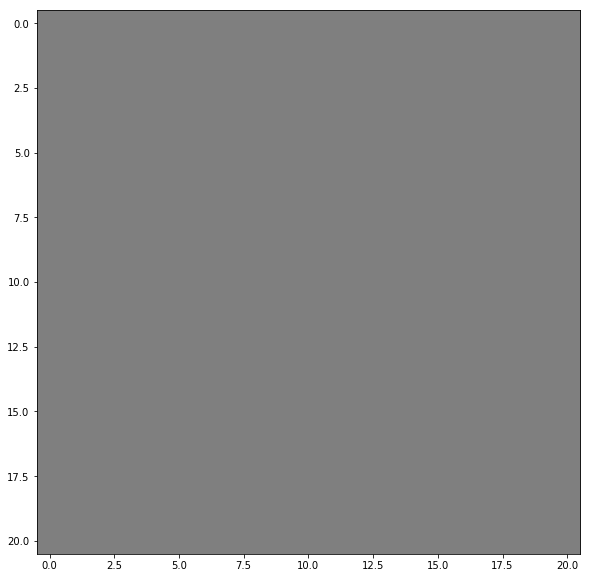

In [8]:
%pdb
def empty_image(graph):
    image = 0.5 * np.ones((GRAPH.width, GRAPH.height, 4))
    image[:, :, 3] = 1
    return image
data = empty_image(GRAPH)
fig = plt.figure(figsize=(10,10))
ax = plt.axes()
img = ax.imshow(data)

In [9]:
dstar = DStarLite(GRAPH, START, END, view_range=2)
SIMULATION = dstar.move_to_goal()


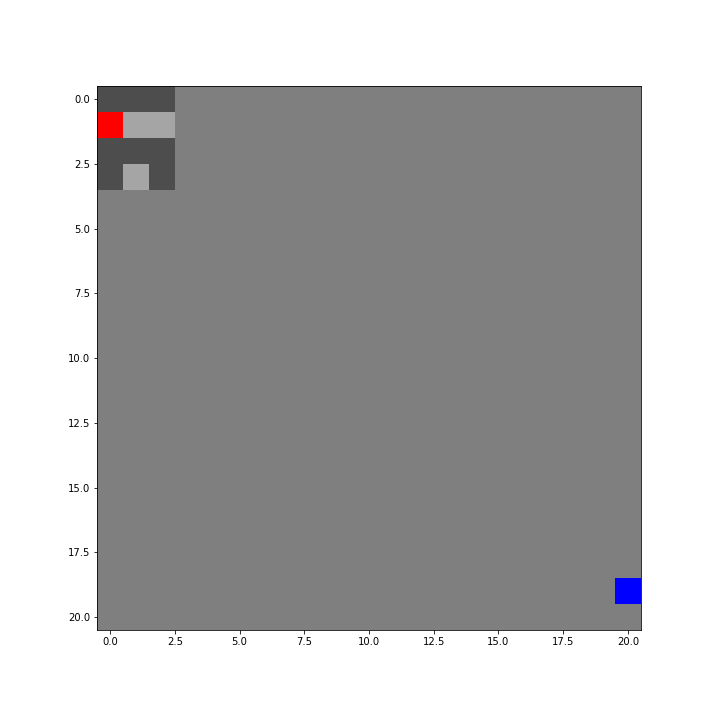
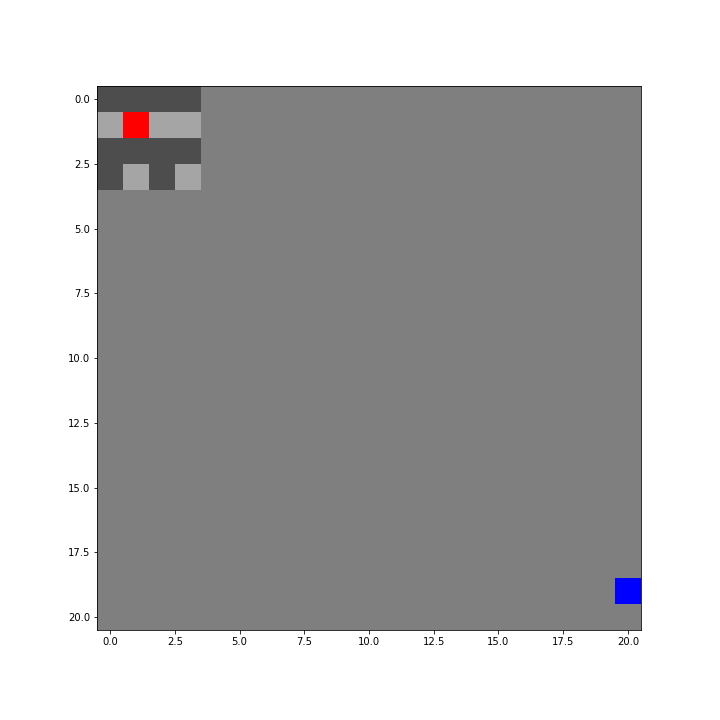
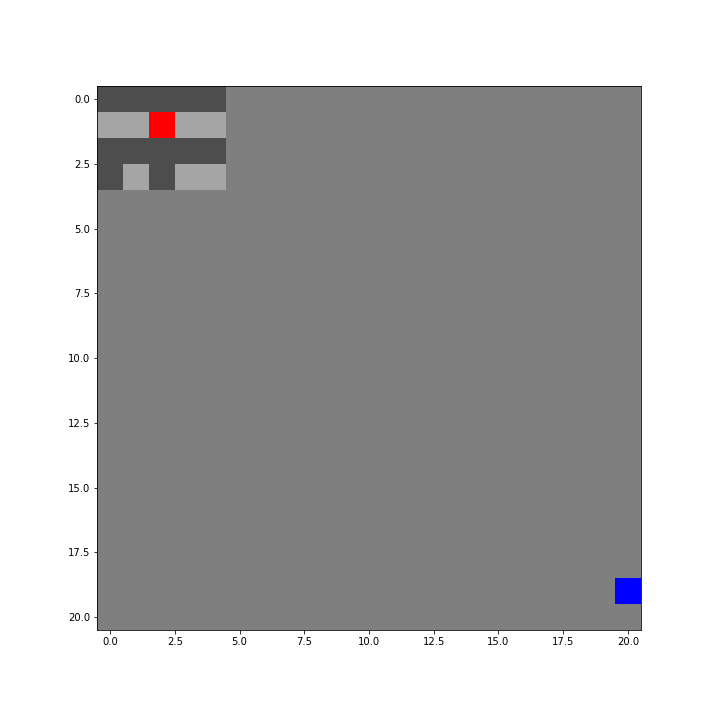
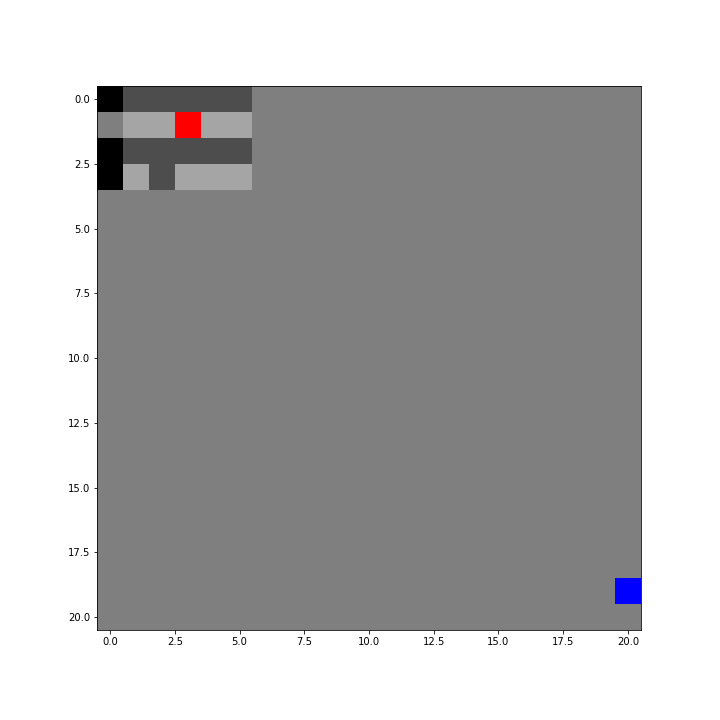
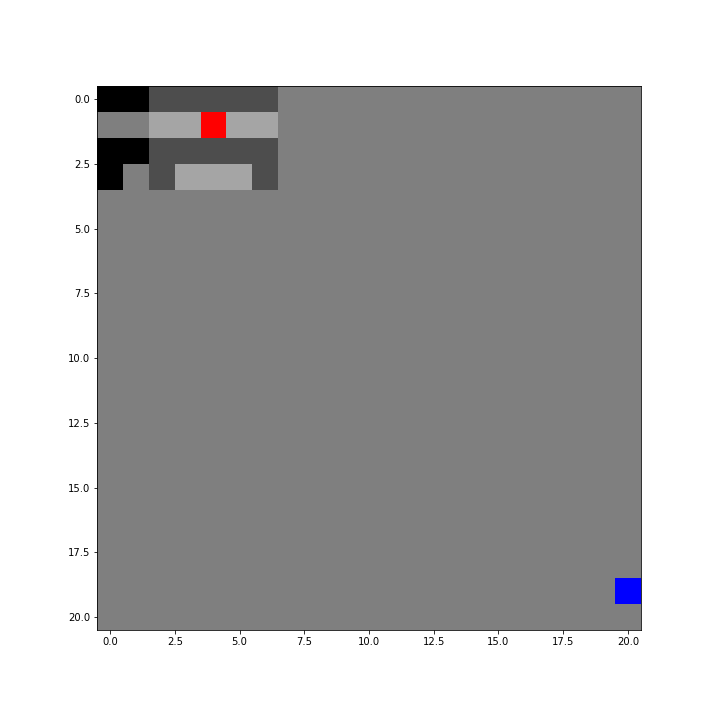
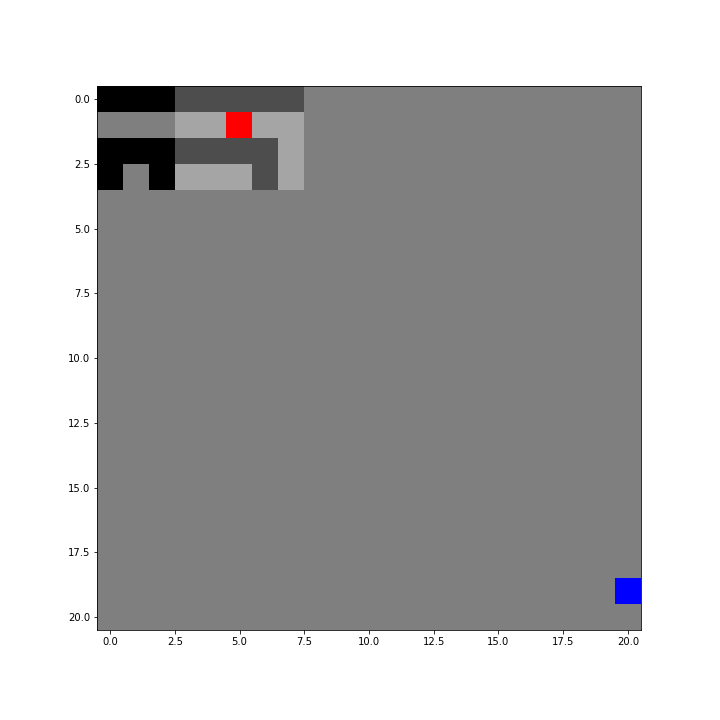
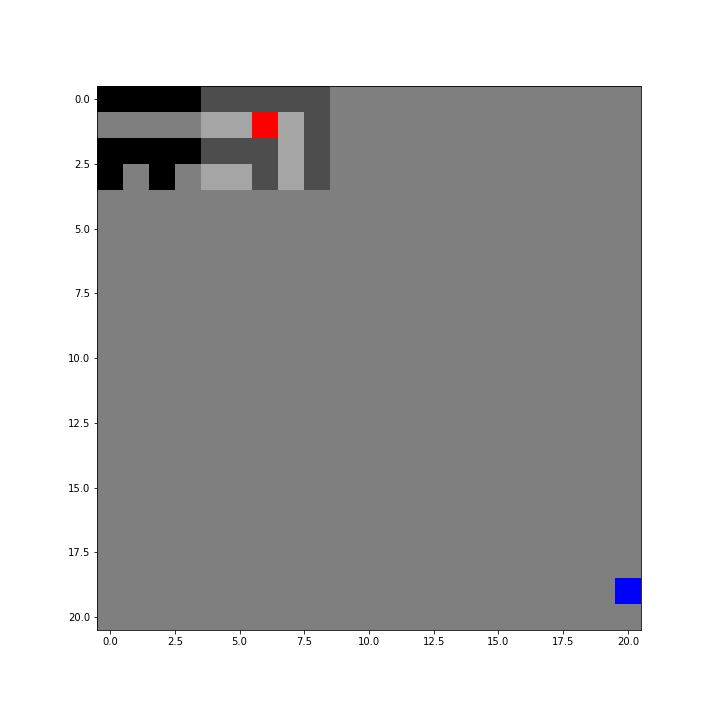
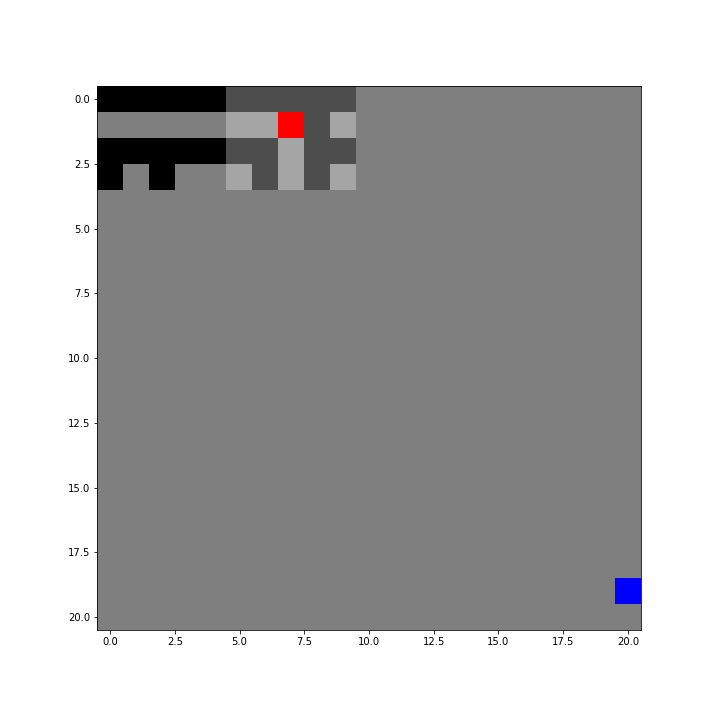
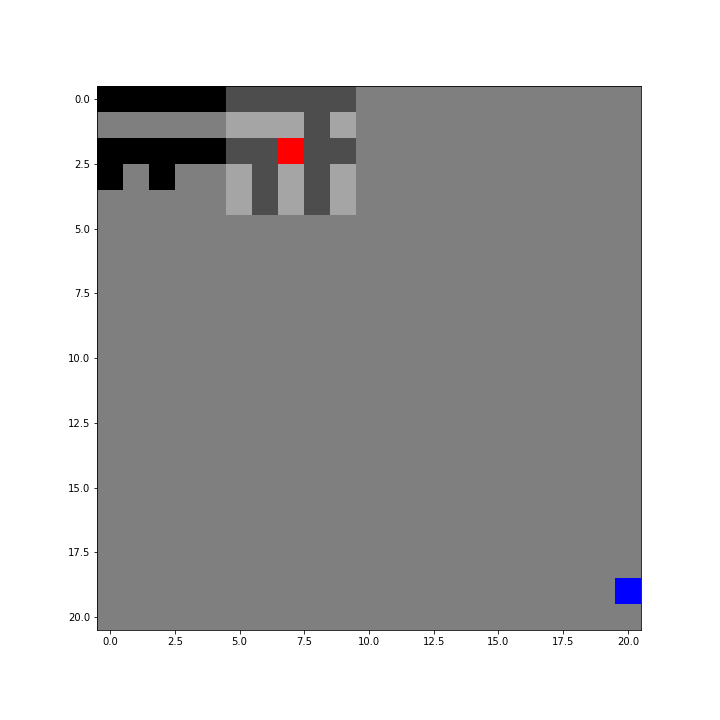
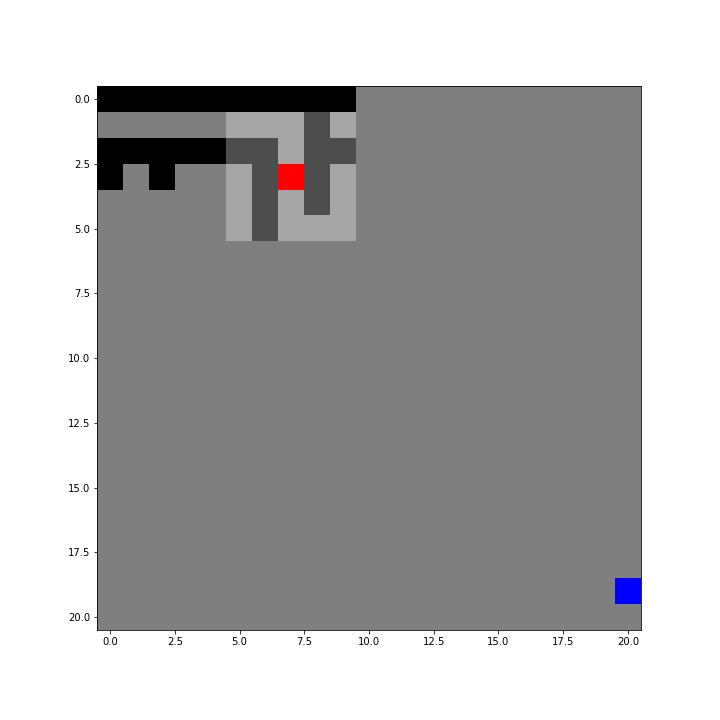
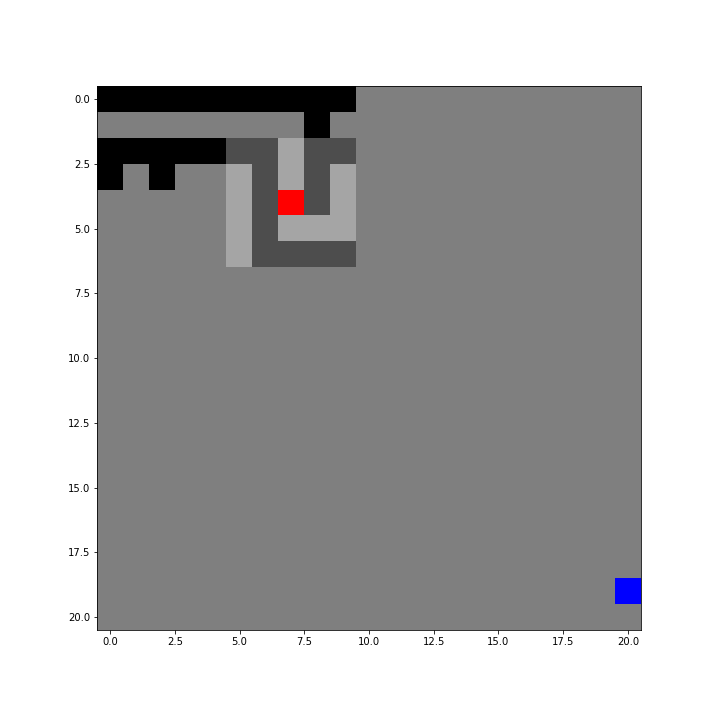
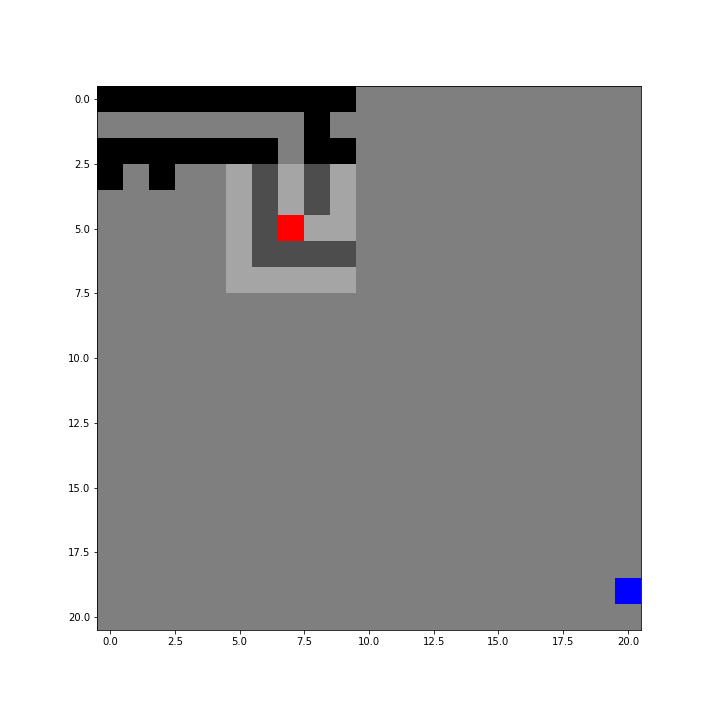
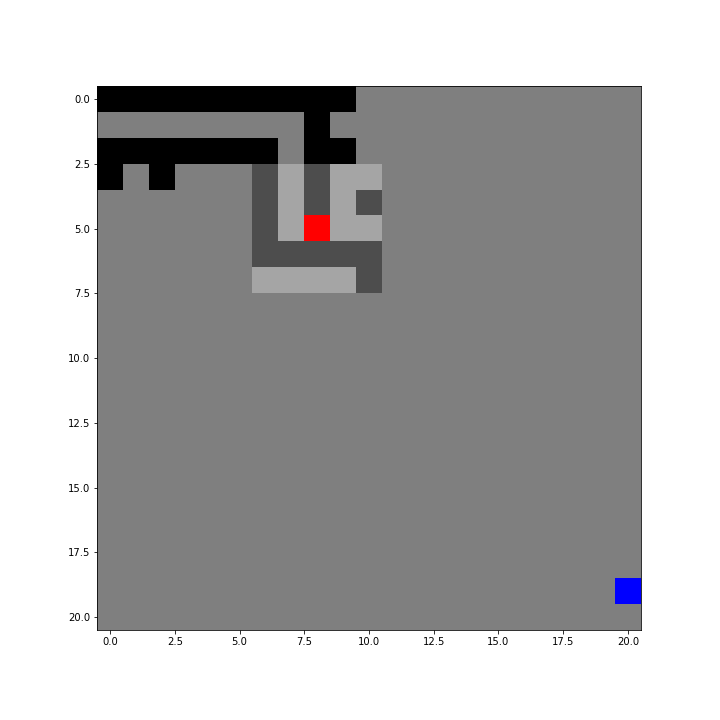
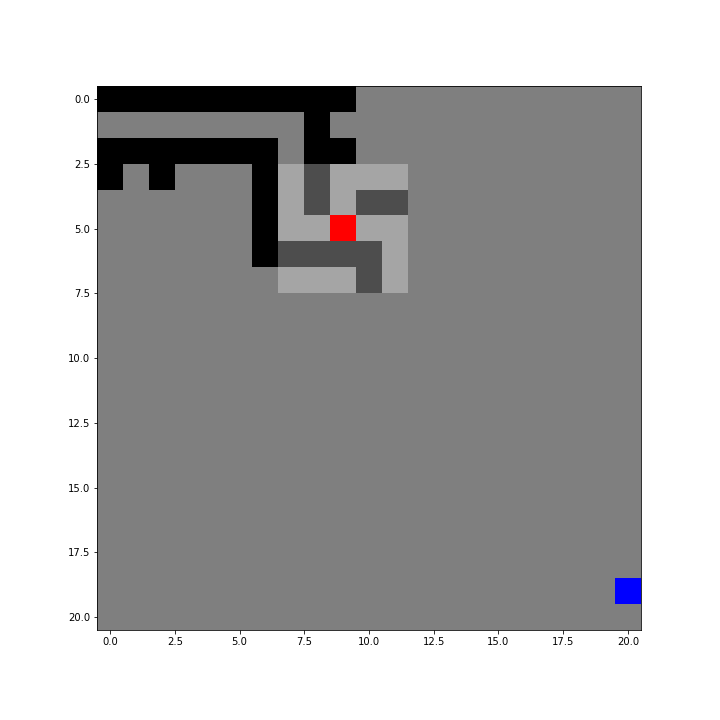
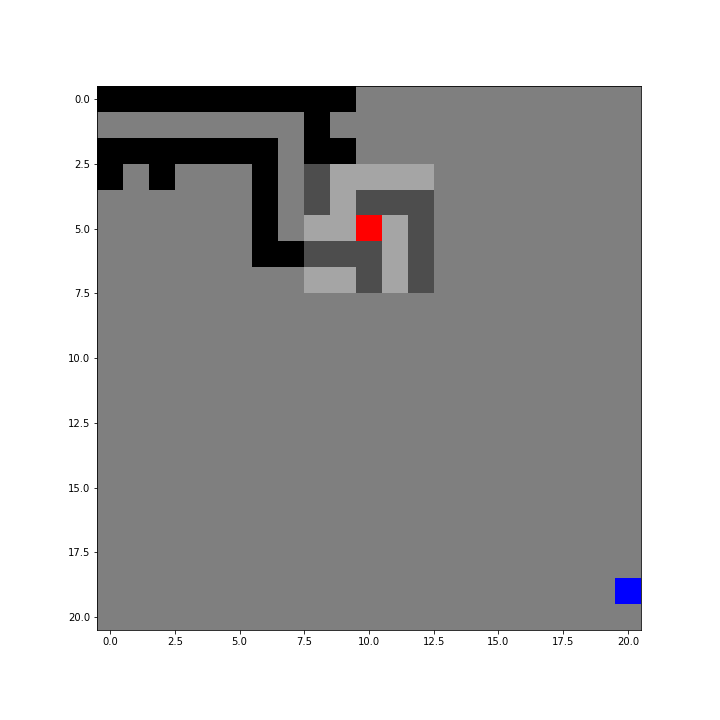
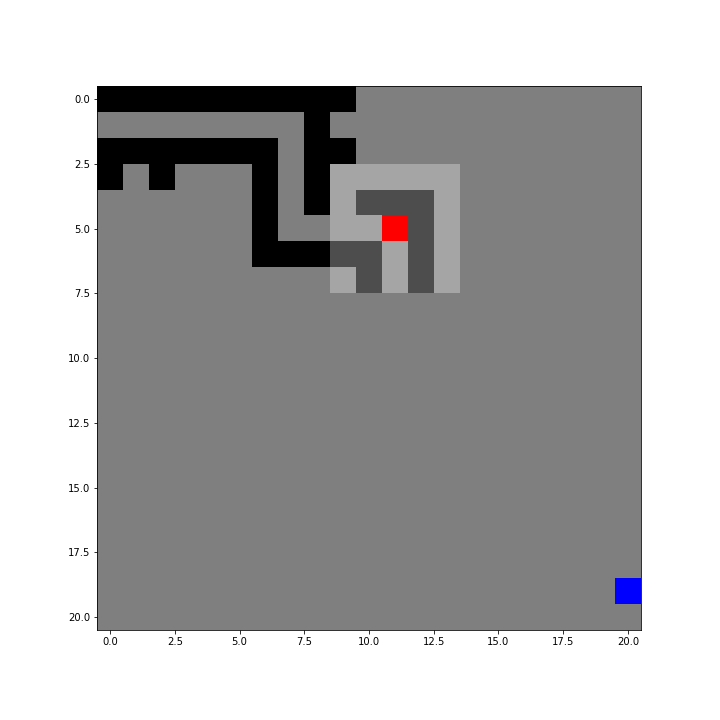
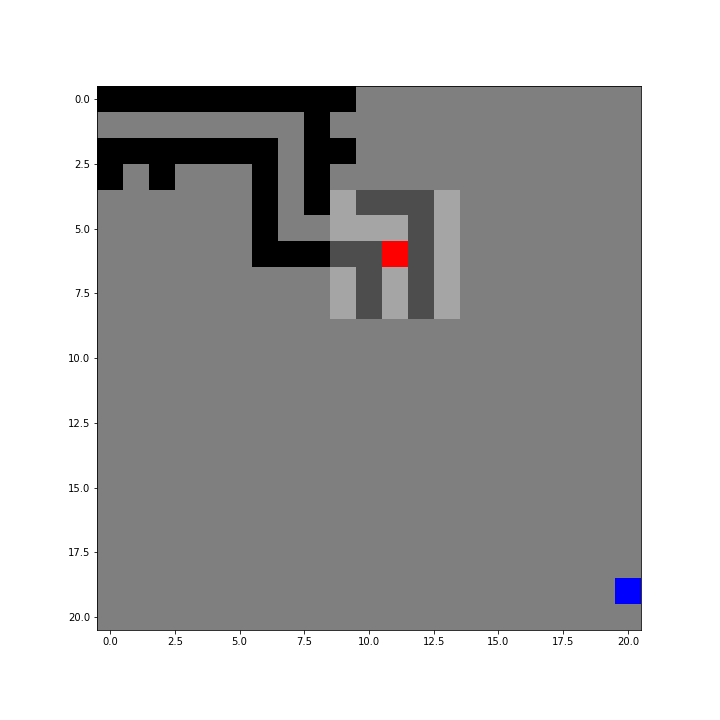
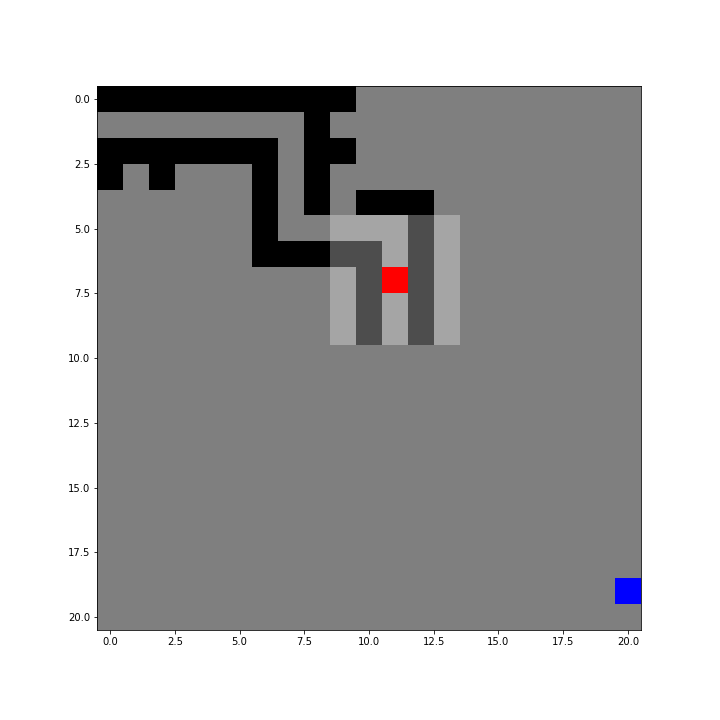
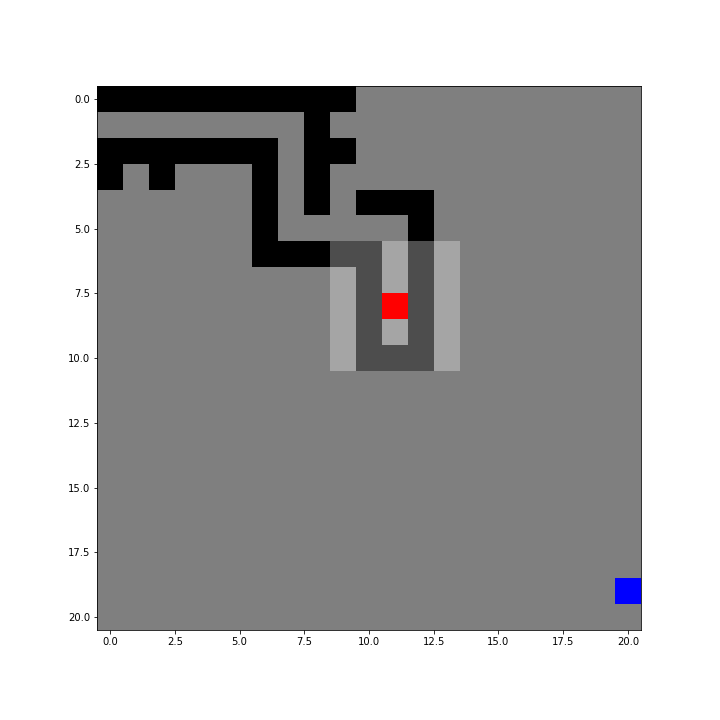
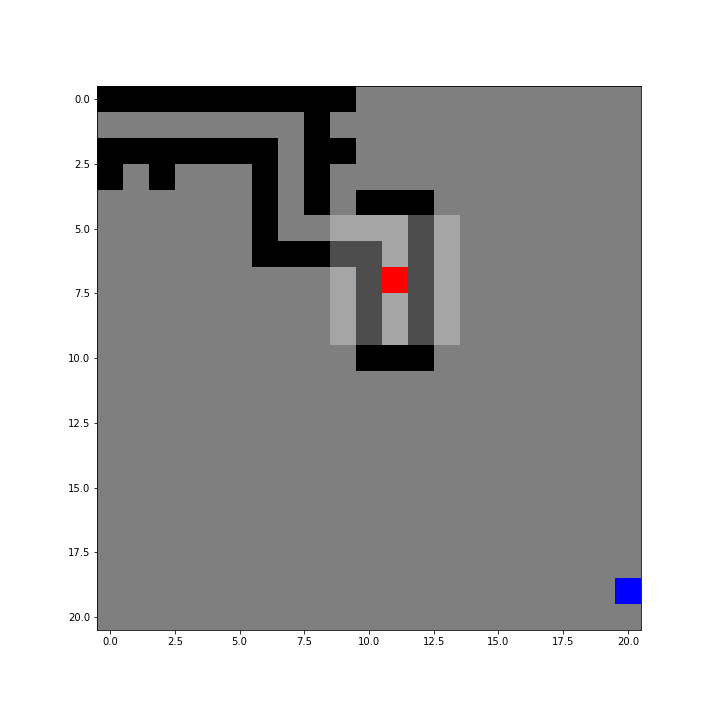
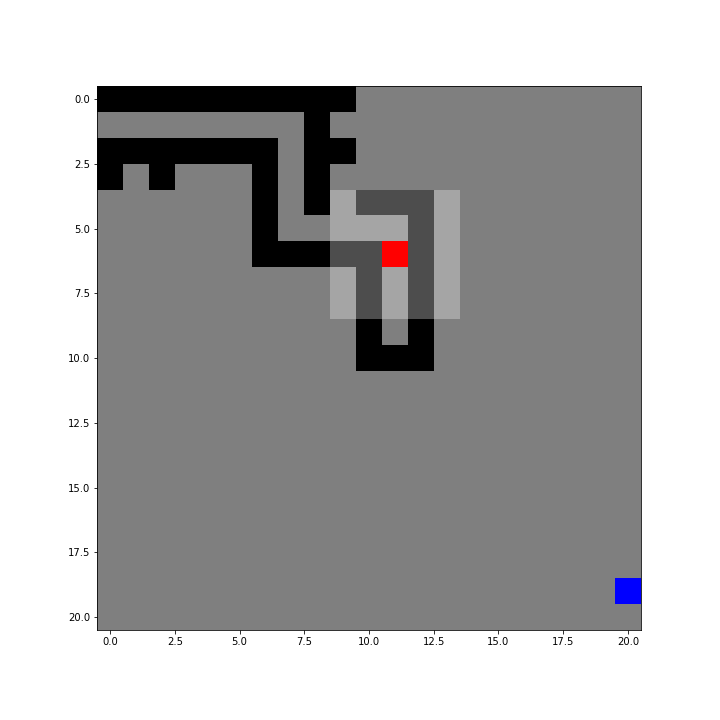
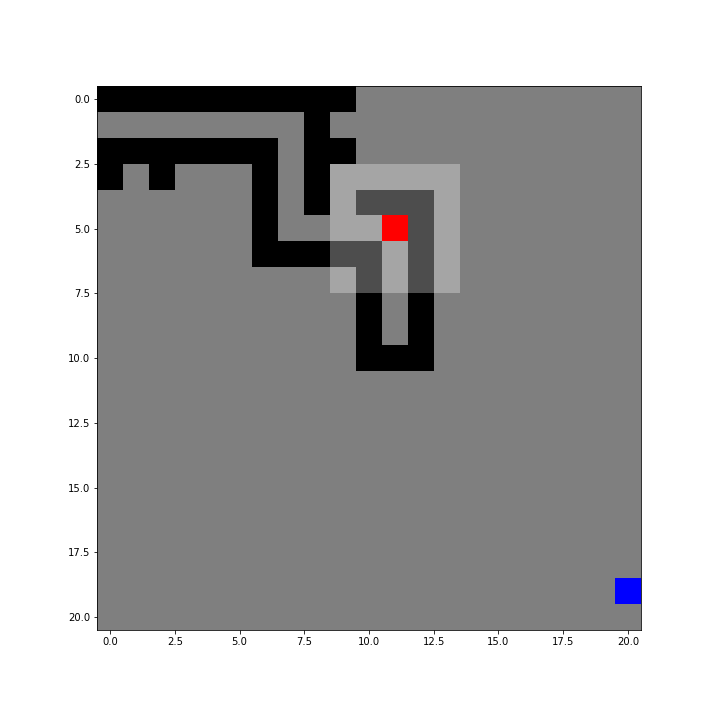
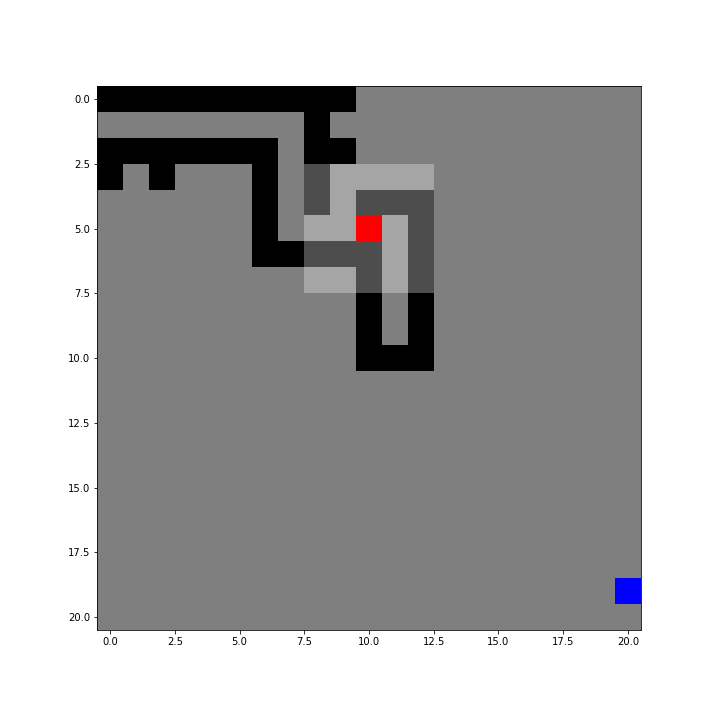
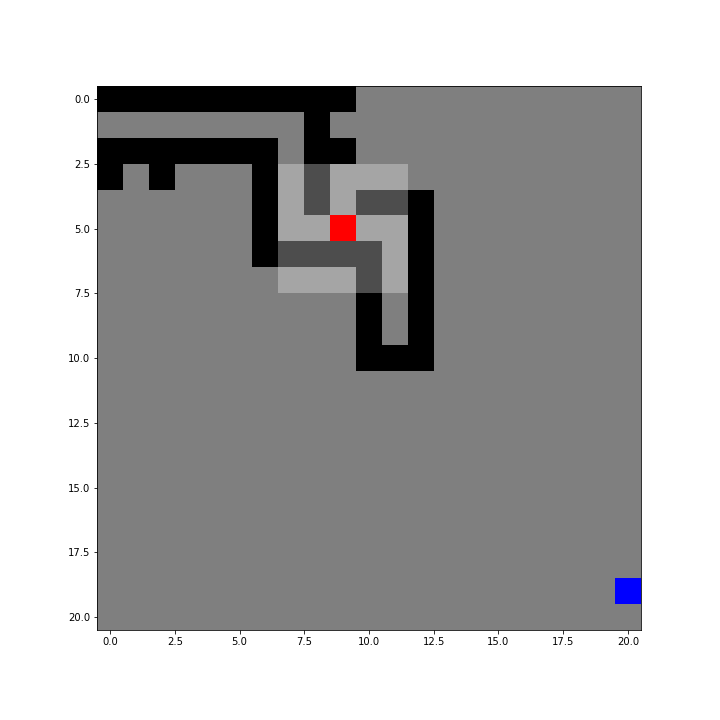
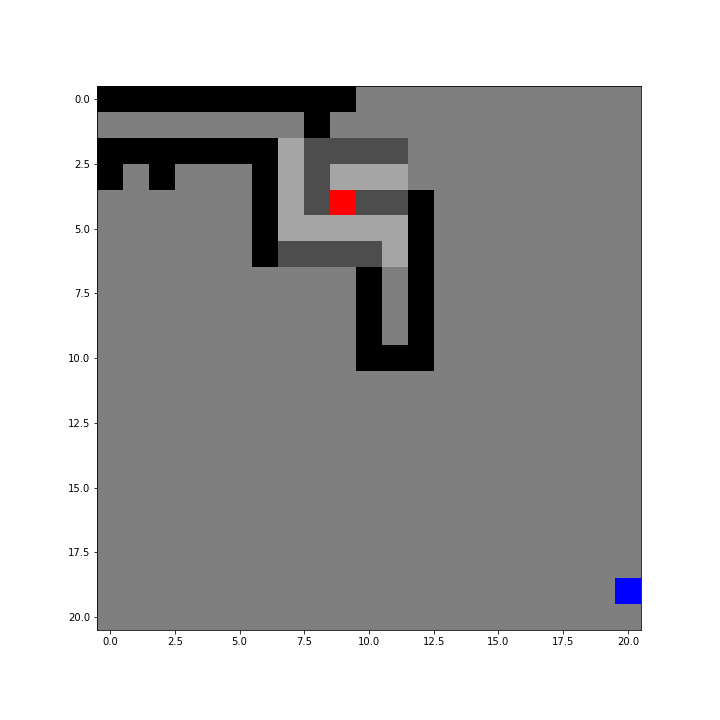
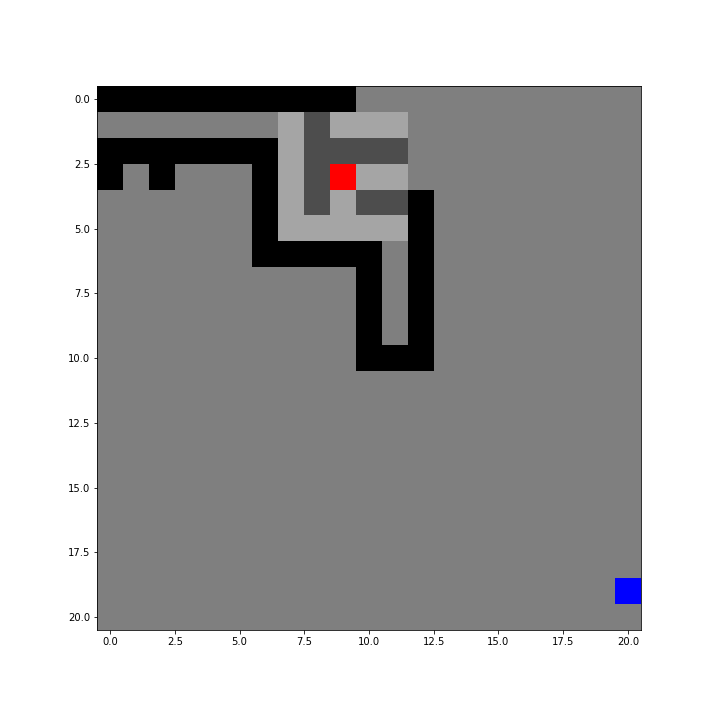
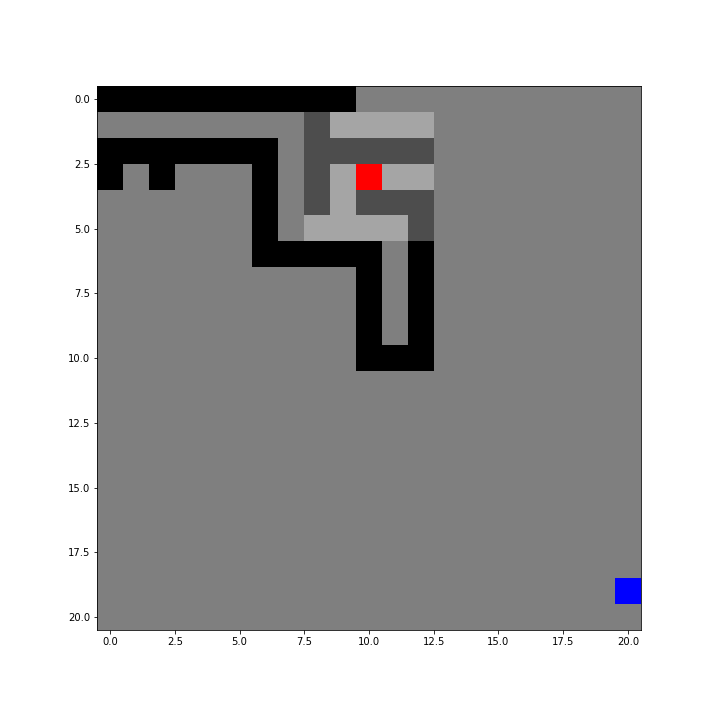
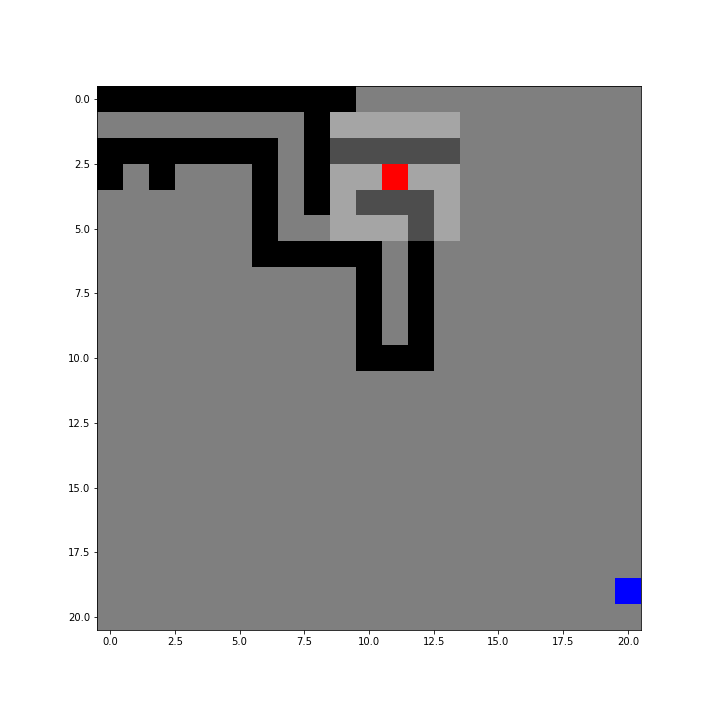
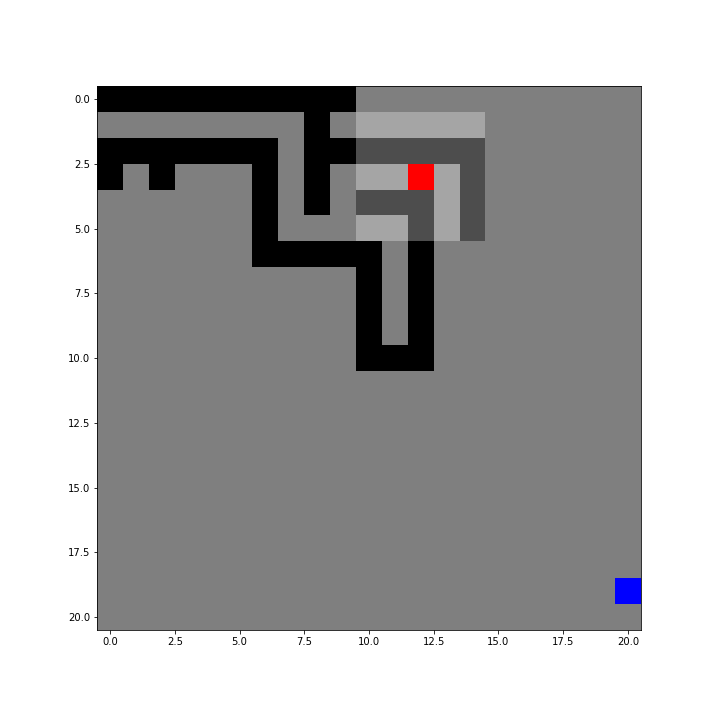
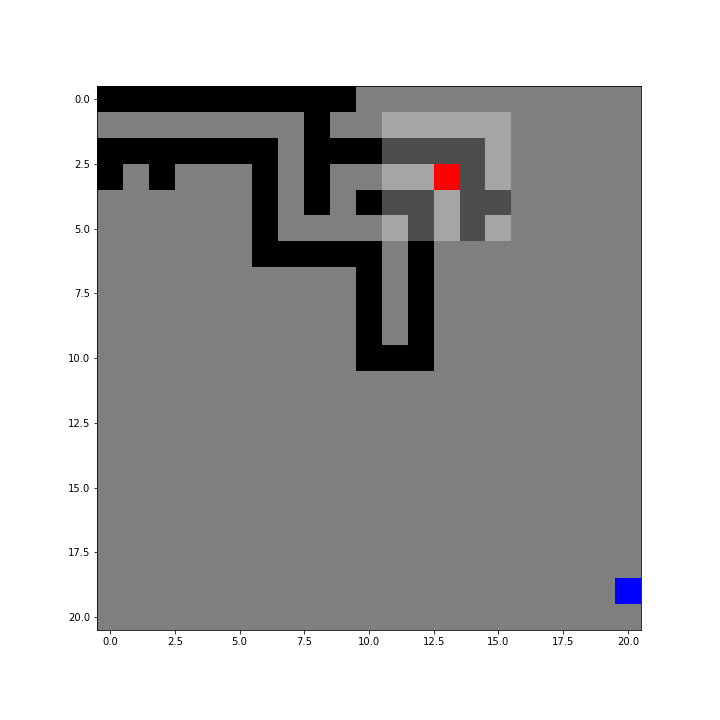
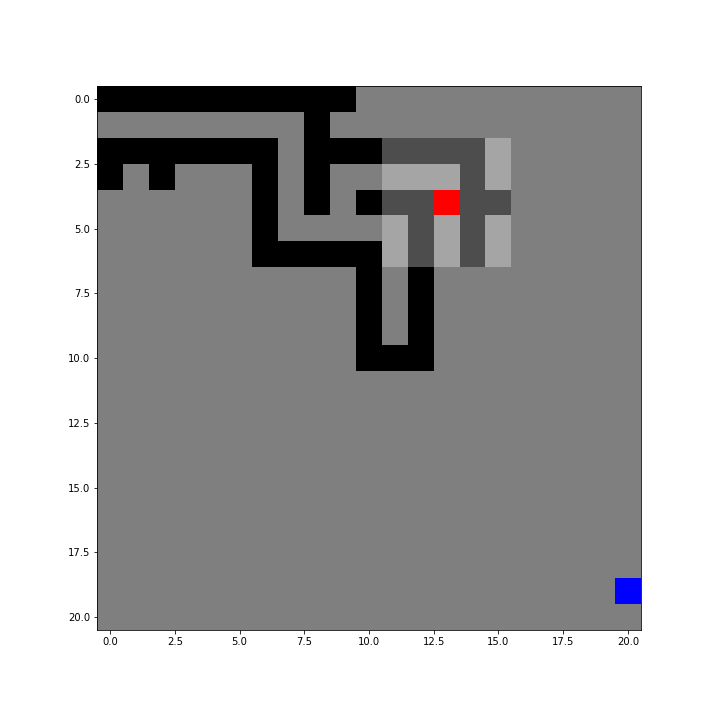
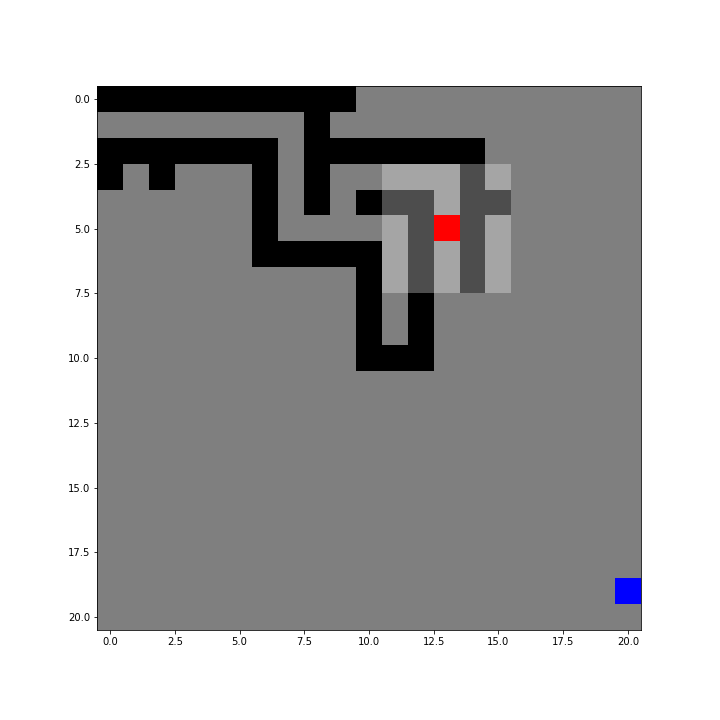
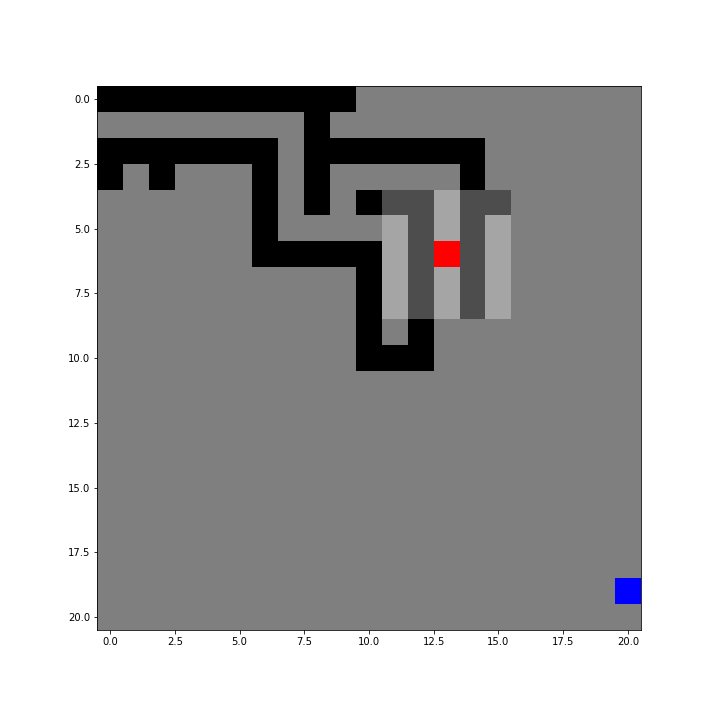
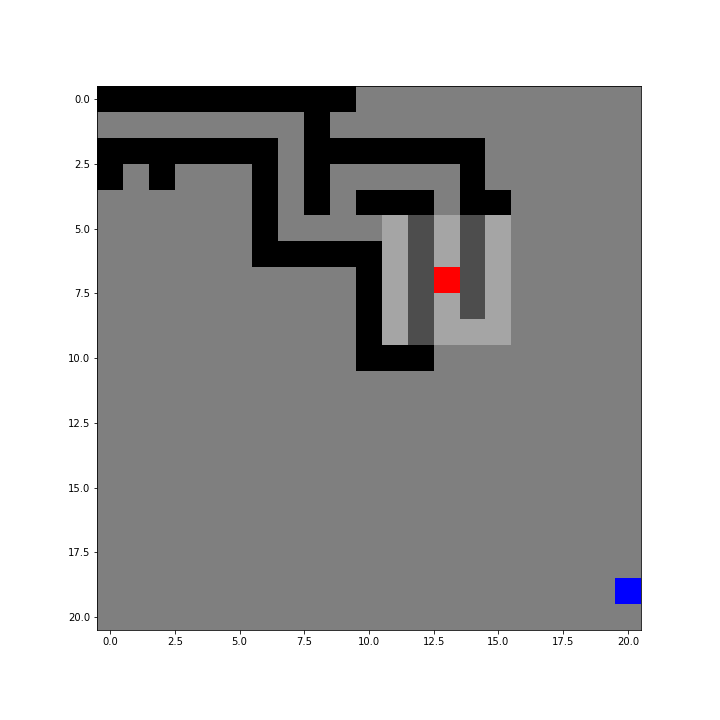
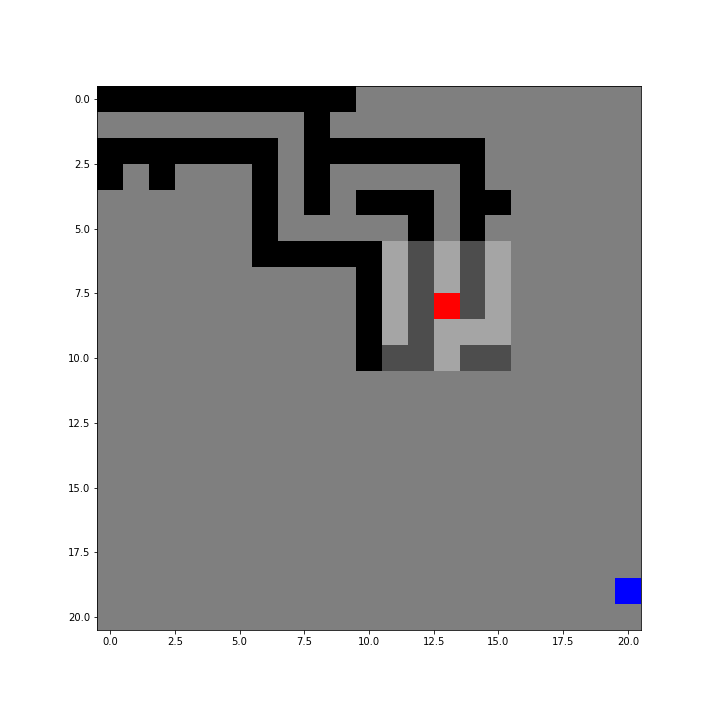
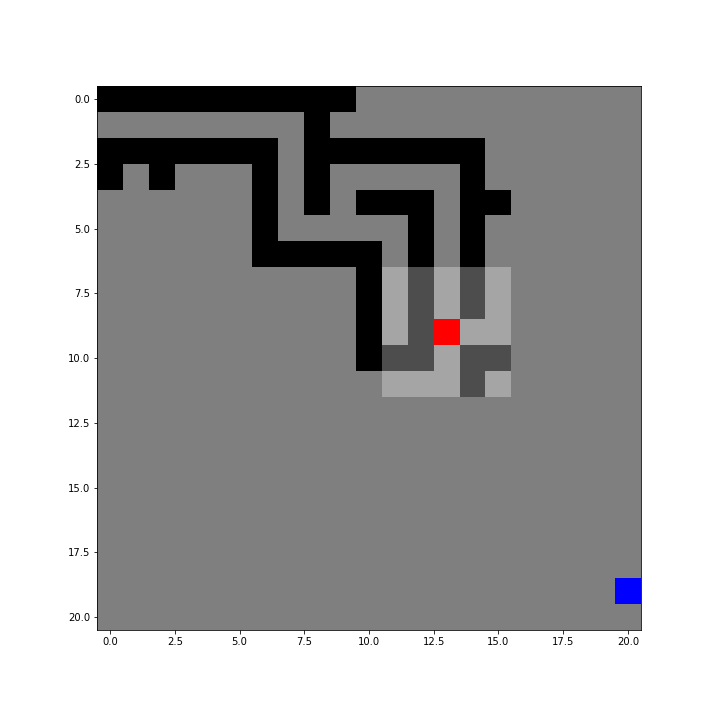
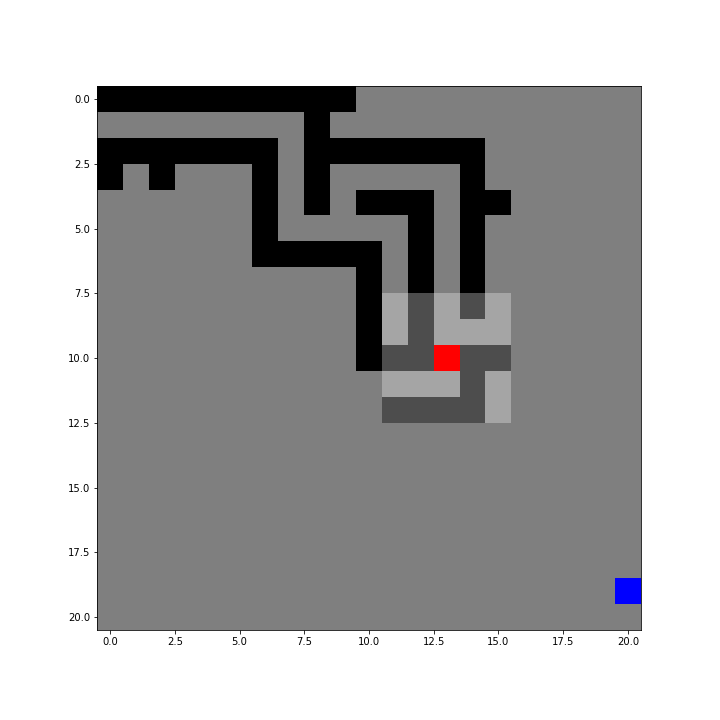
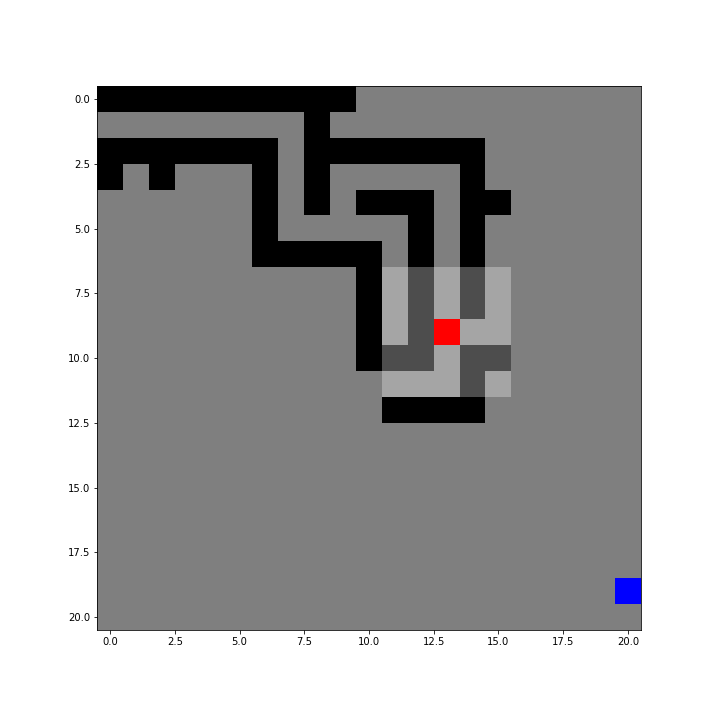
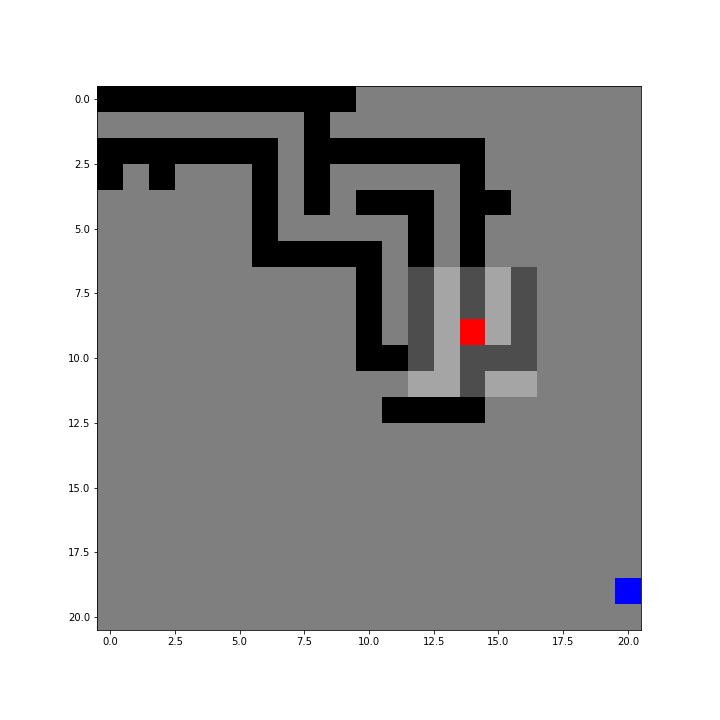
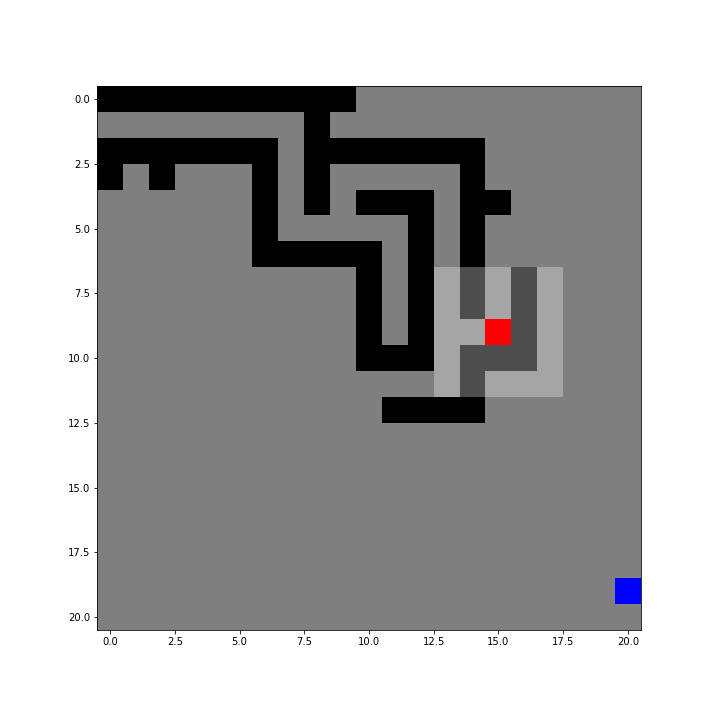
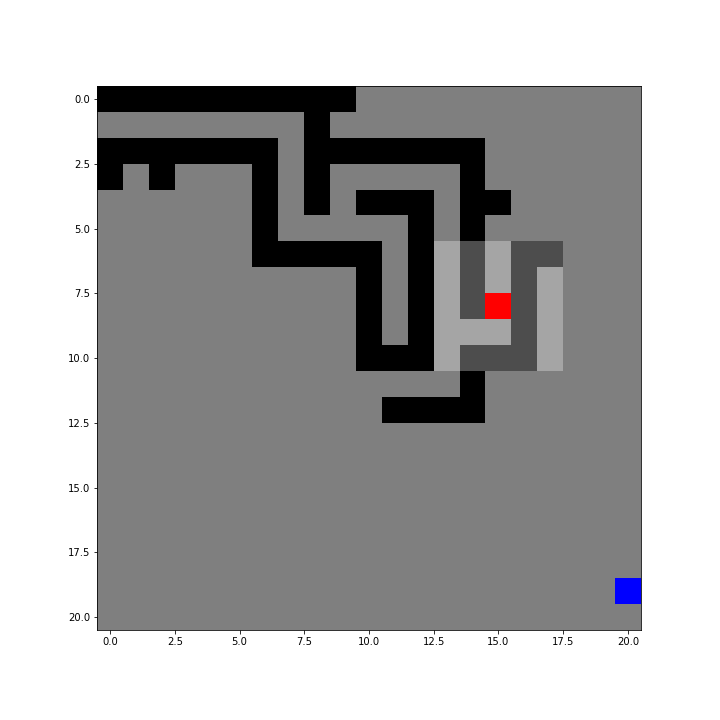
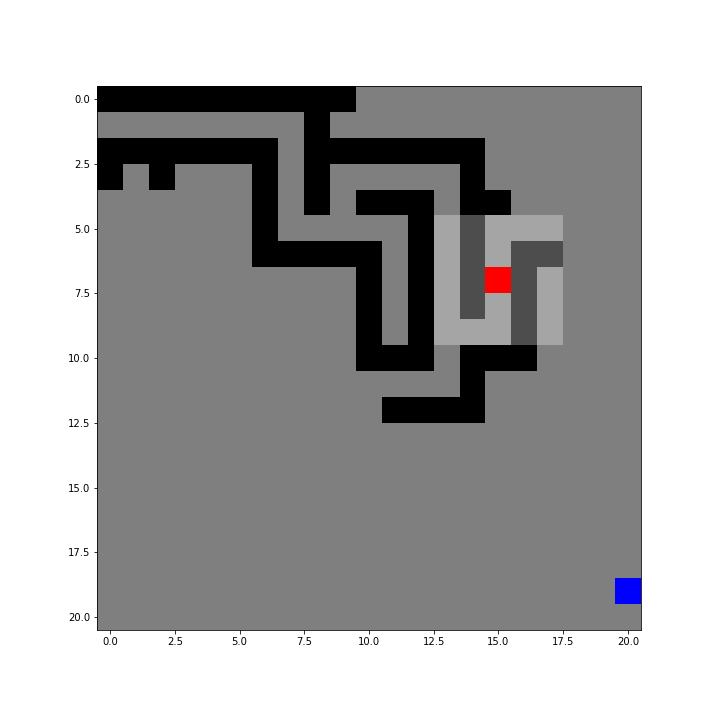
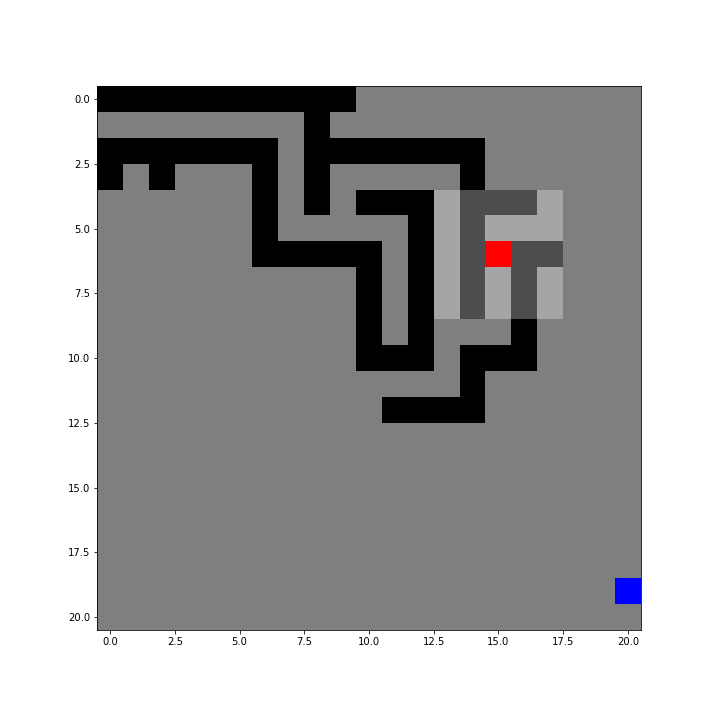
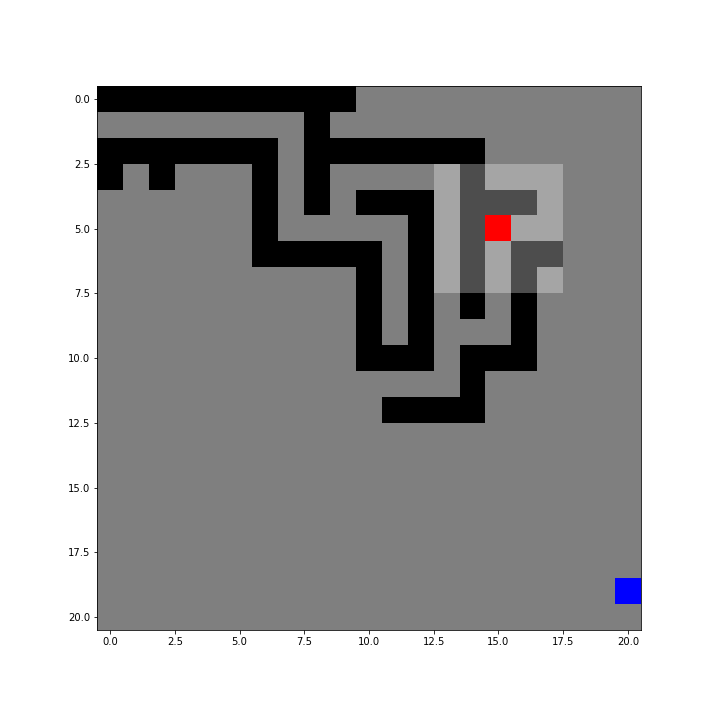
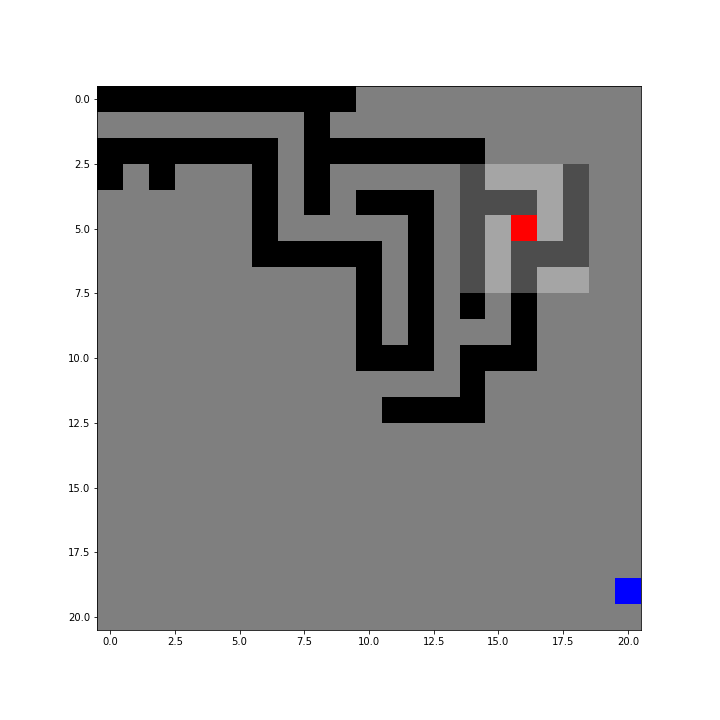
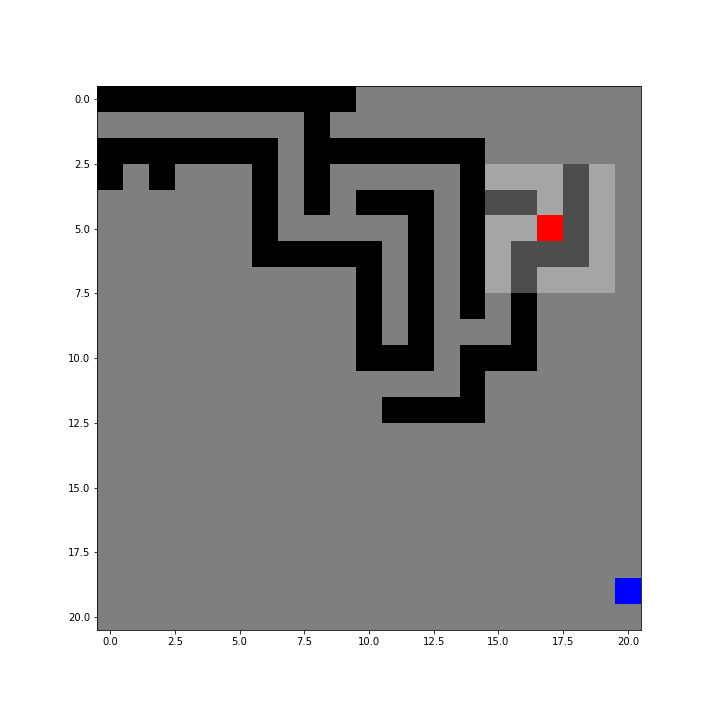
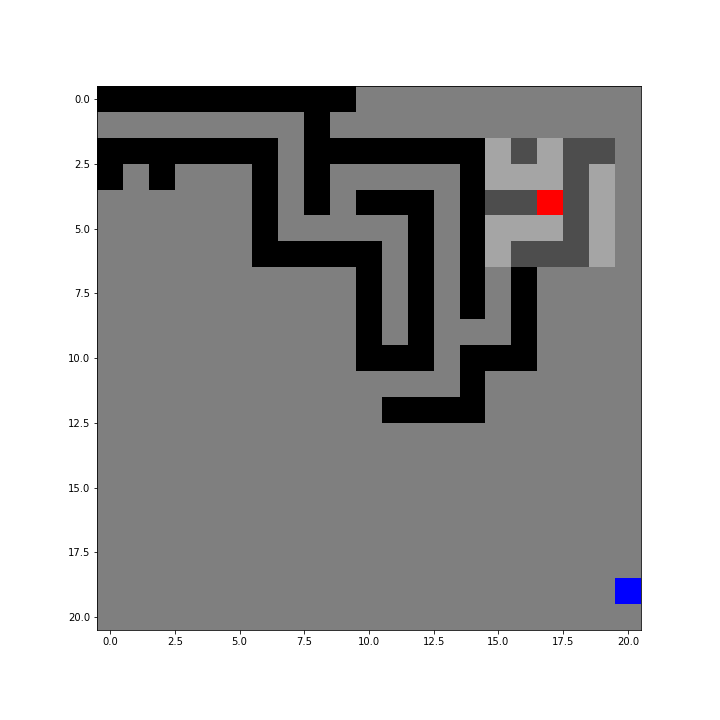
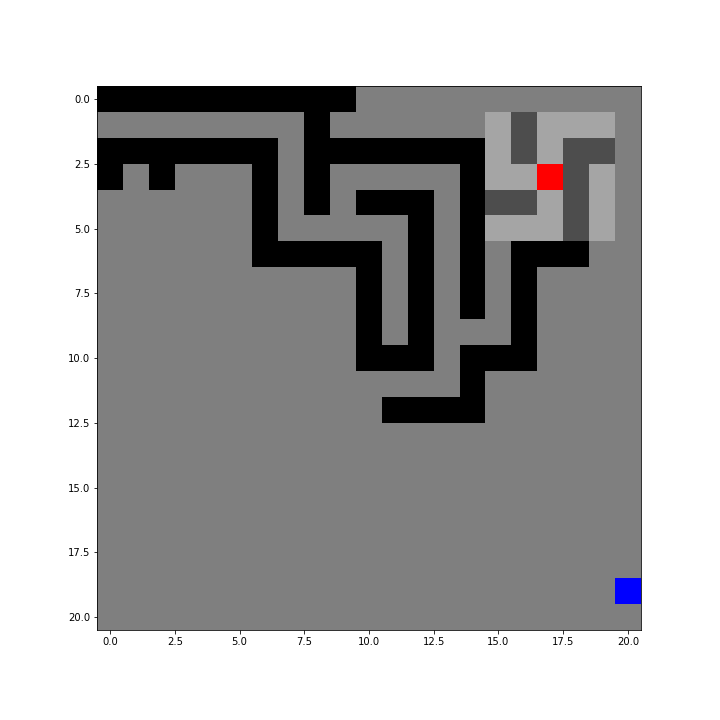
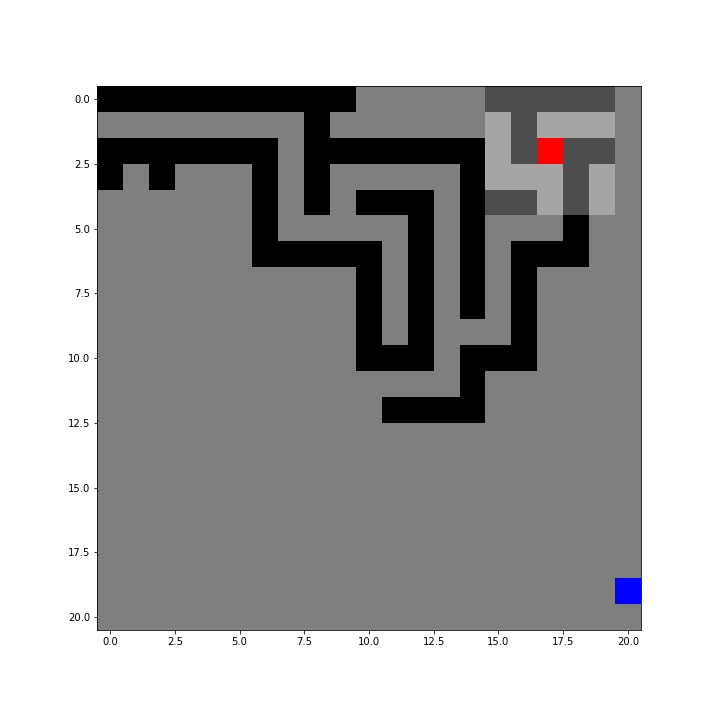
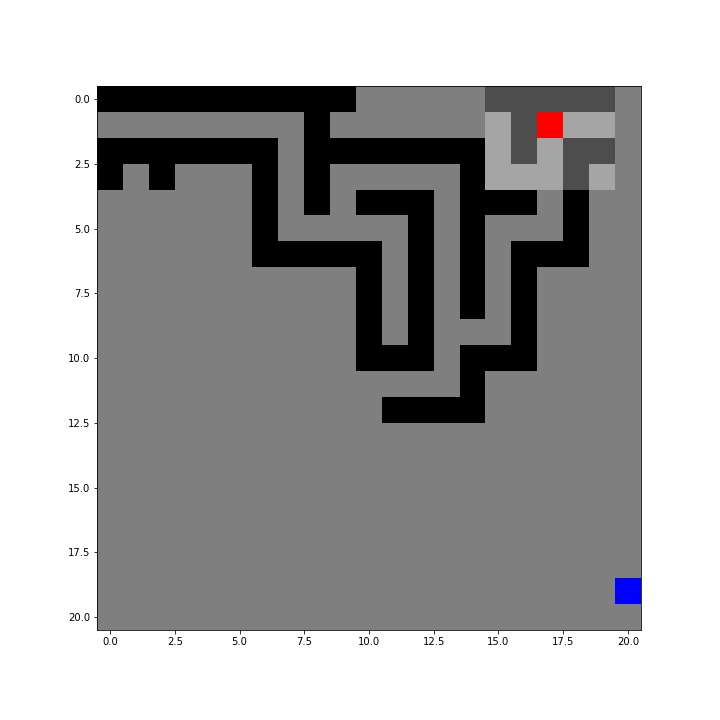
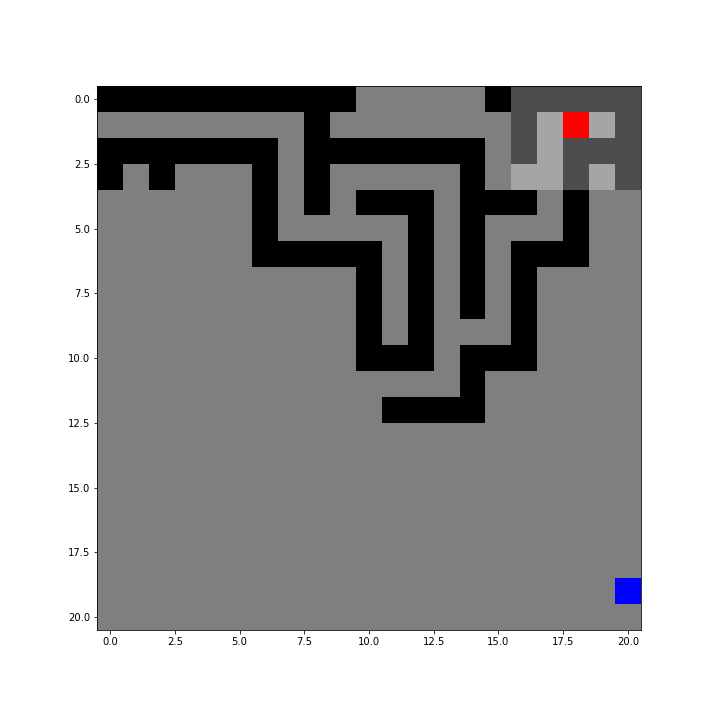
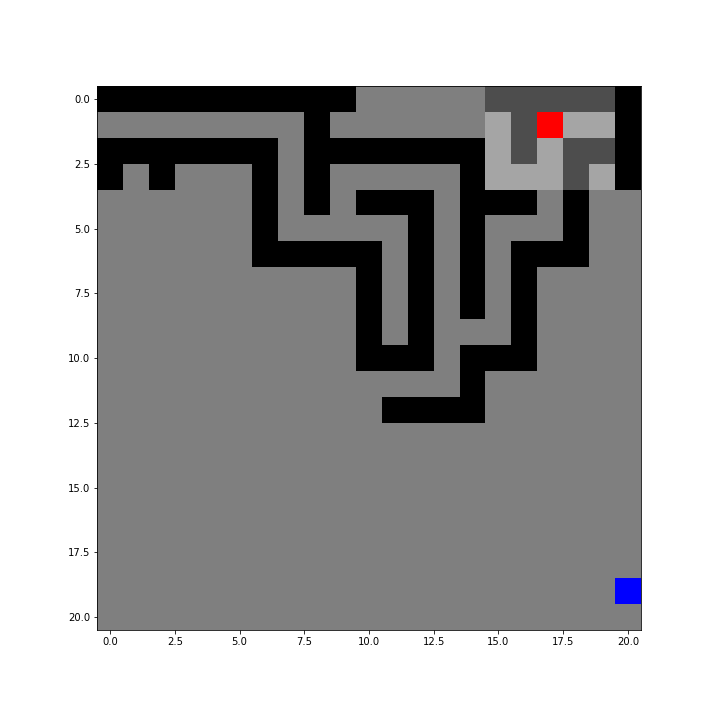
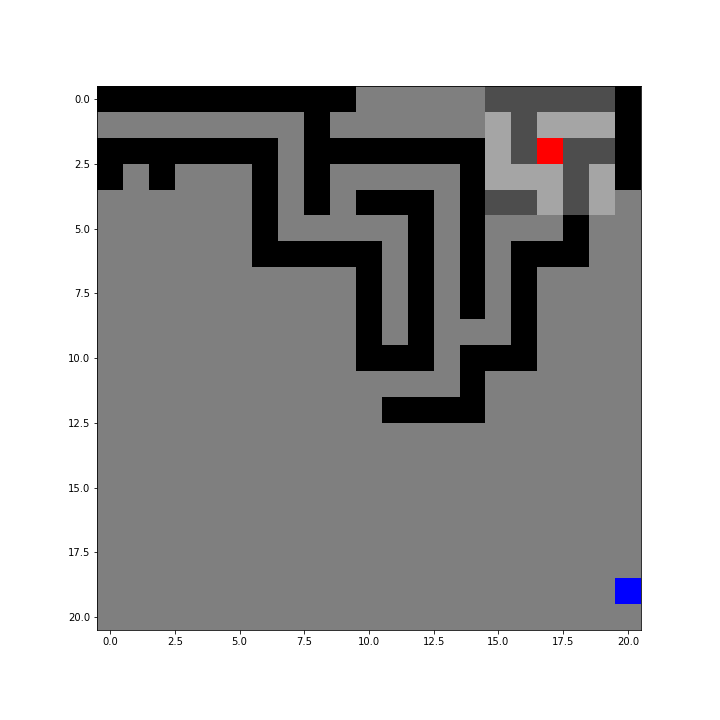
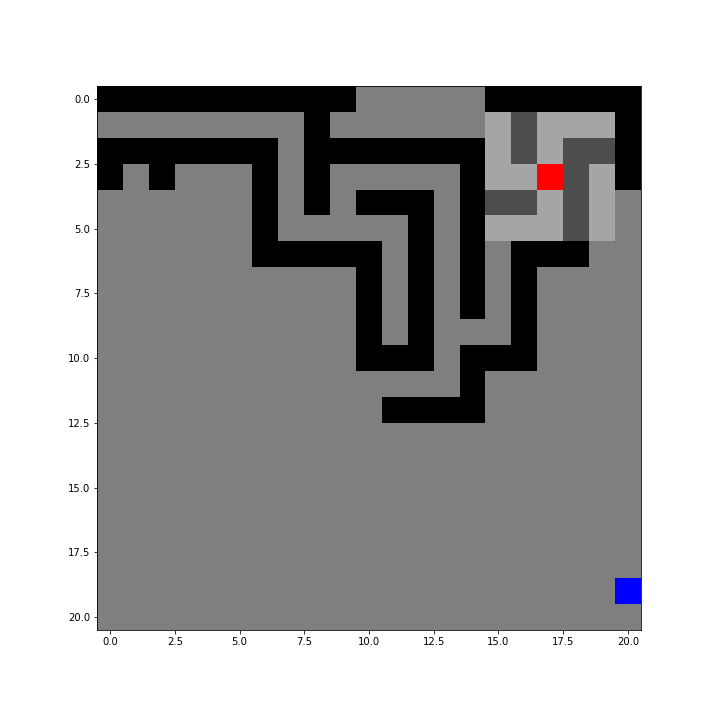
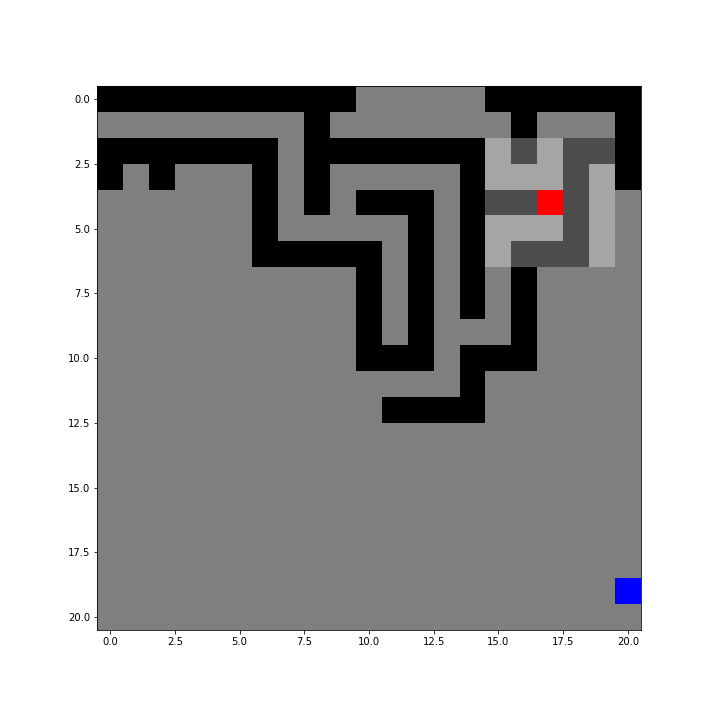
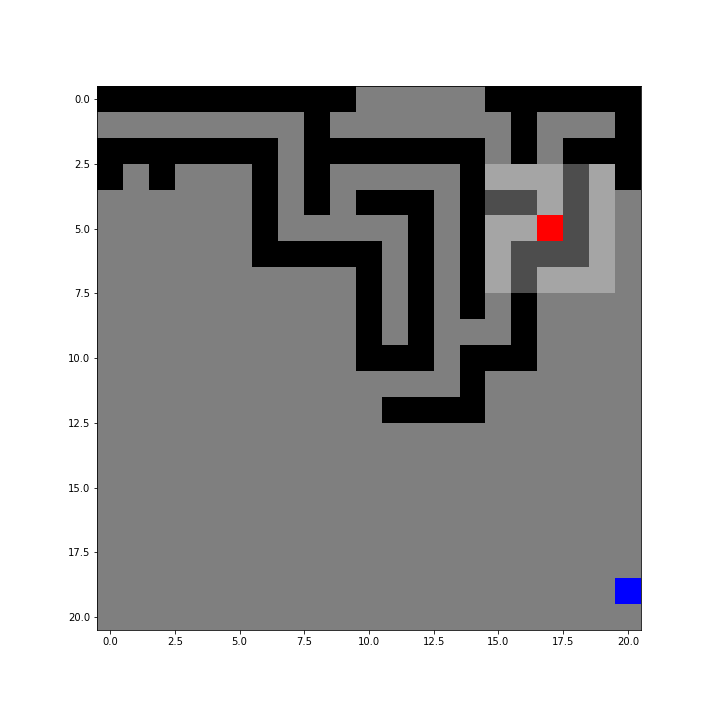
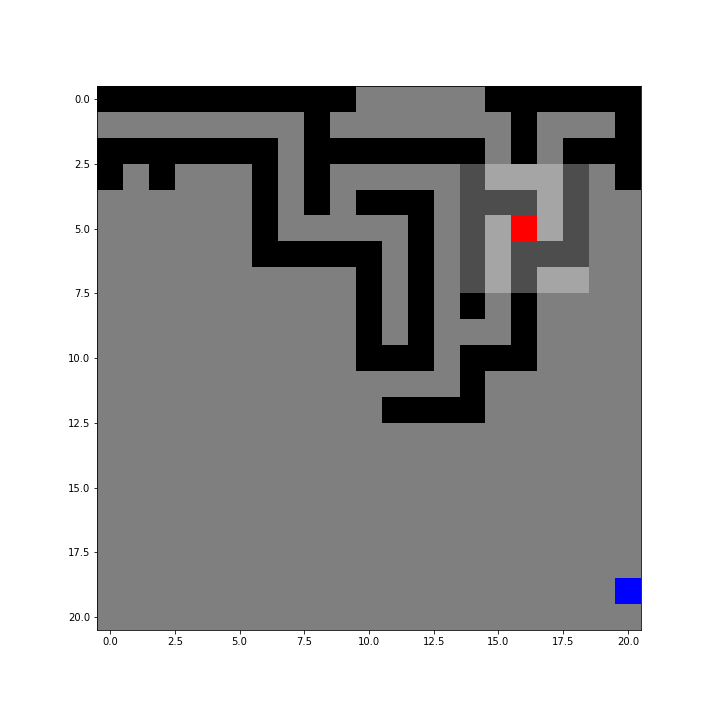
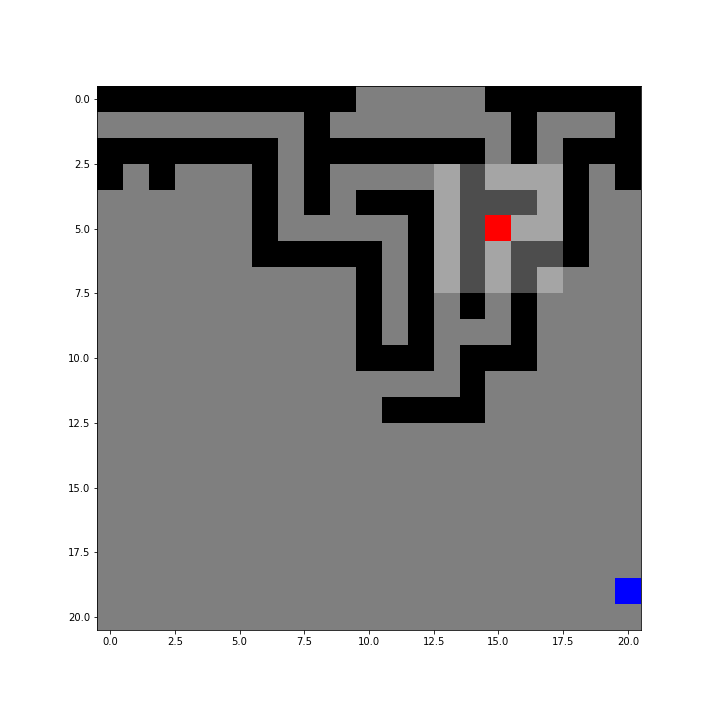
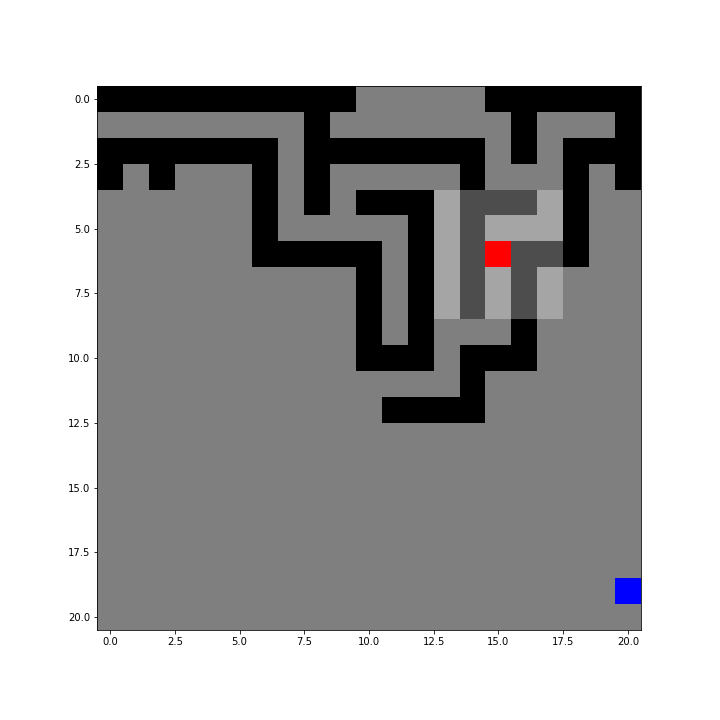
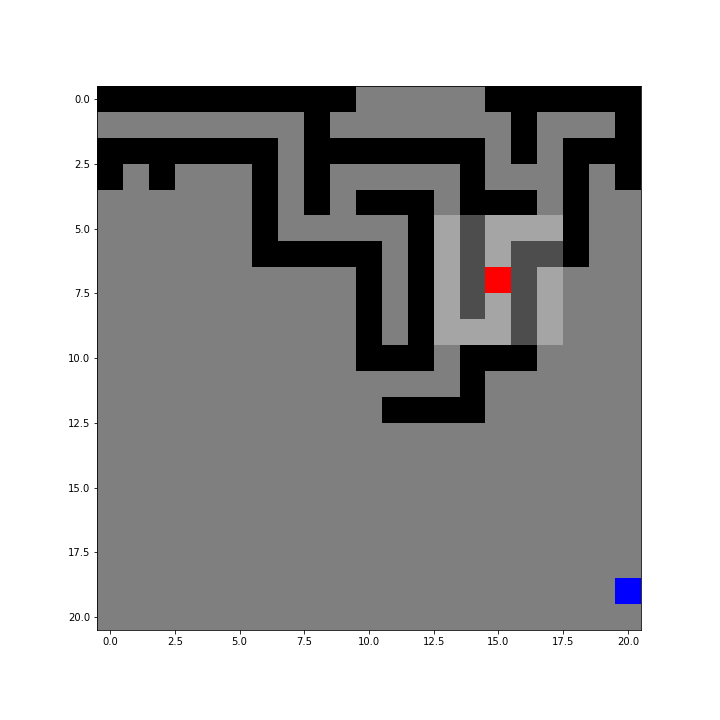
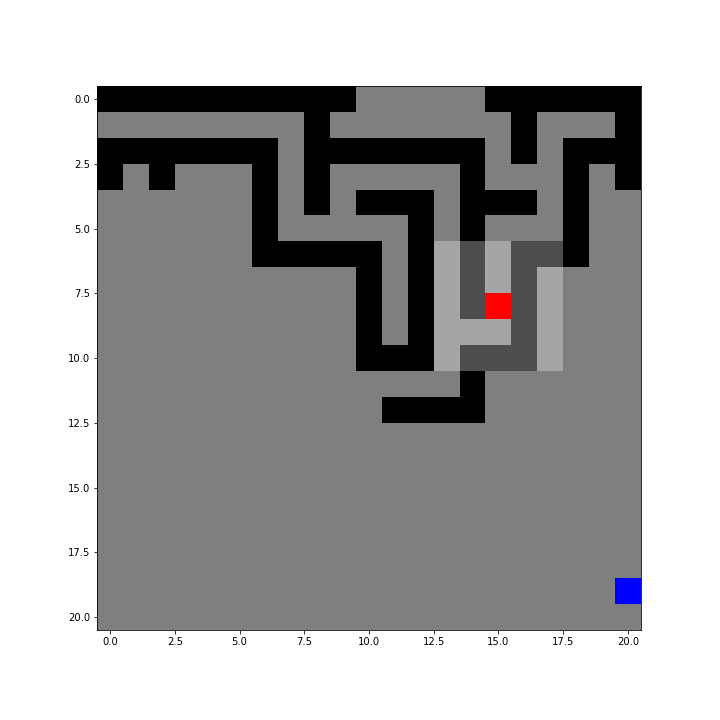
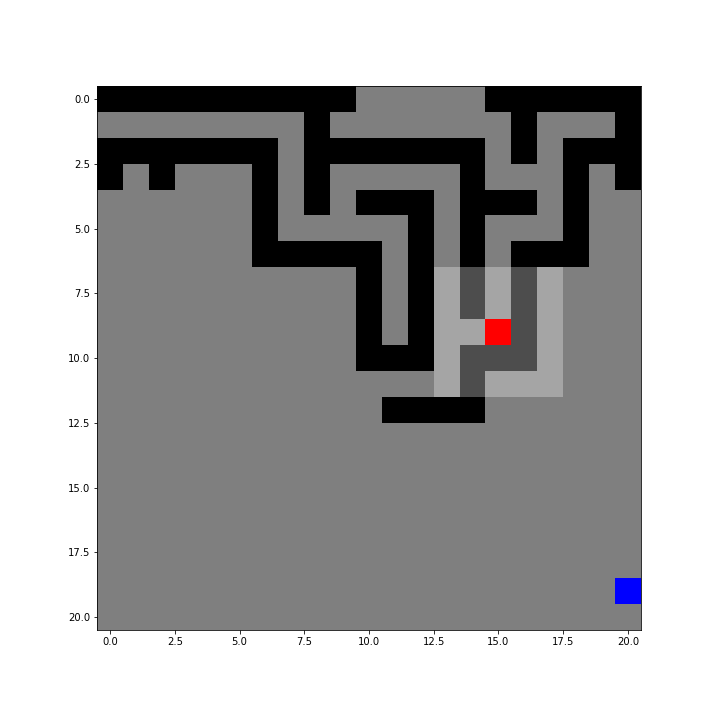
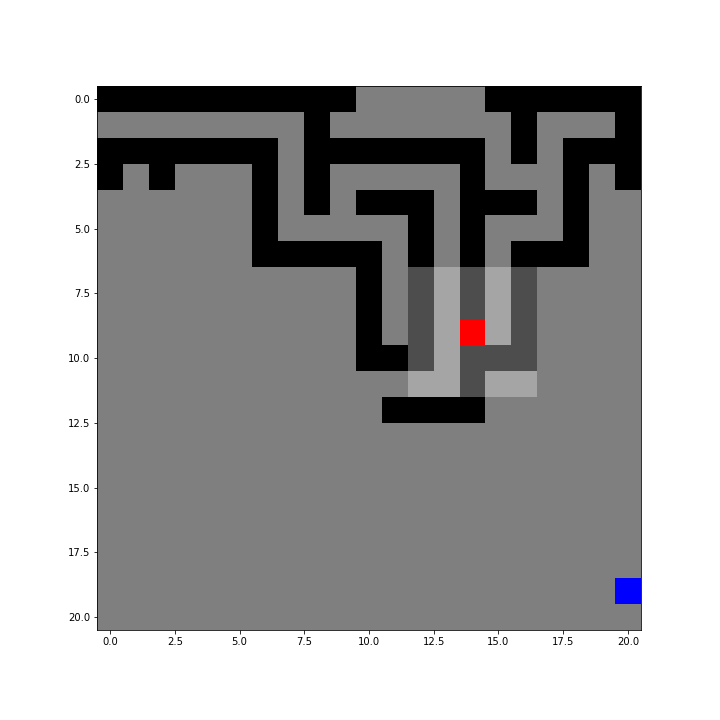
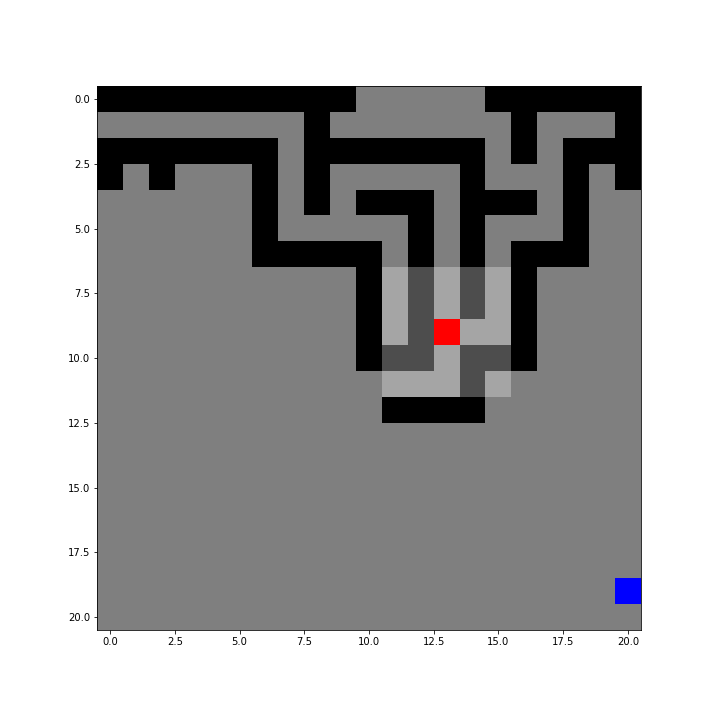
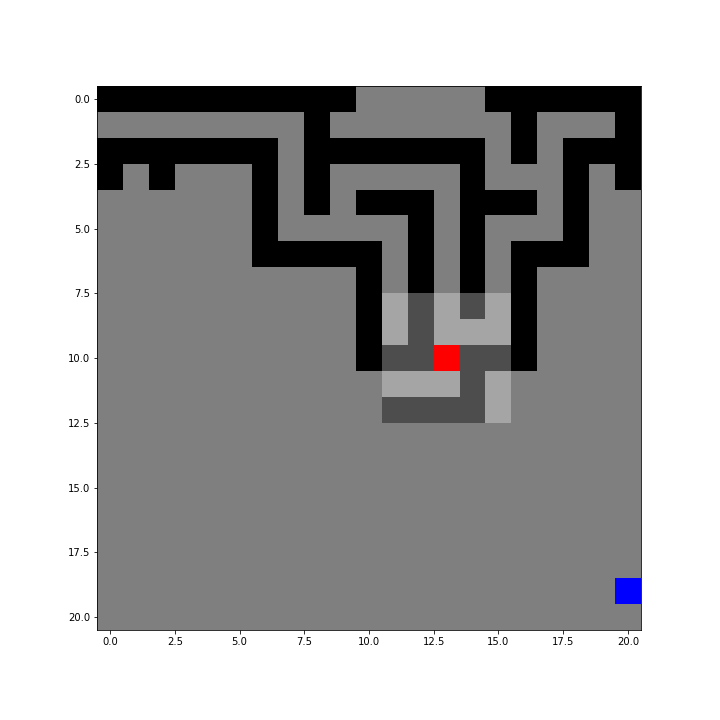
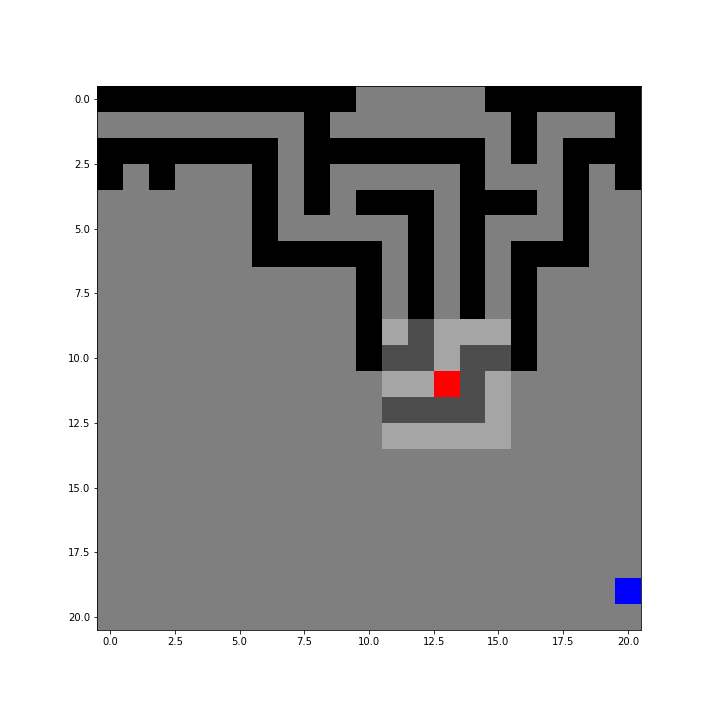
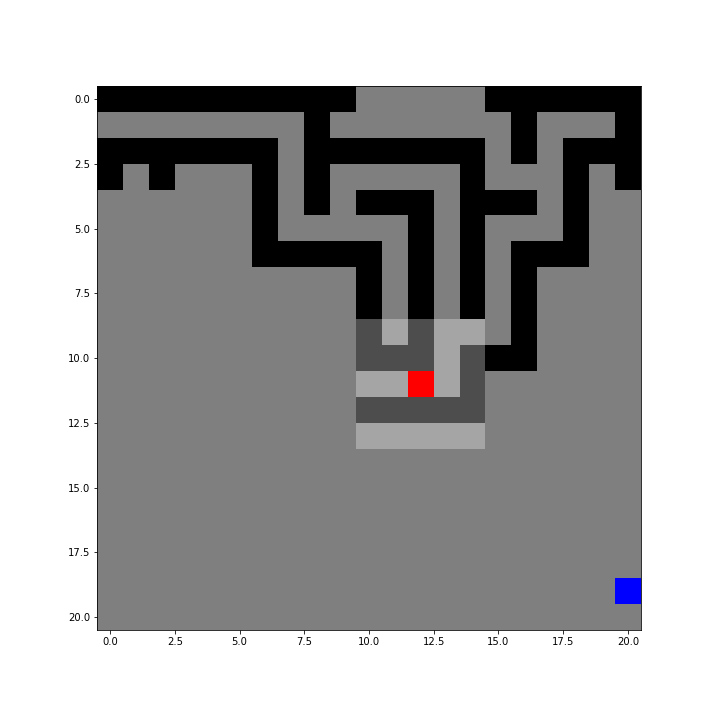
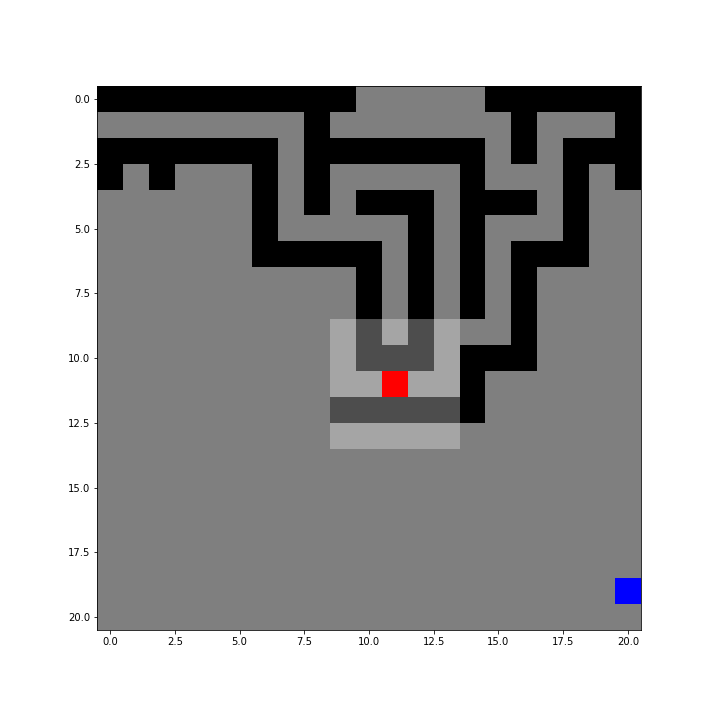
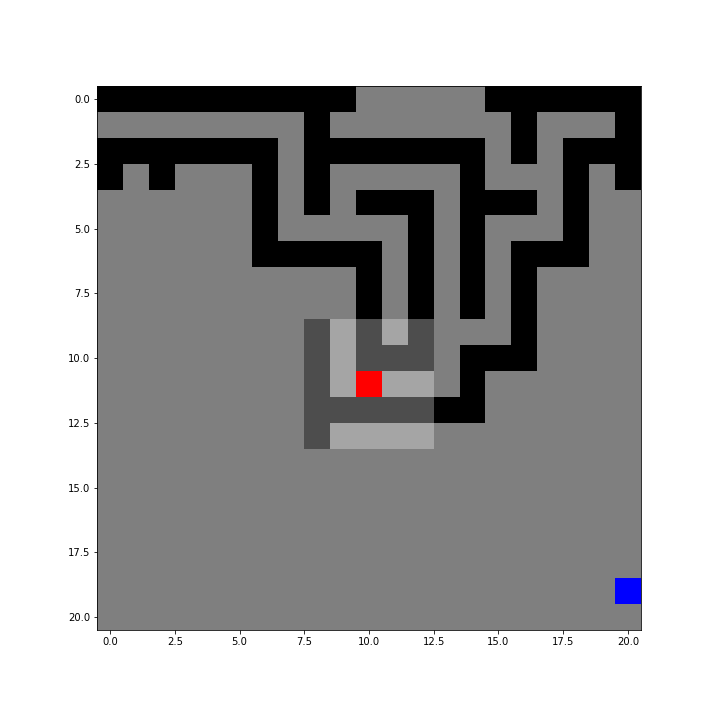
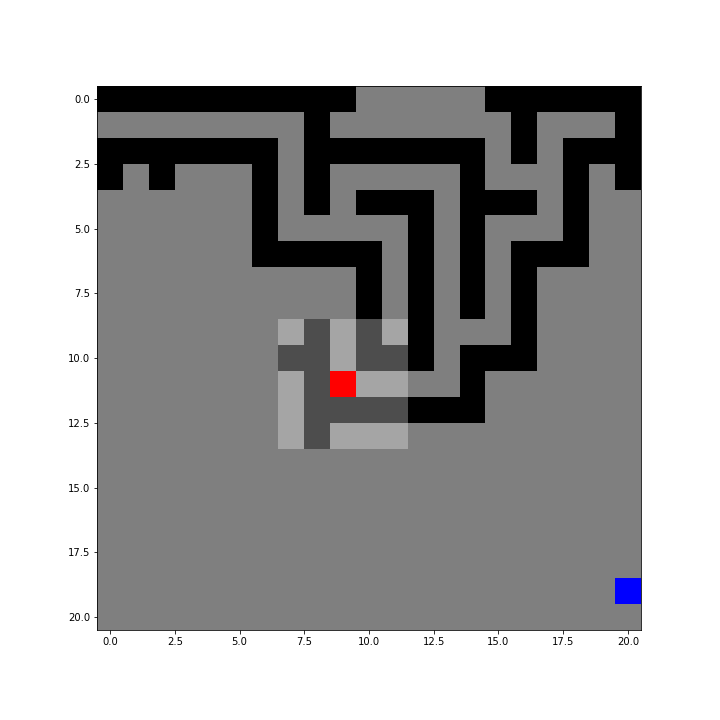
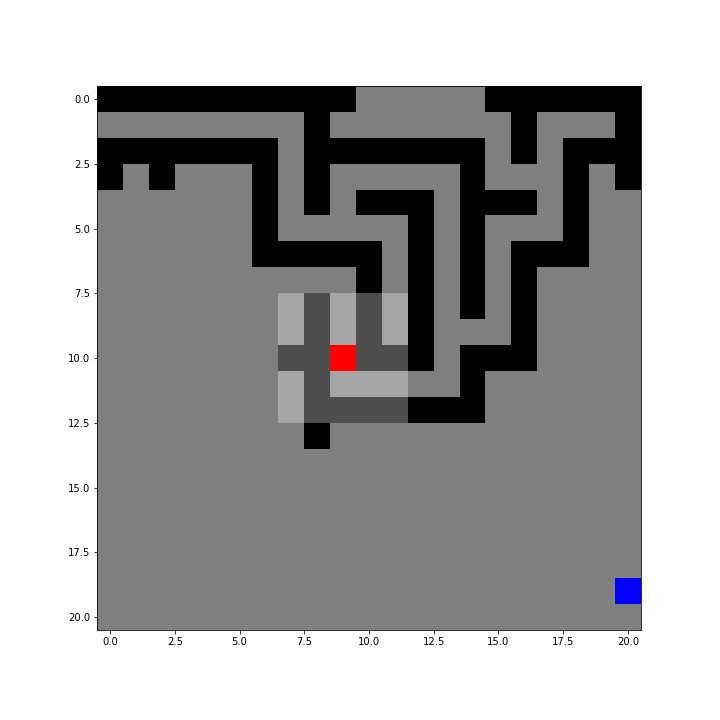
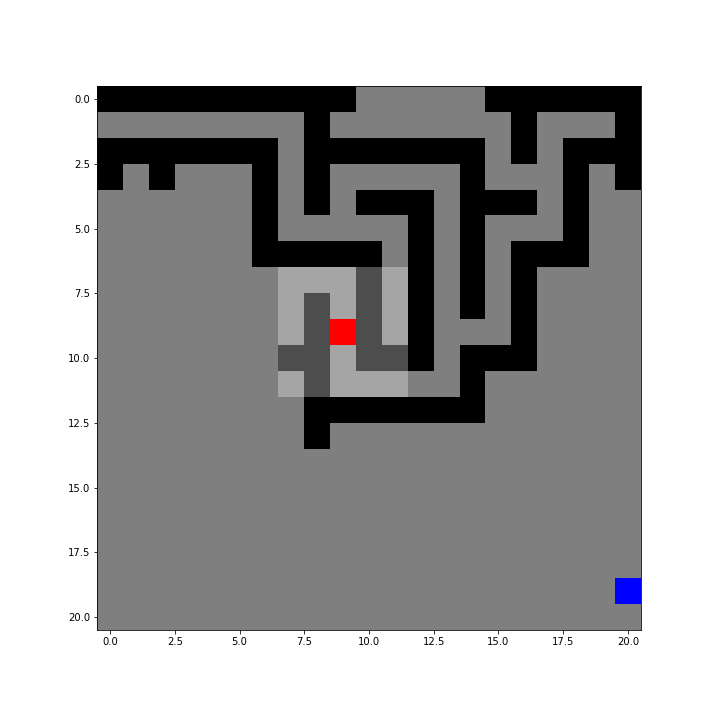
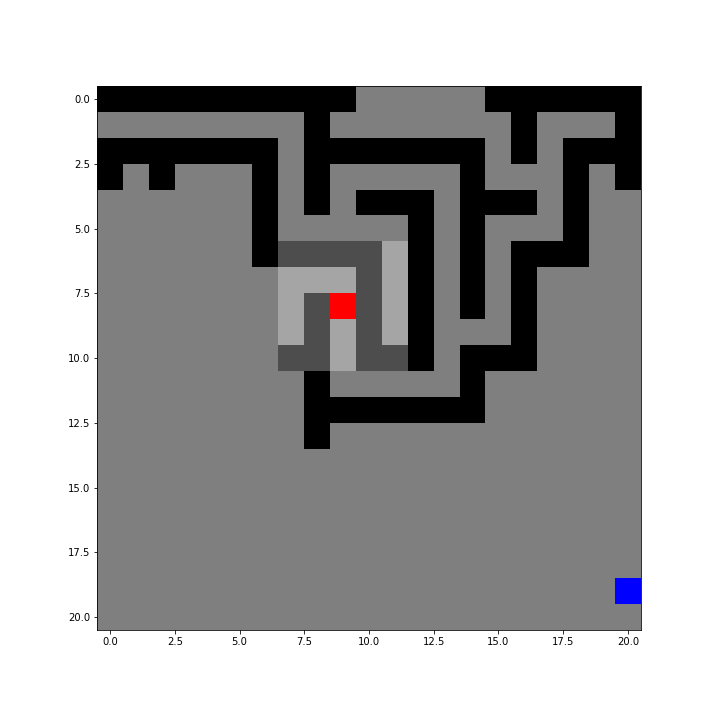
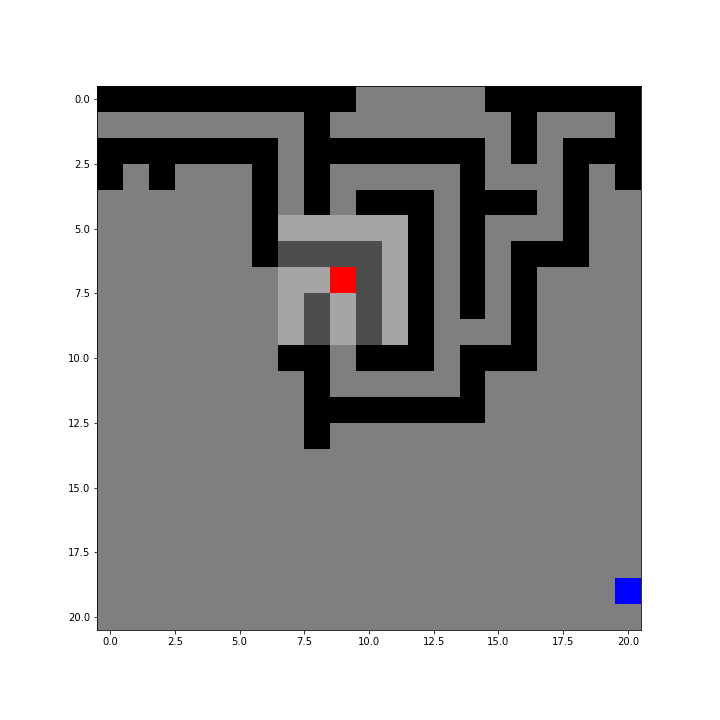
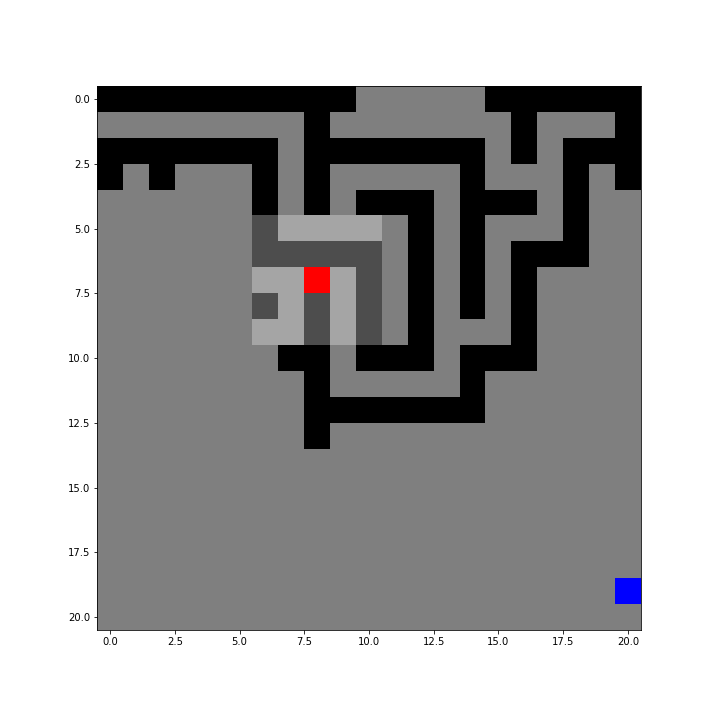
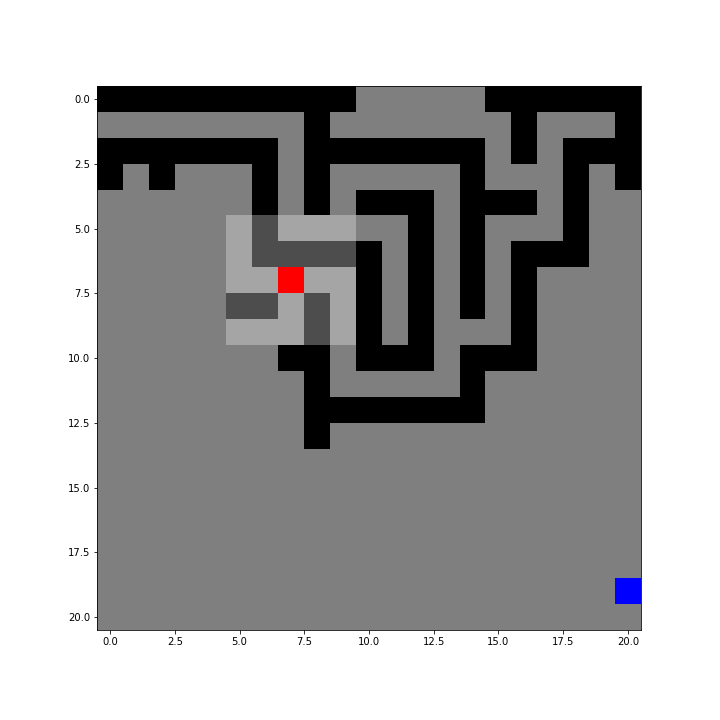
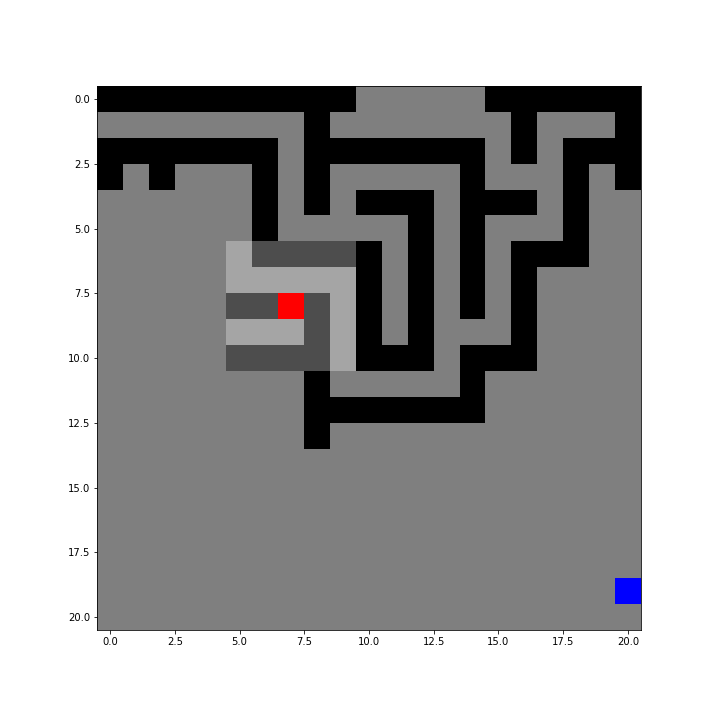
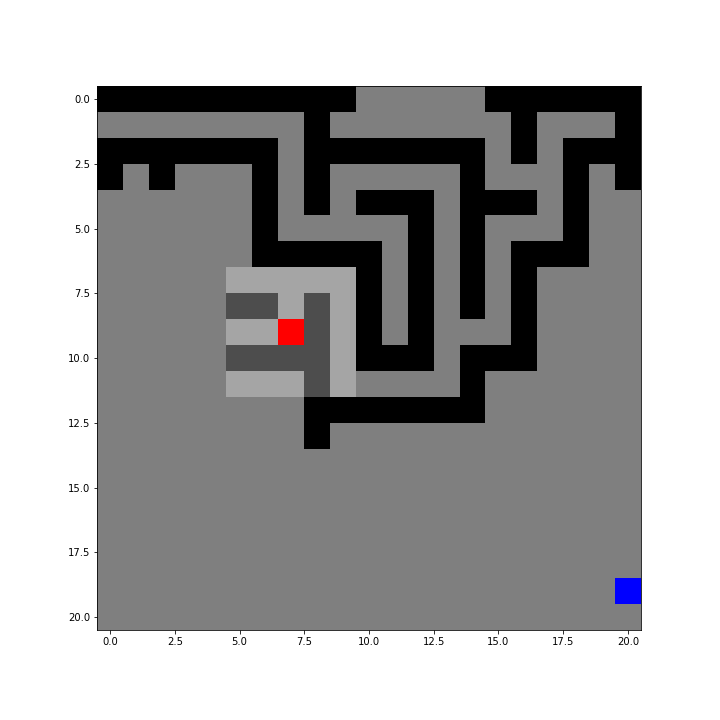
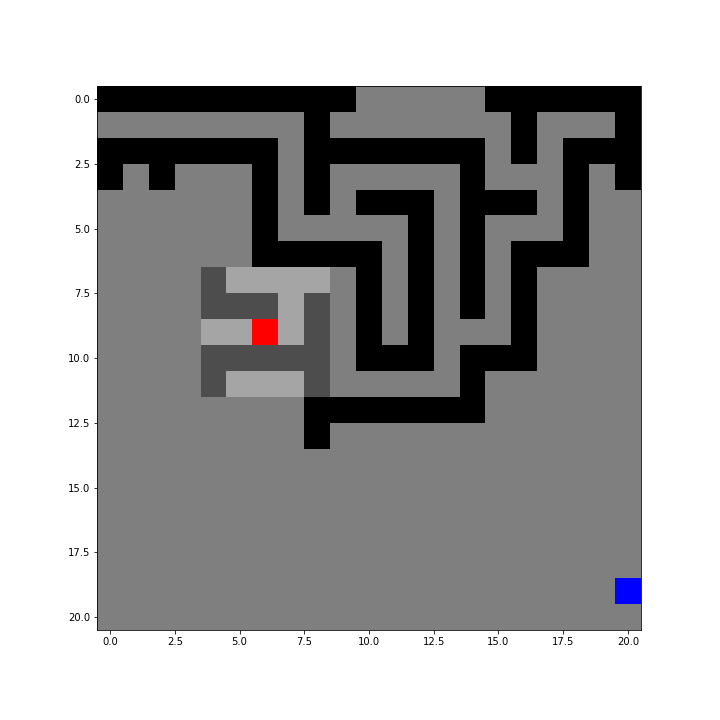
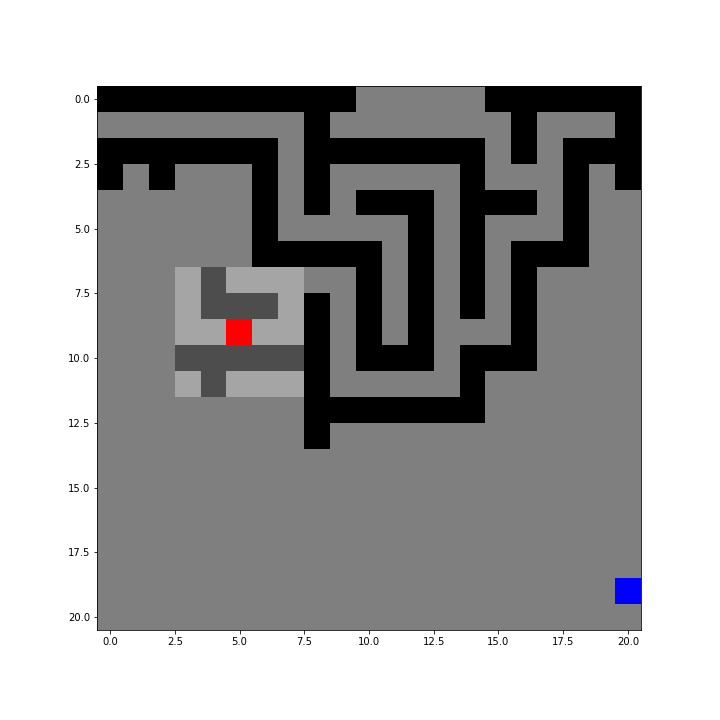
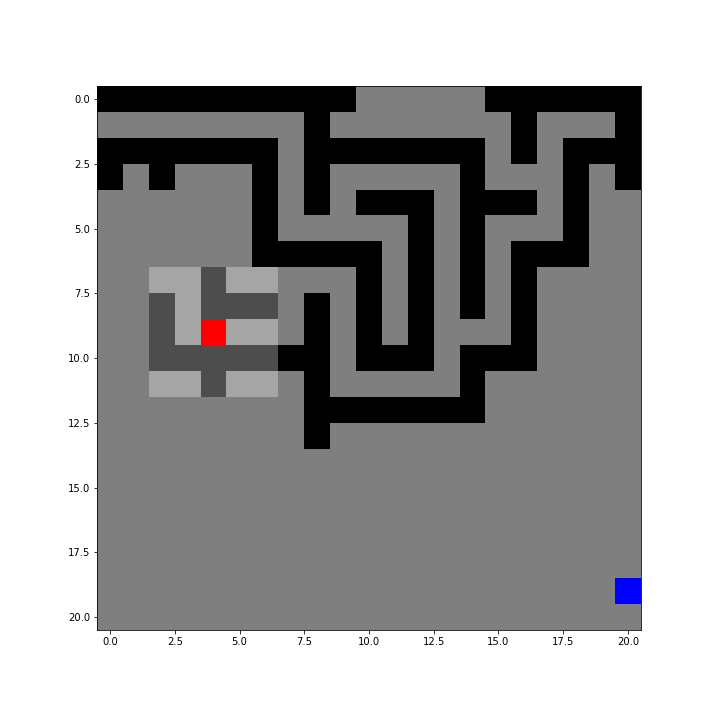
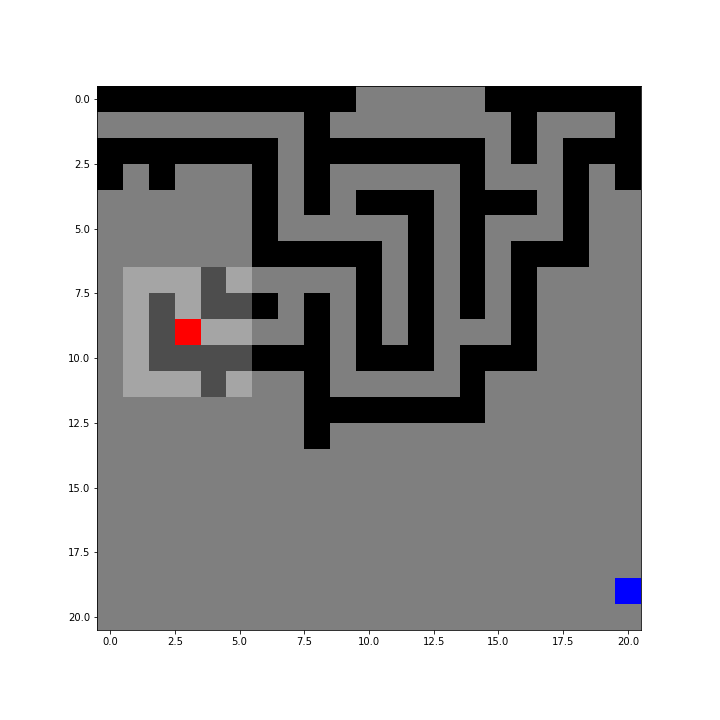
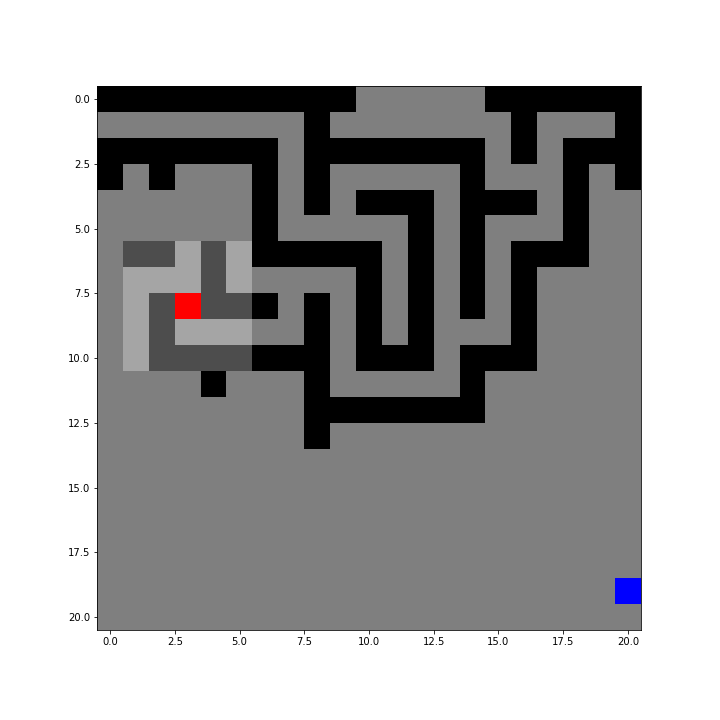
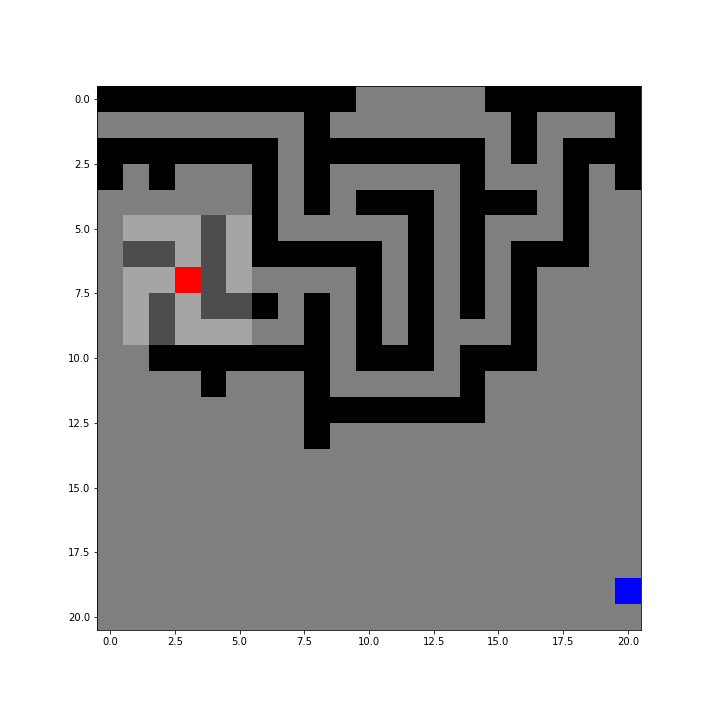
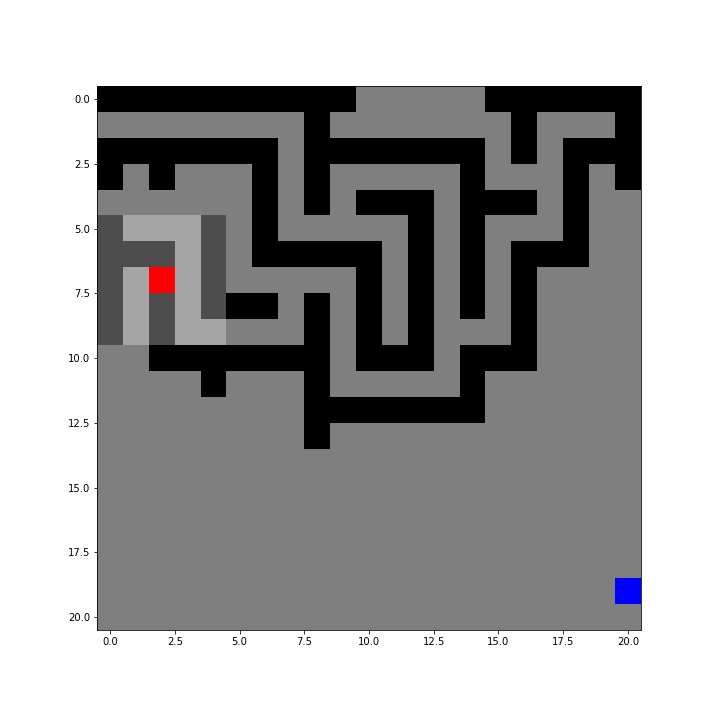
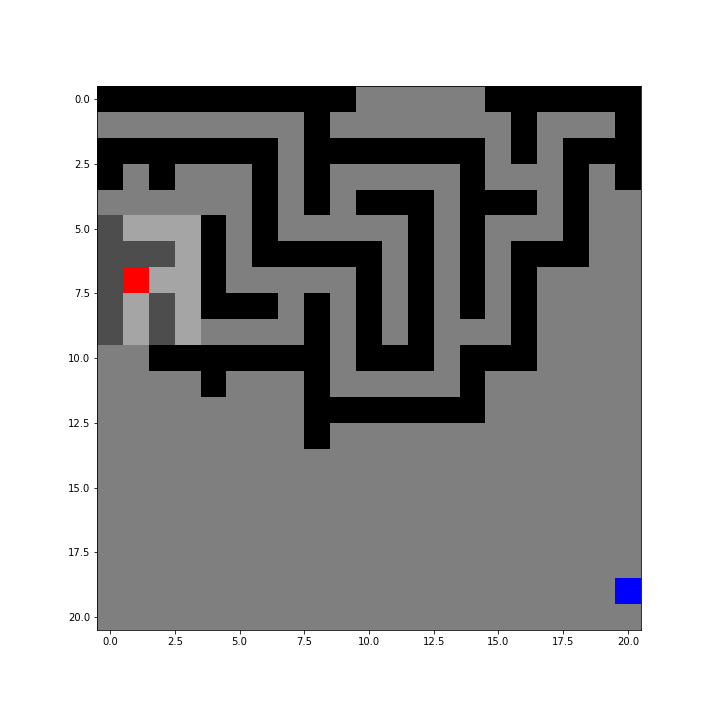
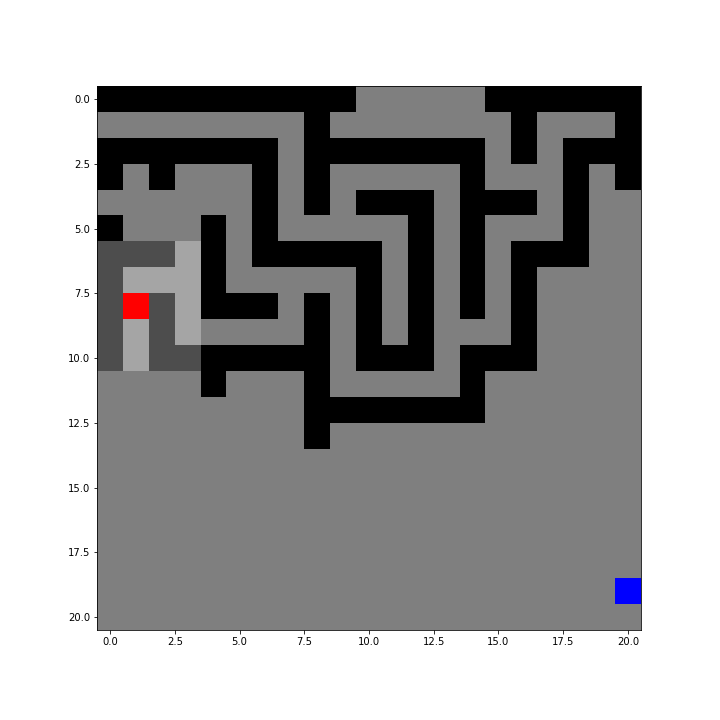
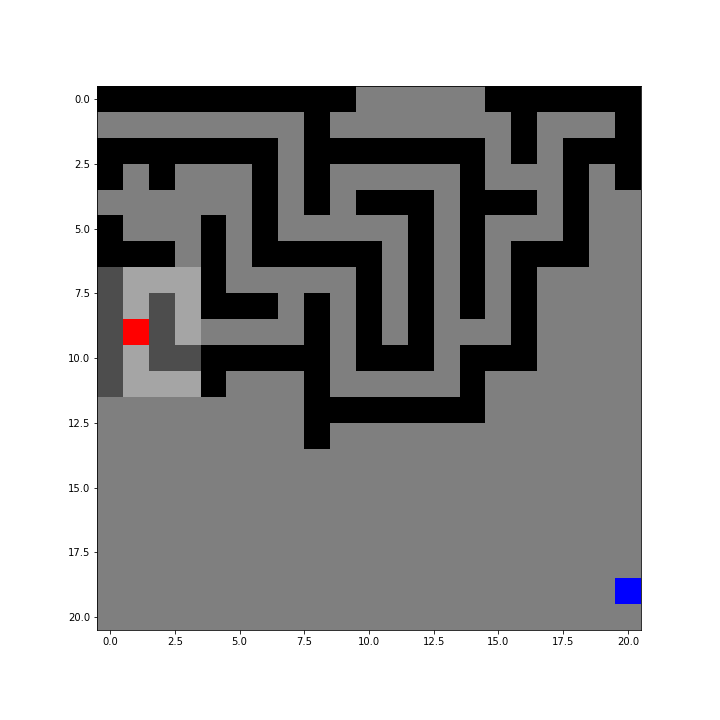
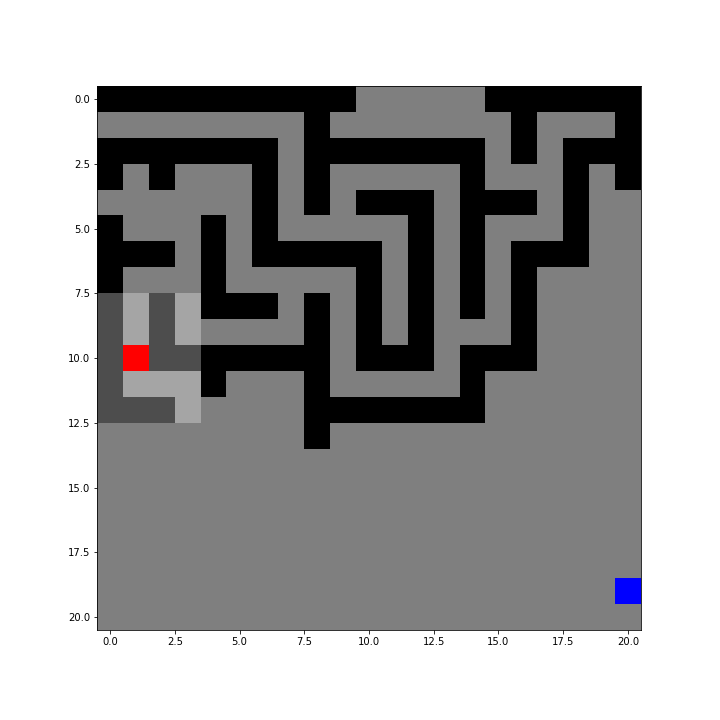
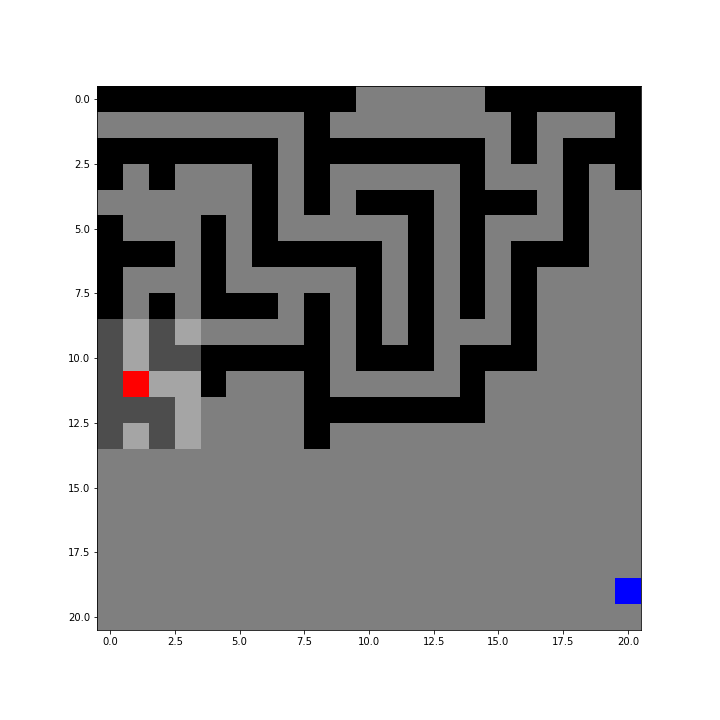
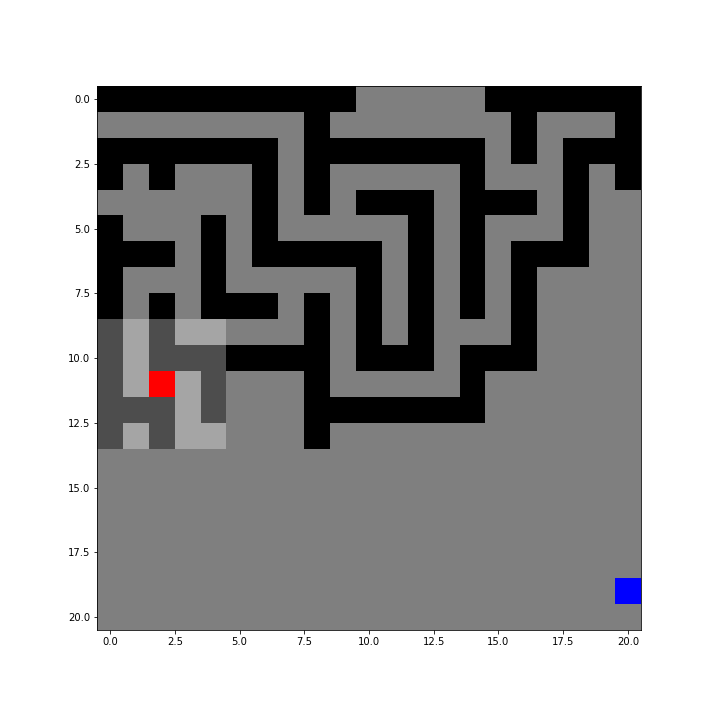
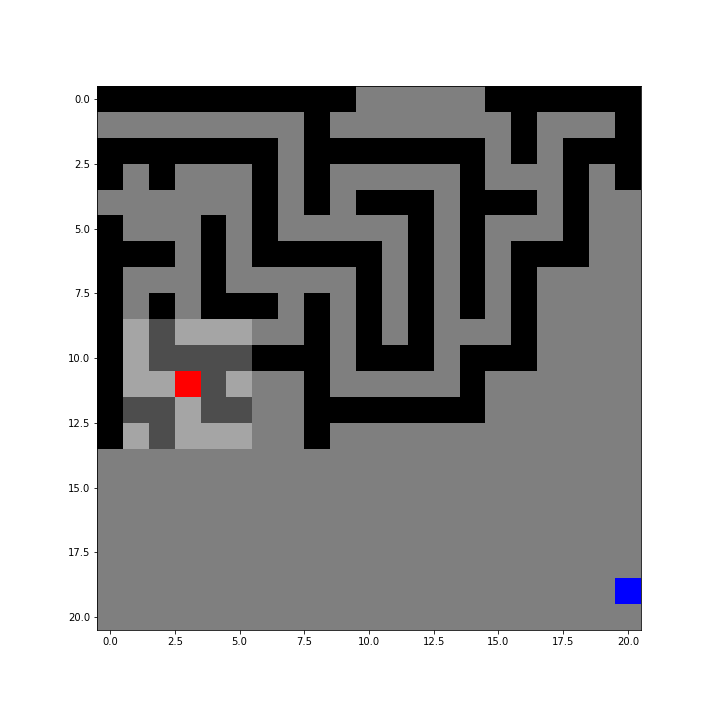
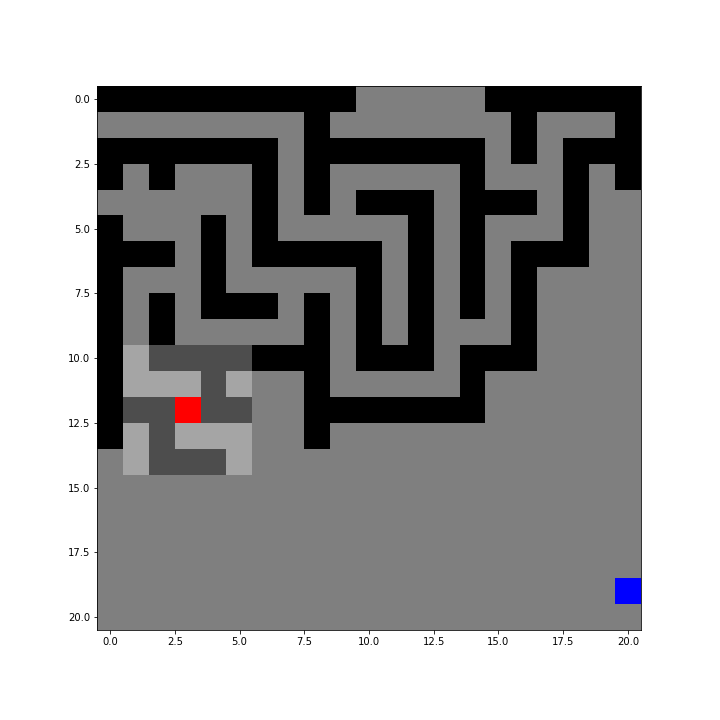
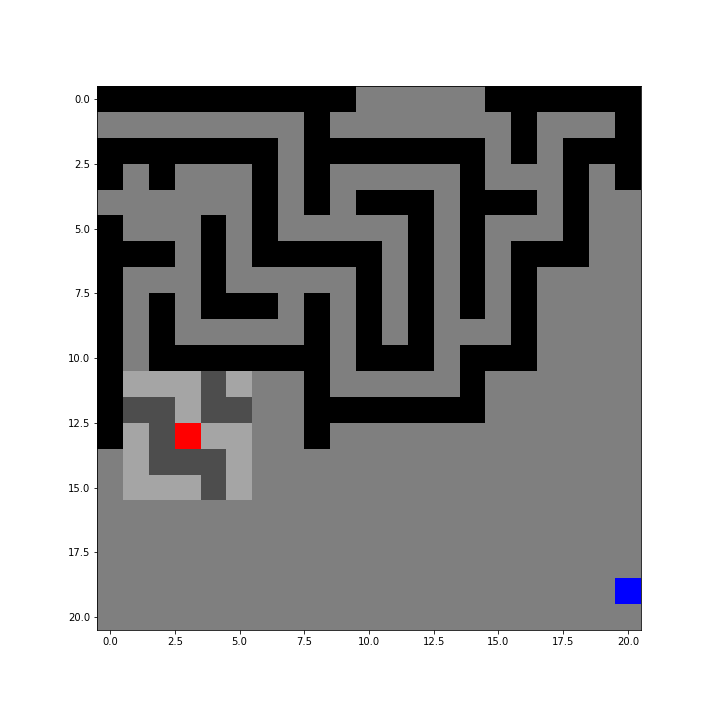
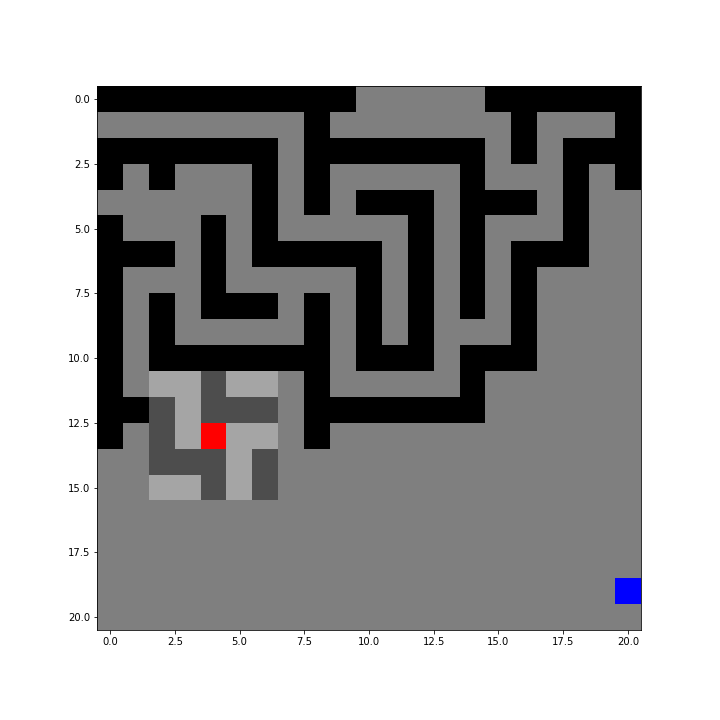
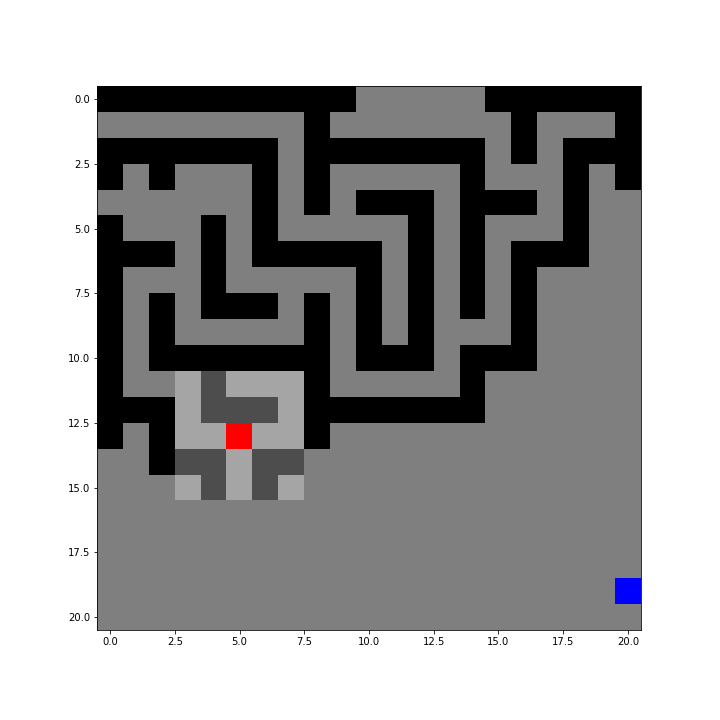
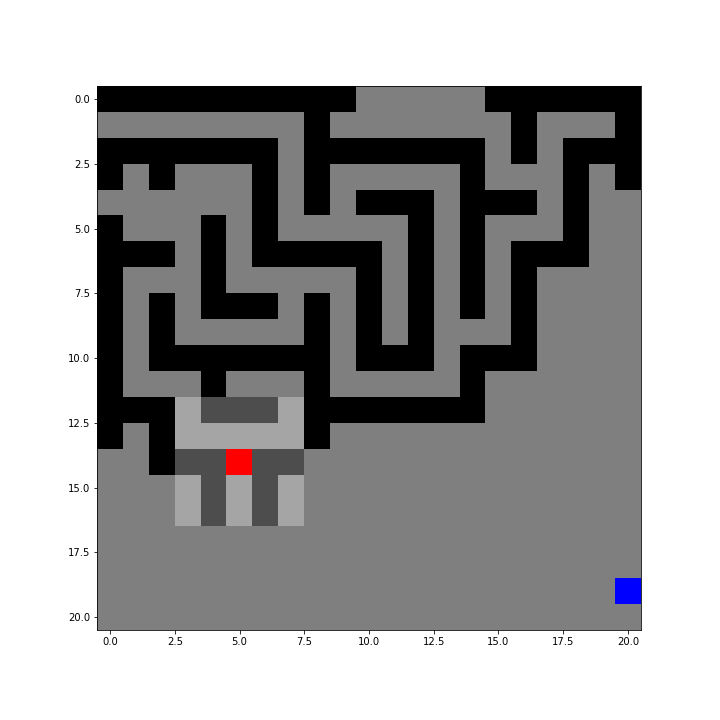
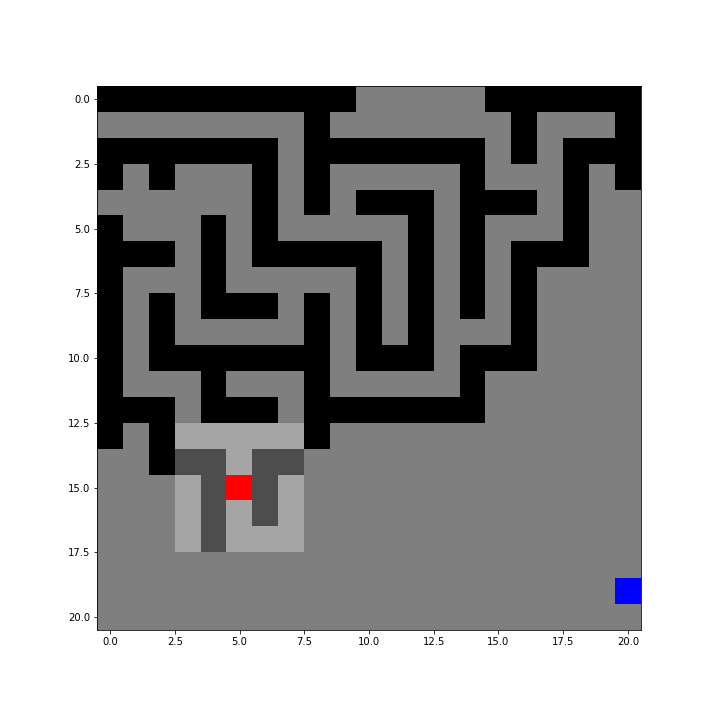
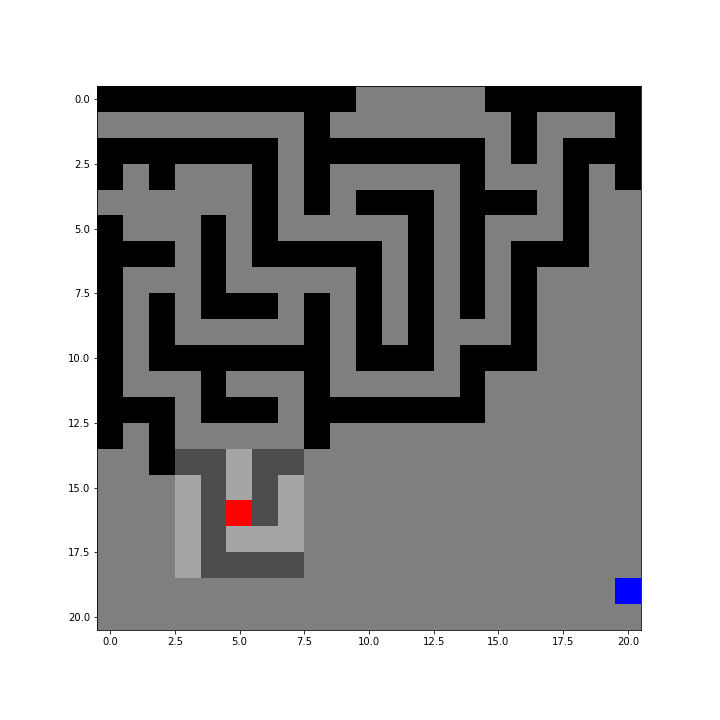
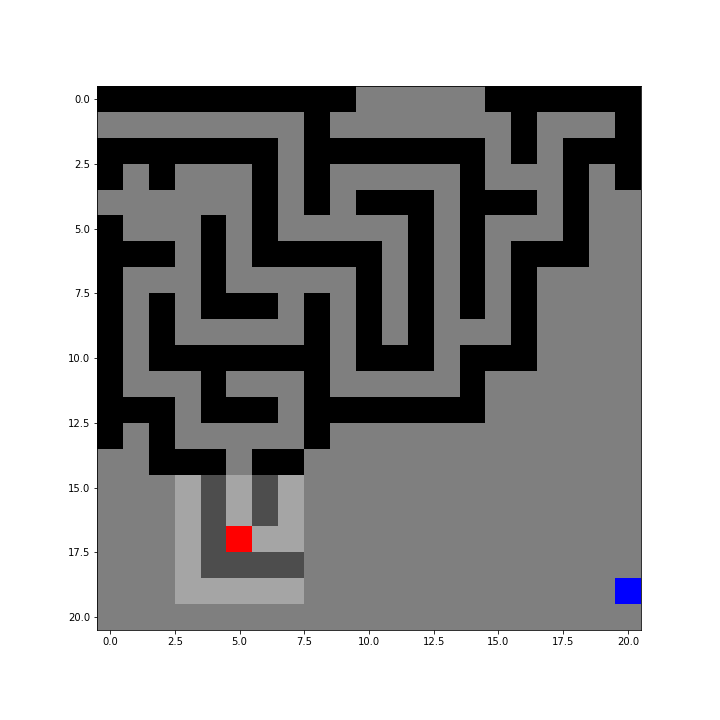
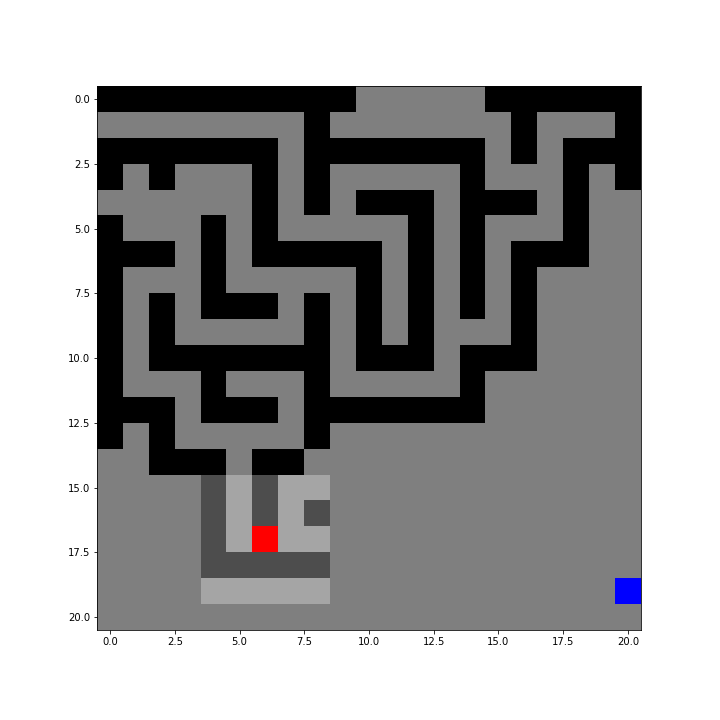
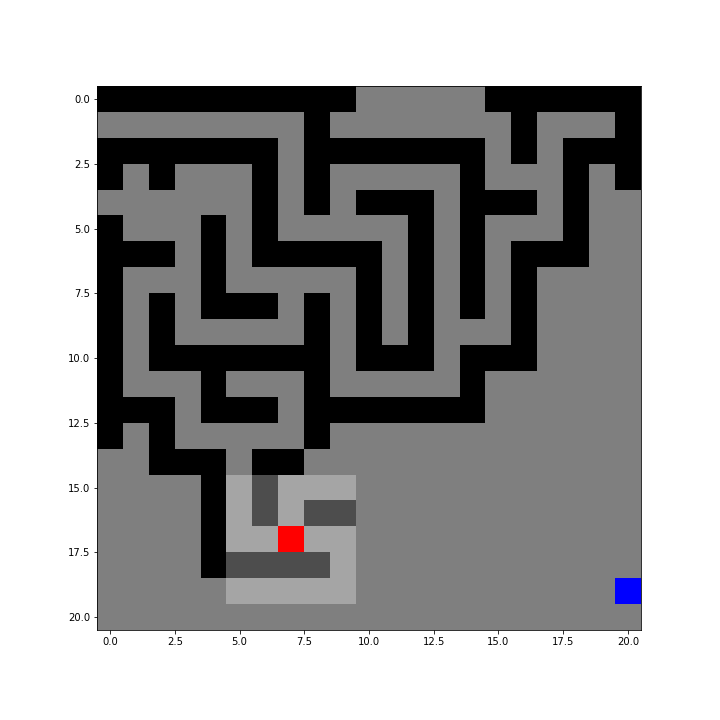
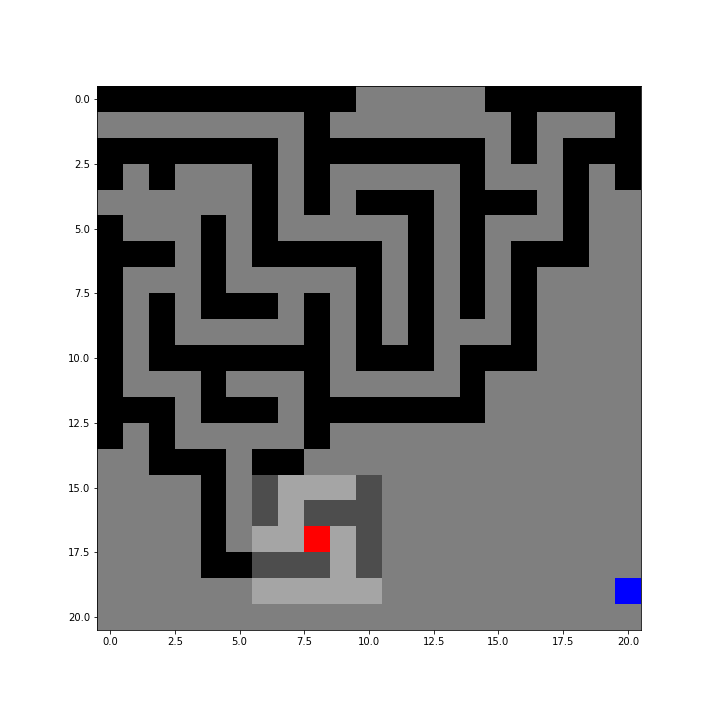
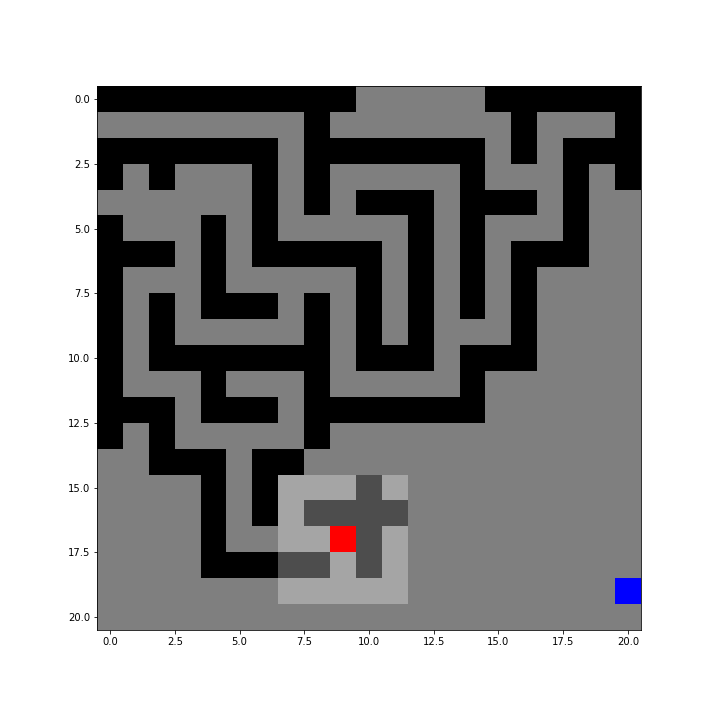
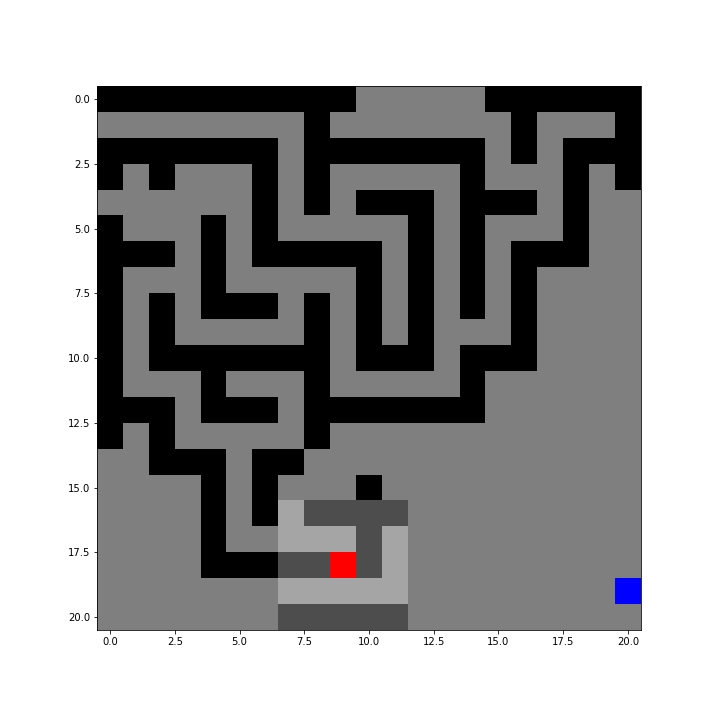
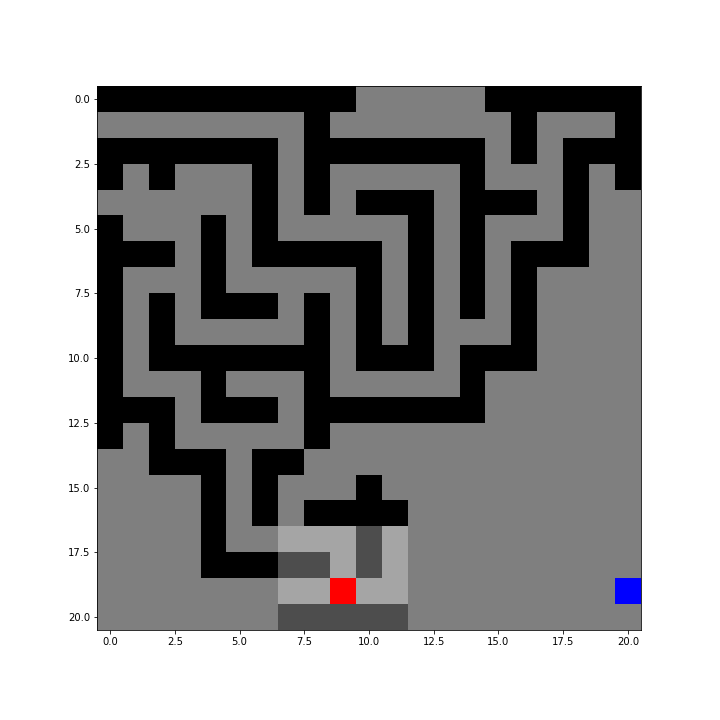
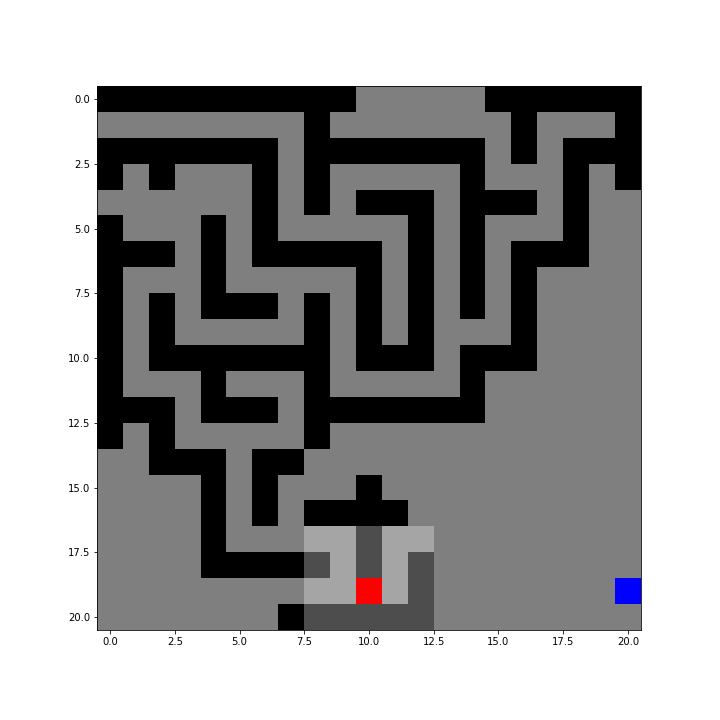
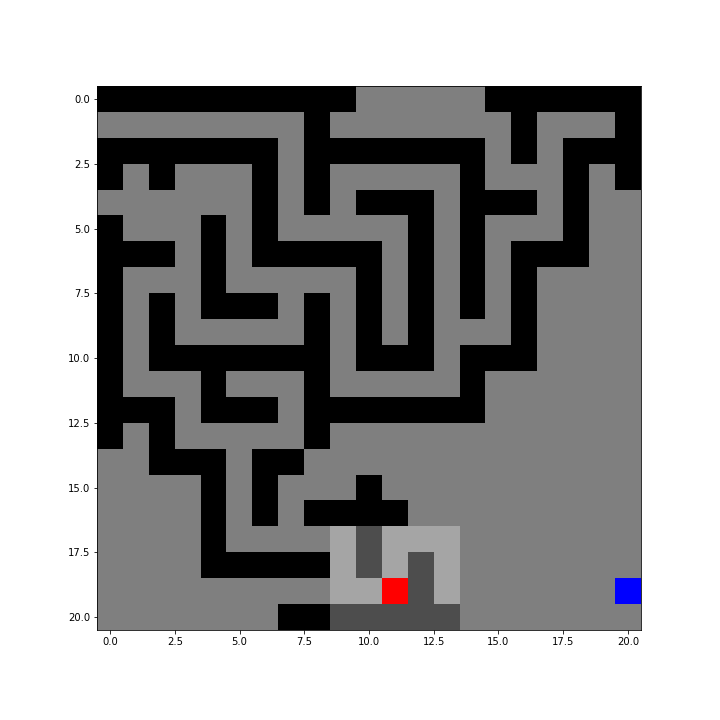
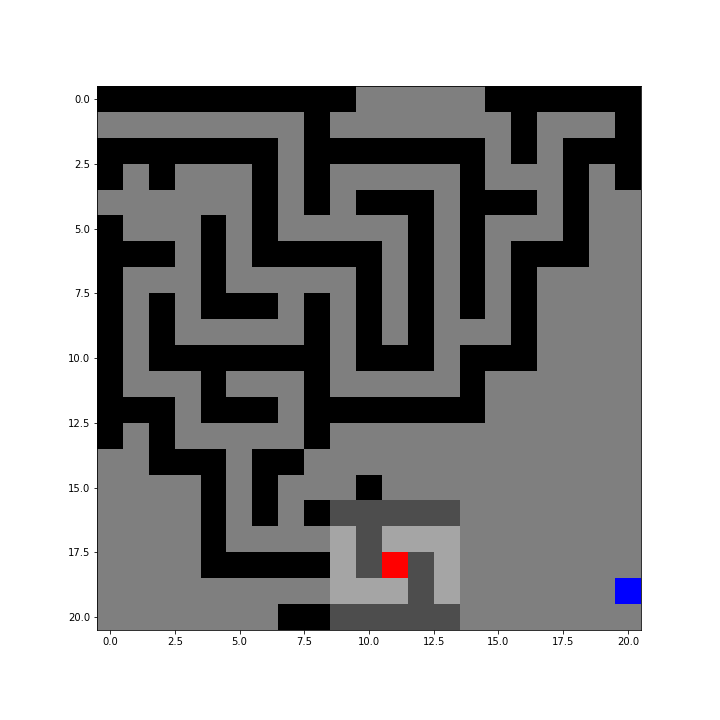
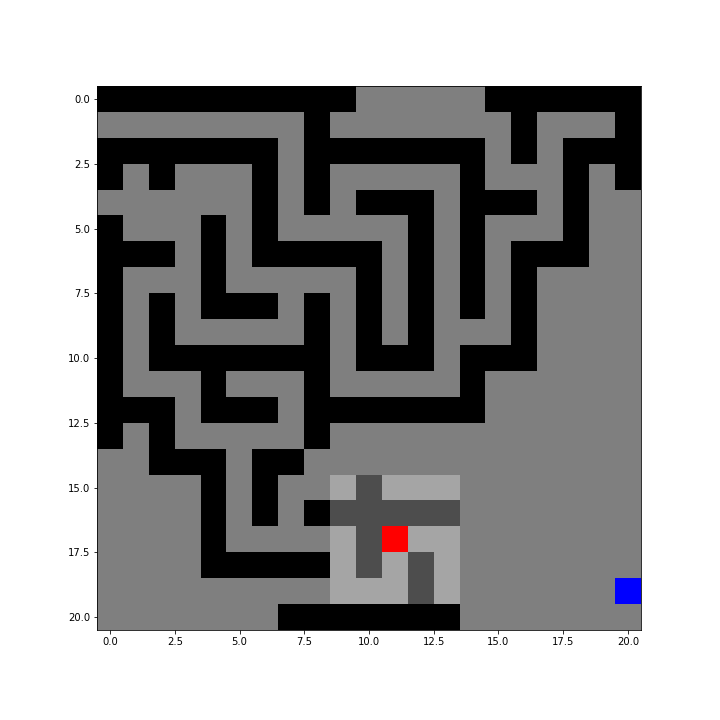
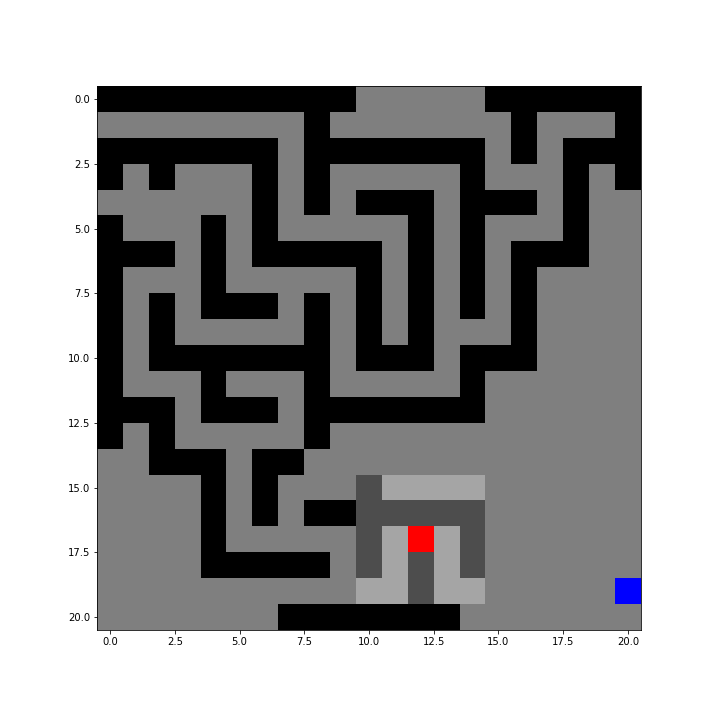
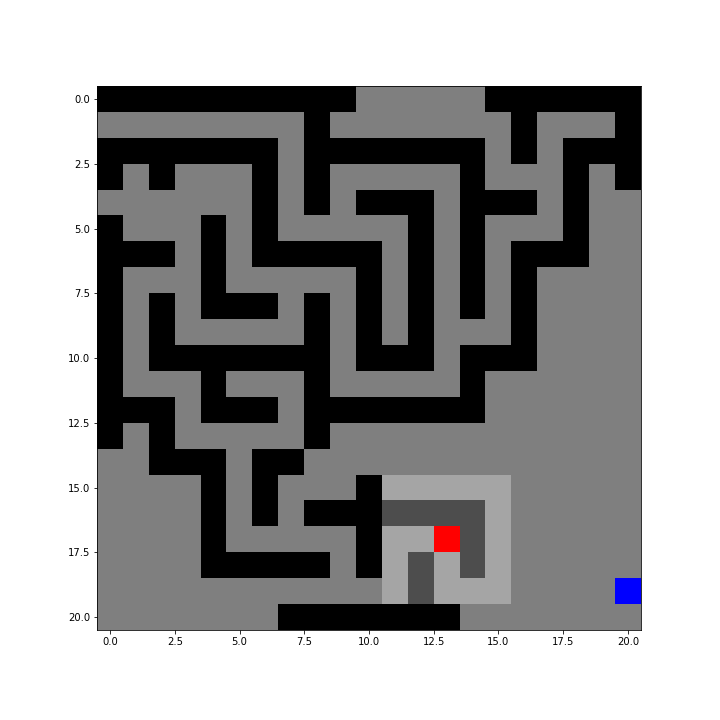
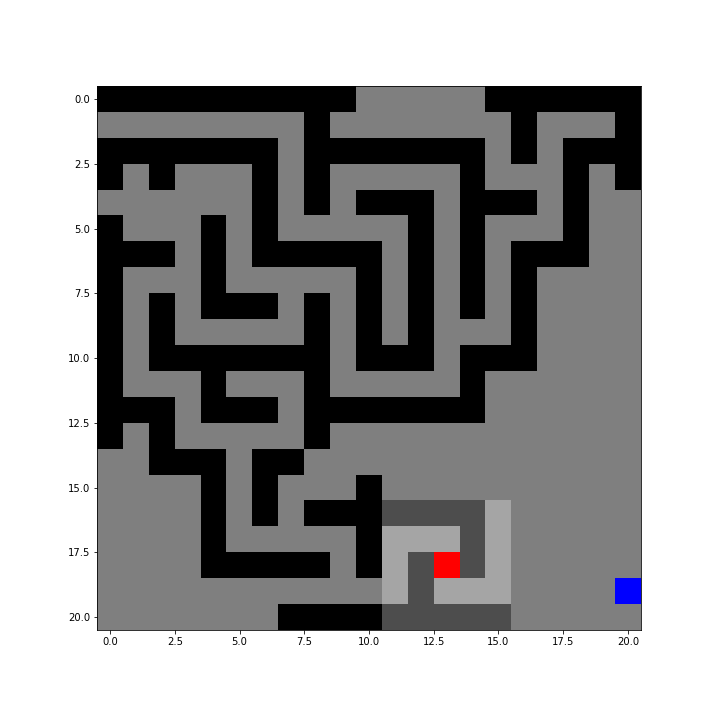
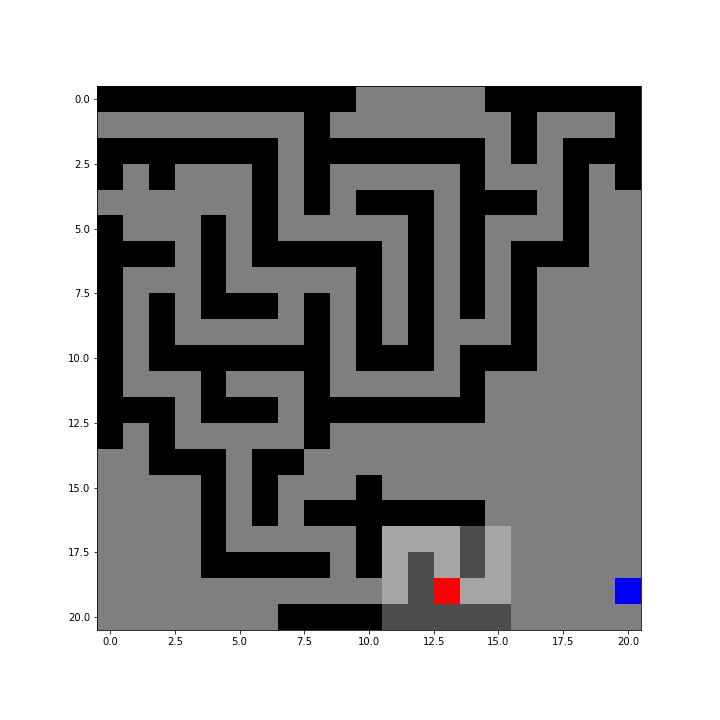
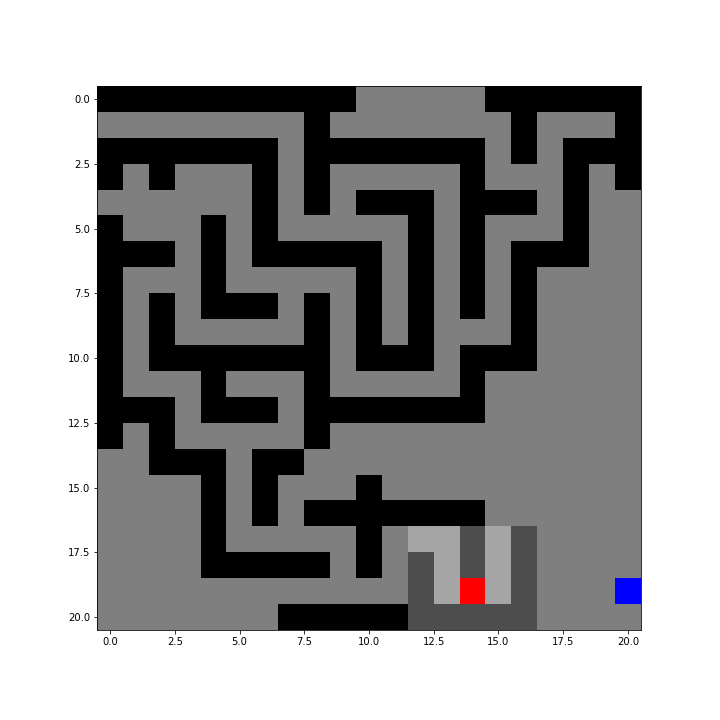
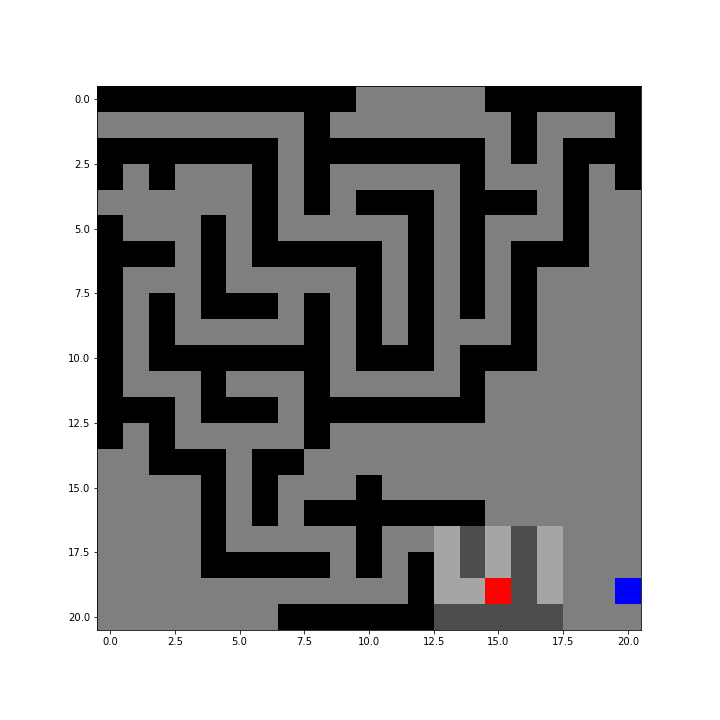
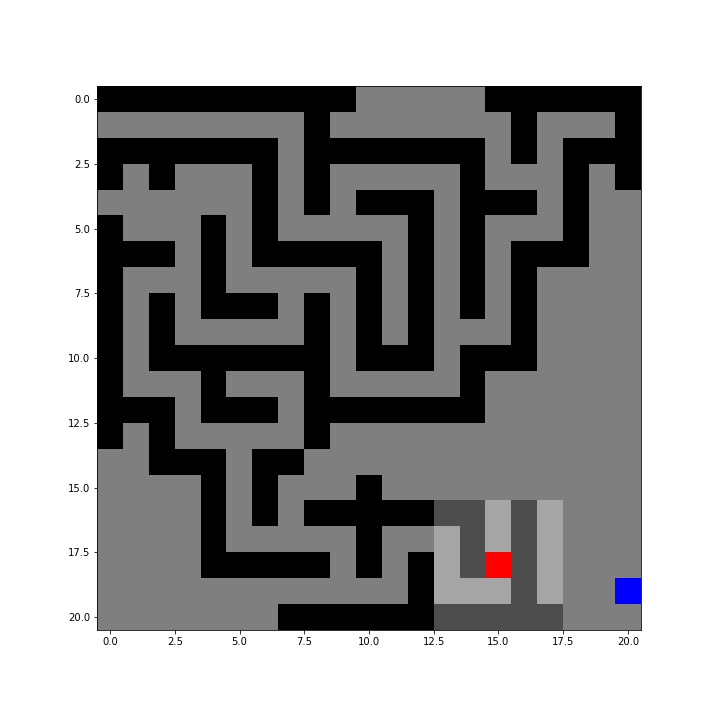
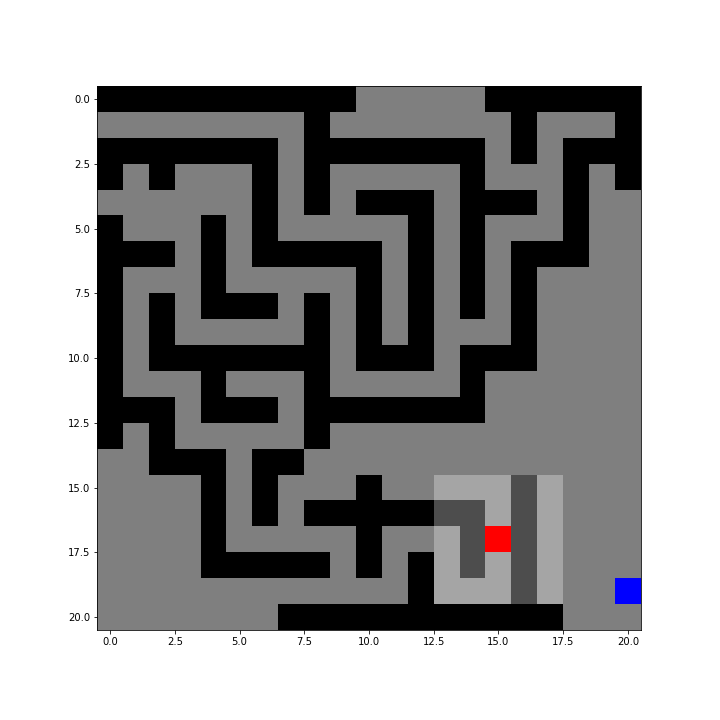
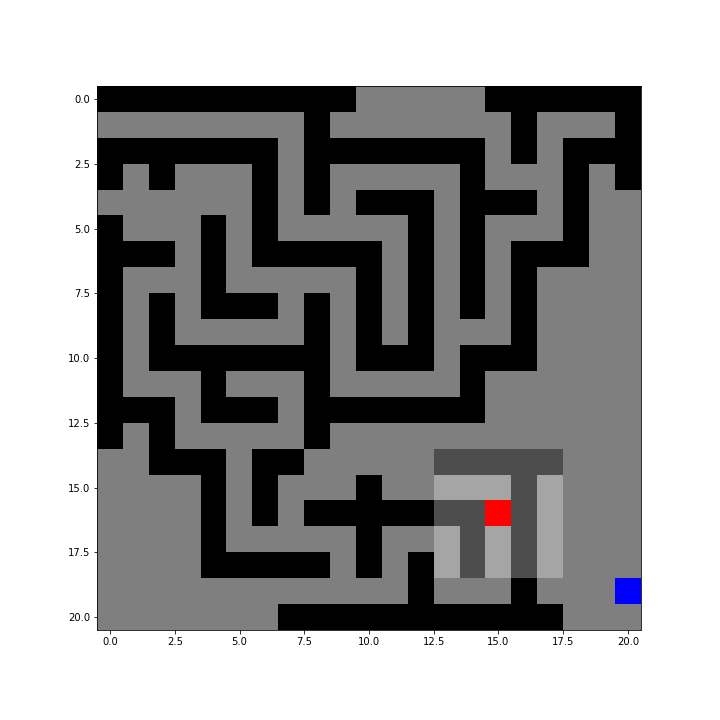
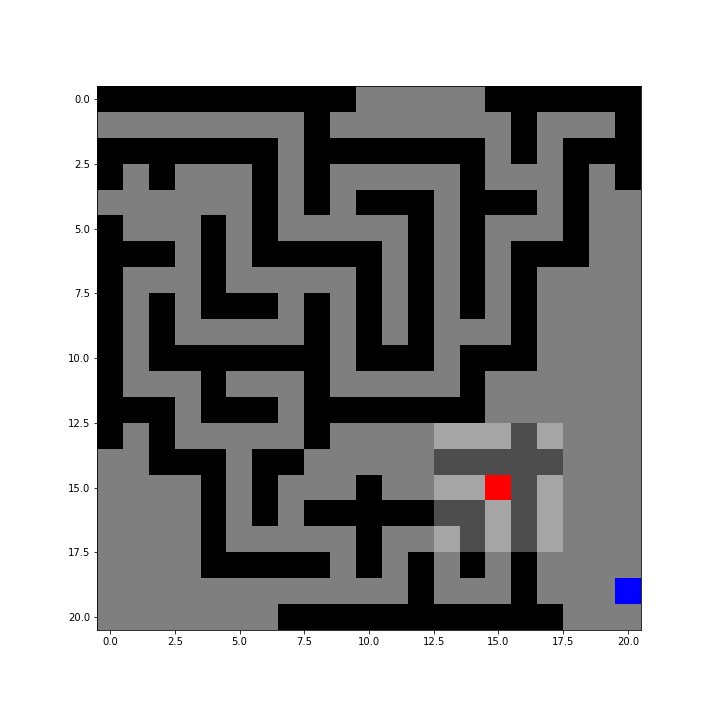
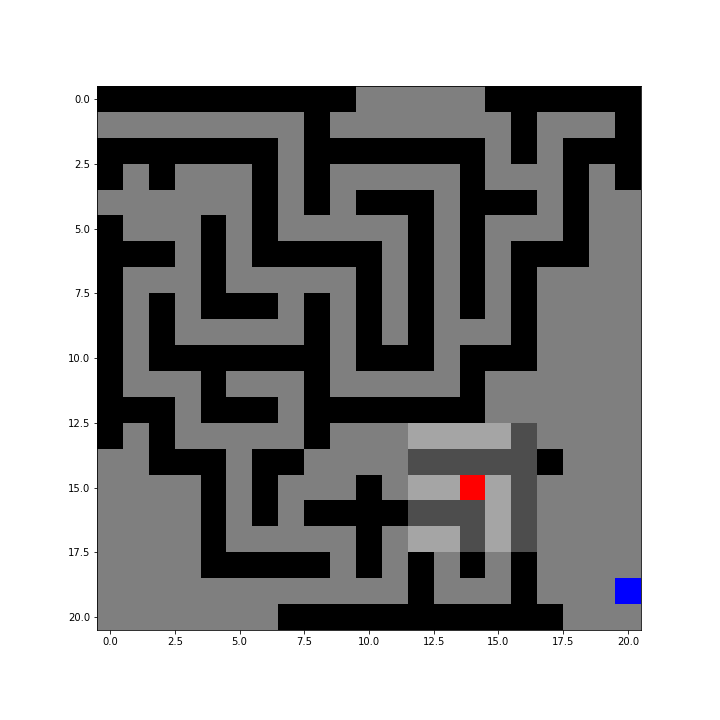
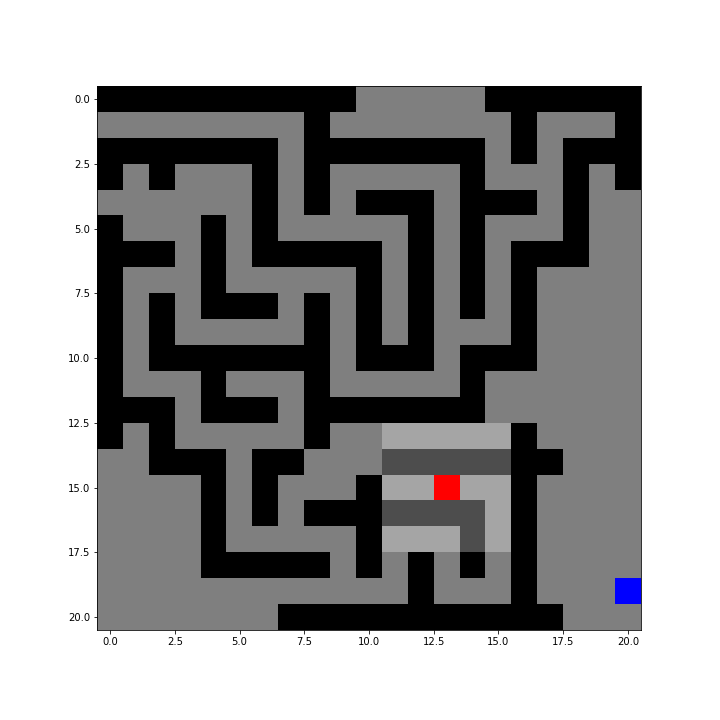
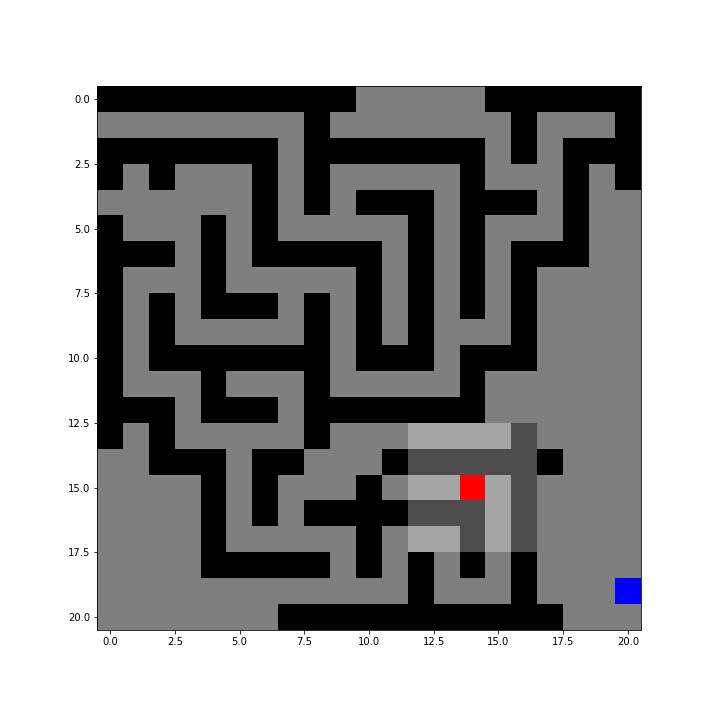
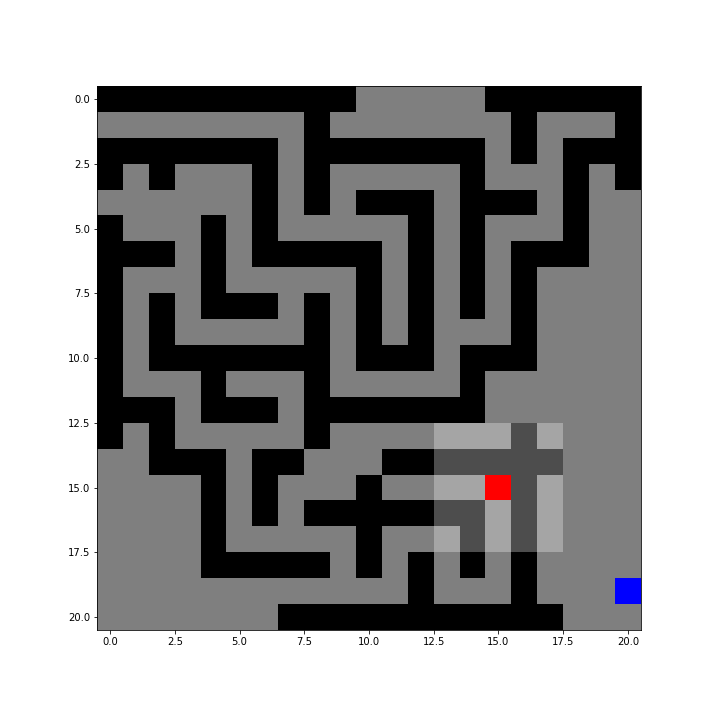
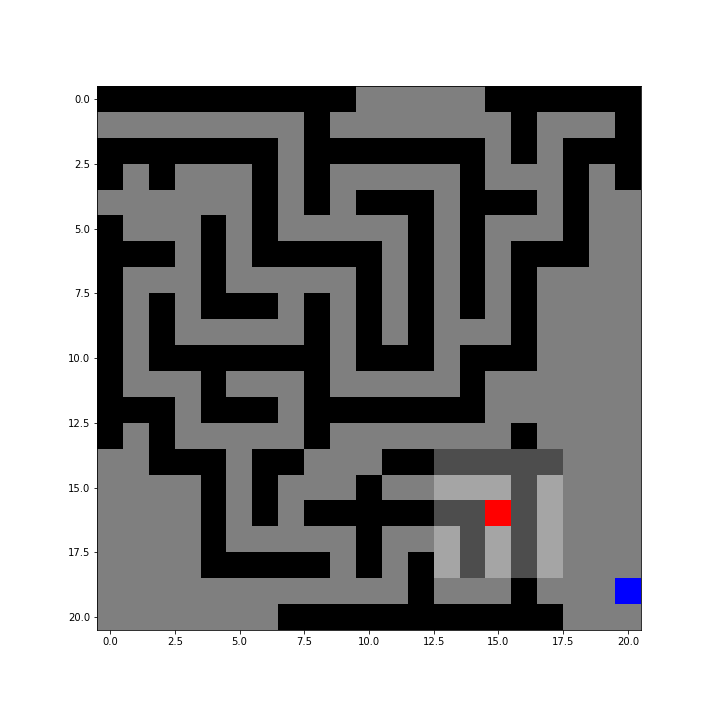
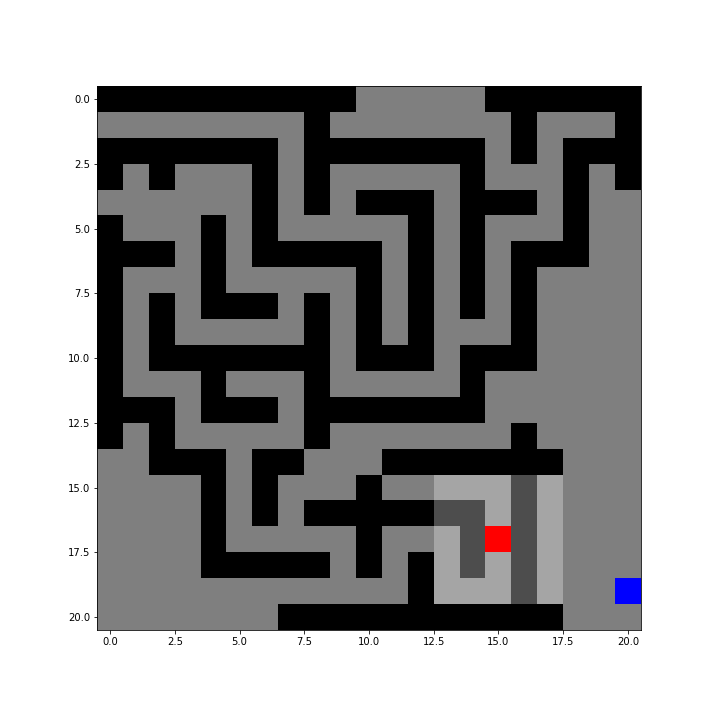
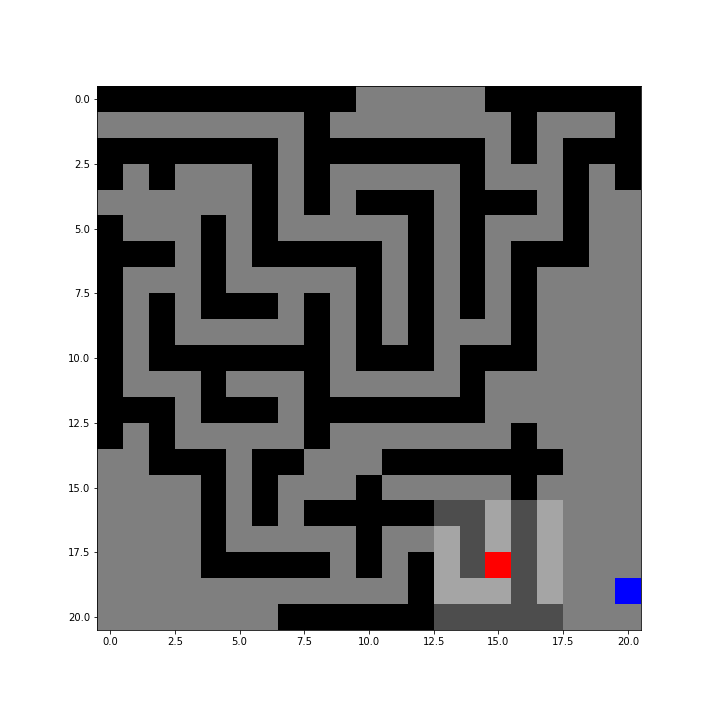
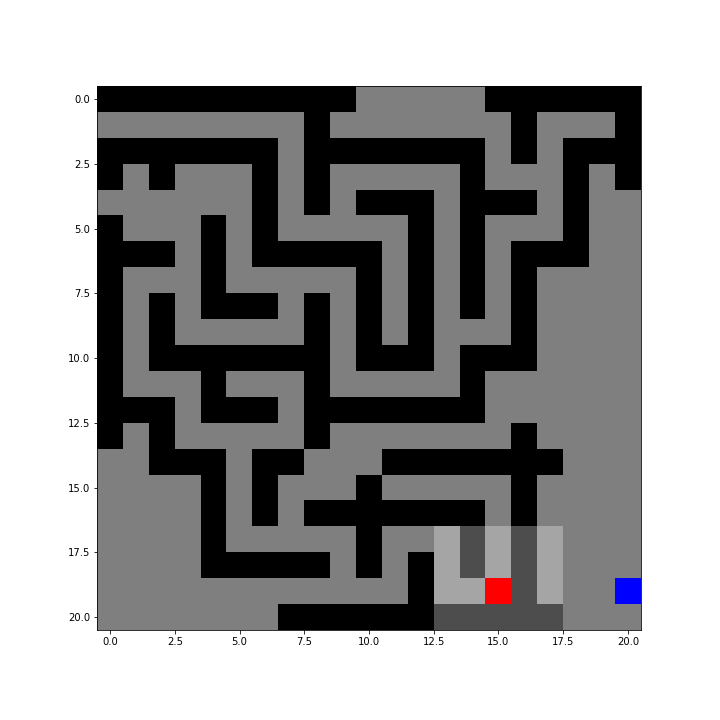
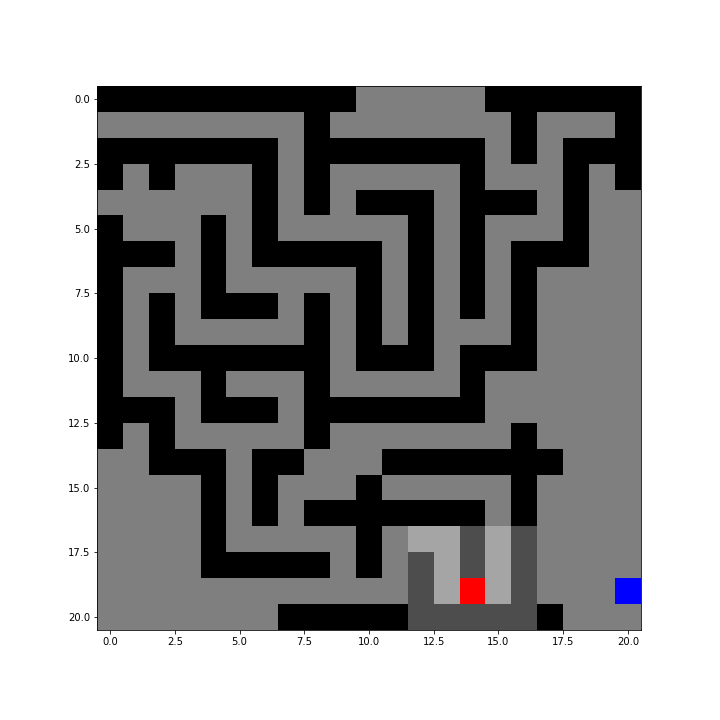
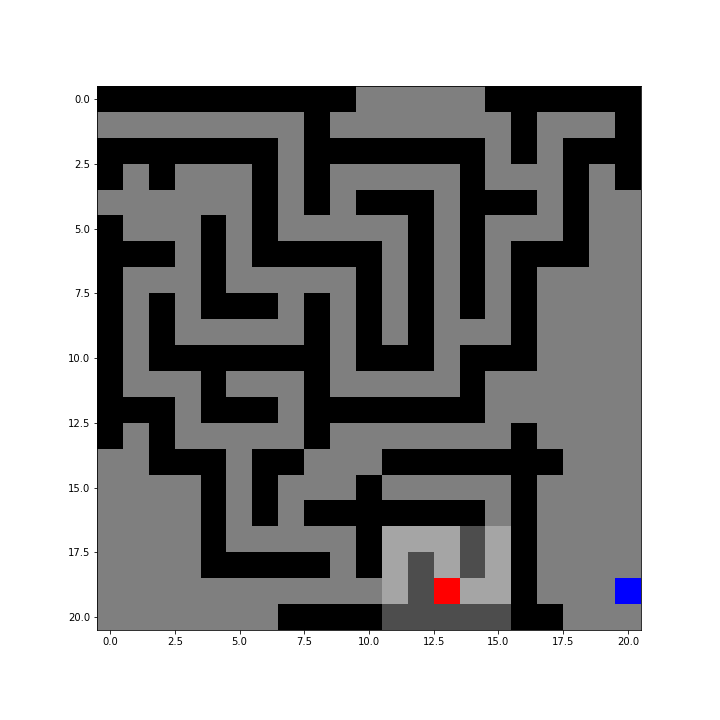
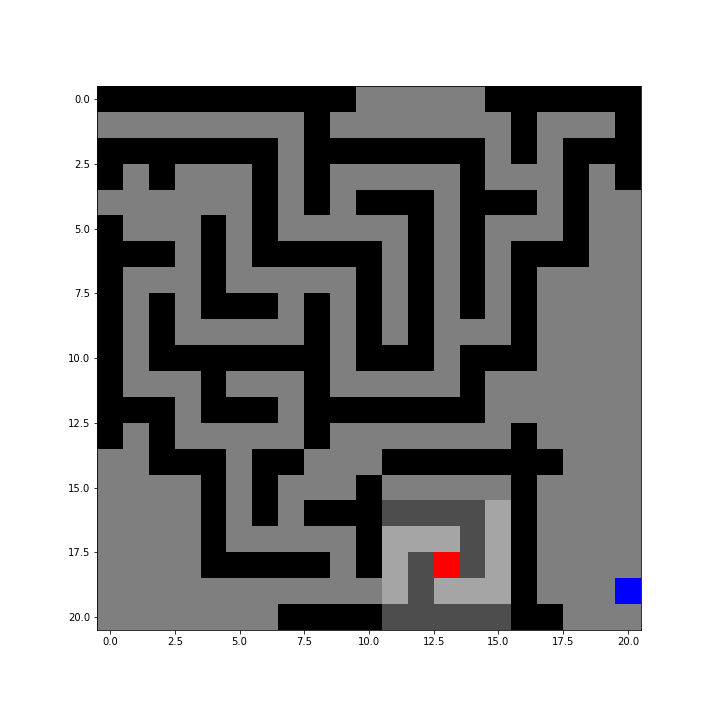
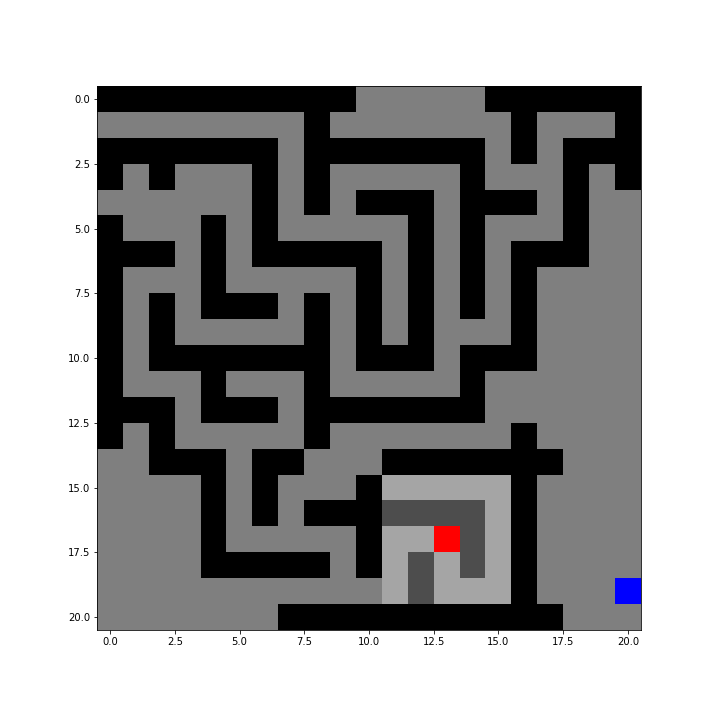
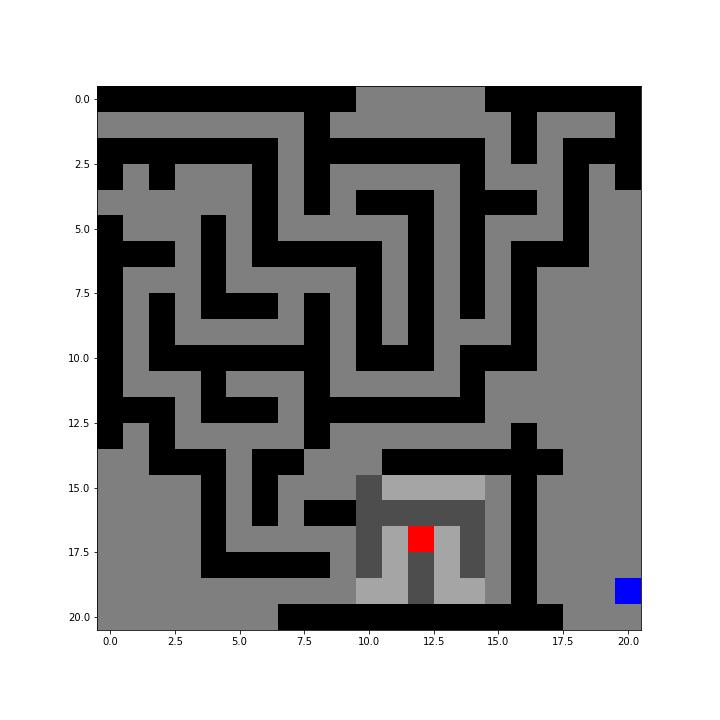
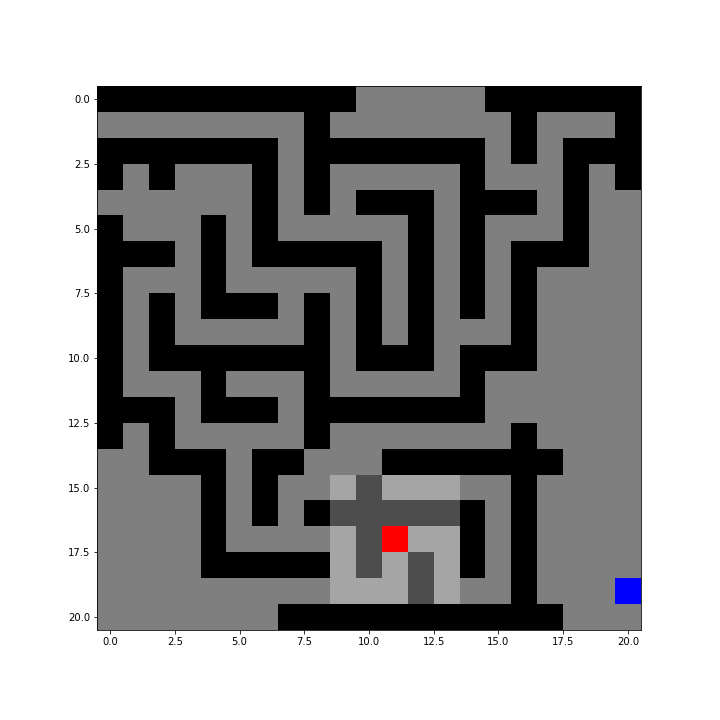
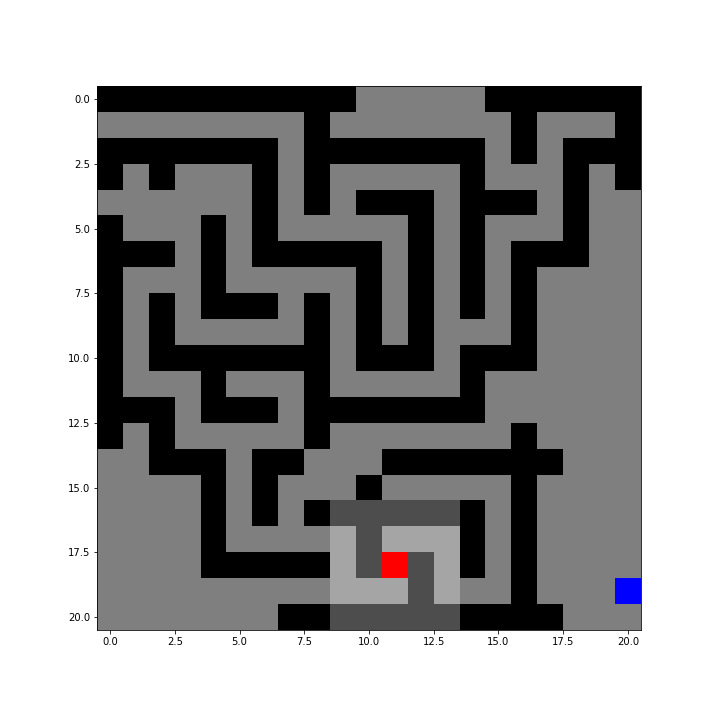
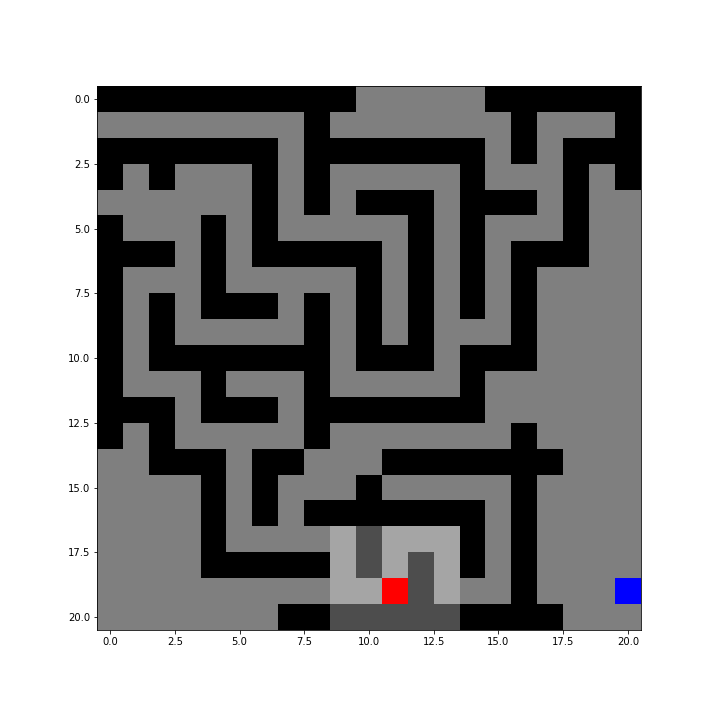
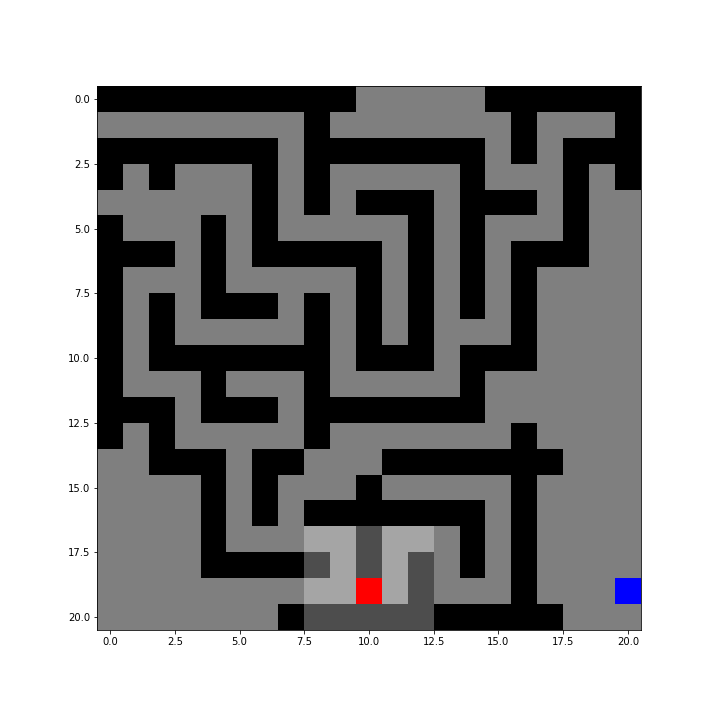
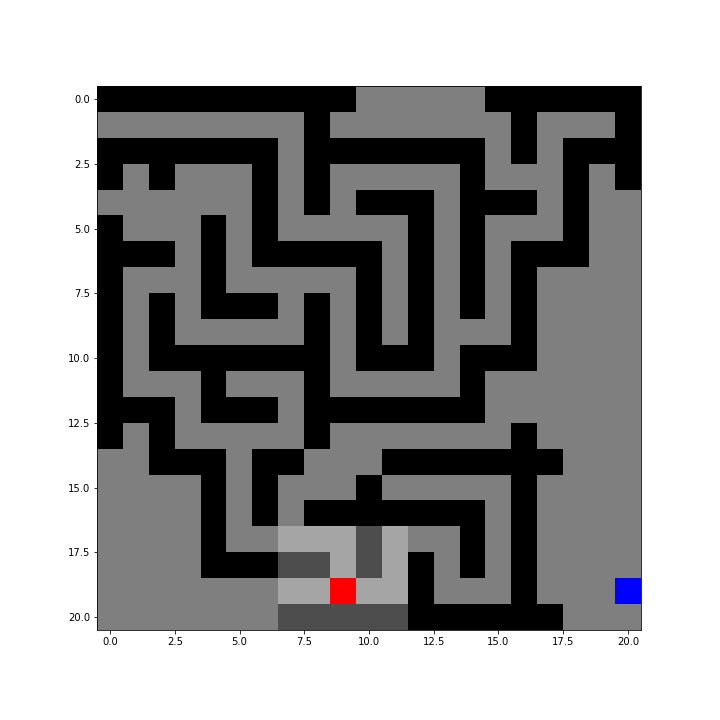
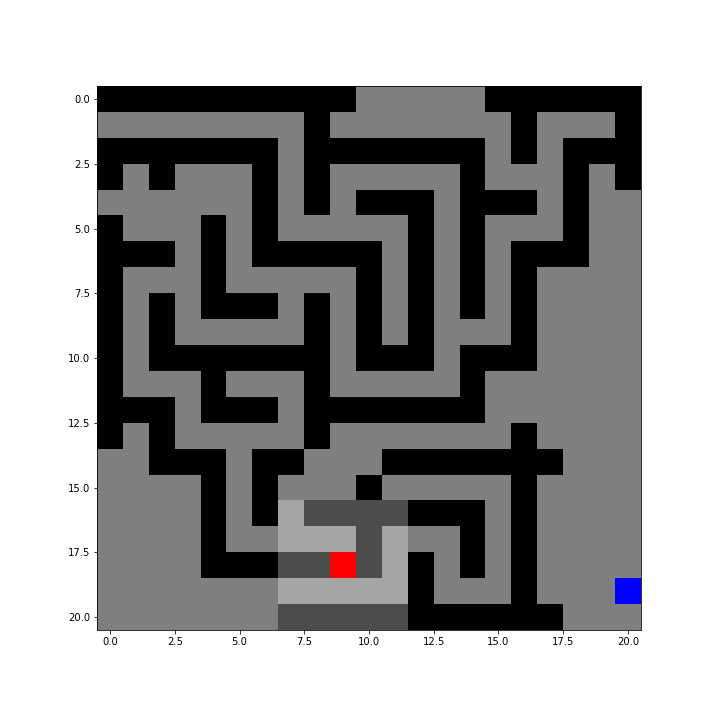
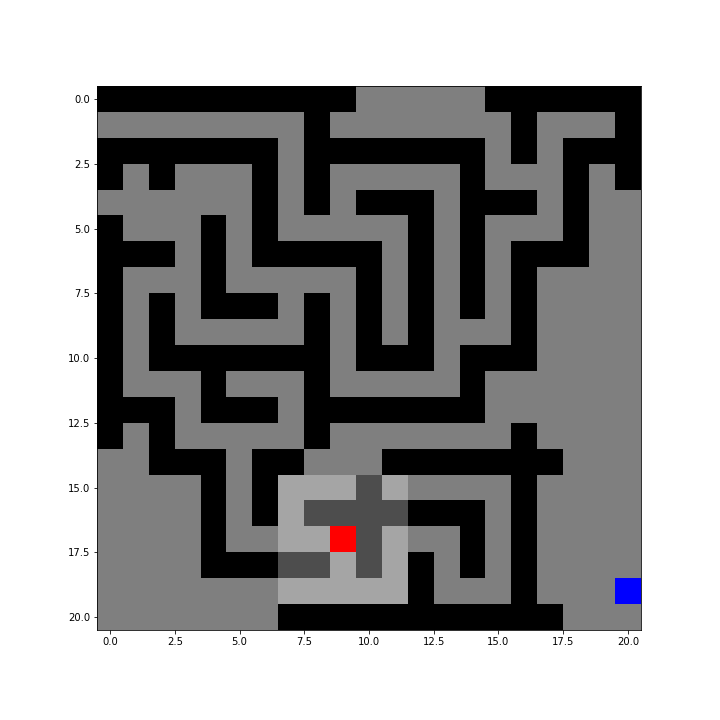
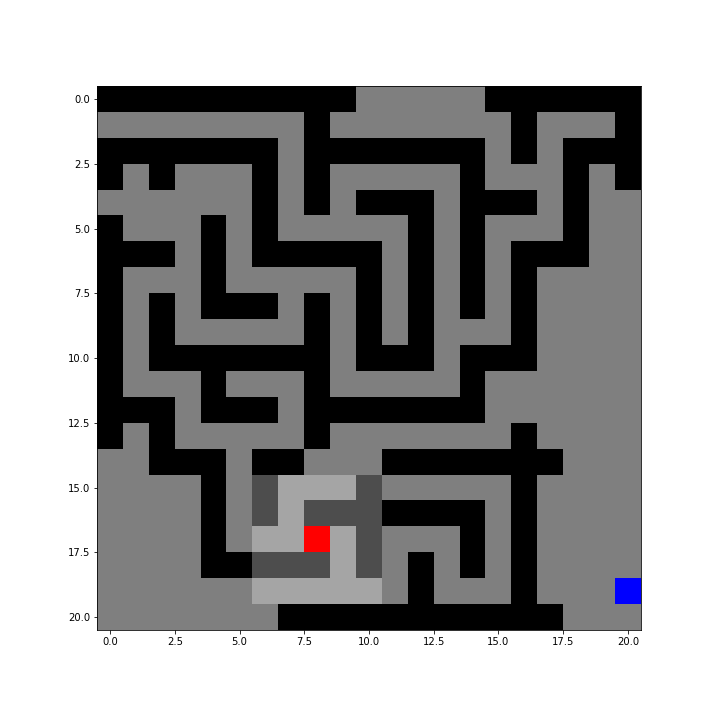
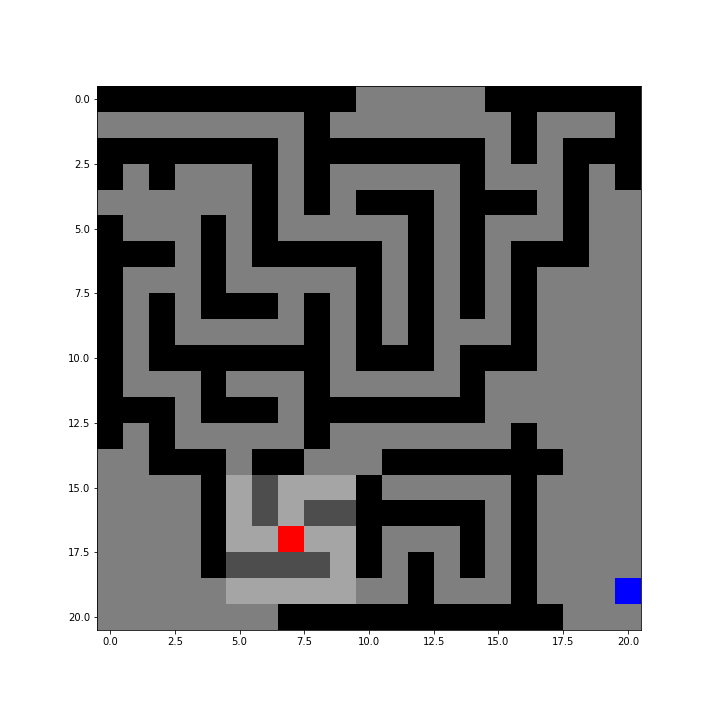
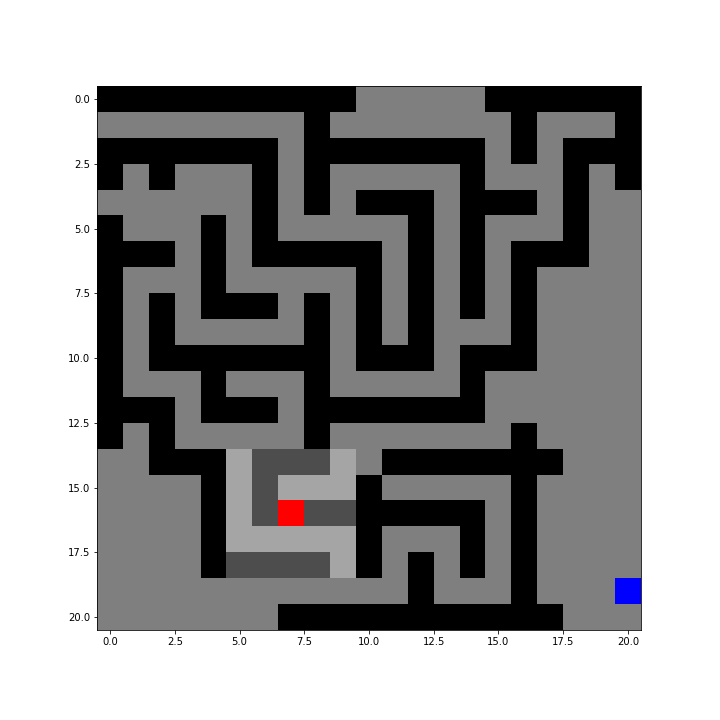
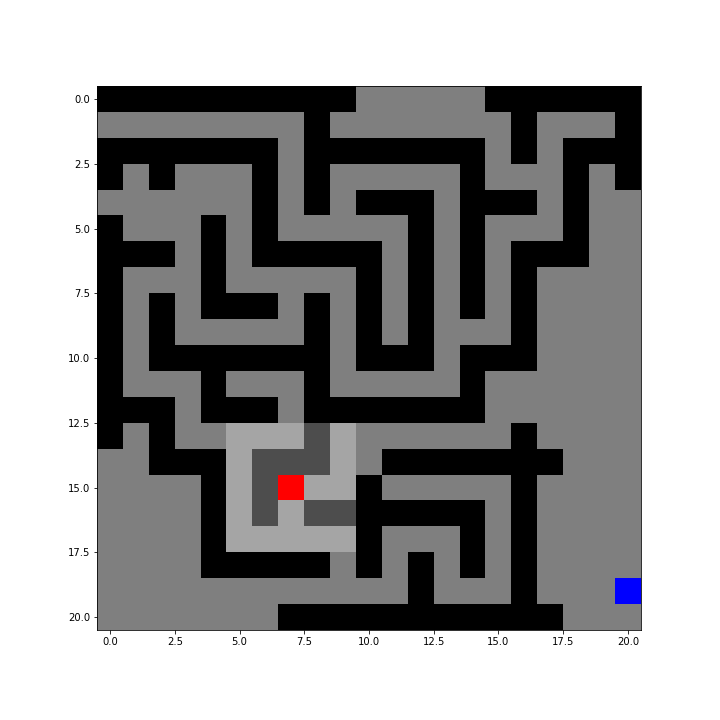
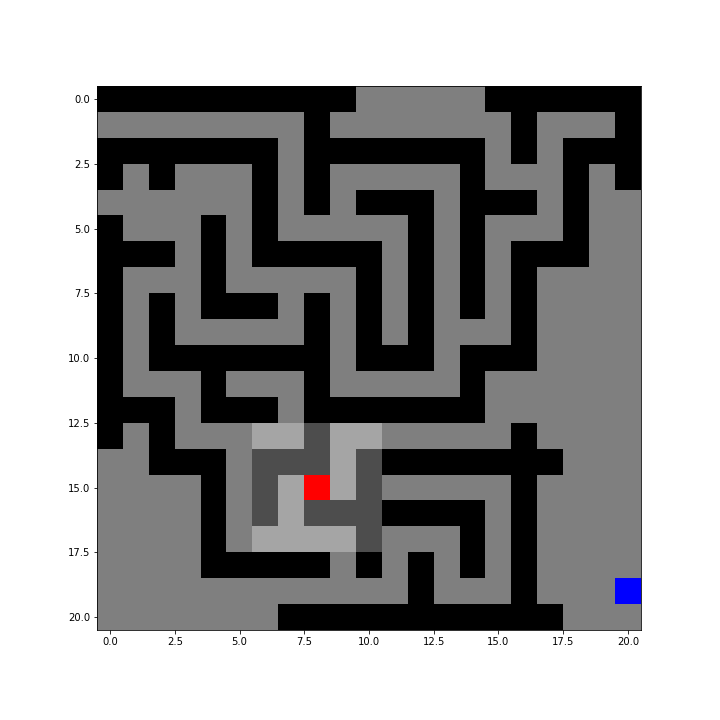
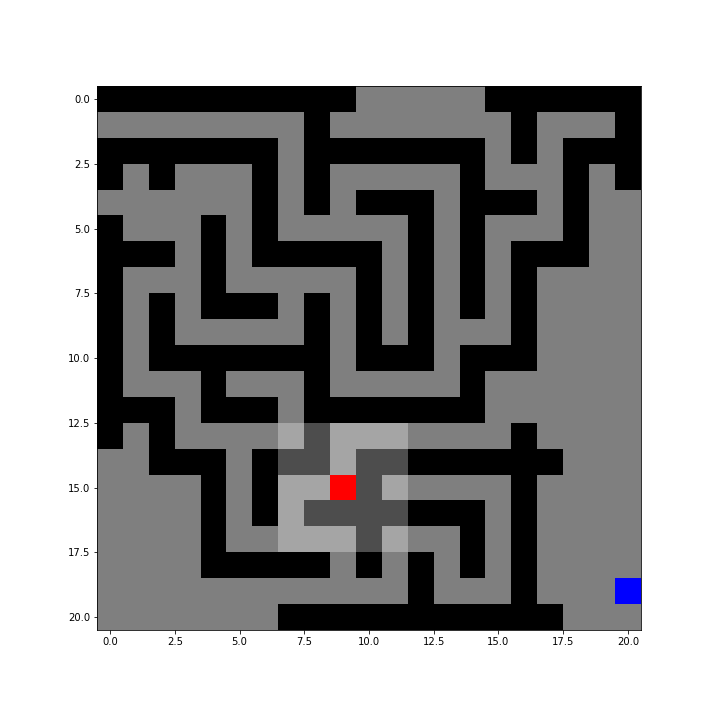
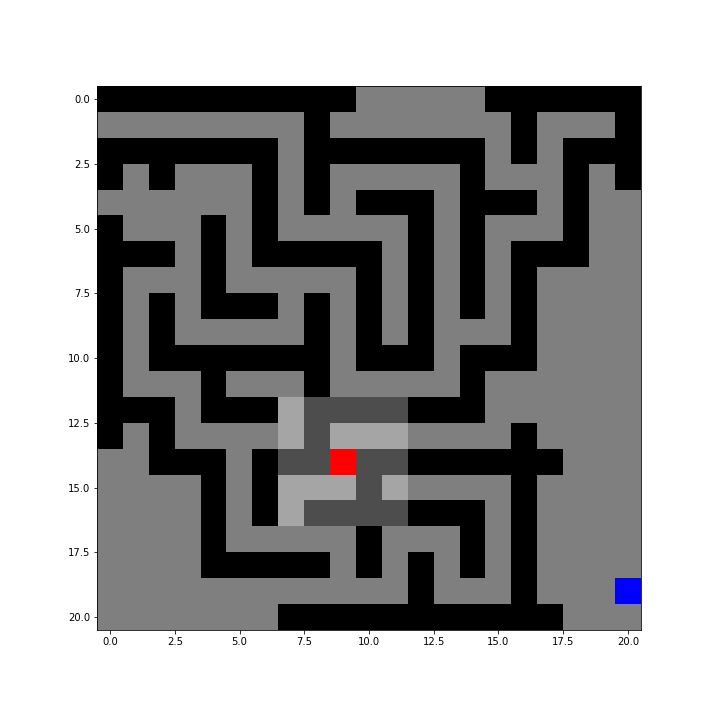
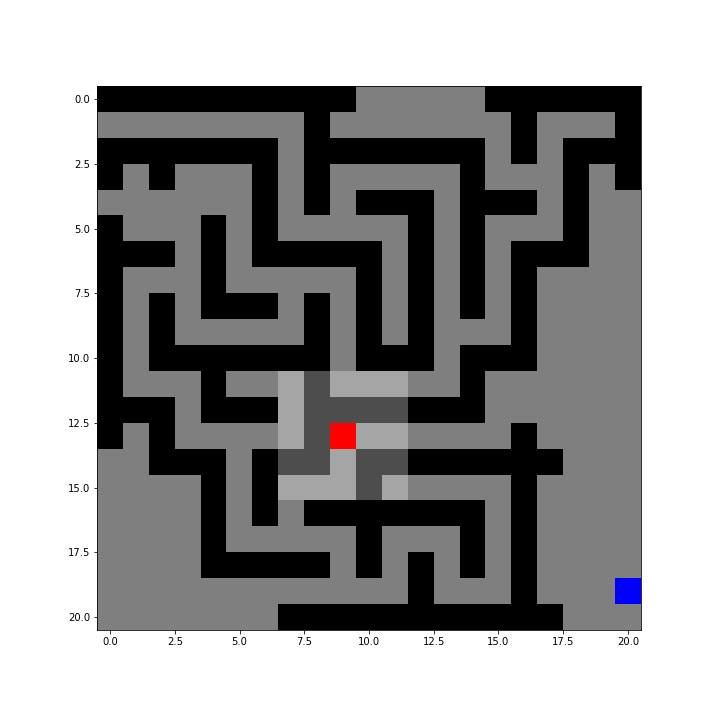
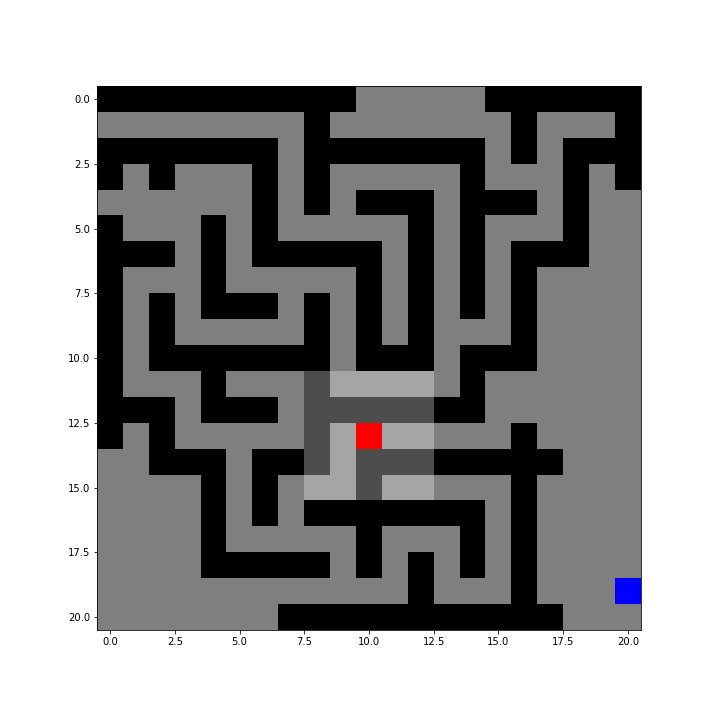
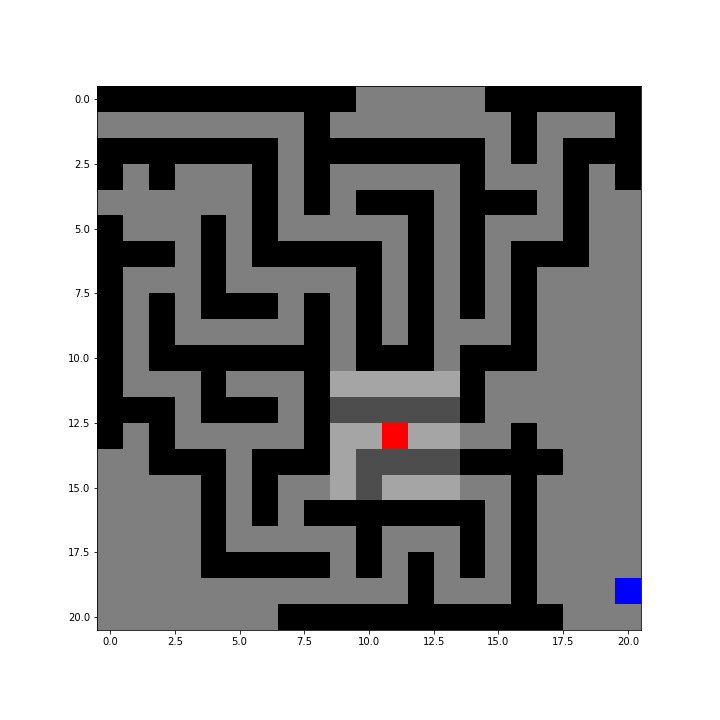
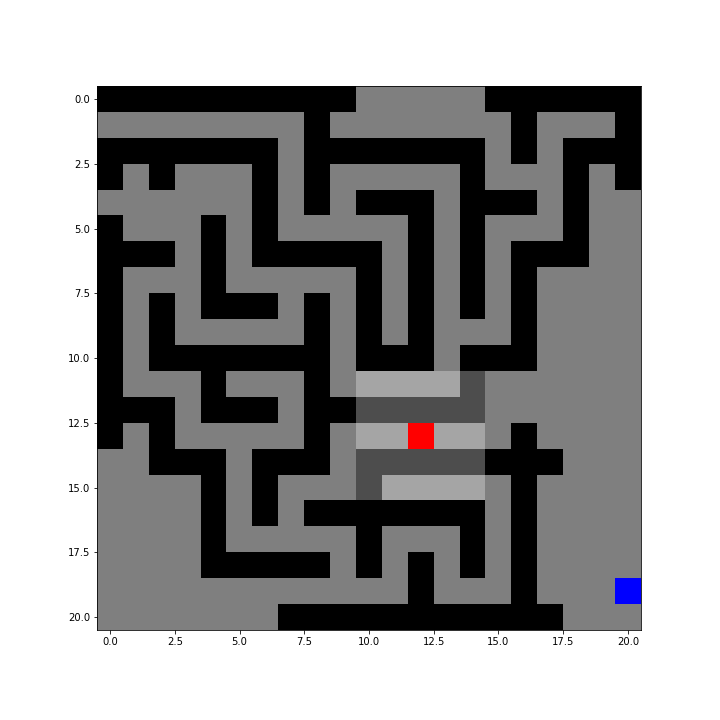
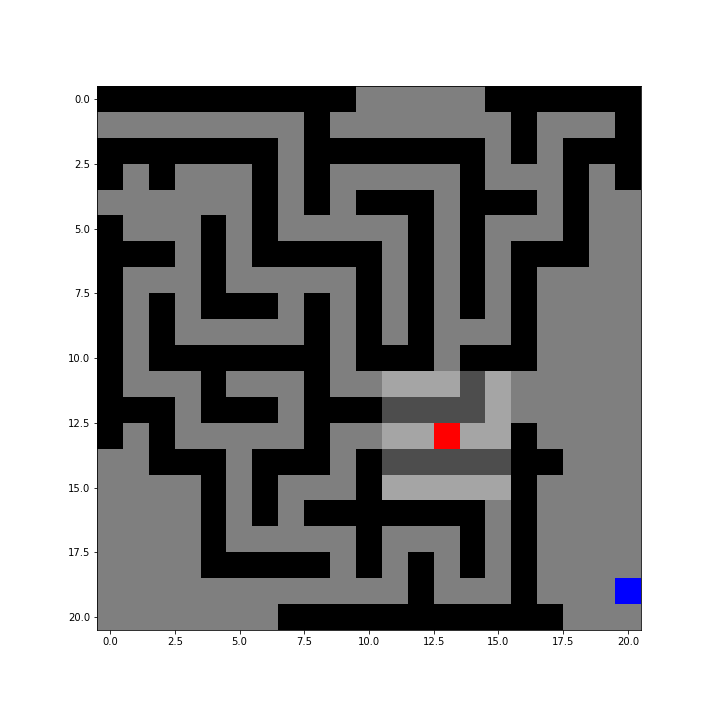
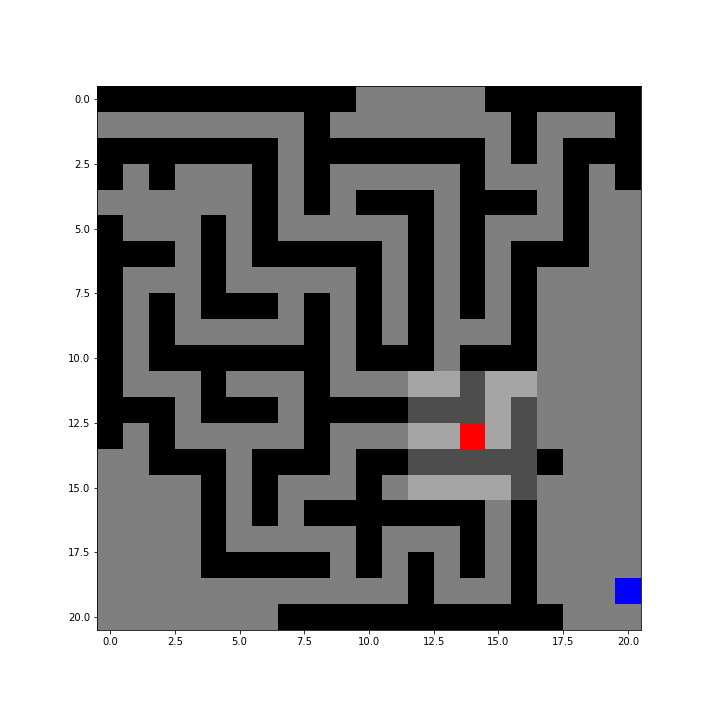
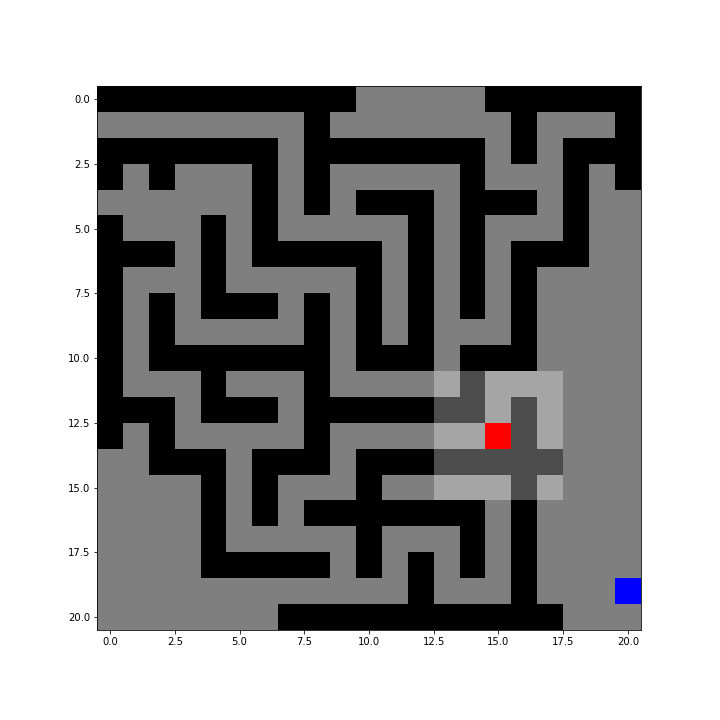
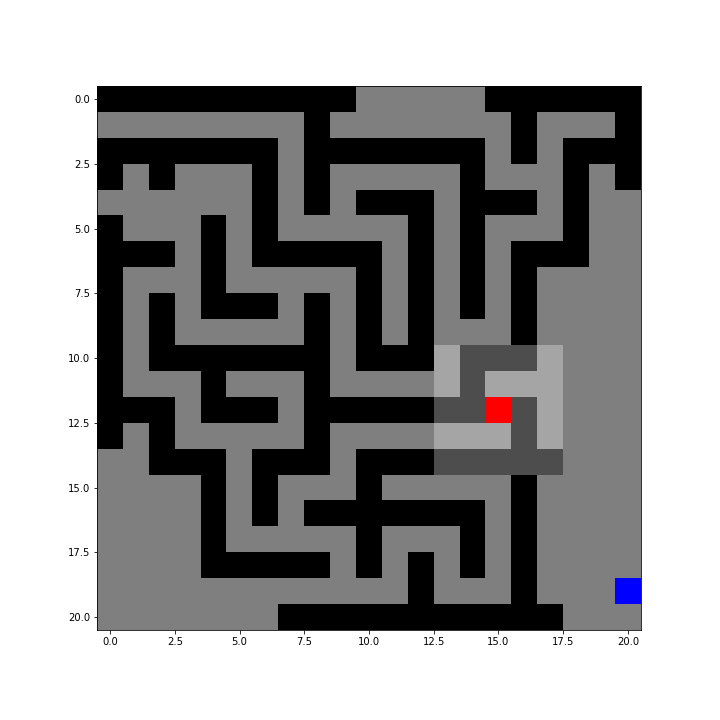
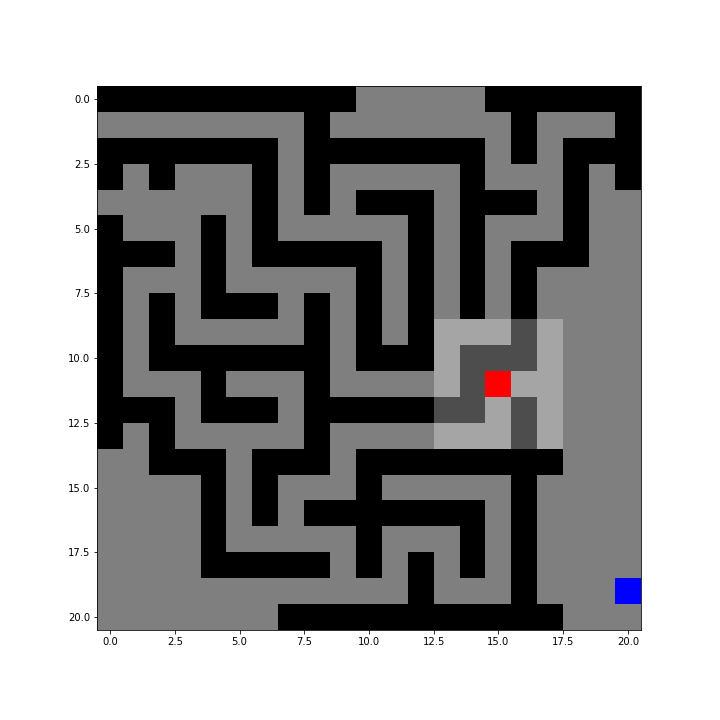
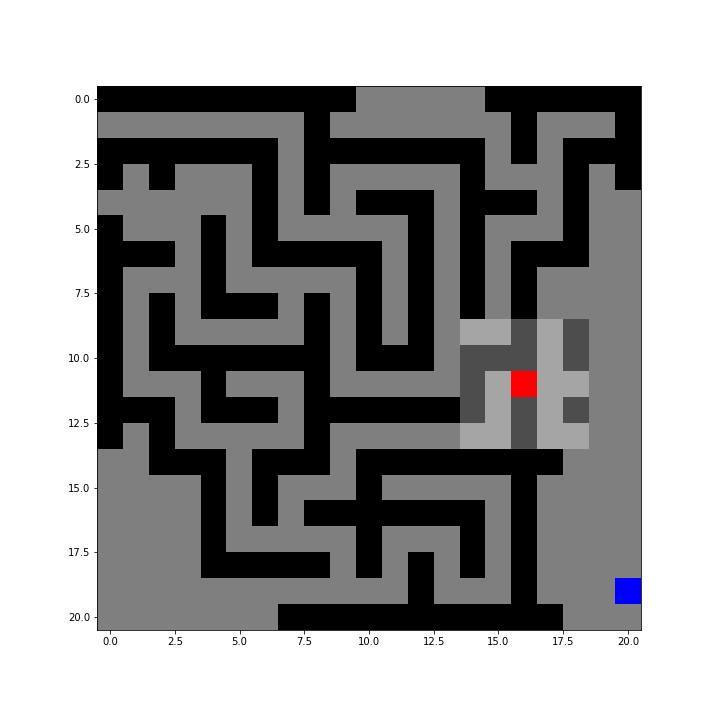
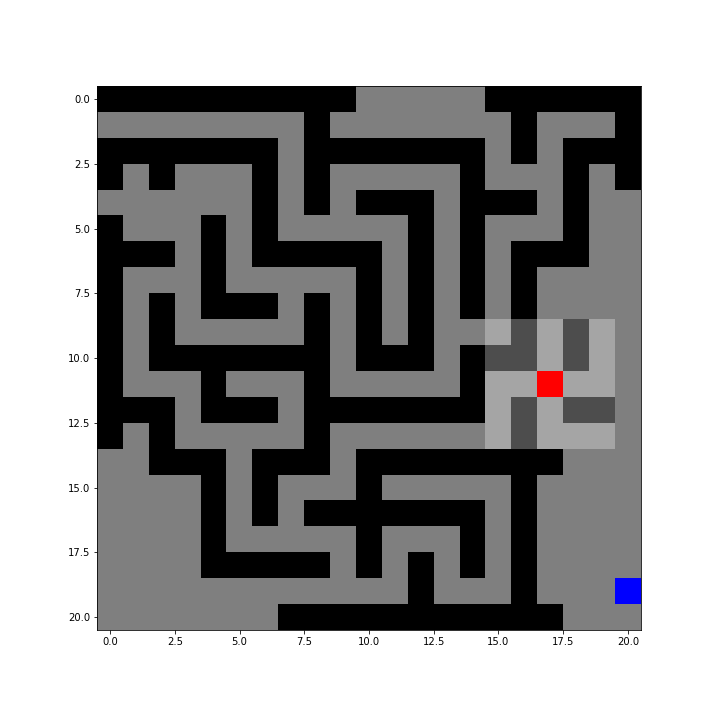
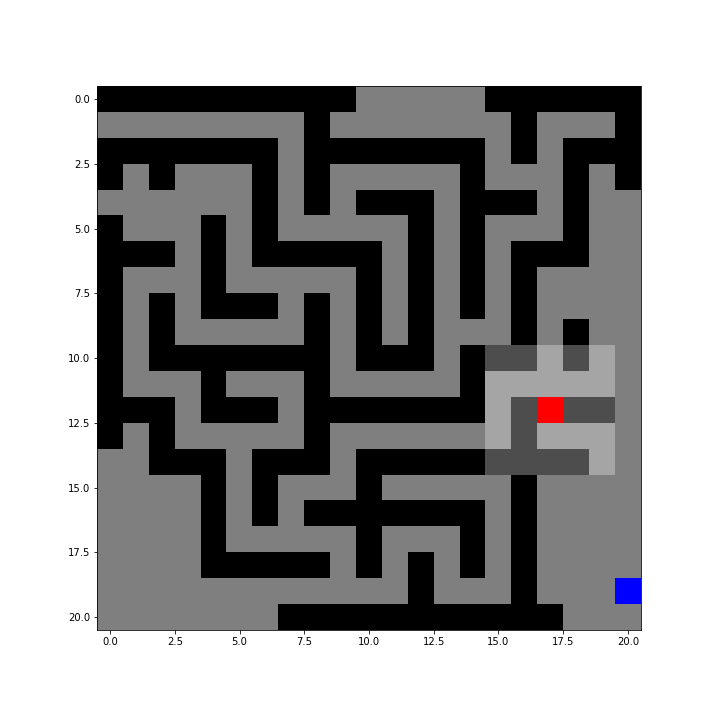
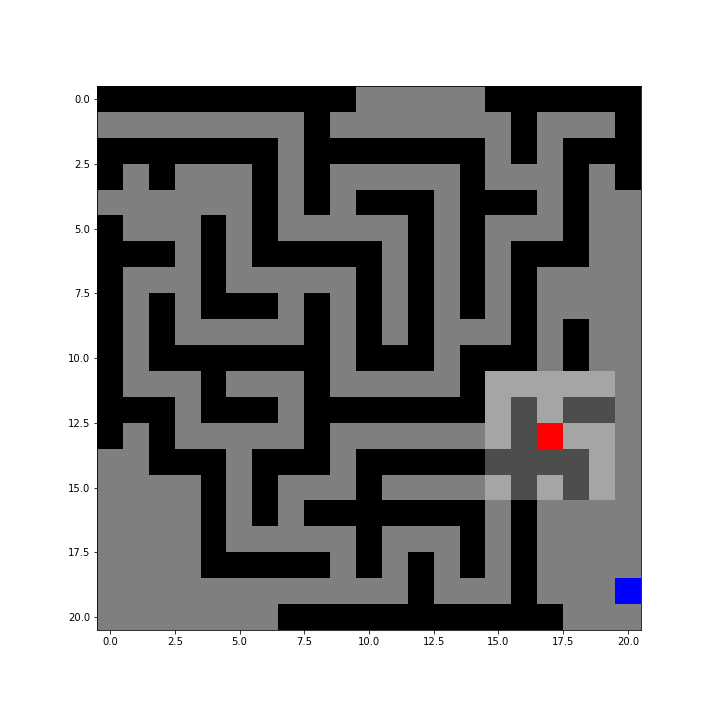
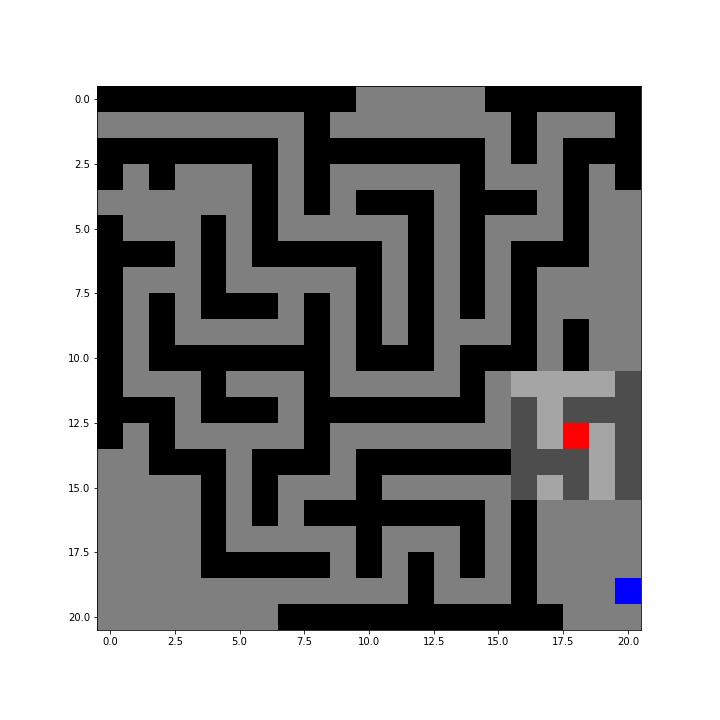
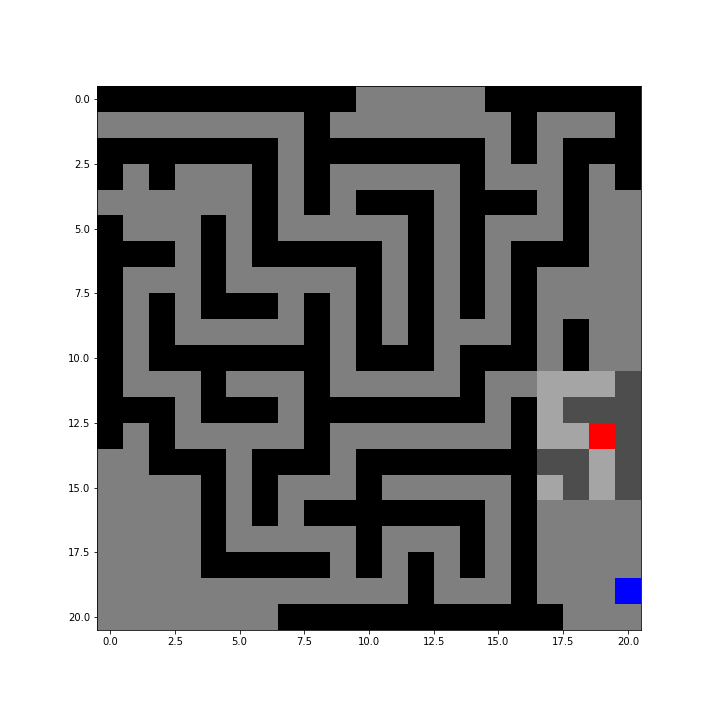
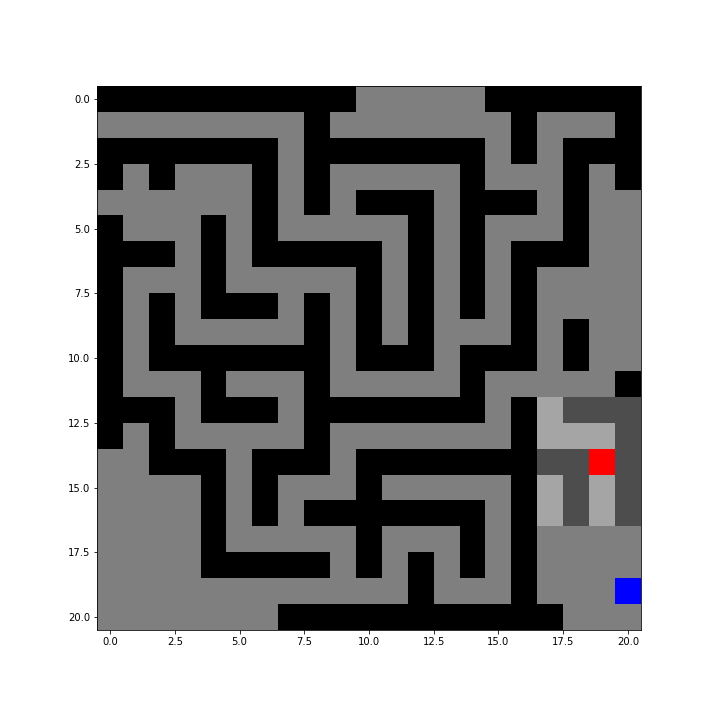
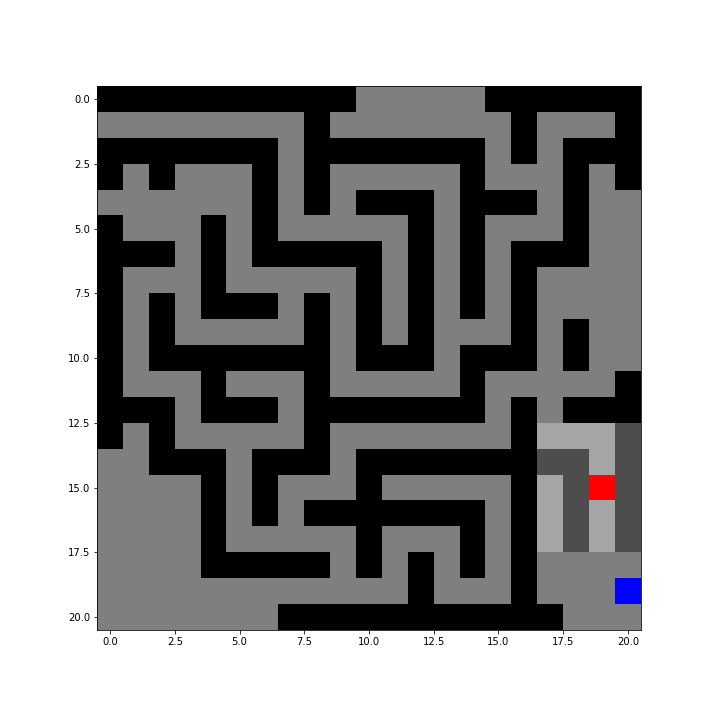
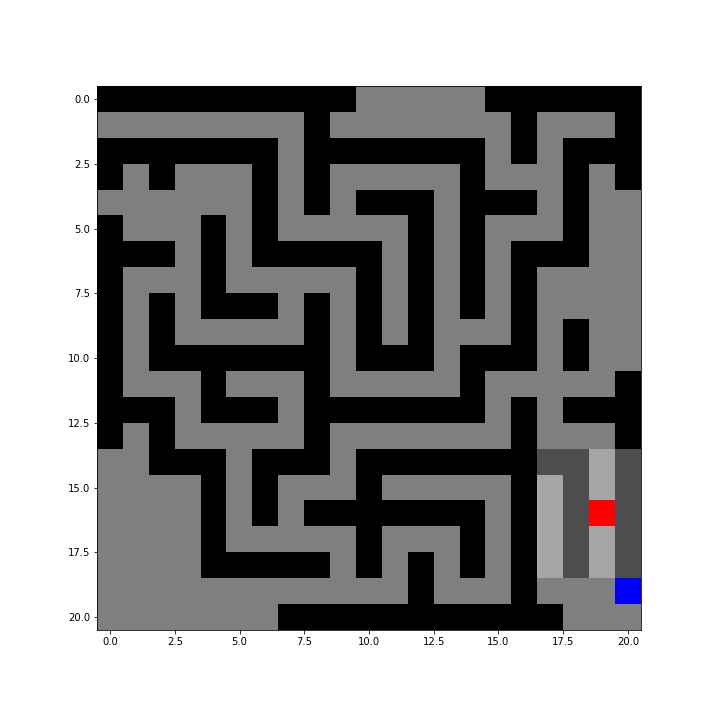
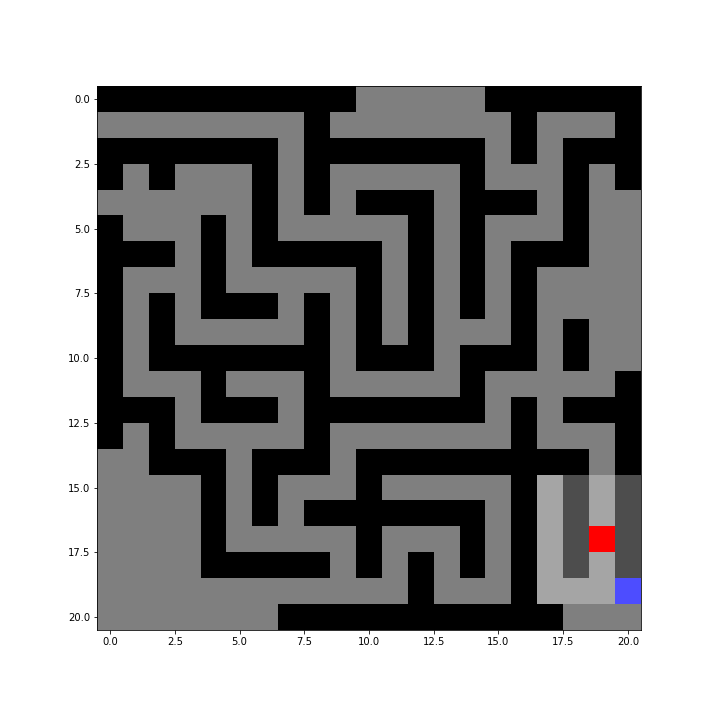
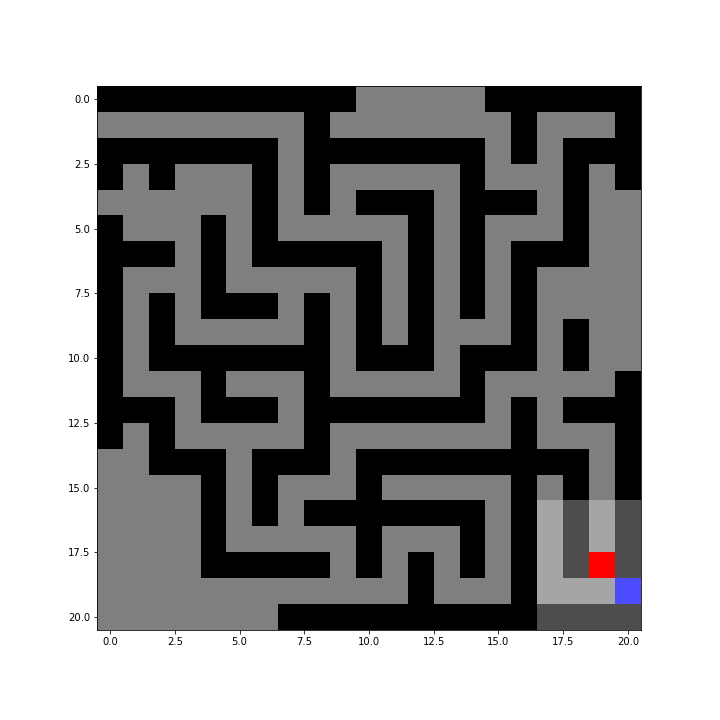
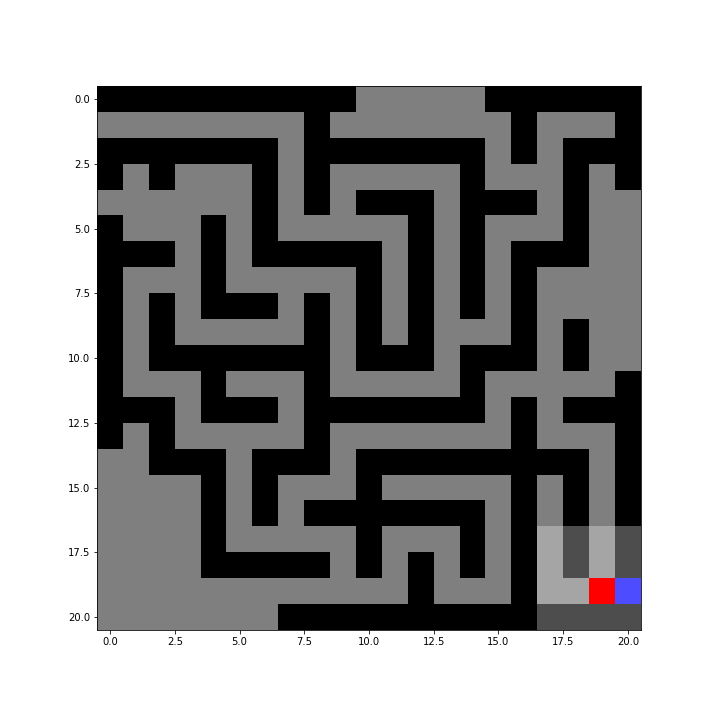
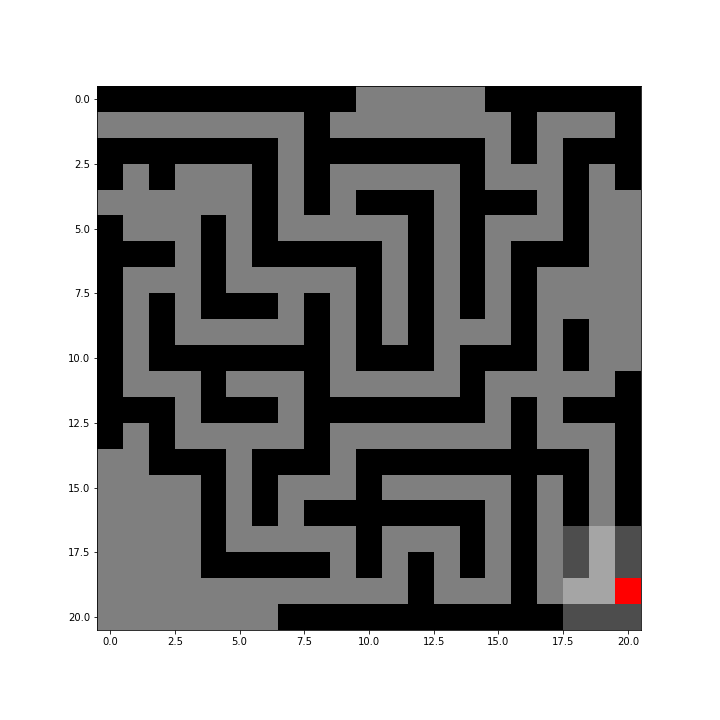

In [10]:
def init():
    img.set_data(data)
    return img,
def animate(args):
    (position, observation, walls) = args
    tmp = empty_image(GRAPH)
    tmp[END[1], END[0]] = [0, 0, 1, 1]

    tmp[position[1], position[0]] = [1, 0, 0, 1]
    for (x, y) in walls:
        tmp[y, x] = [0,0,0,1]
    for (x, y) in observation.keys():
        if (x, y) == position:
            continue
        else:
            (r, g, b, a) = tmp[y, x]
            tmp[y, x] = [r, g, b, 0.7]
    img.set_data(tmp)
    return img,
animation.FuncAnimation(fig, animate, init_func=init,
                               frames=SIMULATION, interval=200, blit=True, save_count=100000)


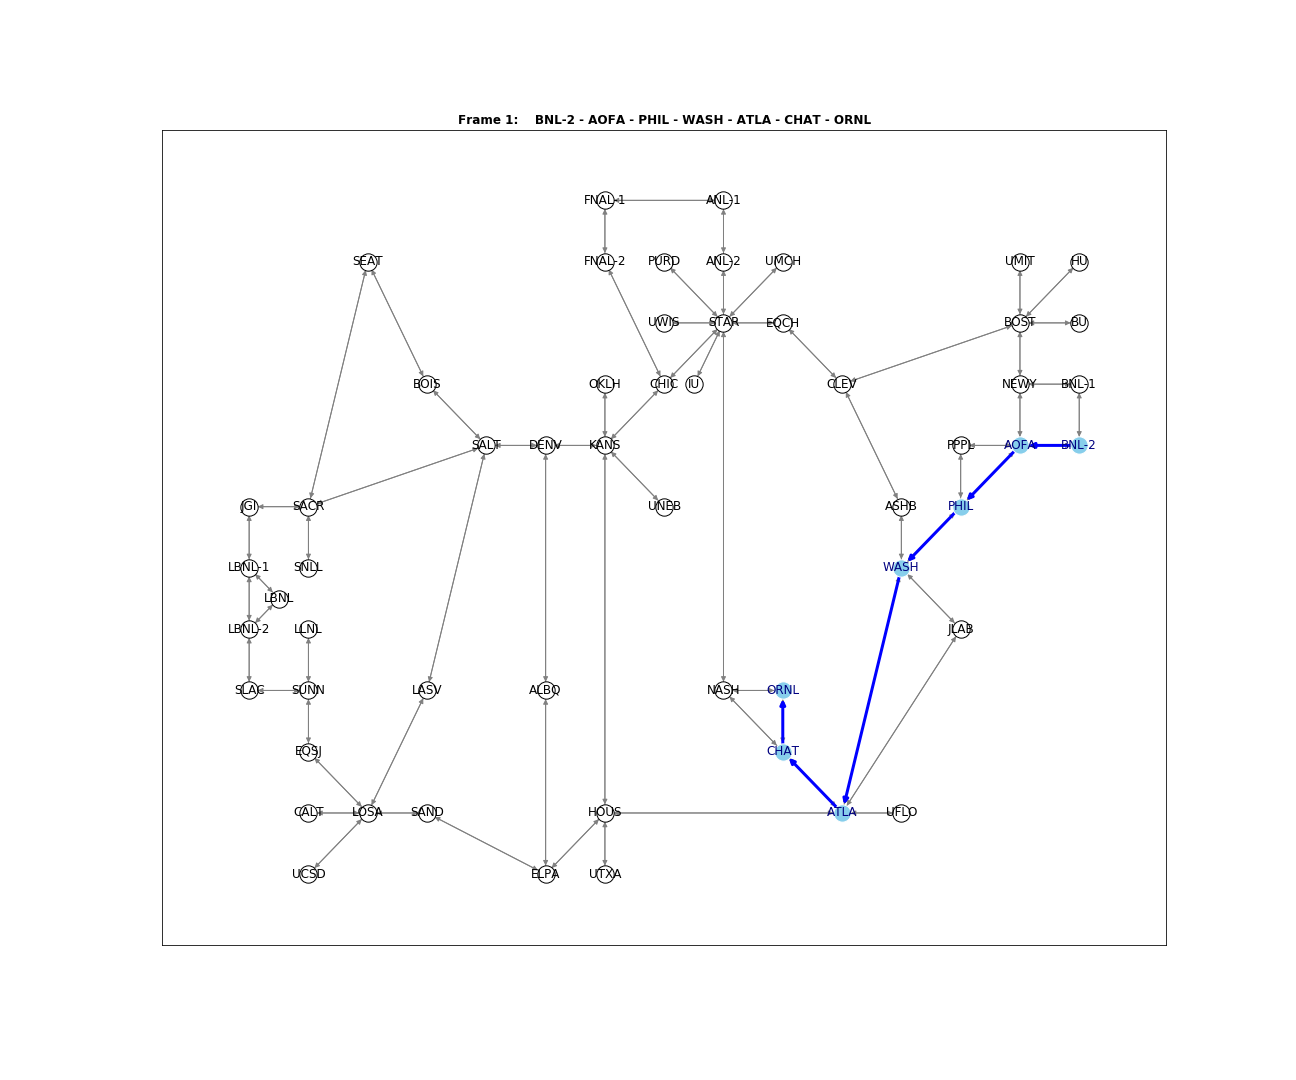
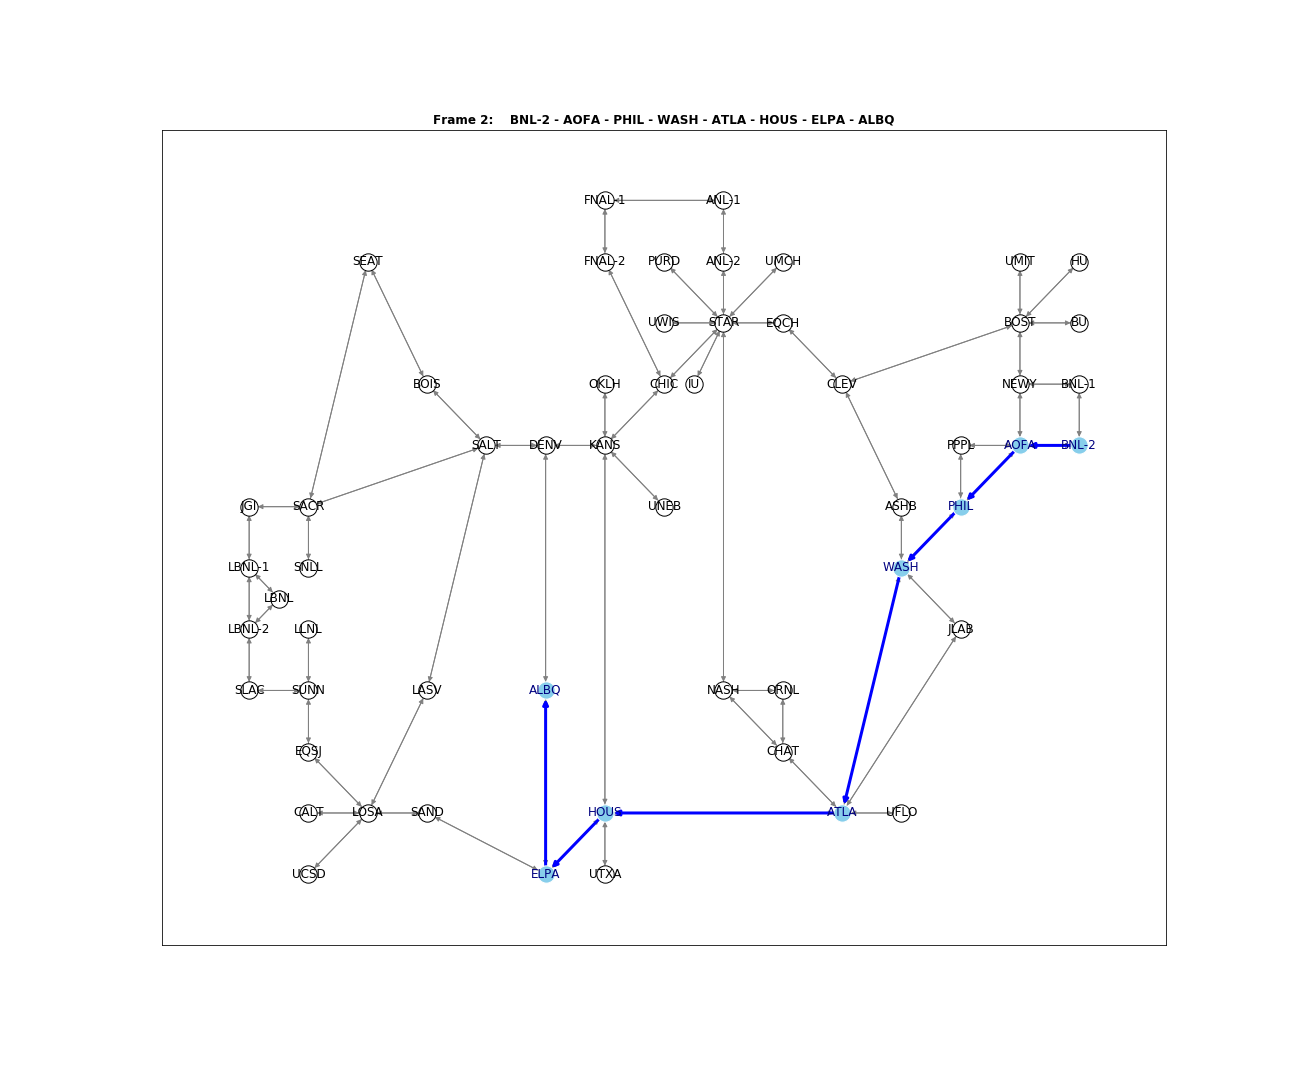
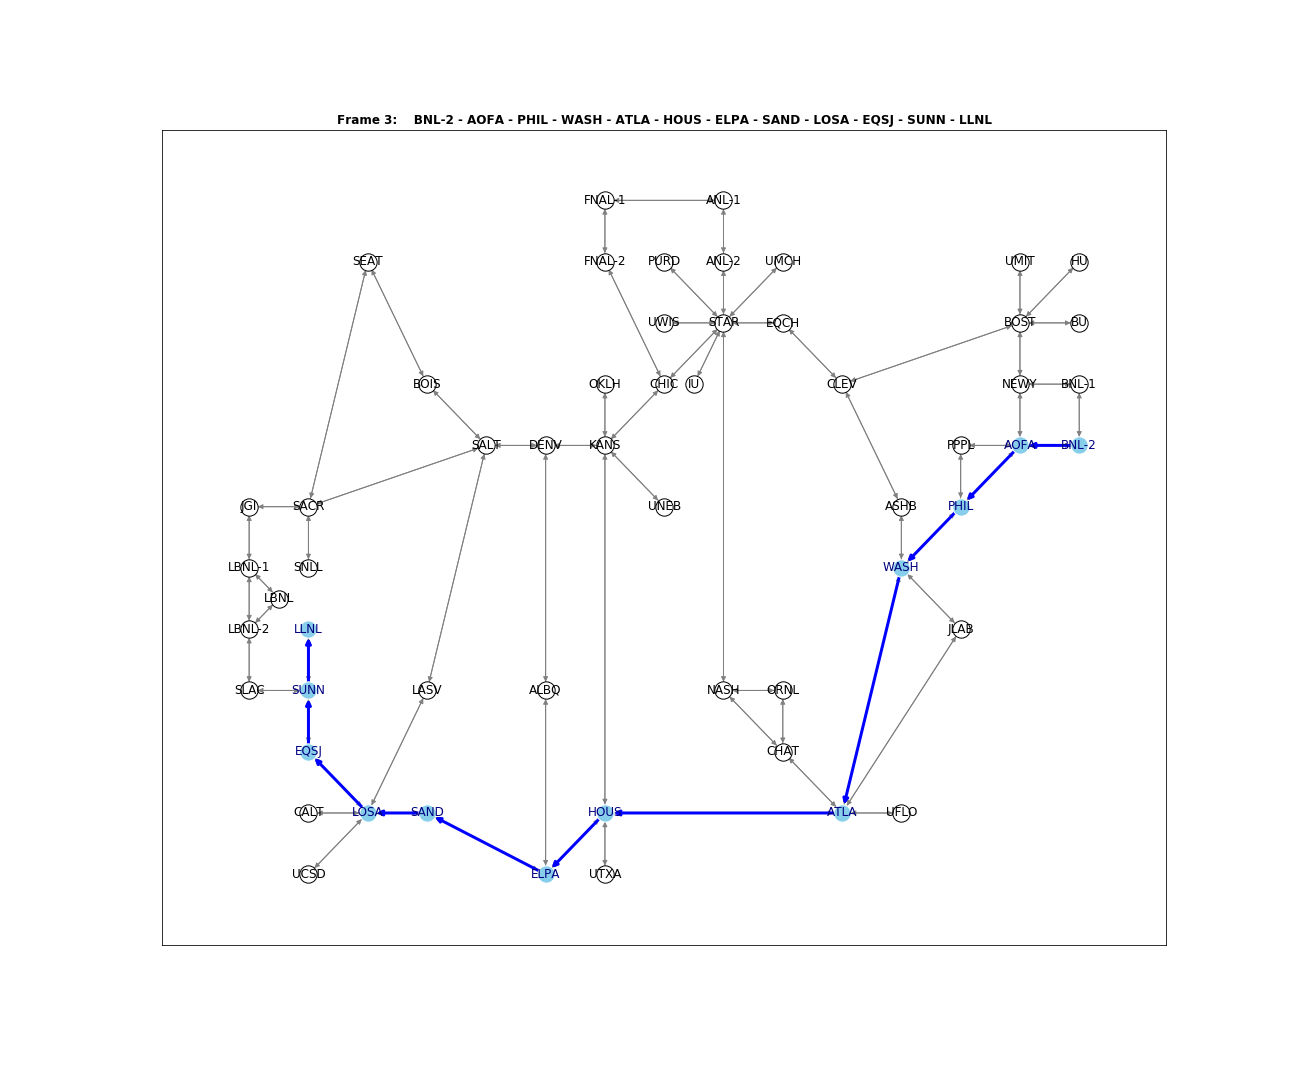
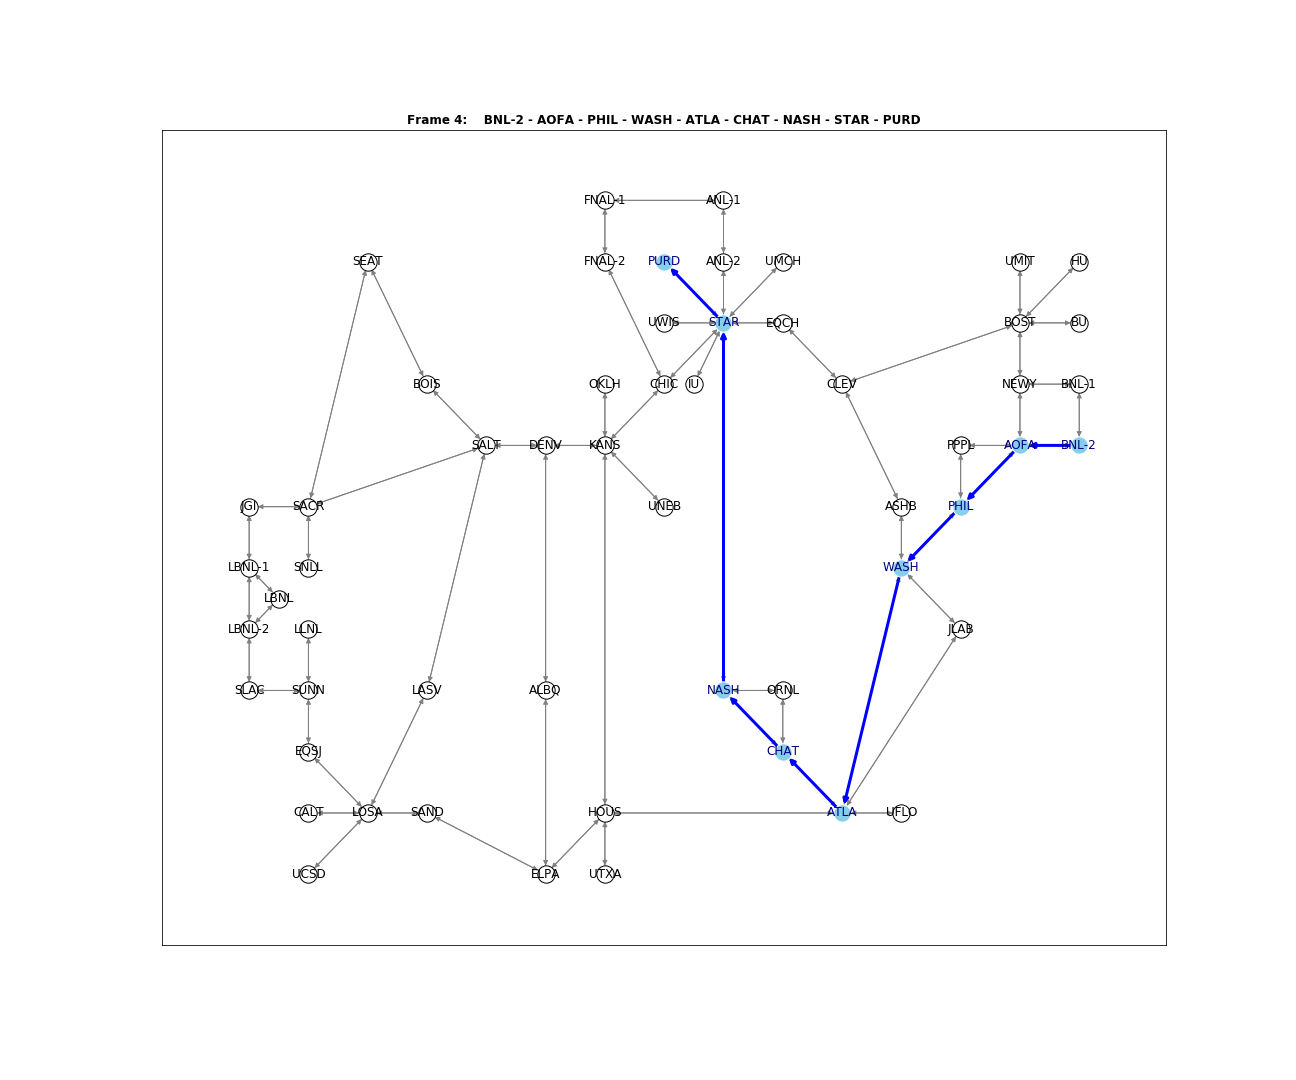
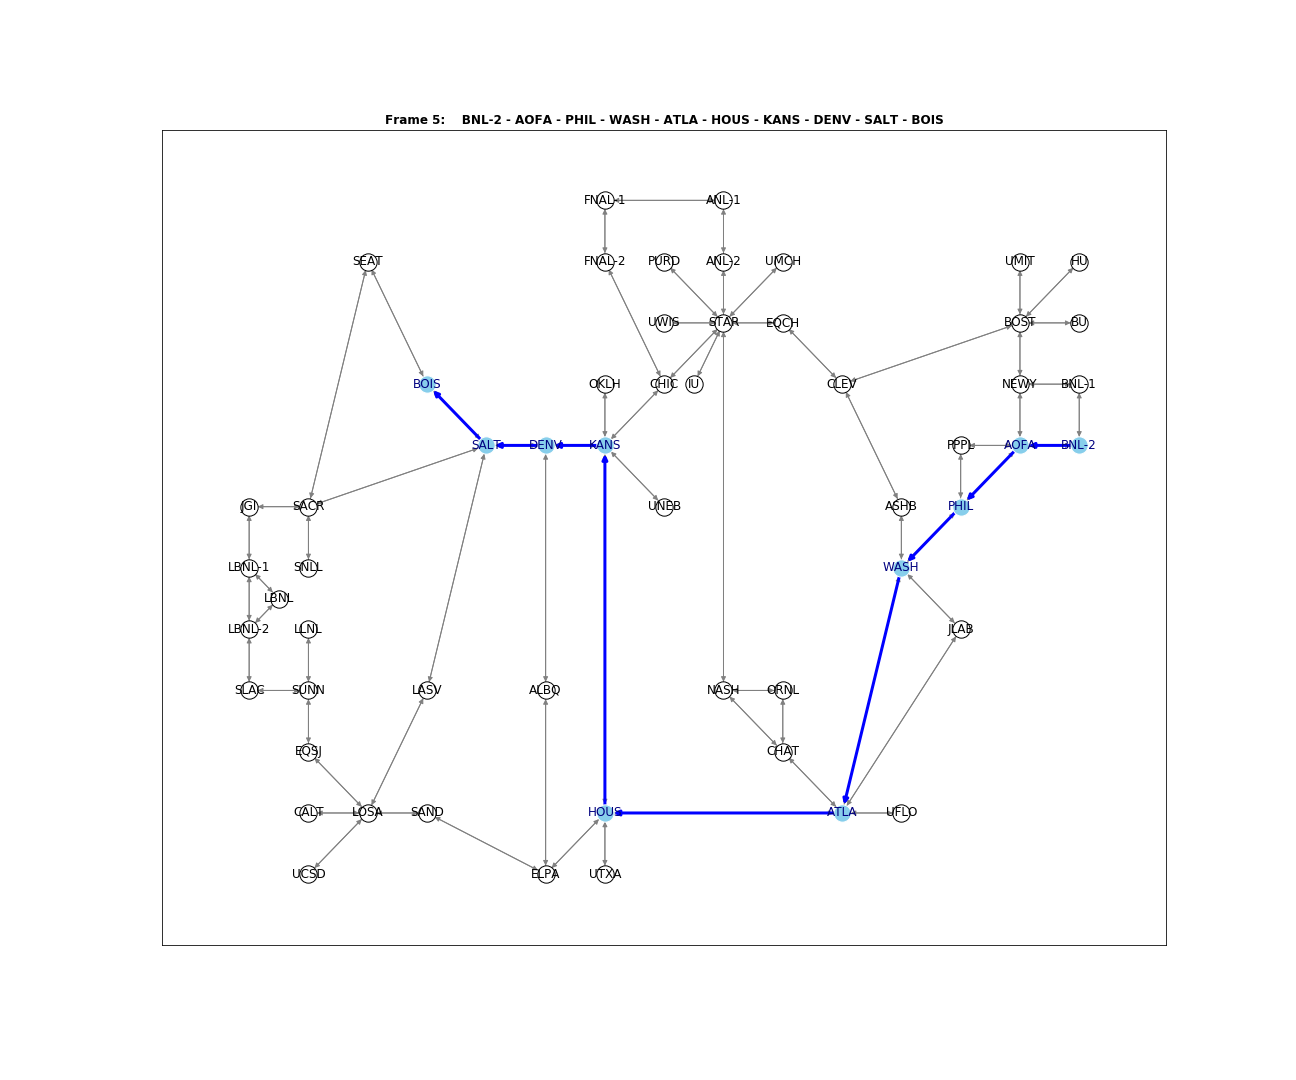
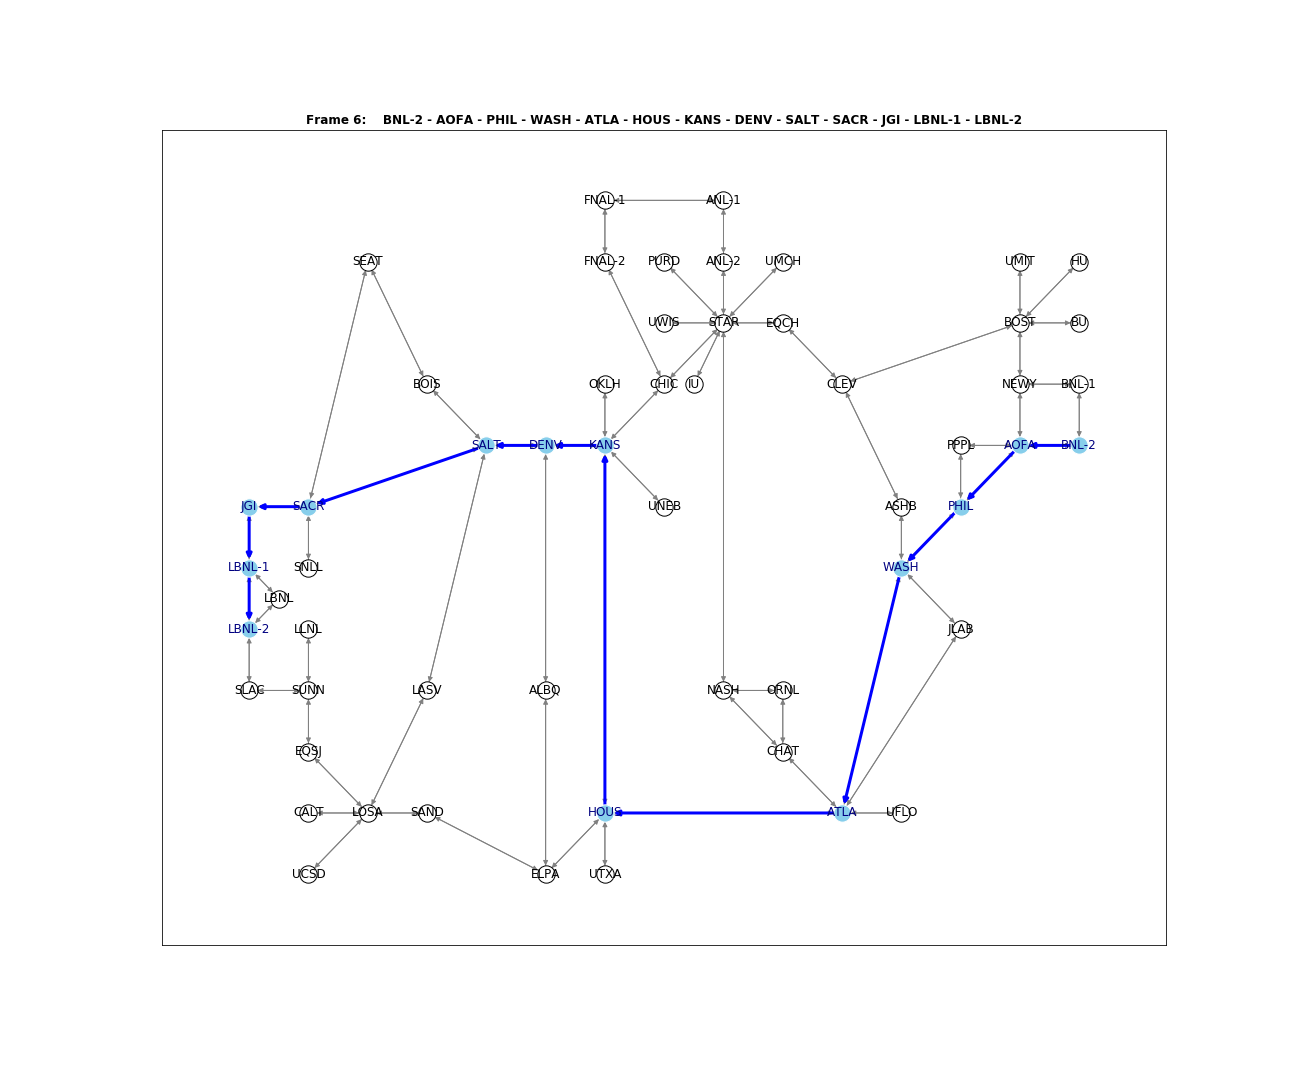
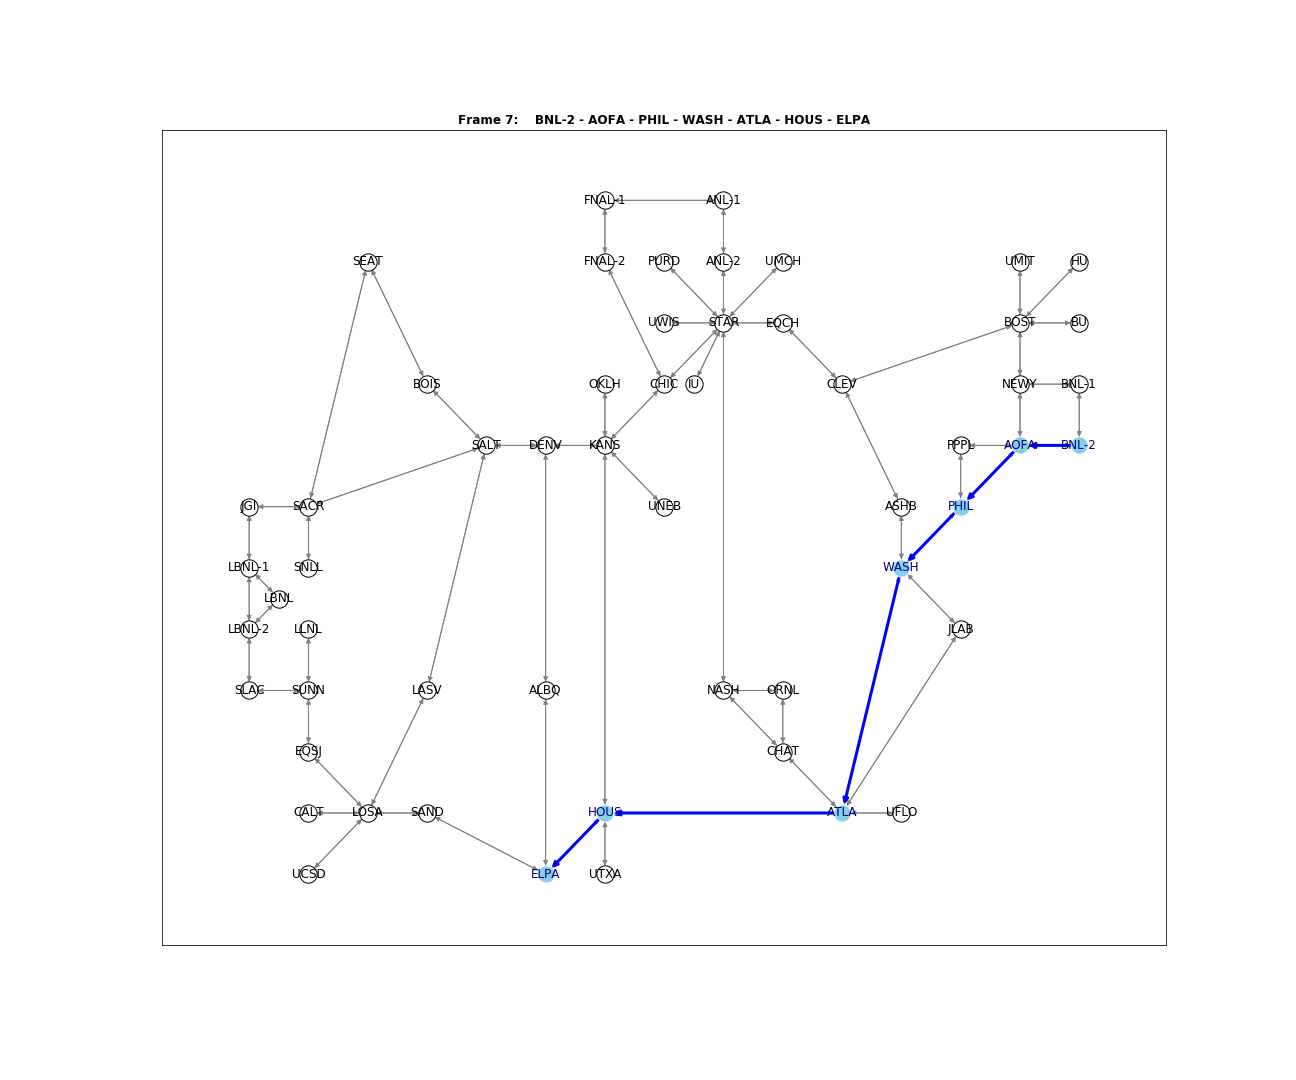
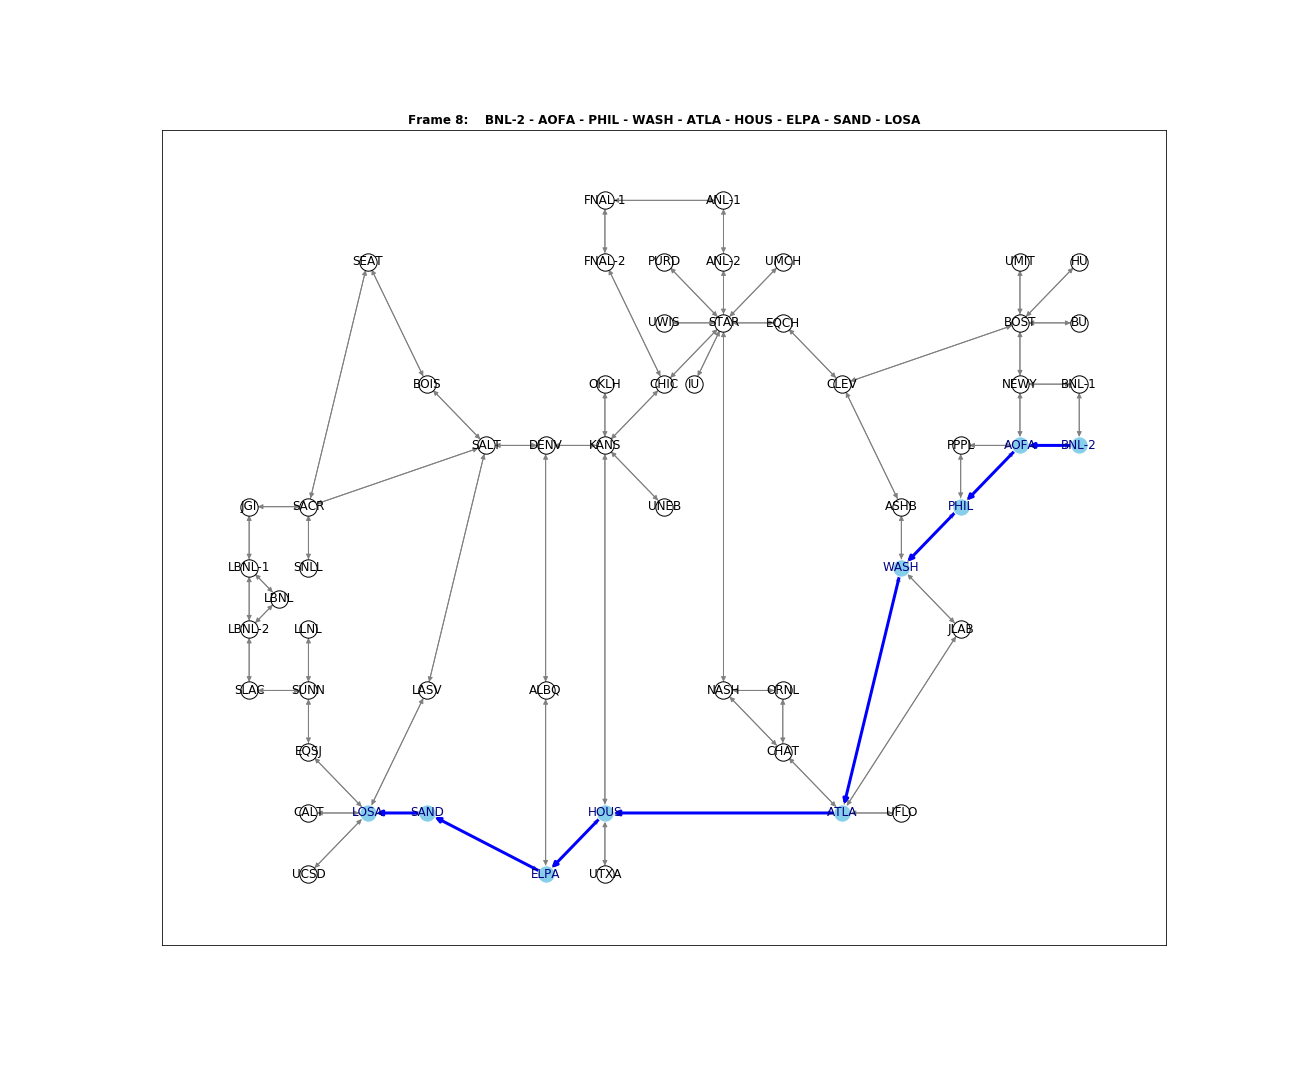
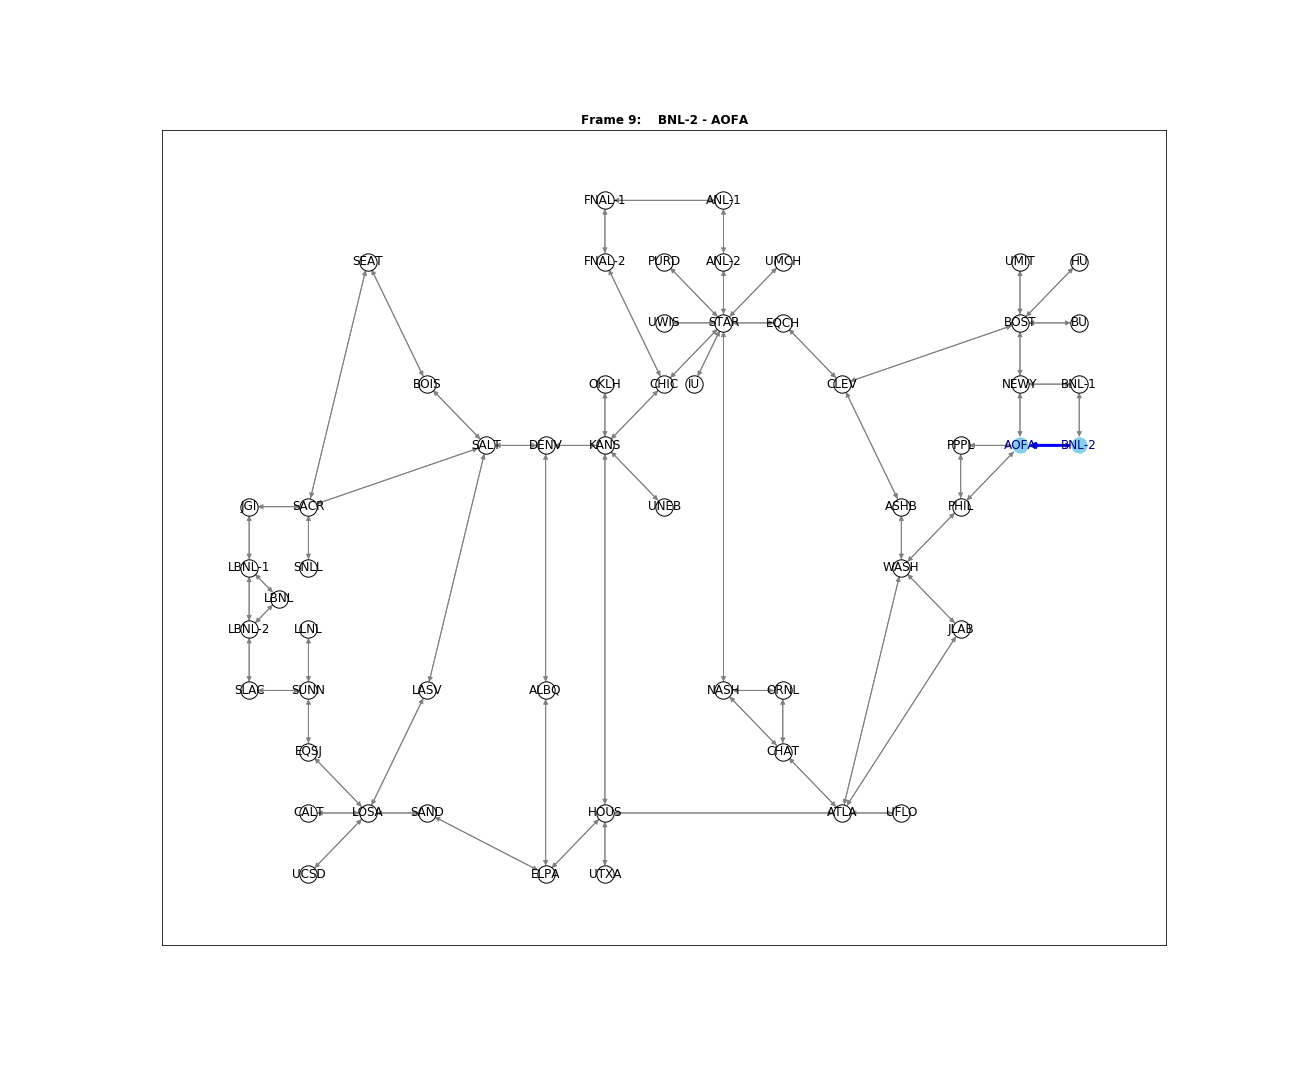
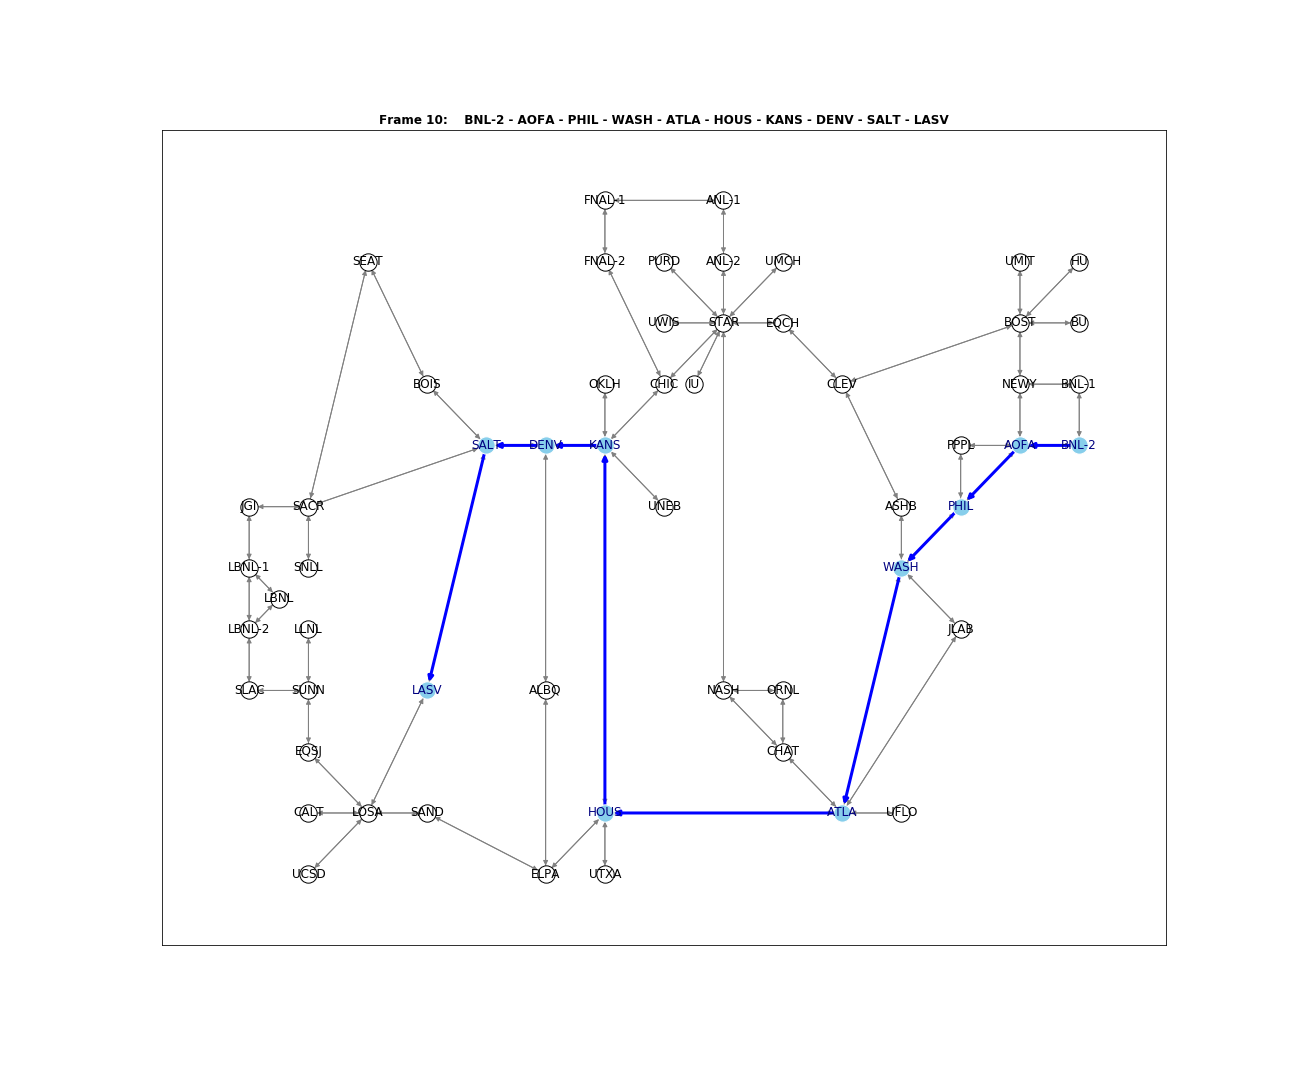
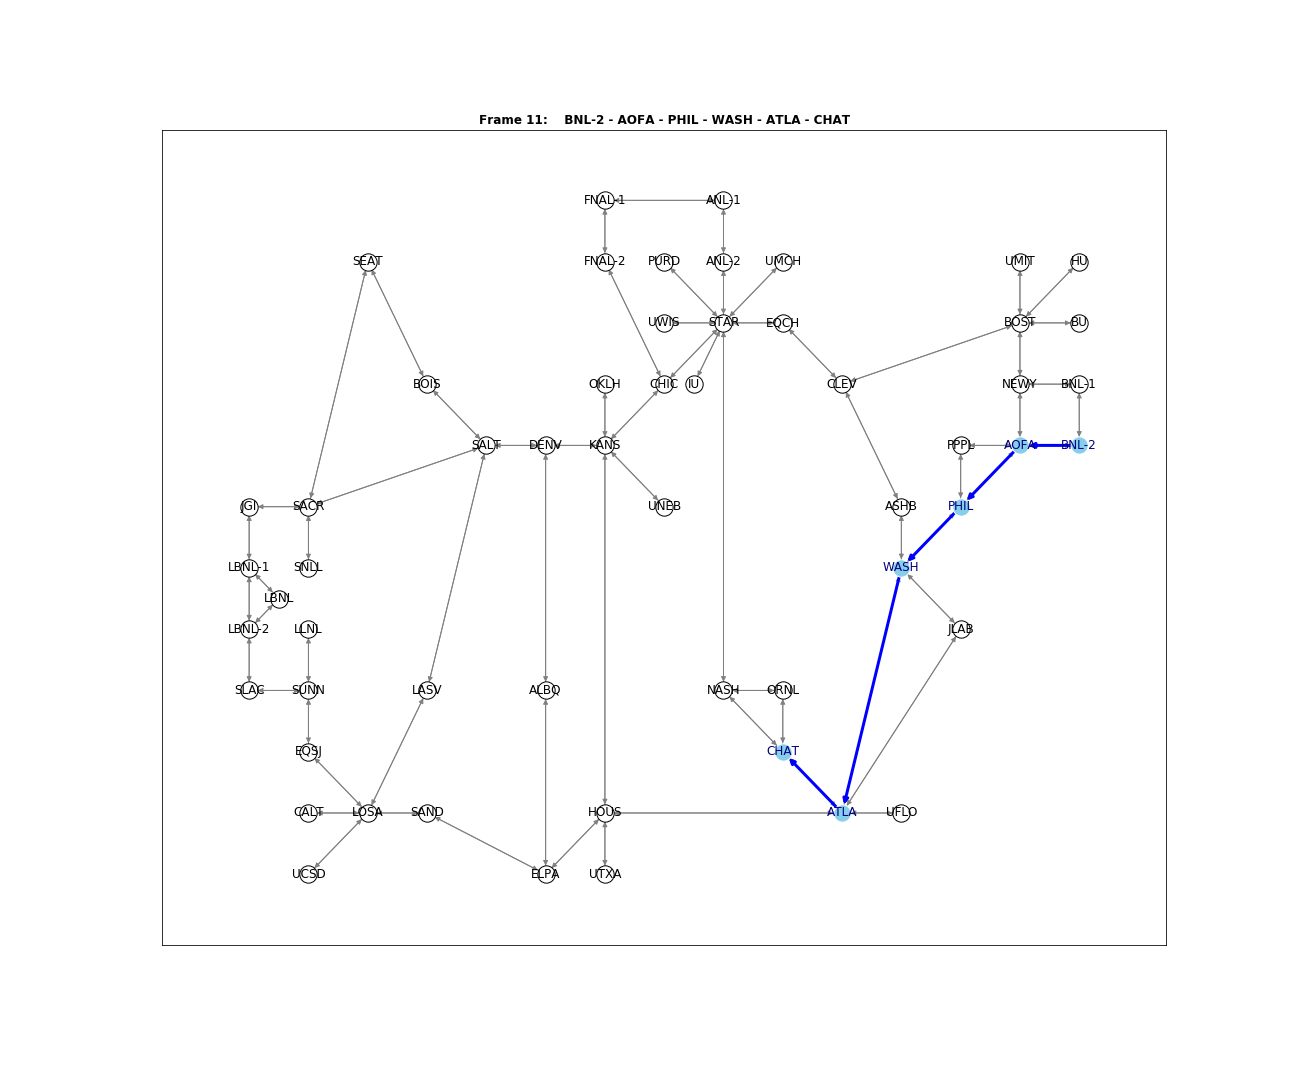
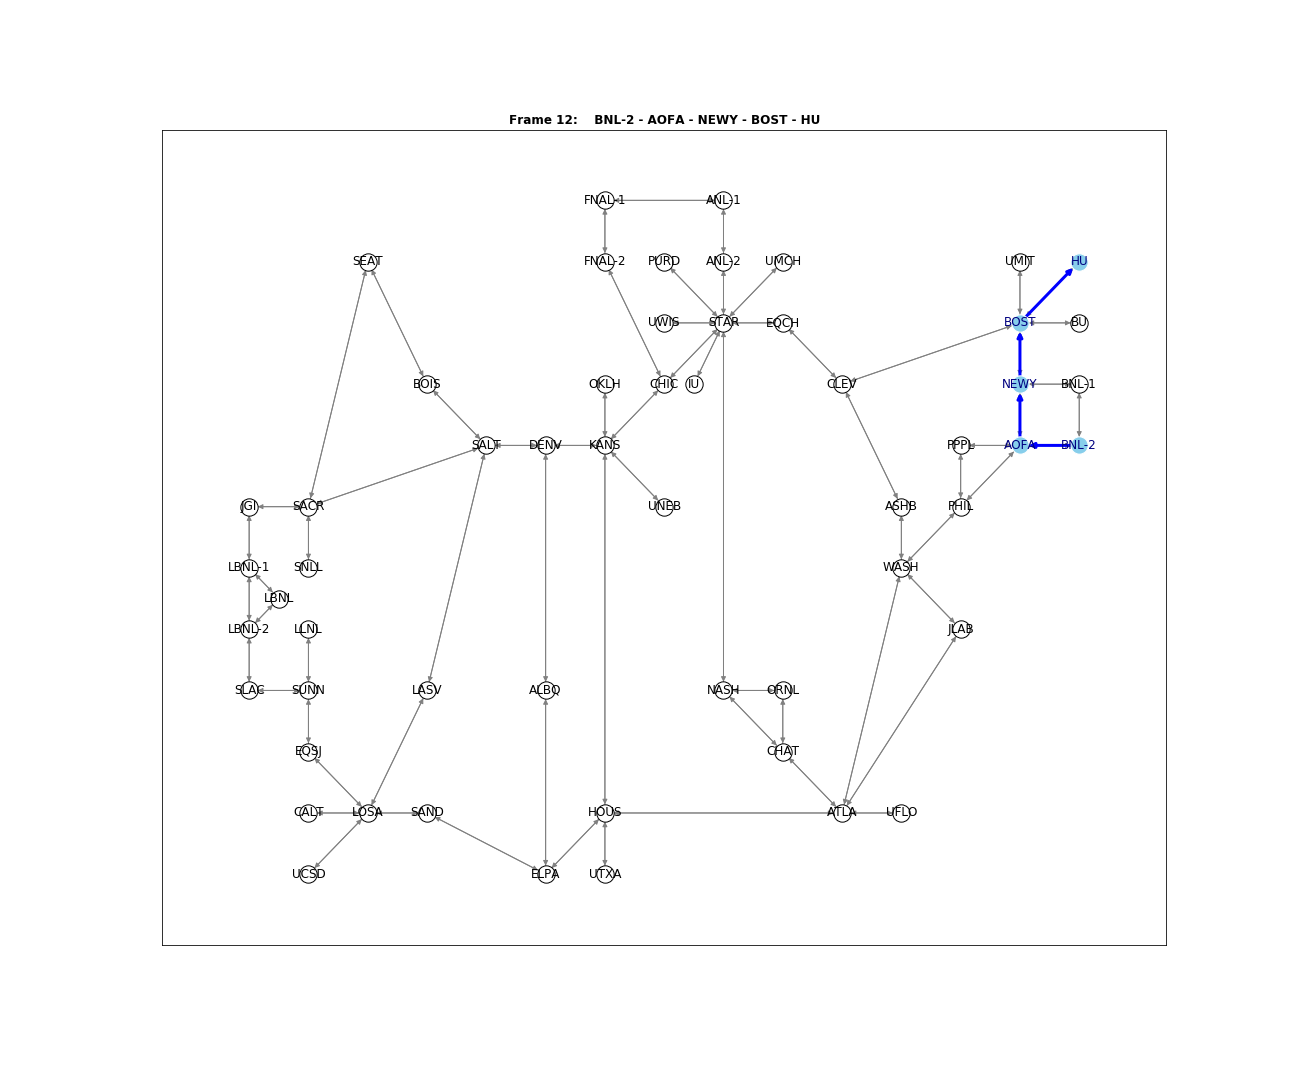
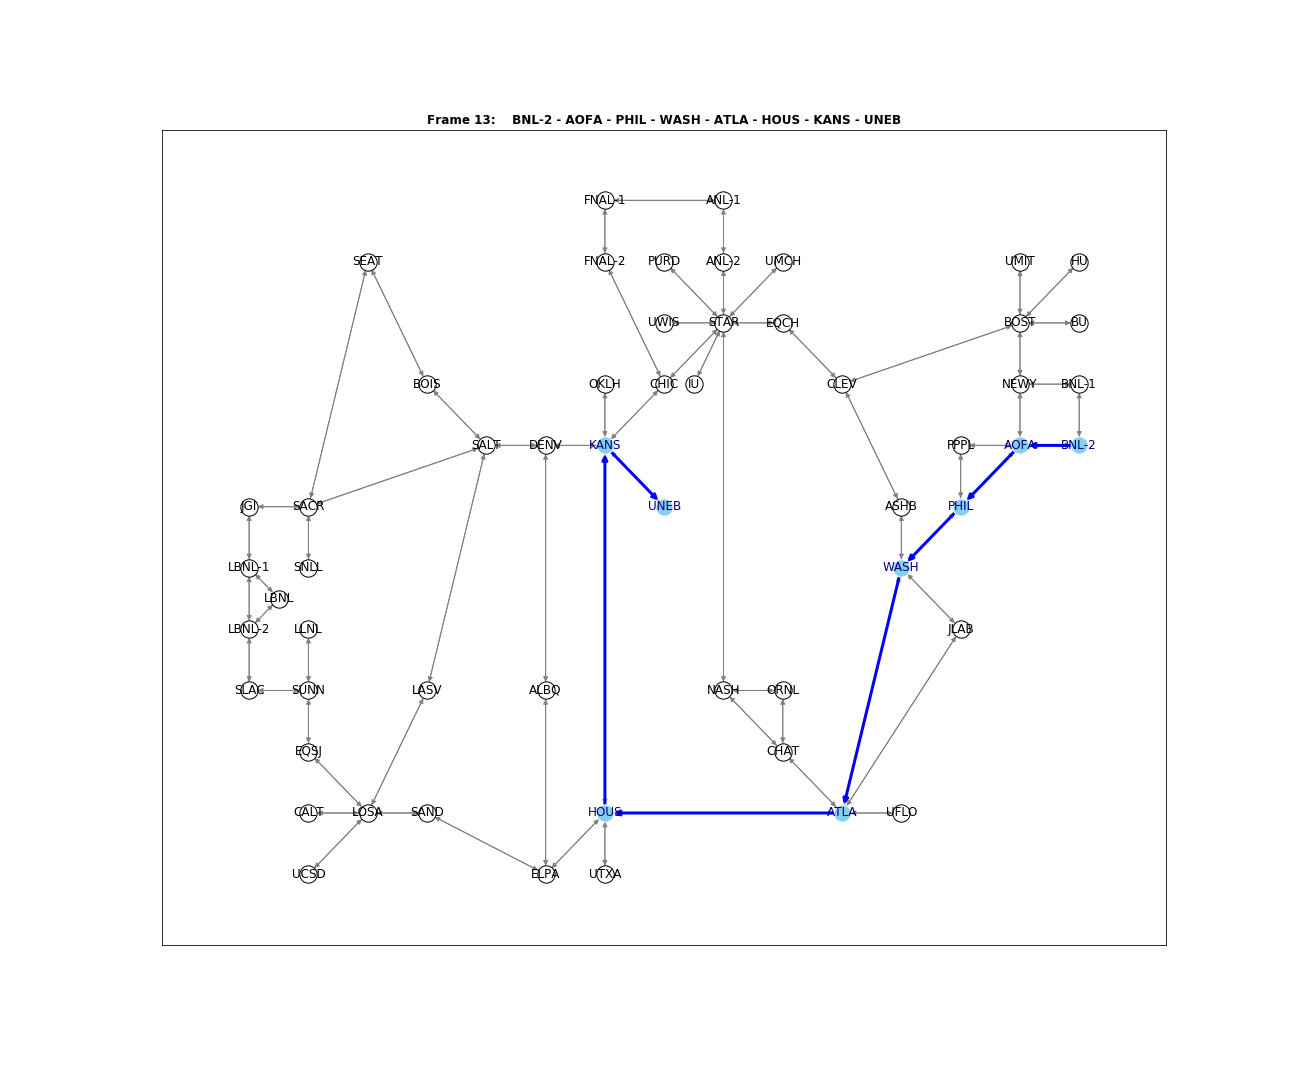
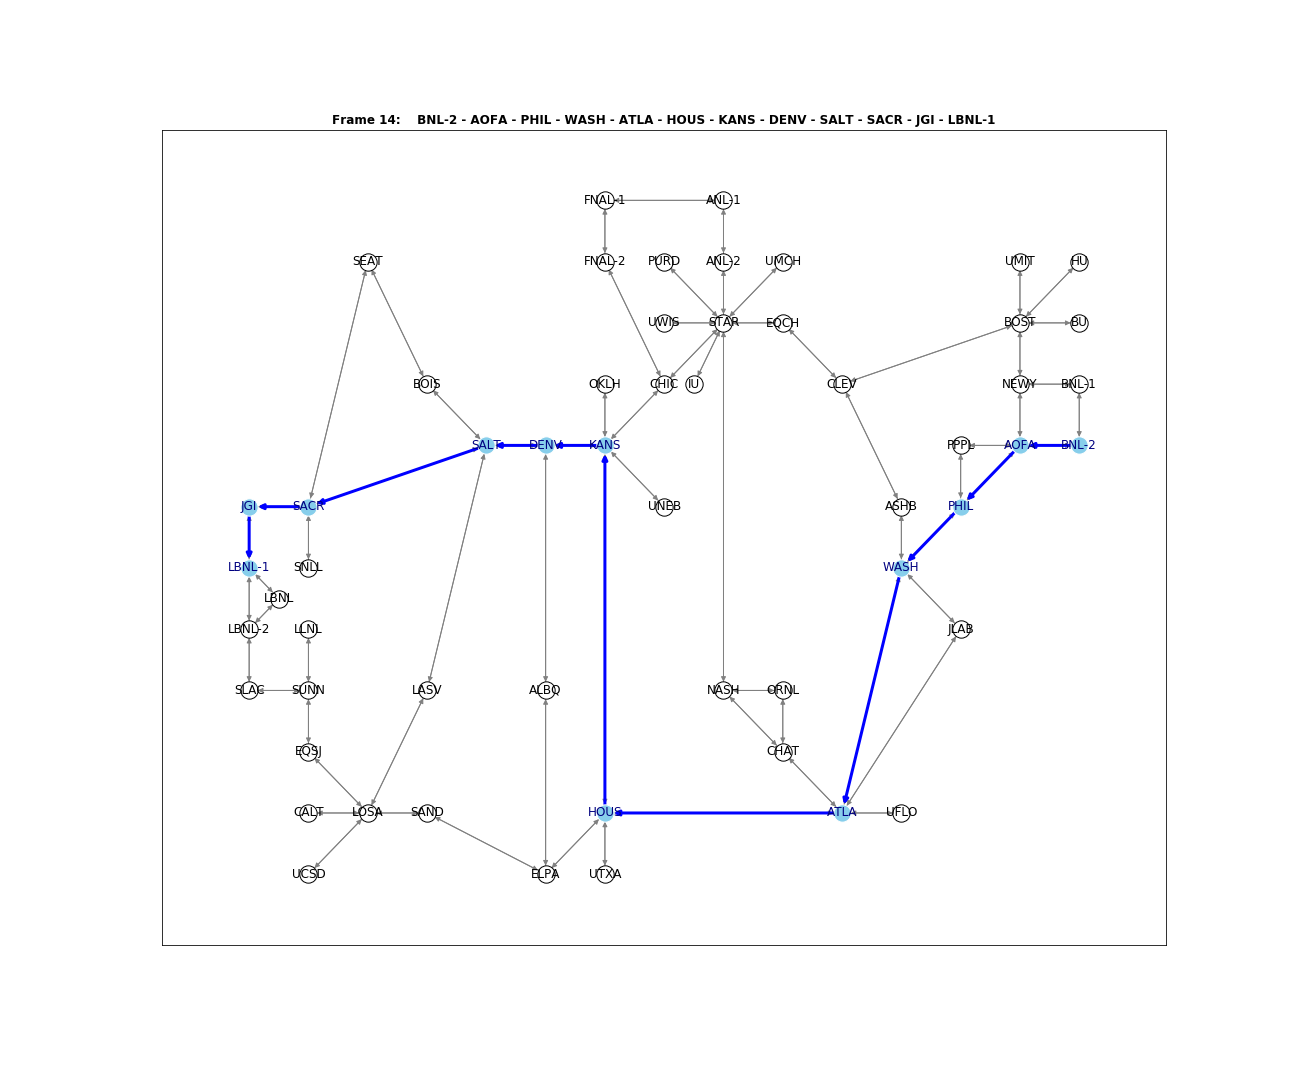
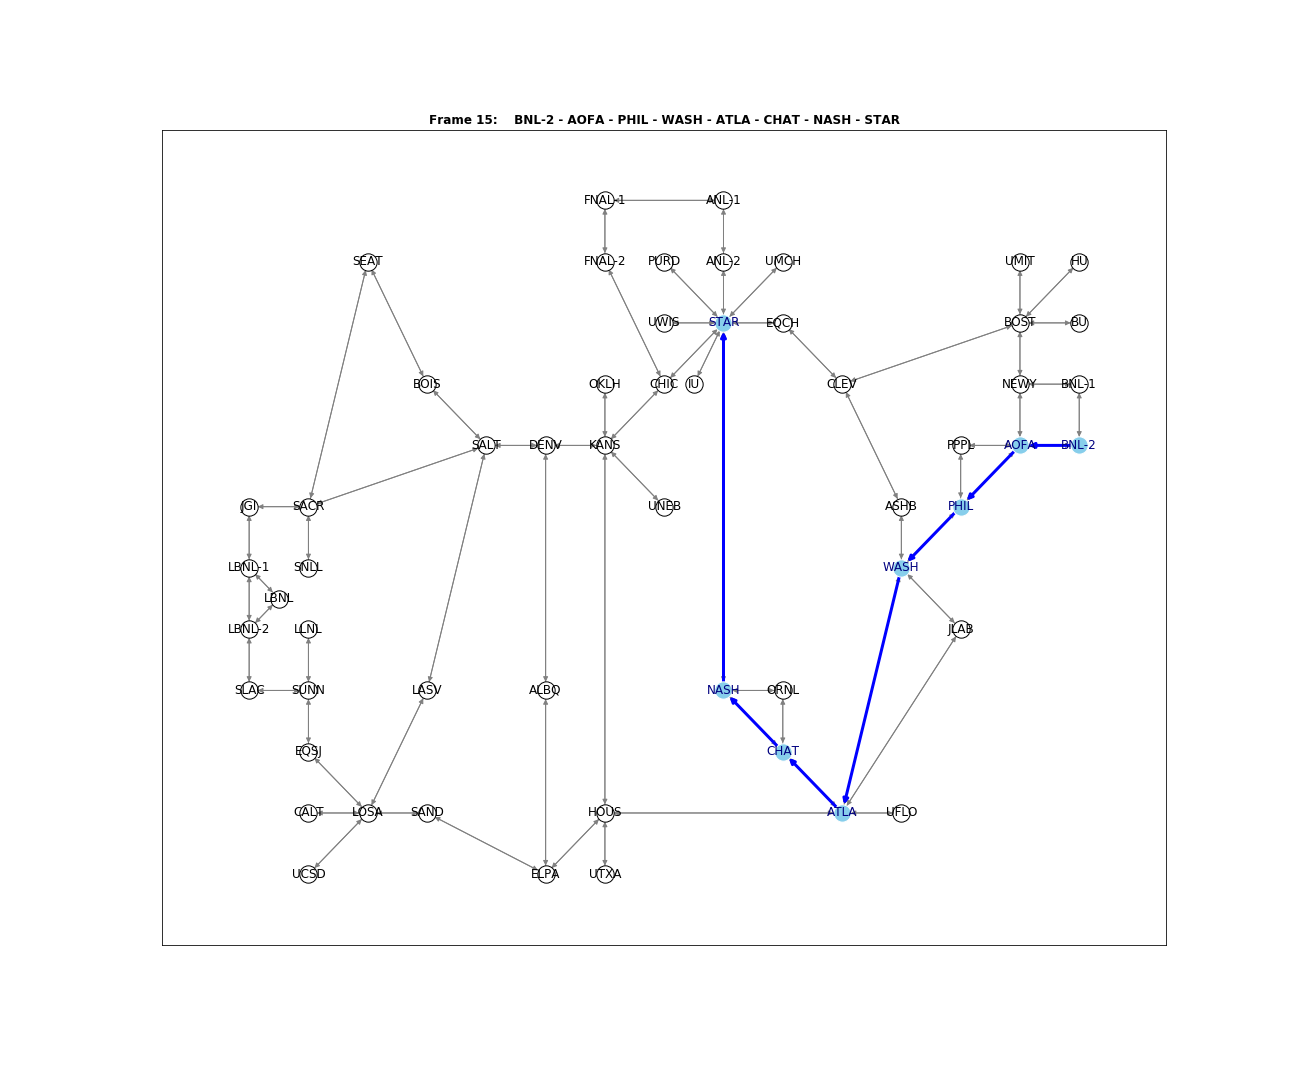
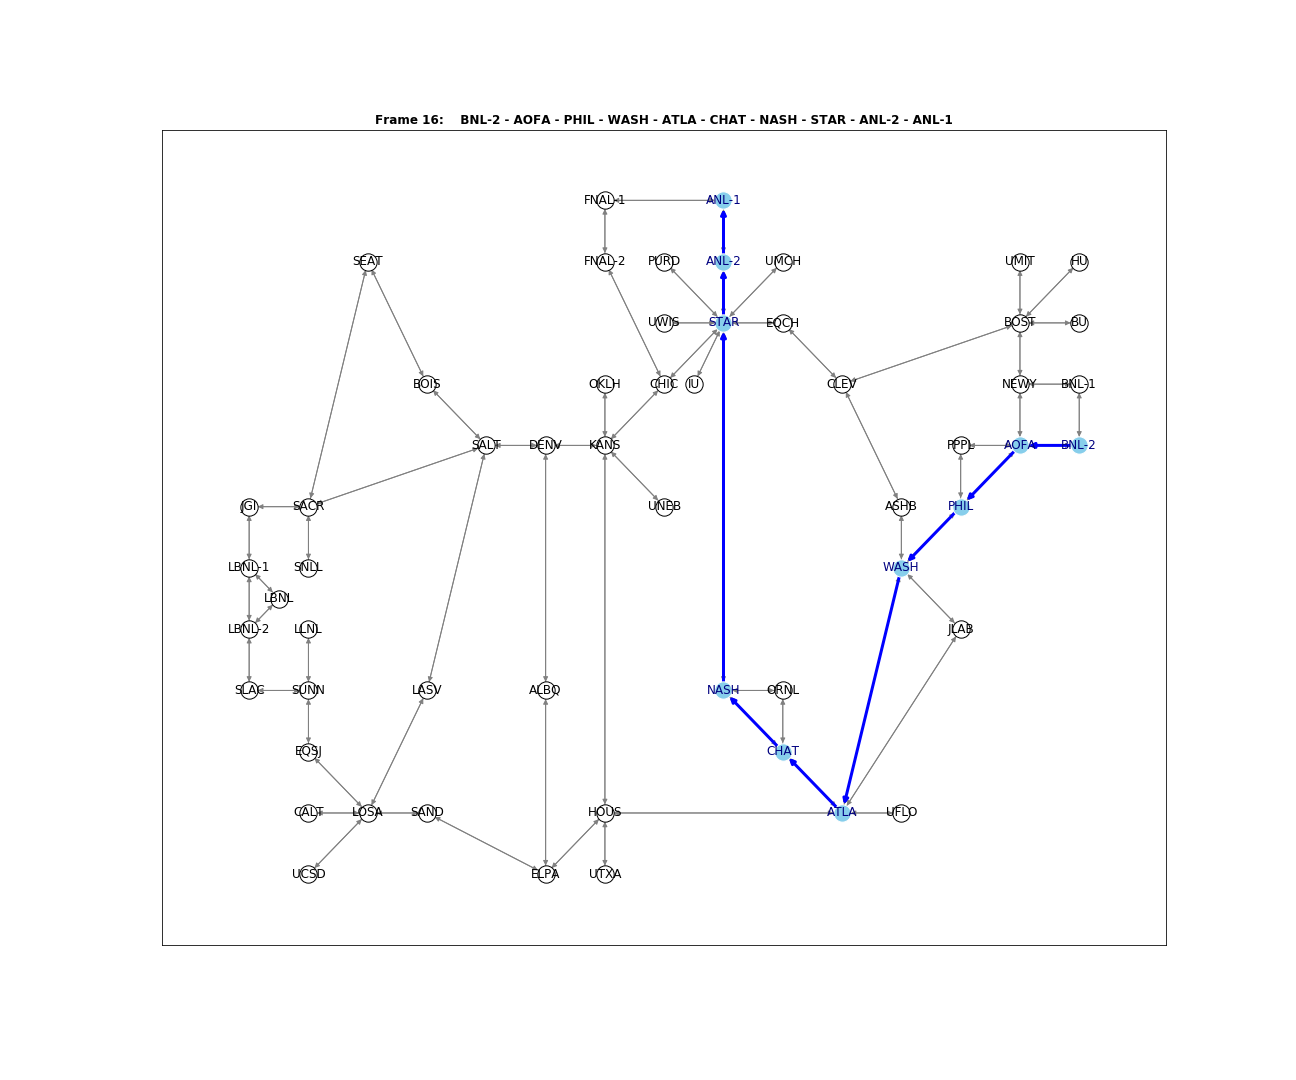
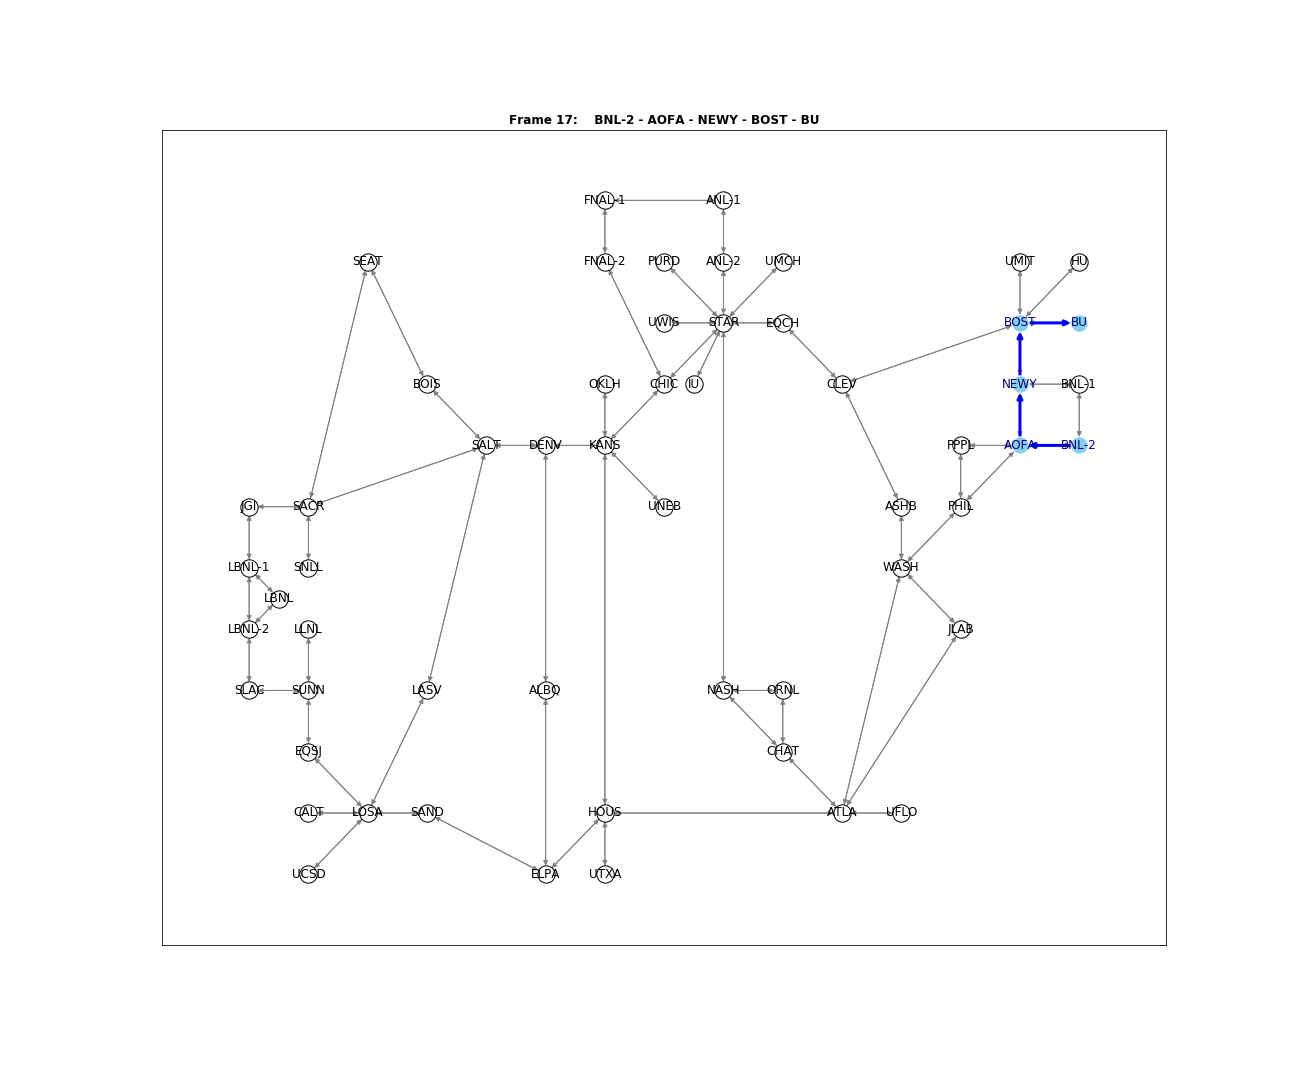
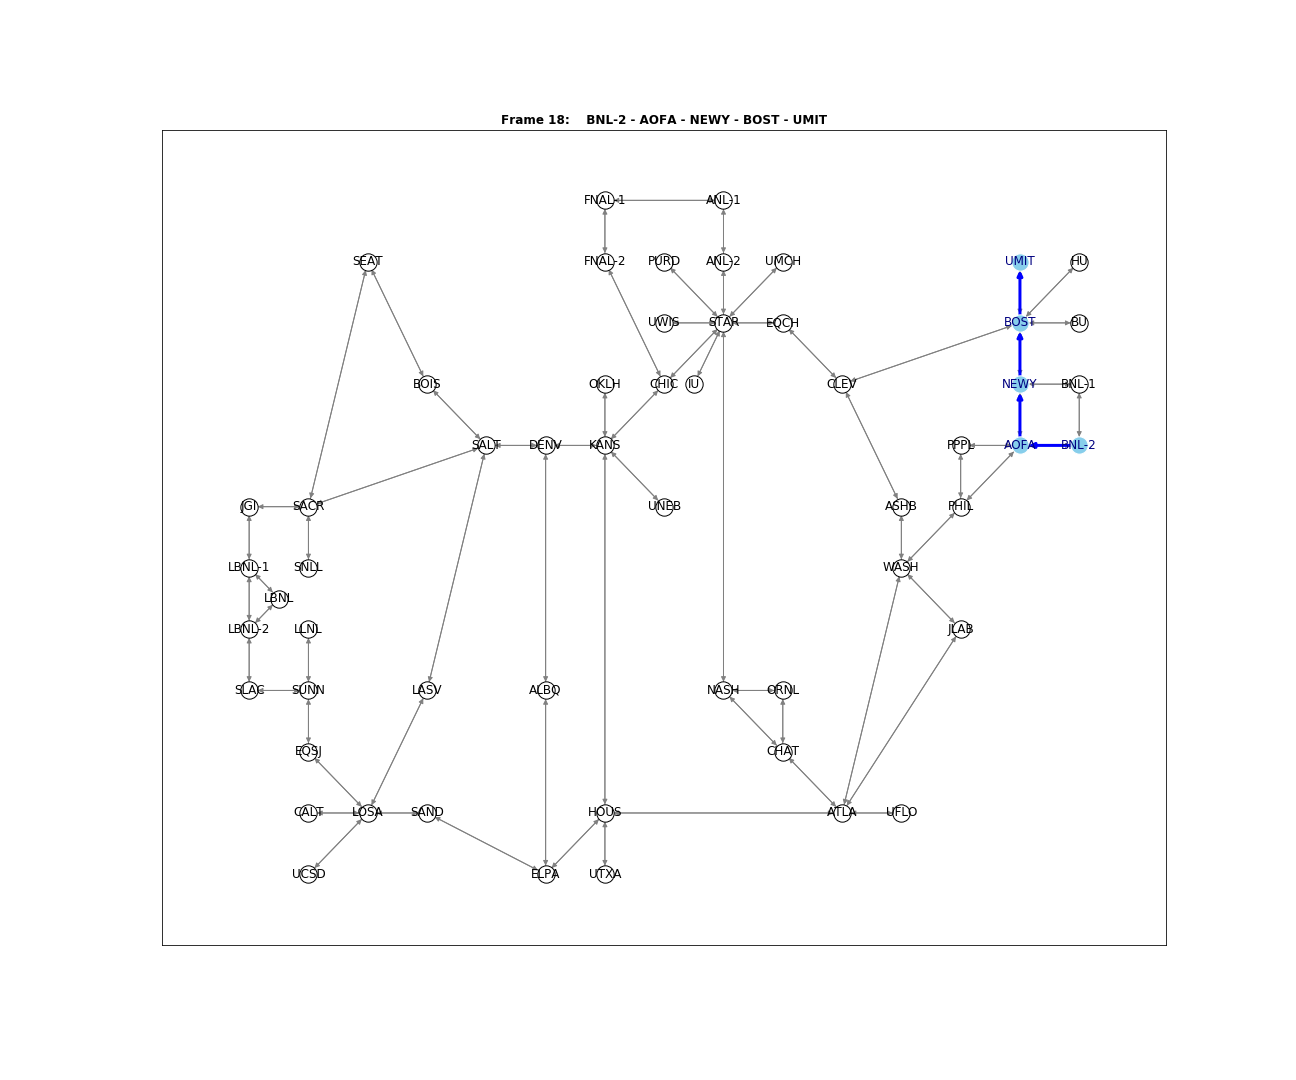
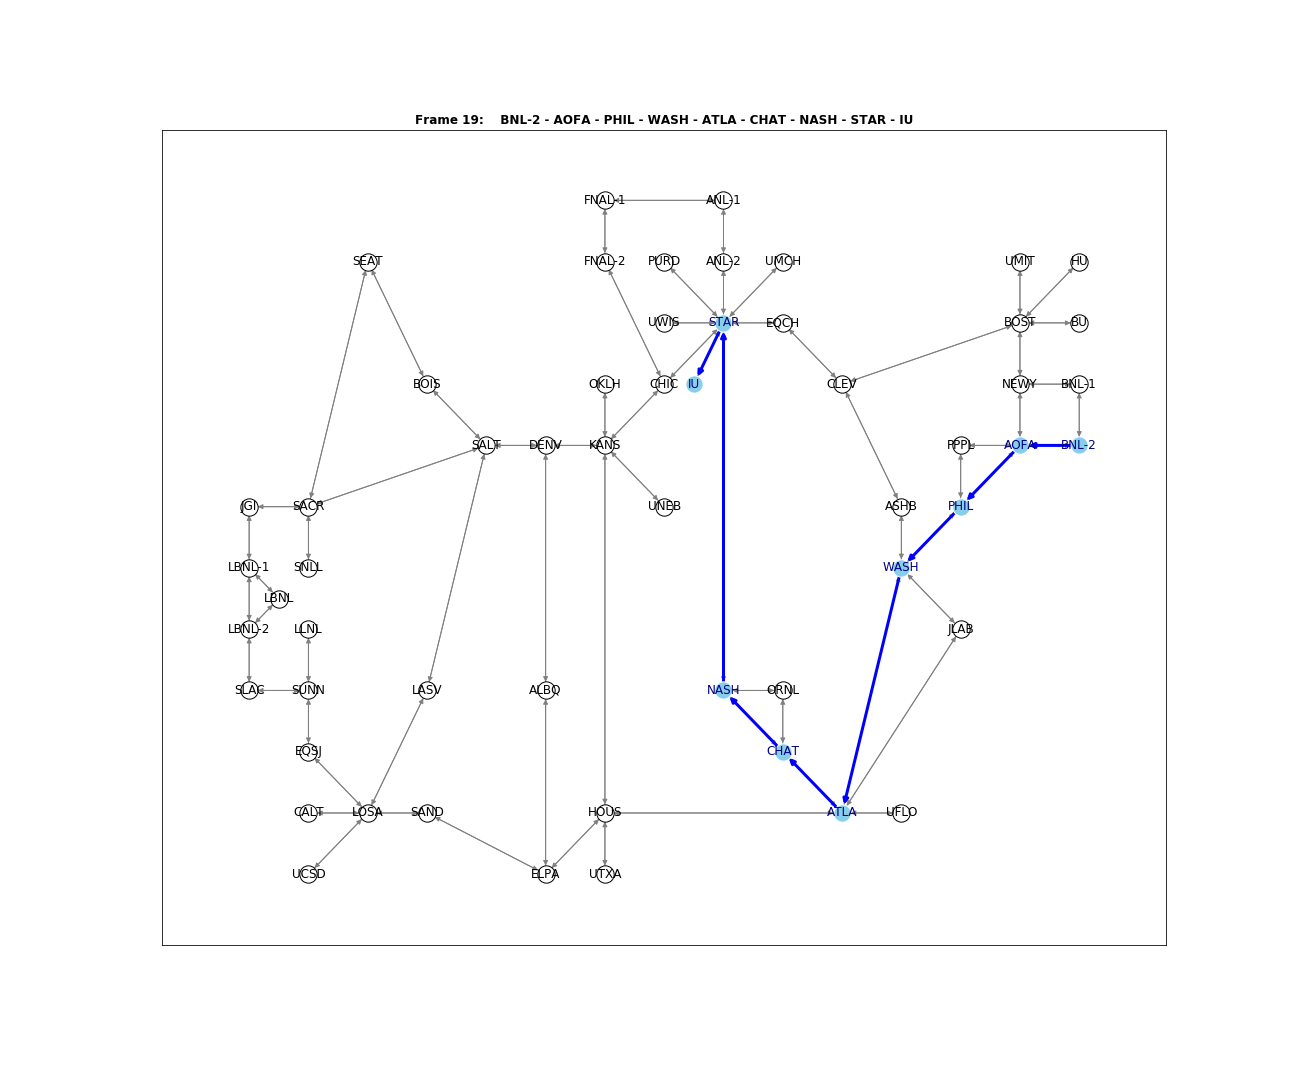
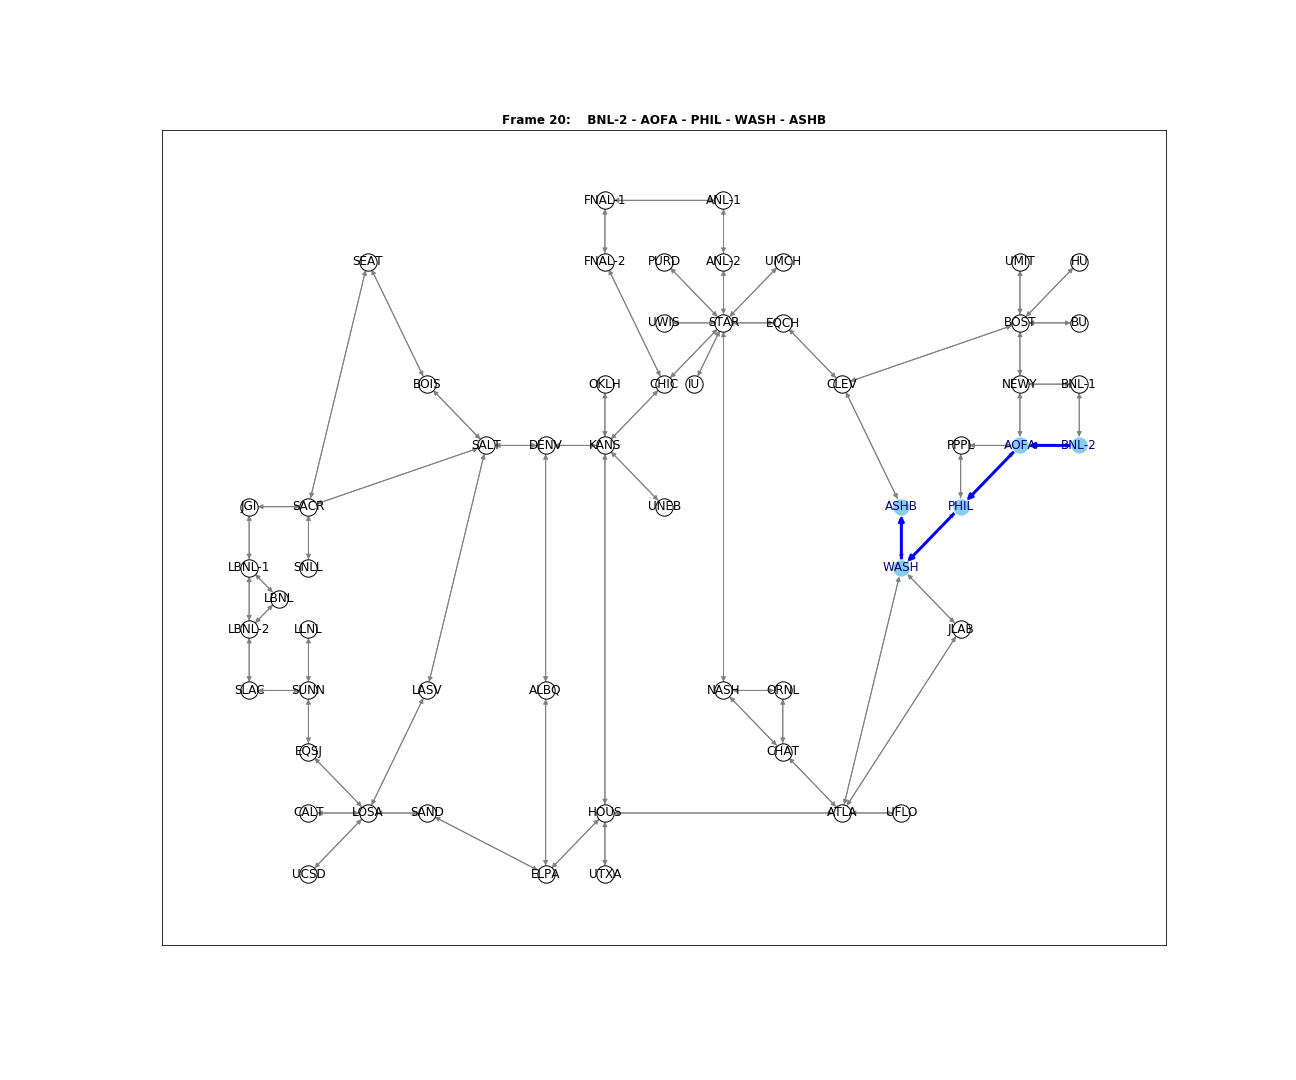
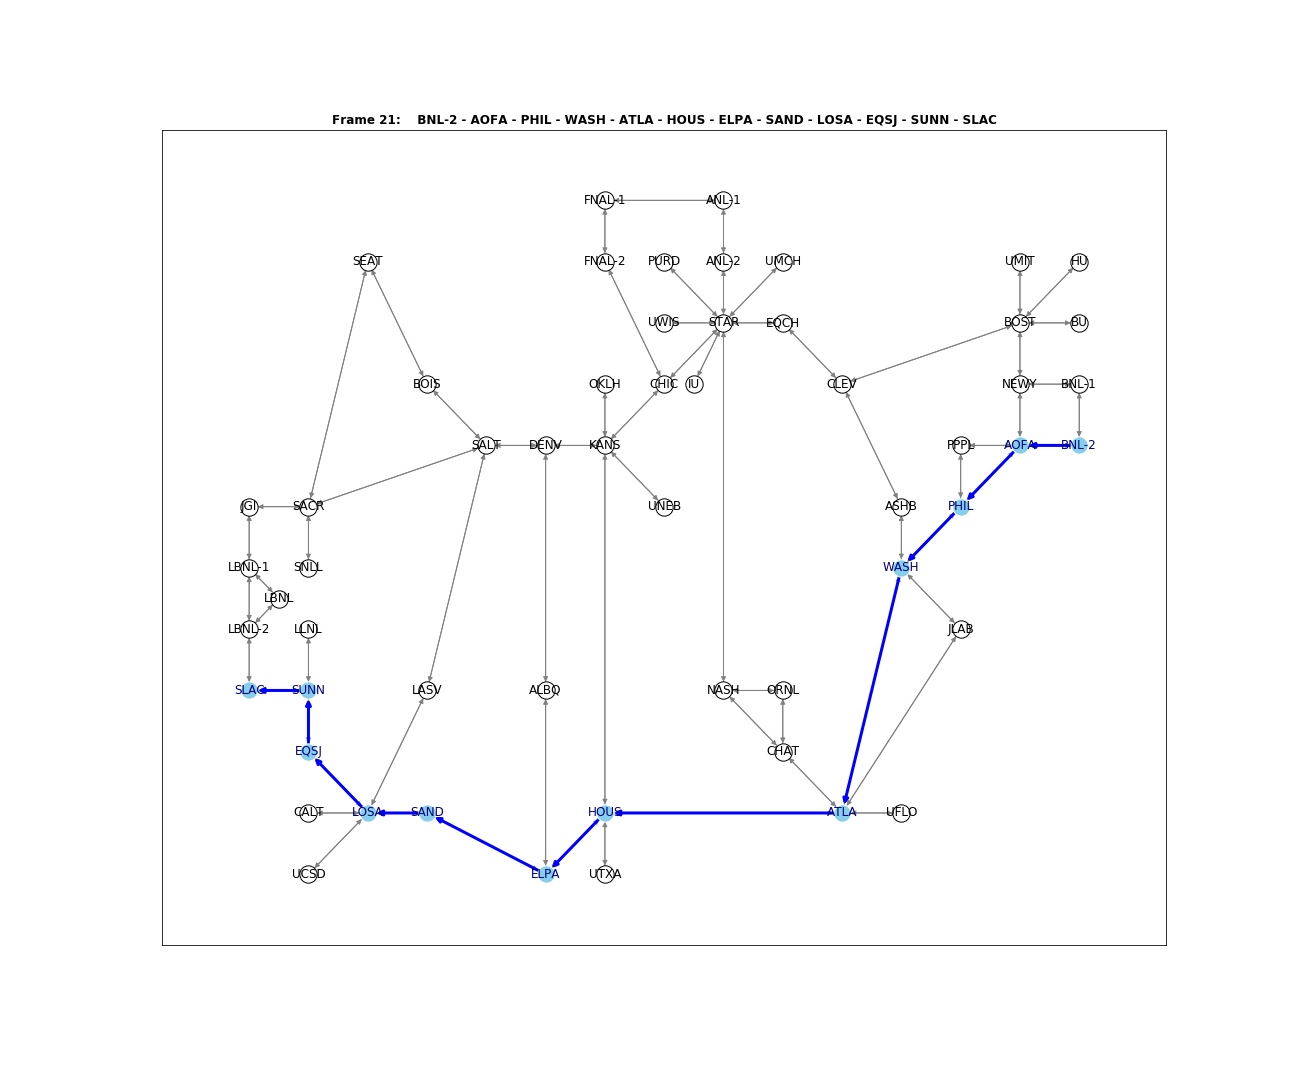
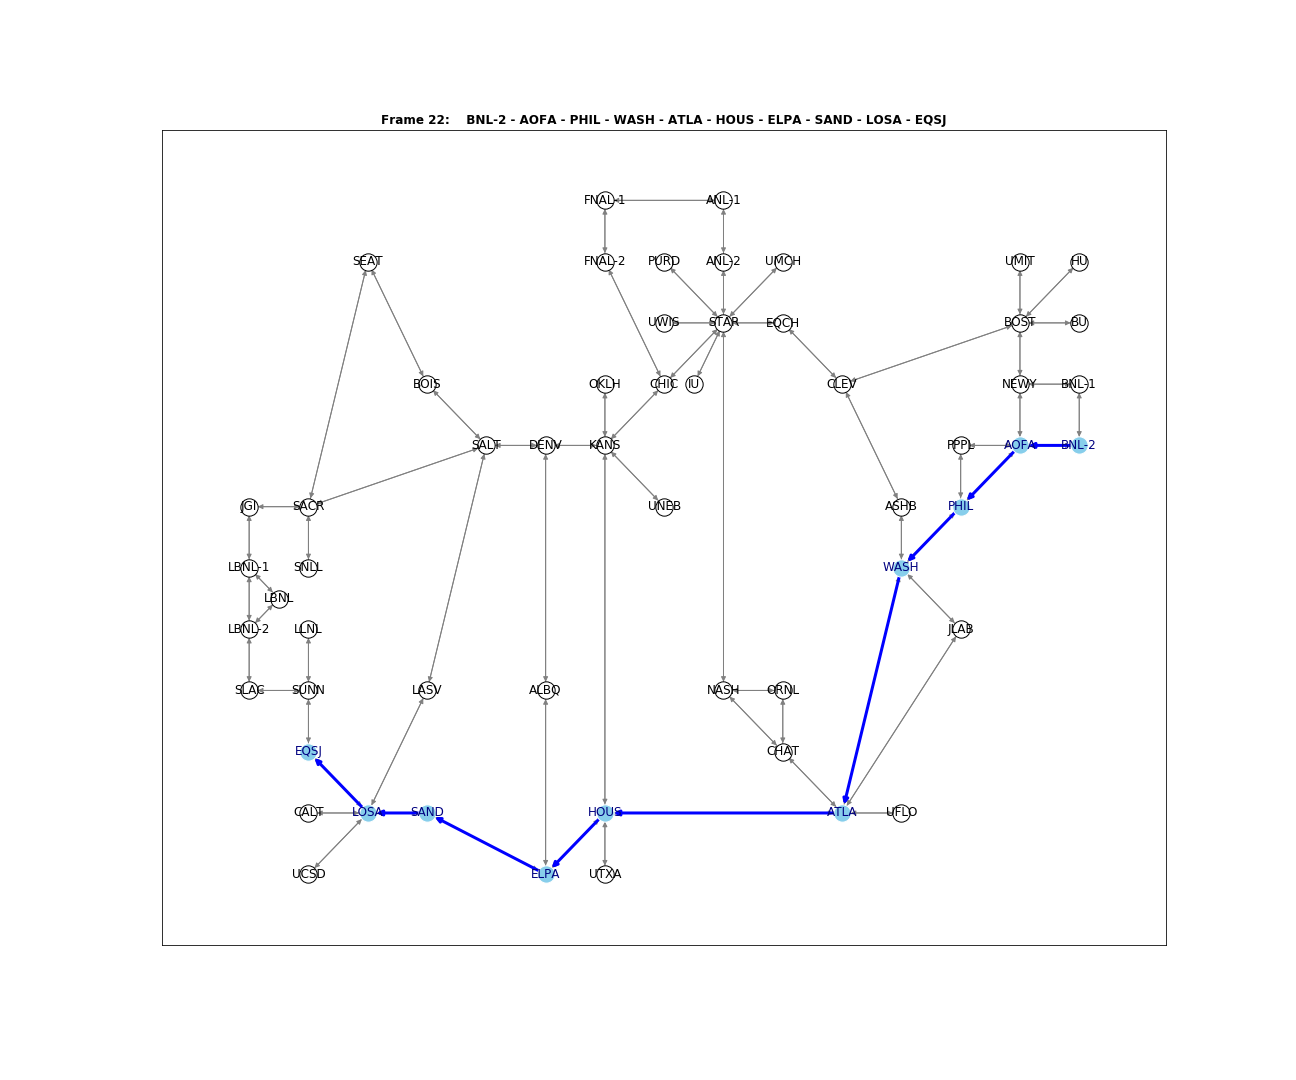
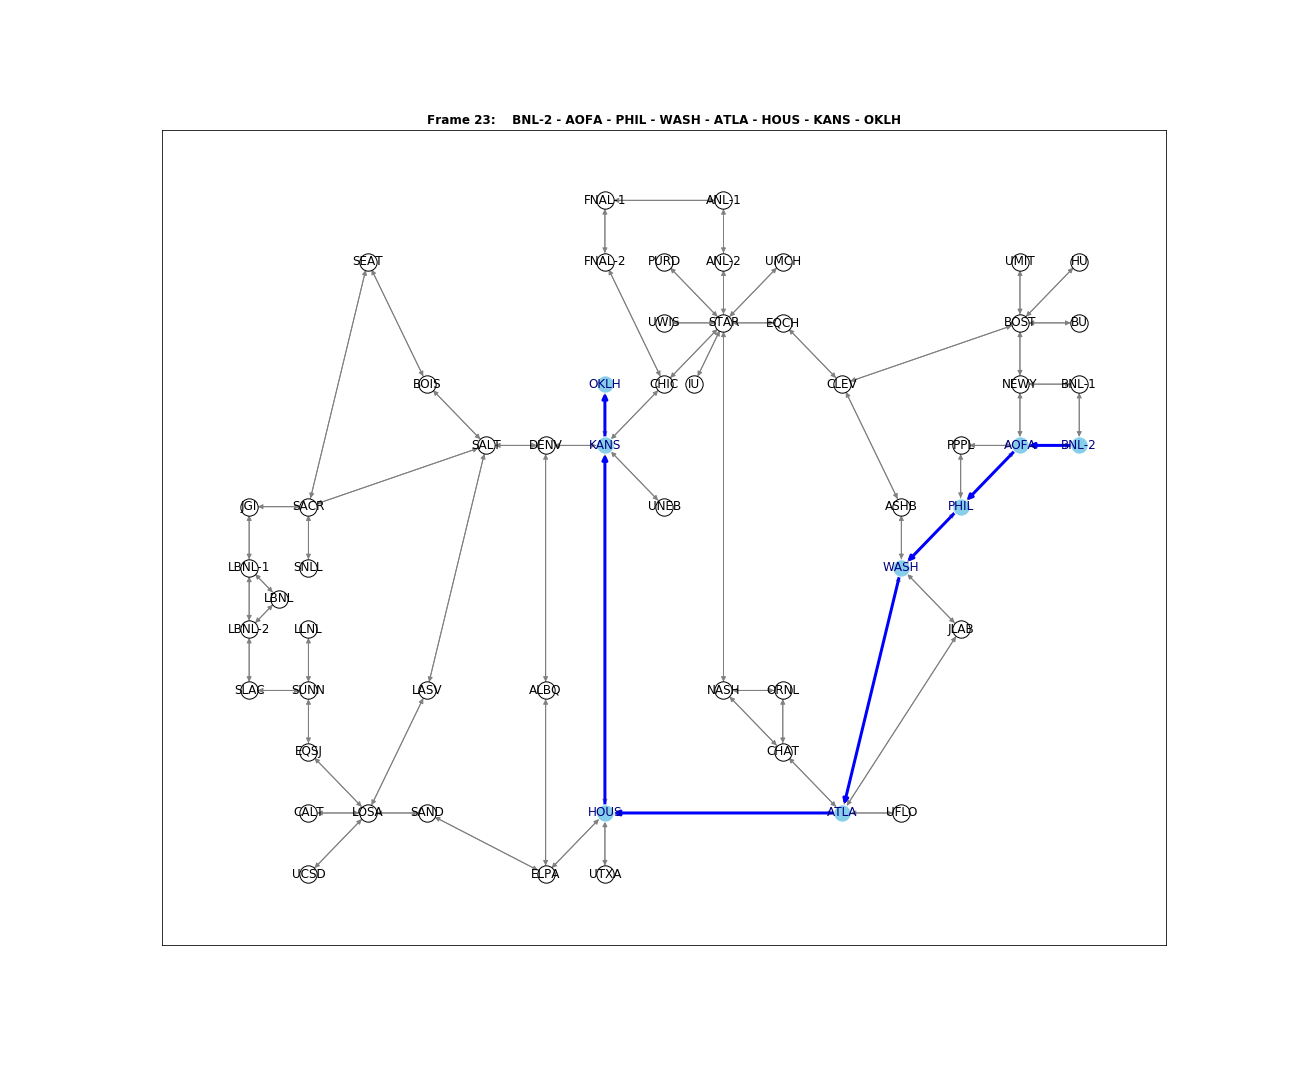
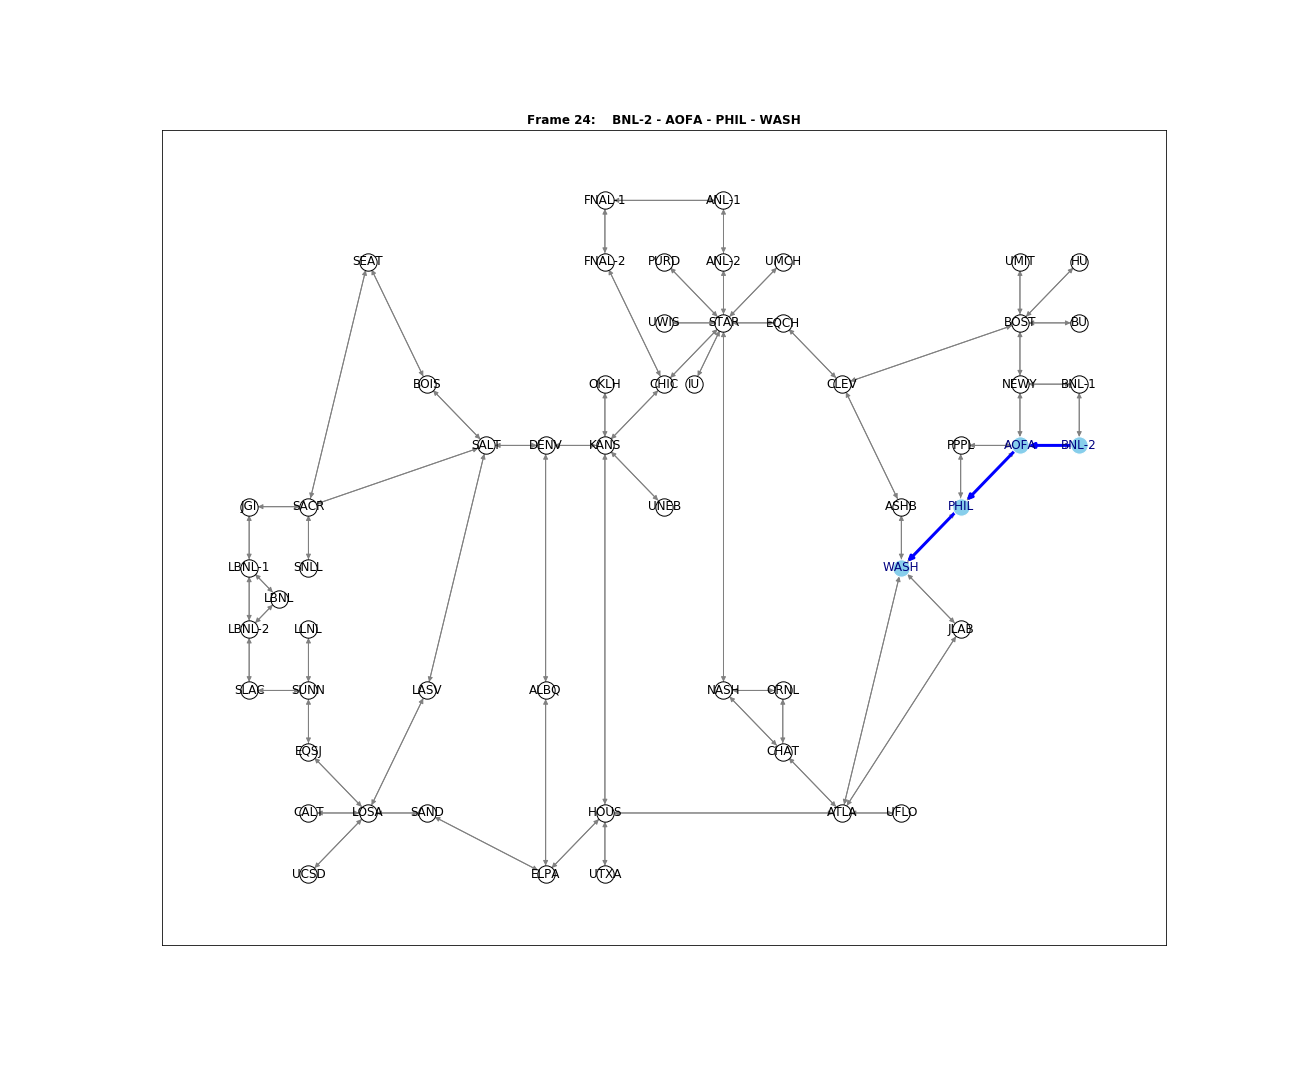
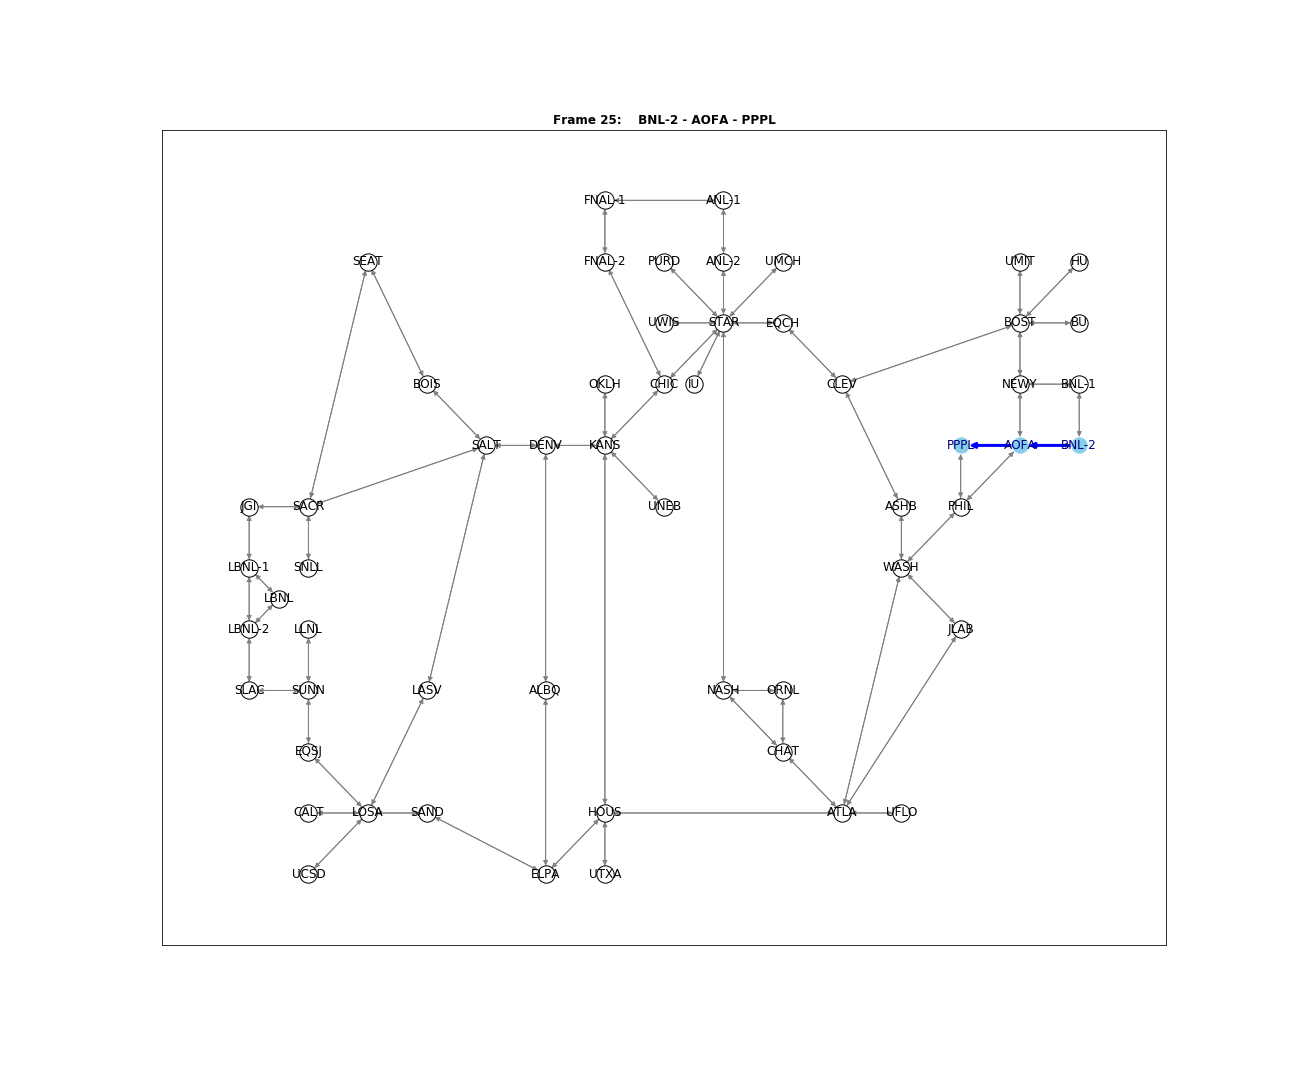
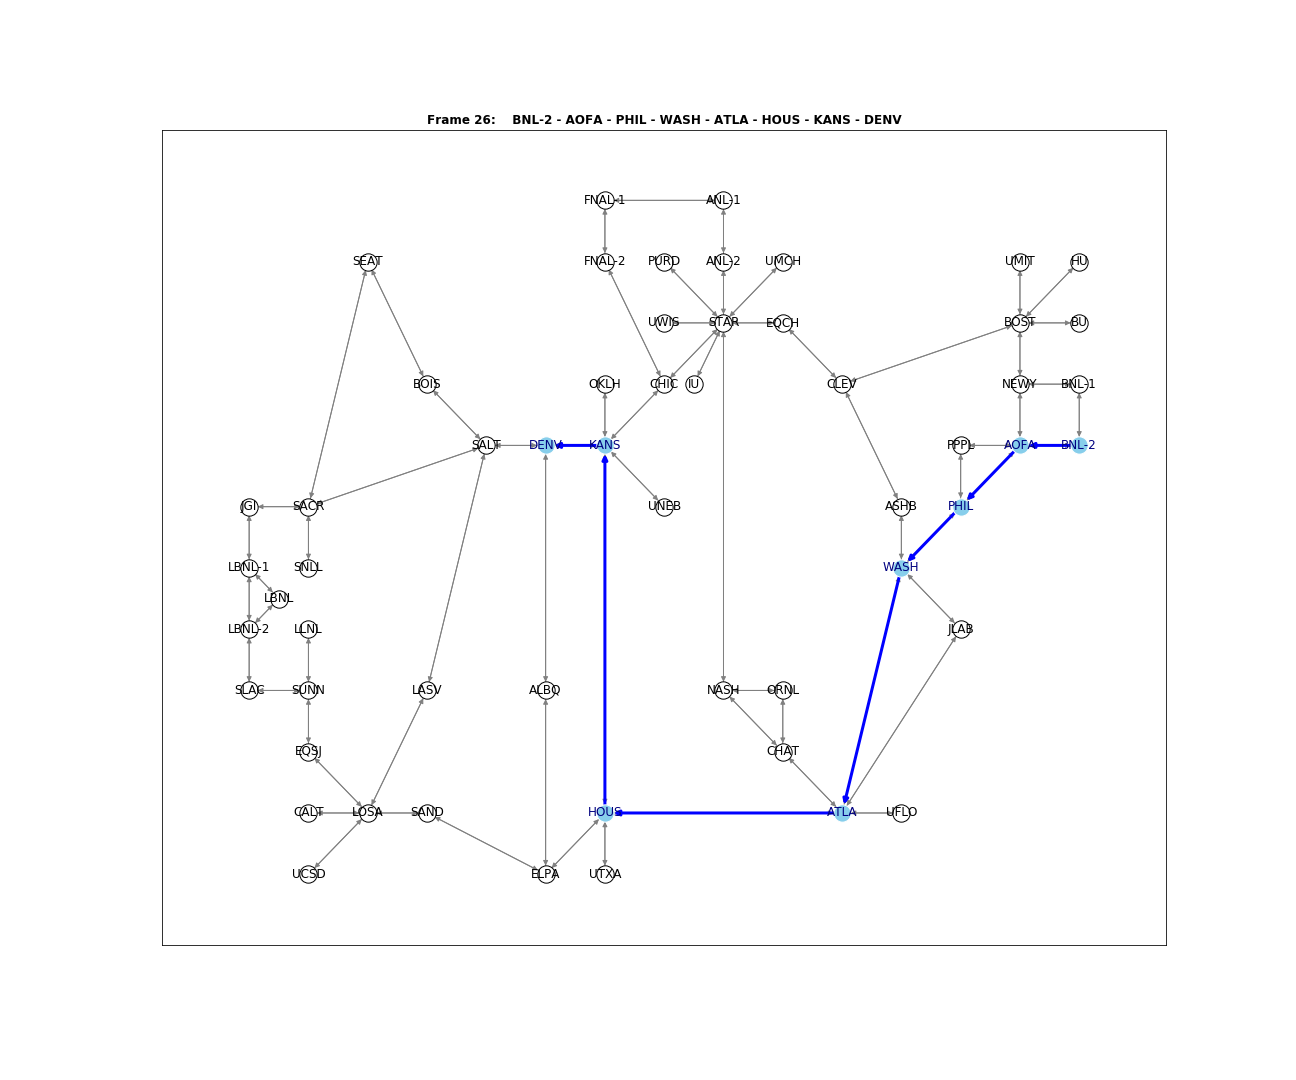
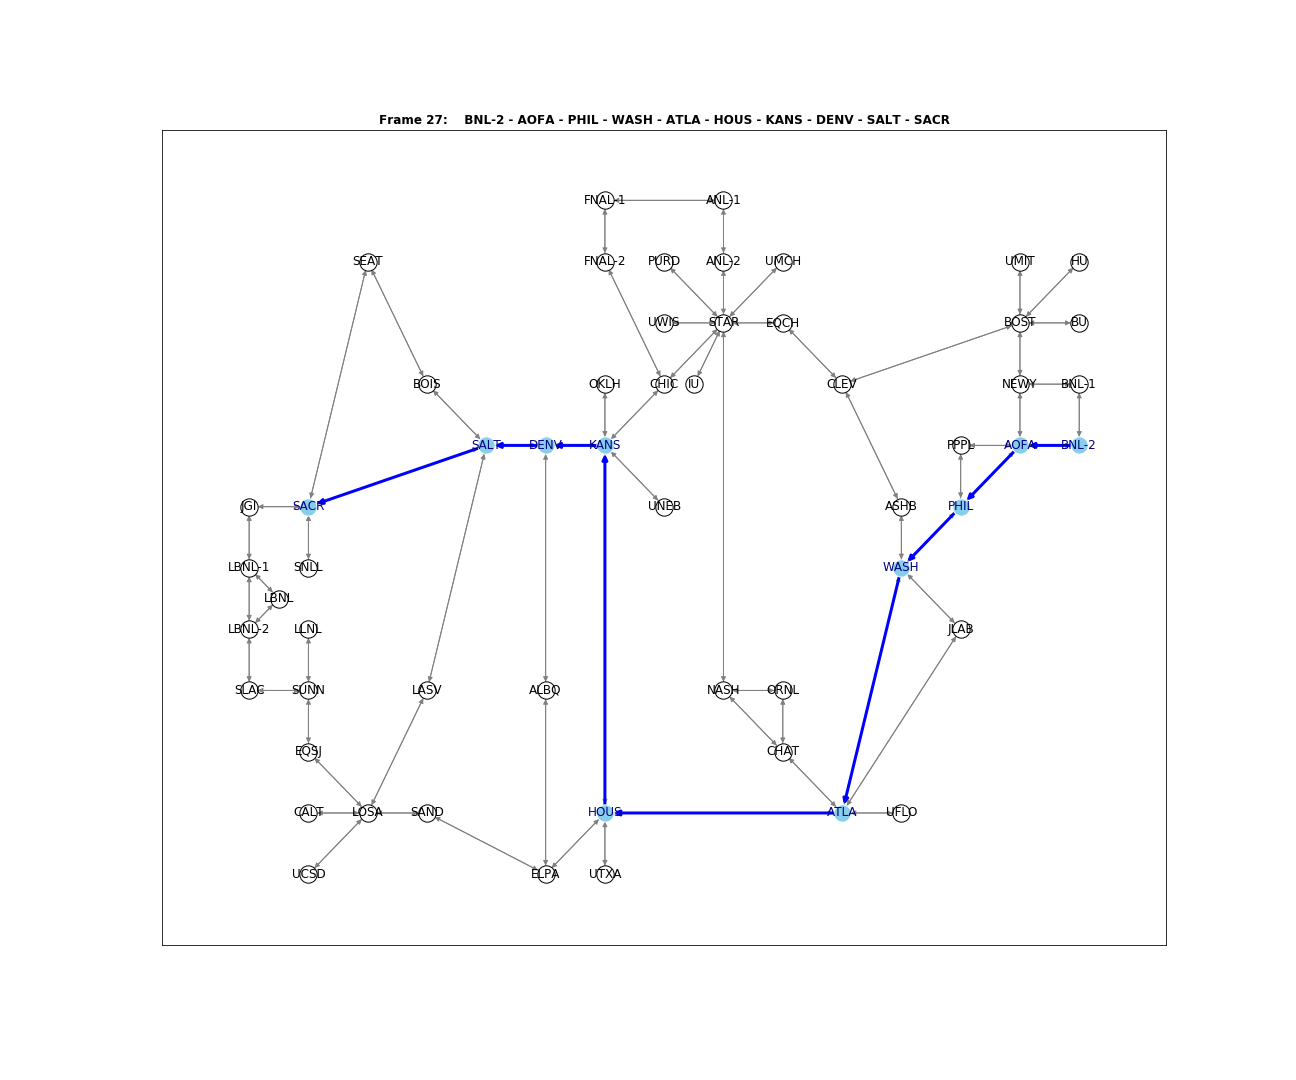
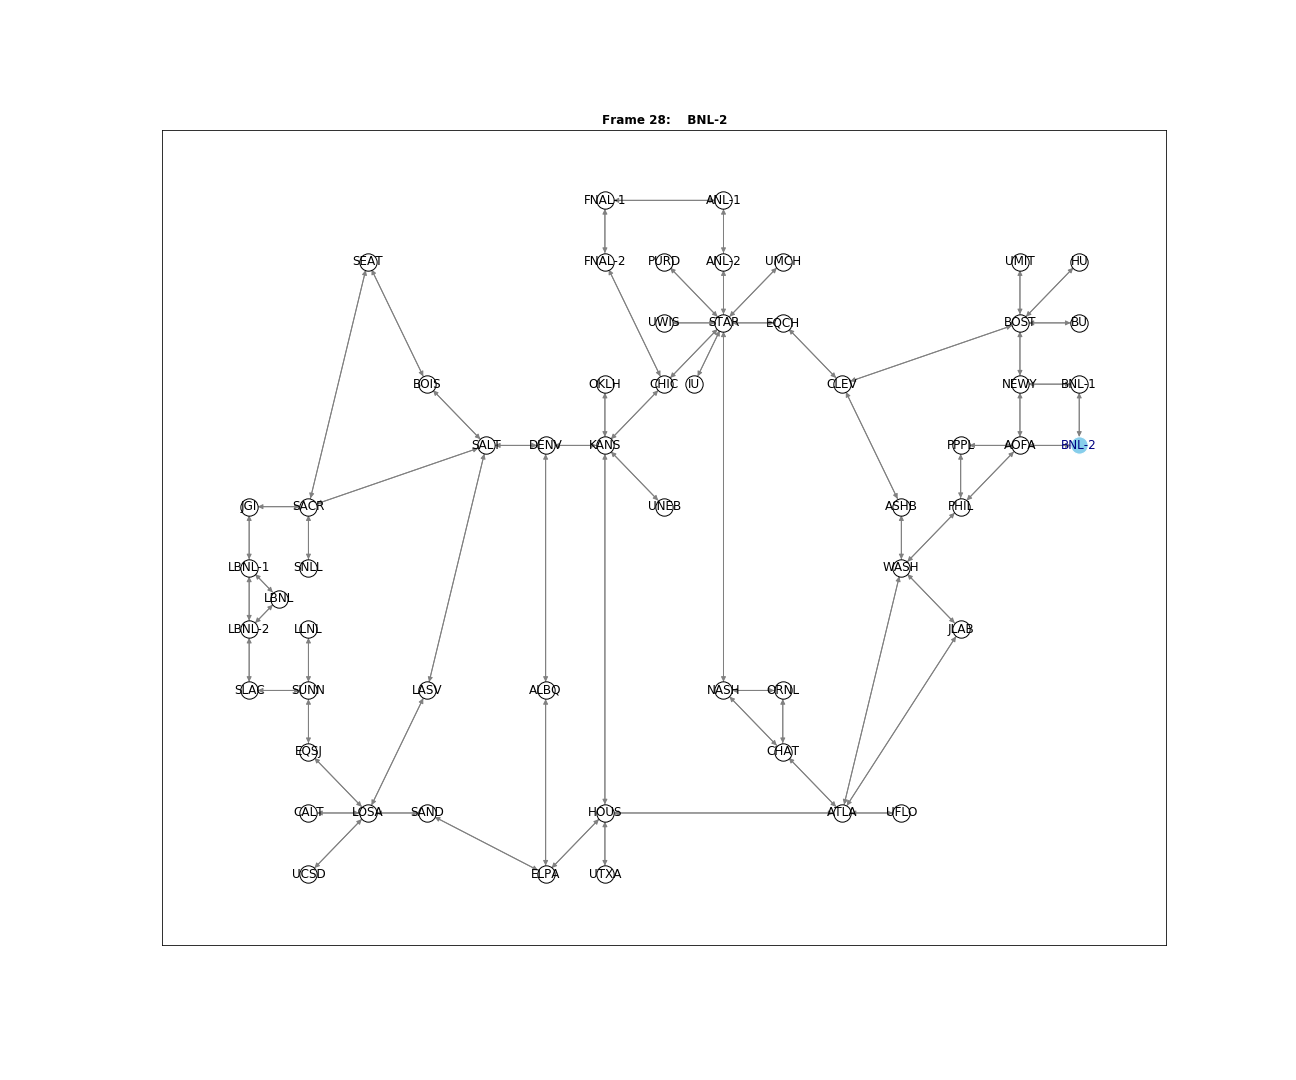
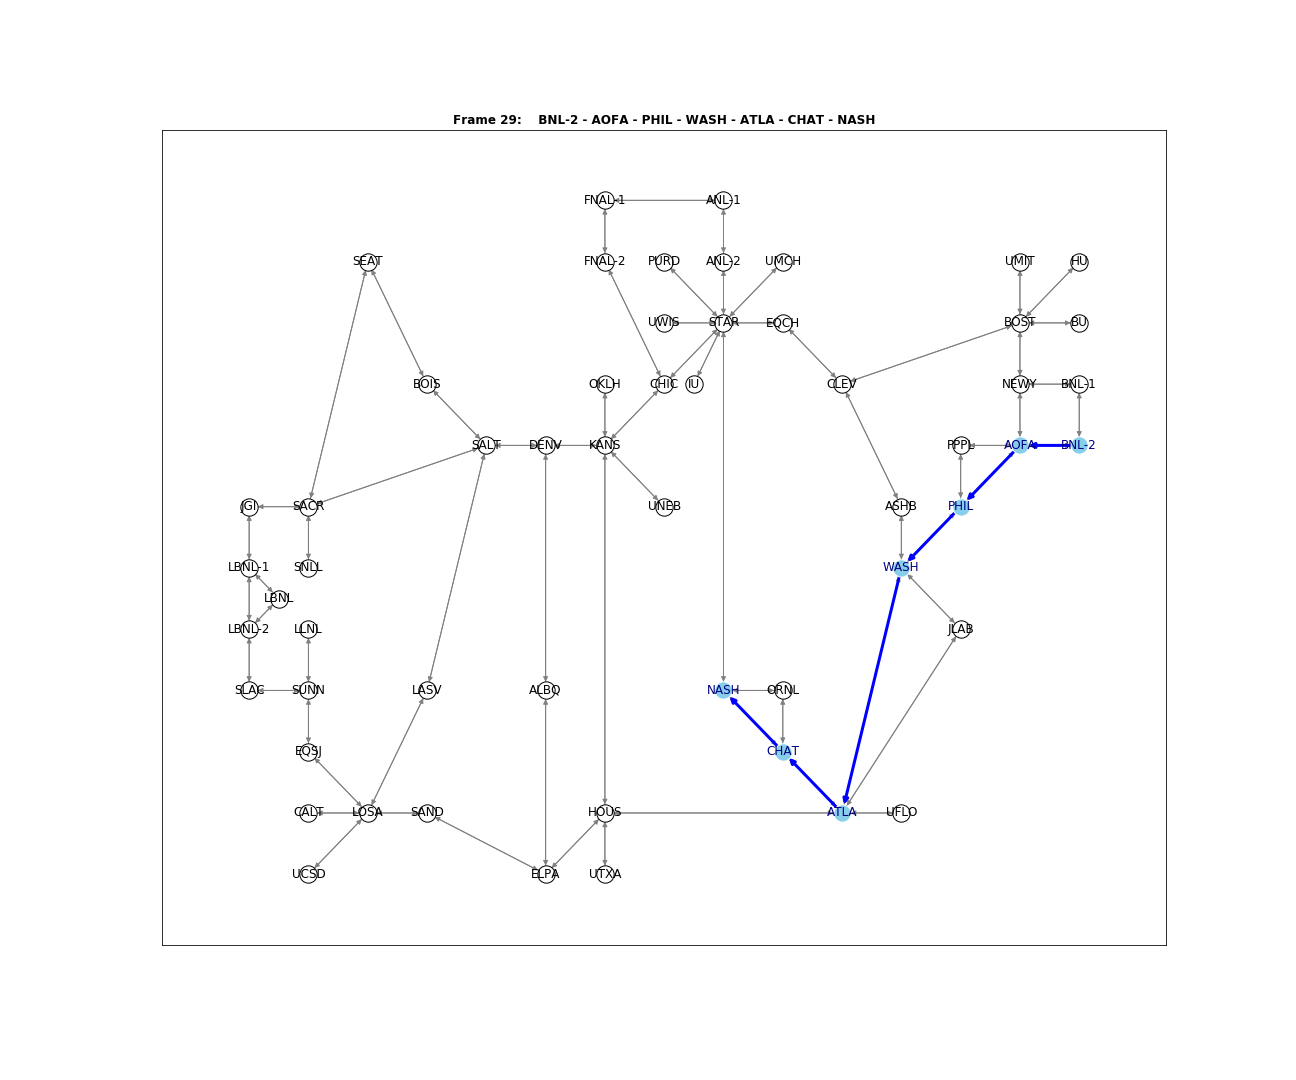
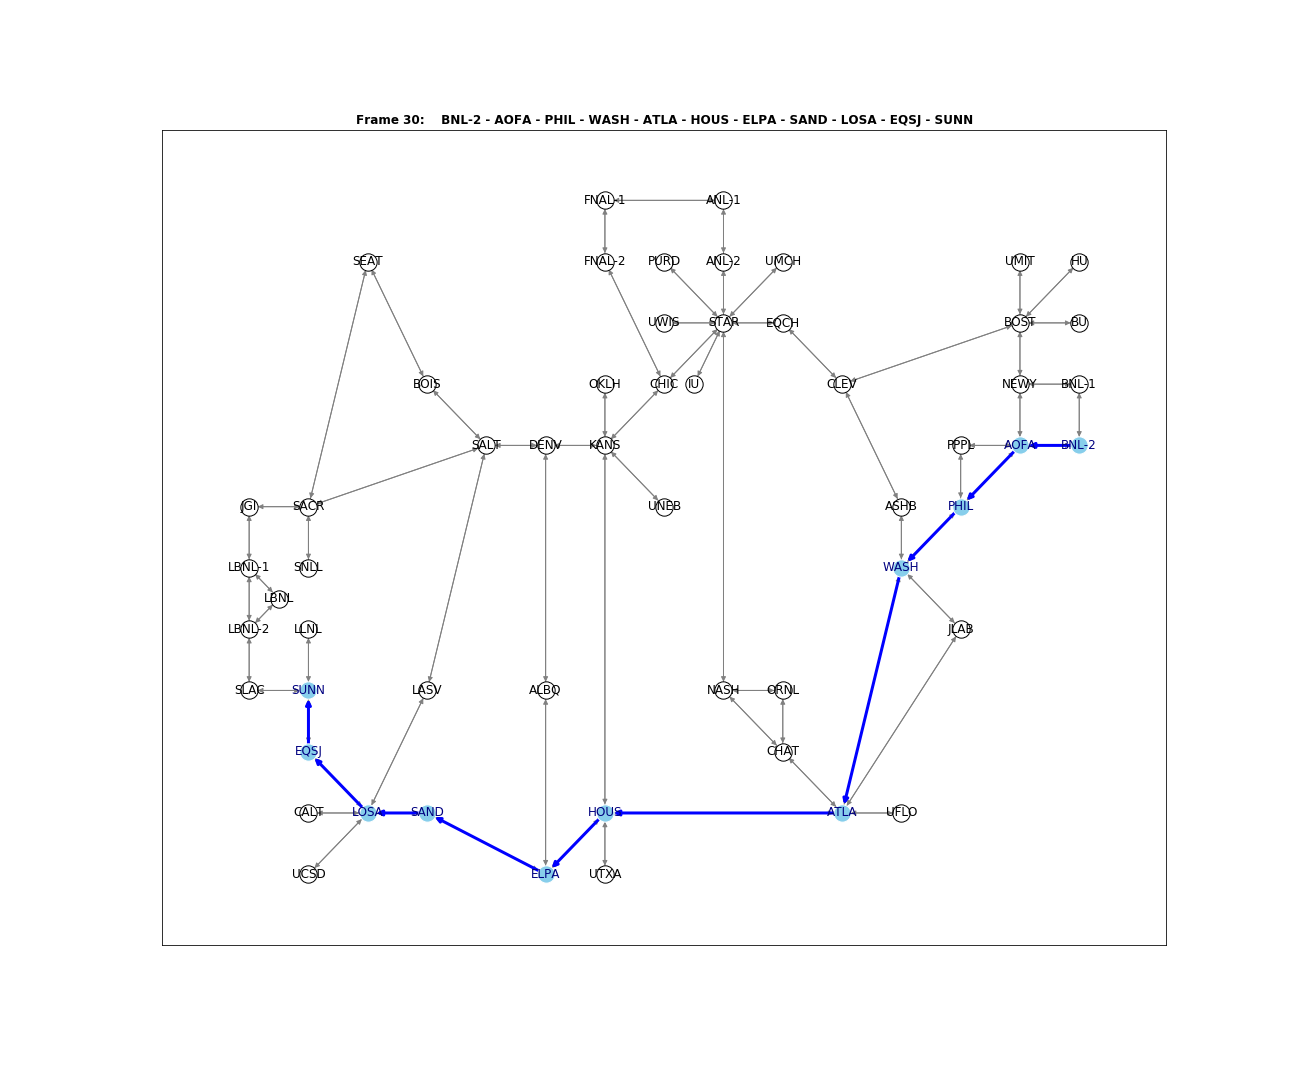
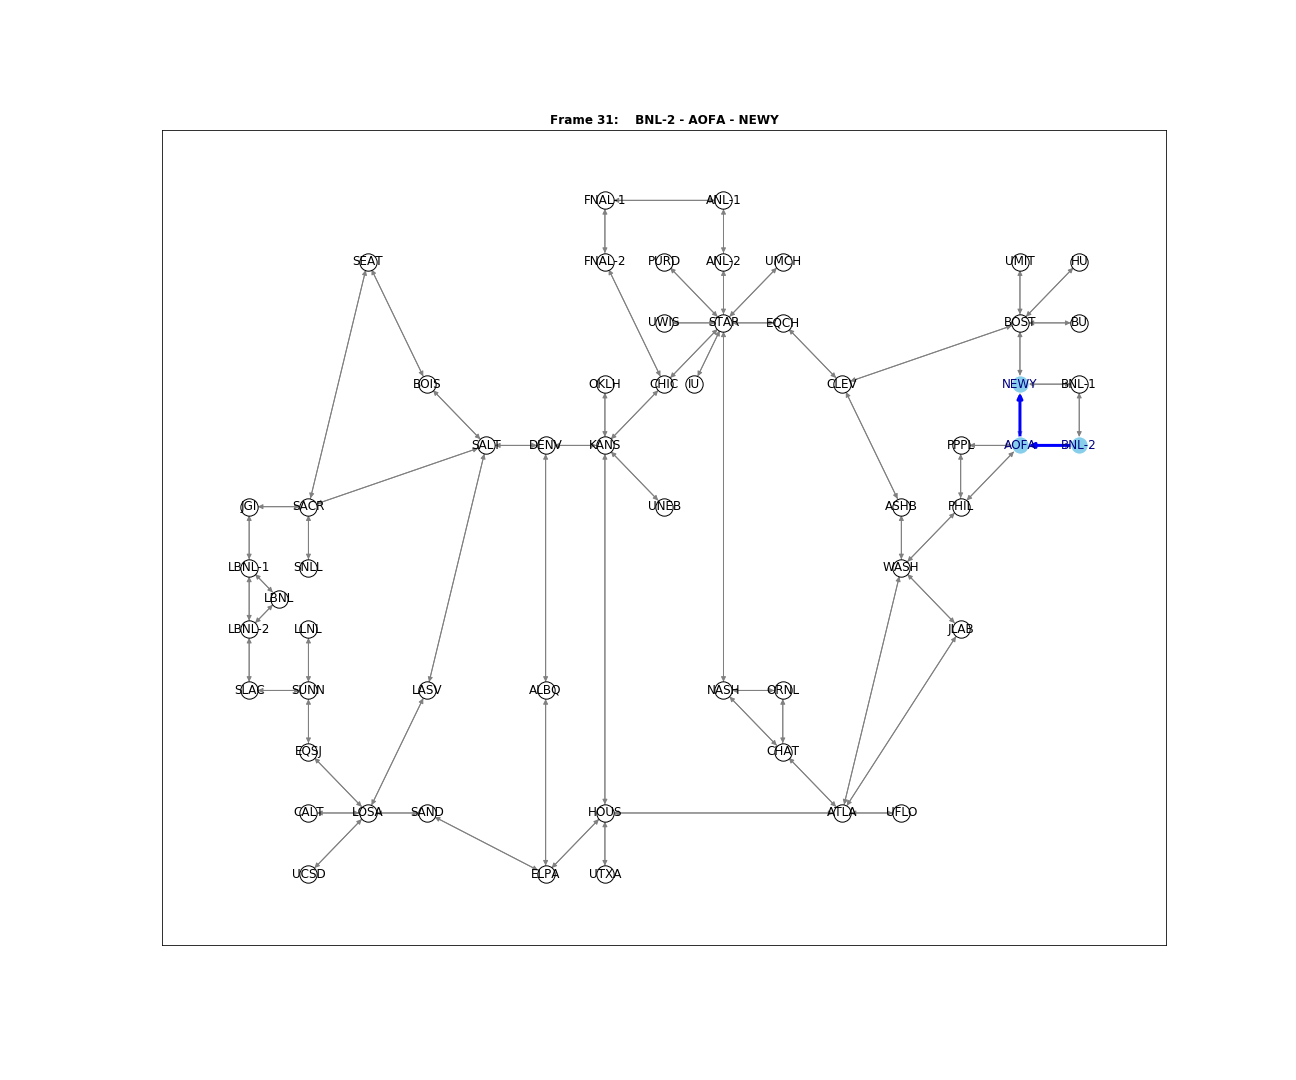
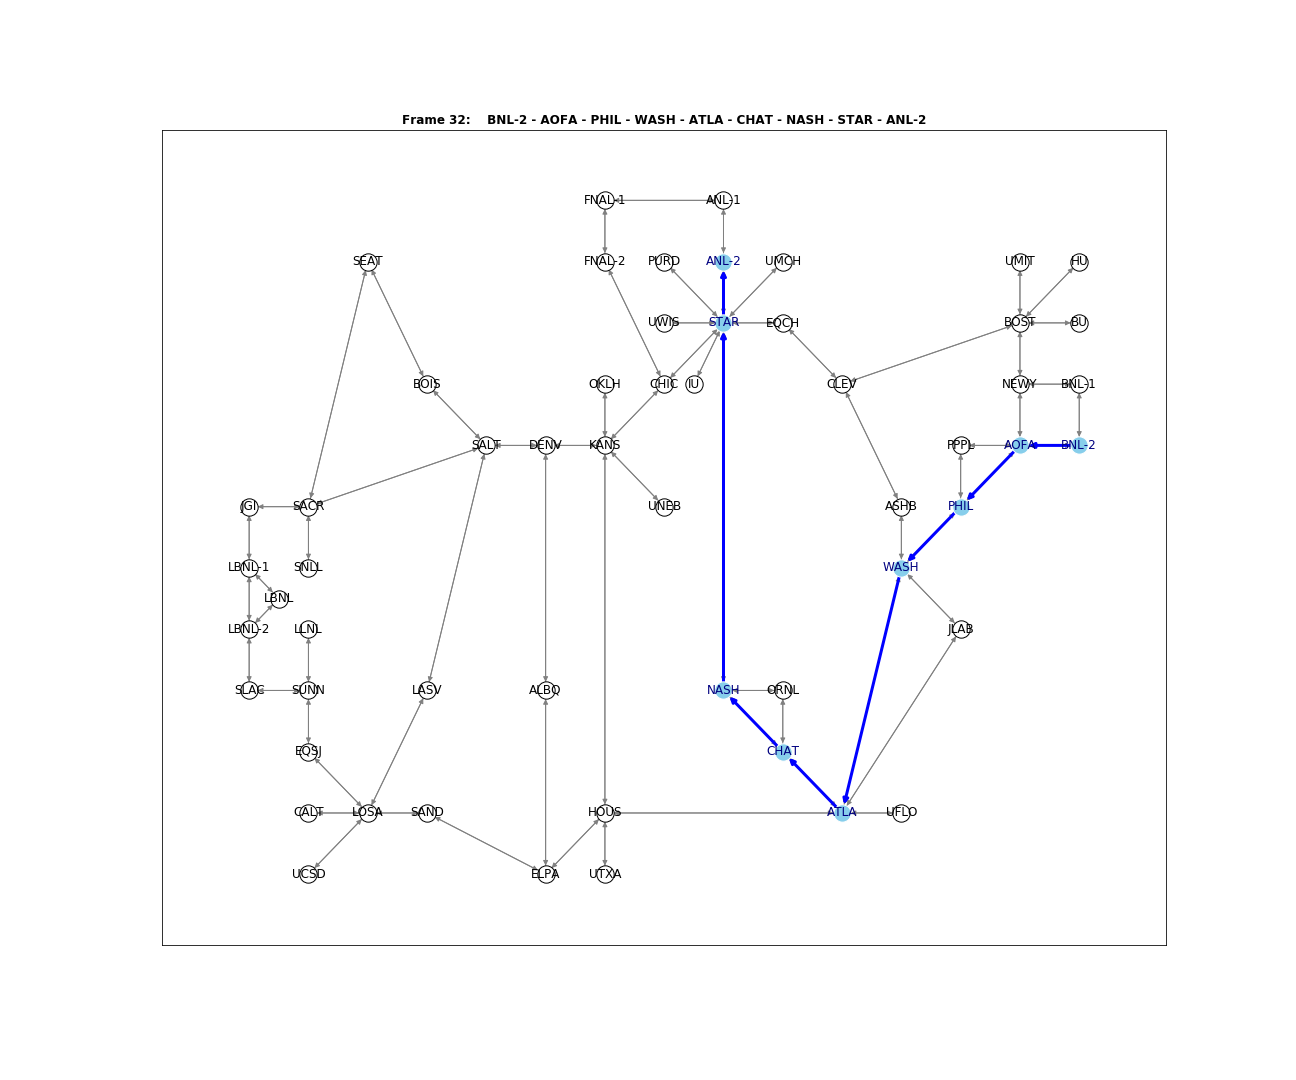
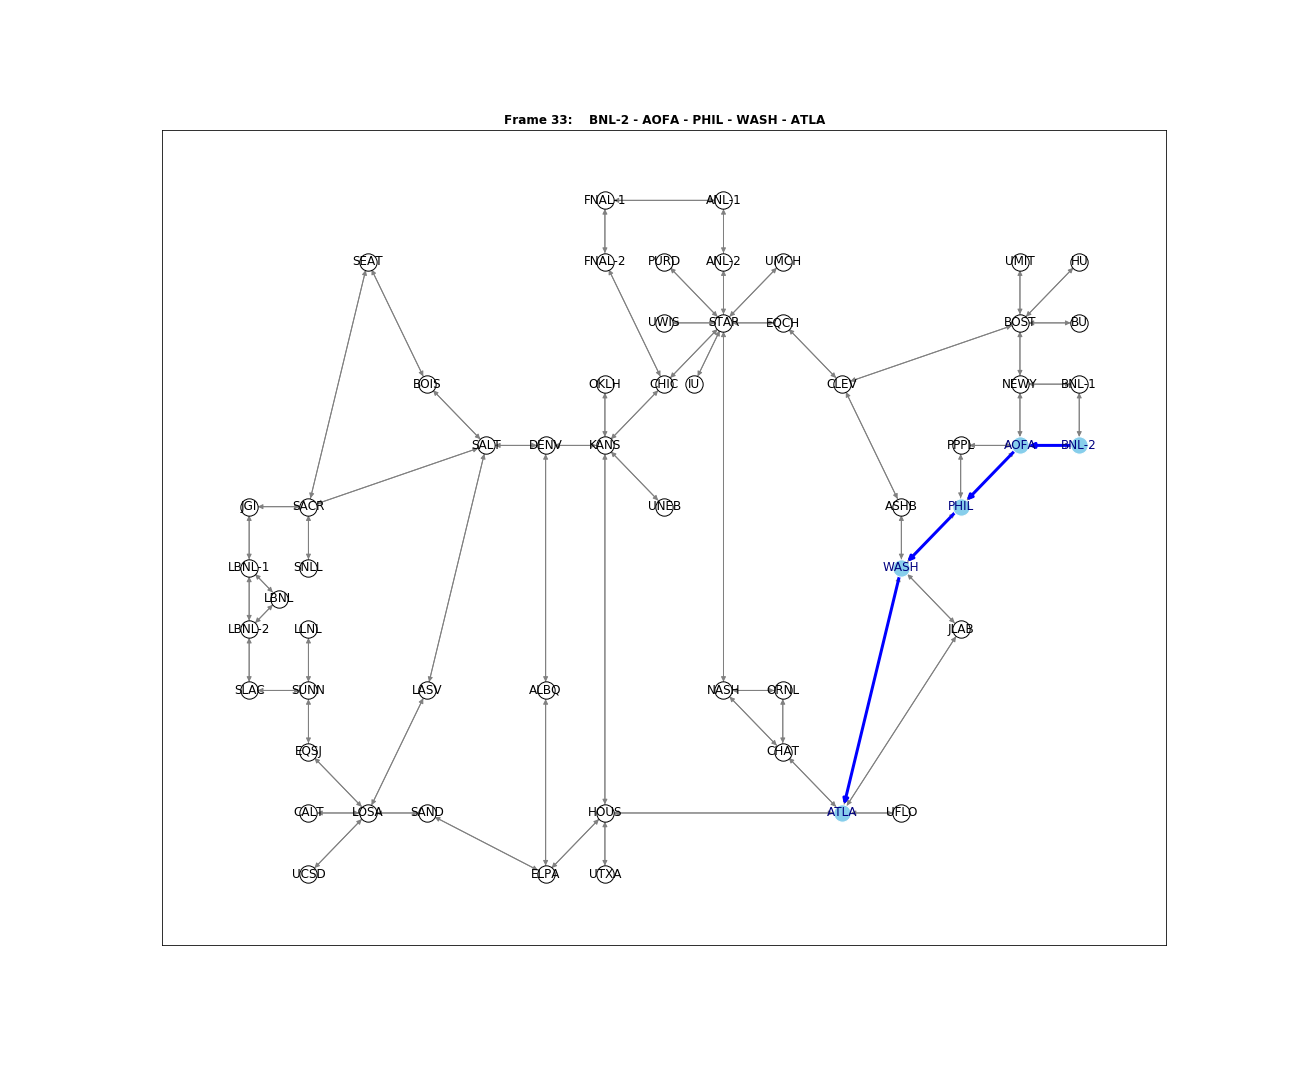
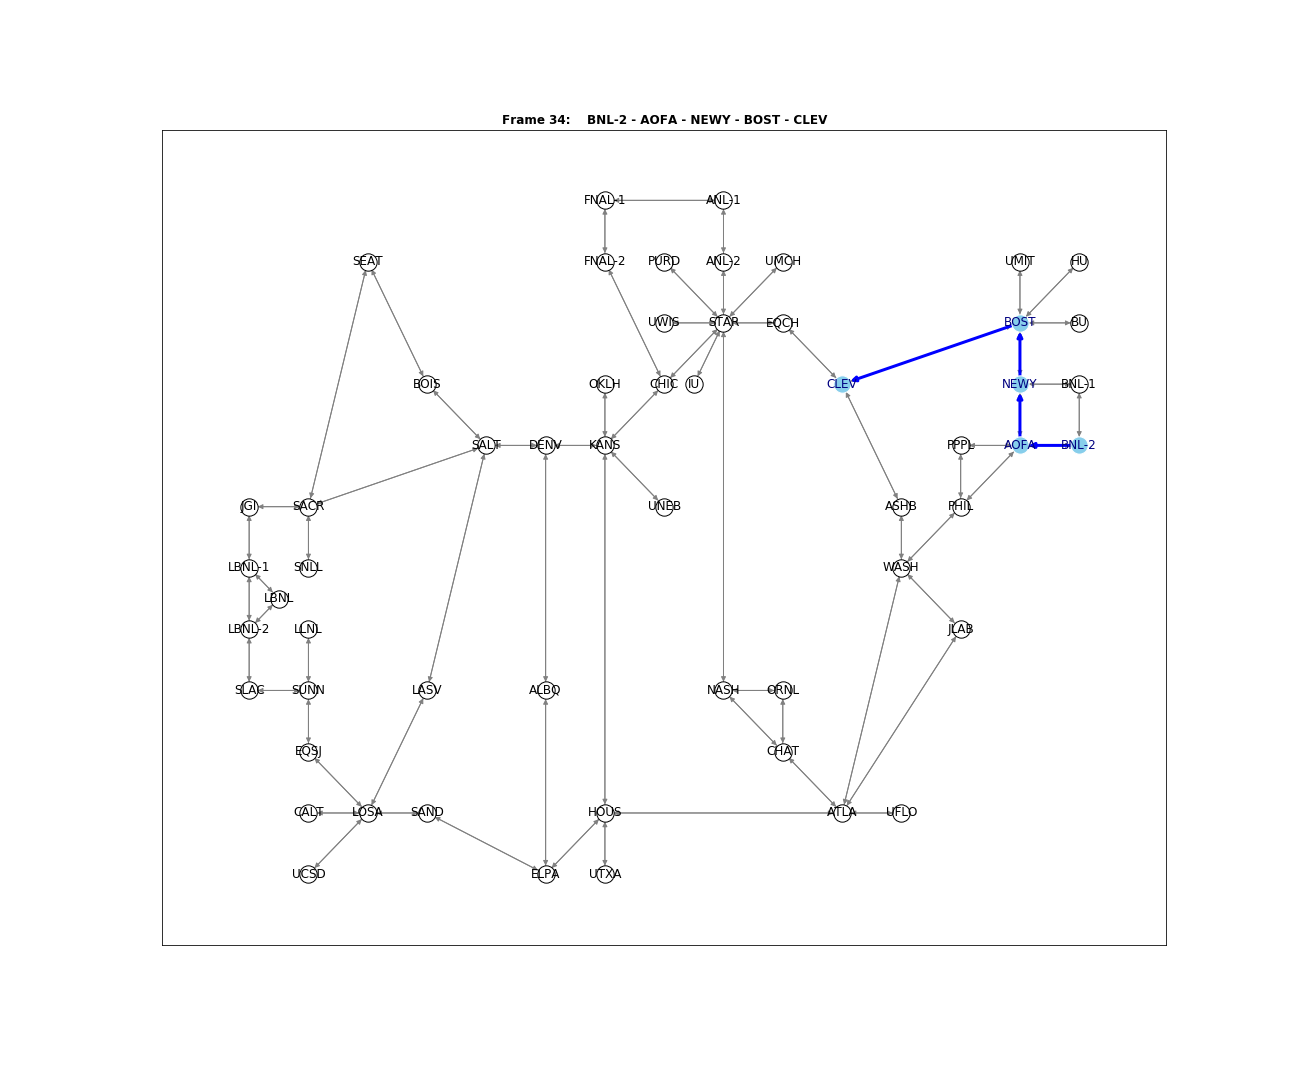
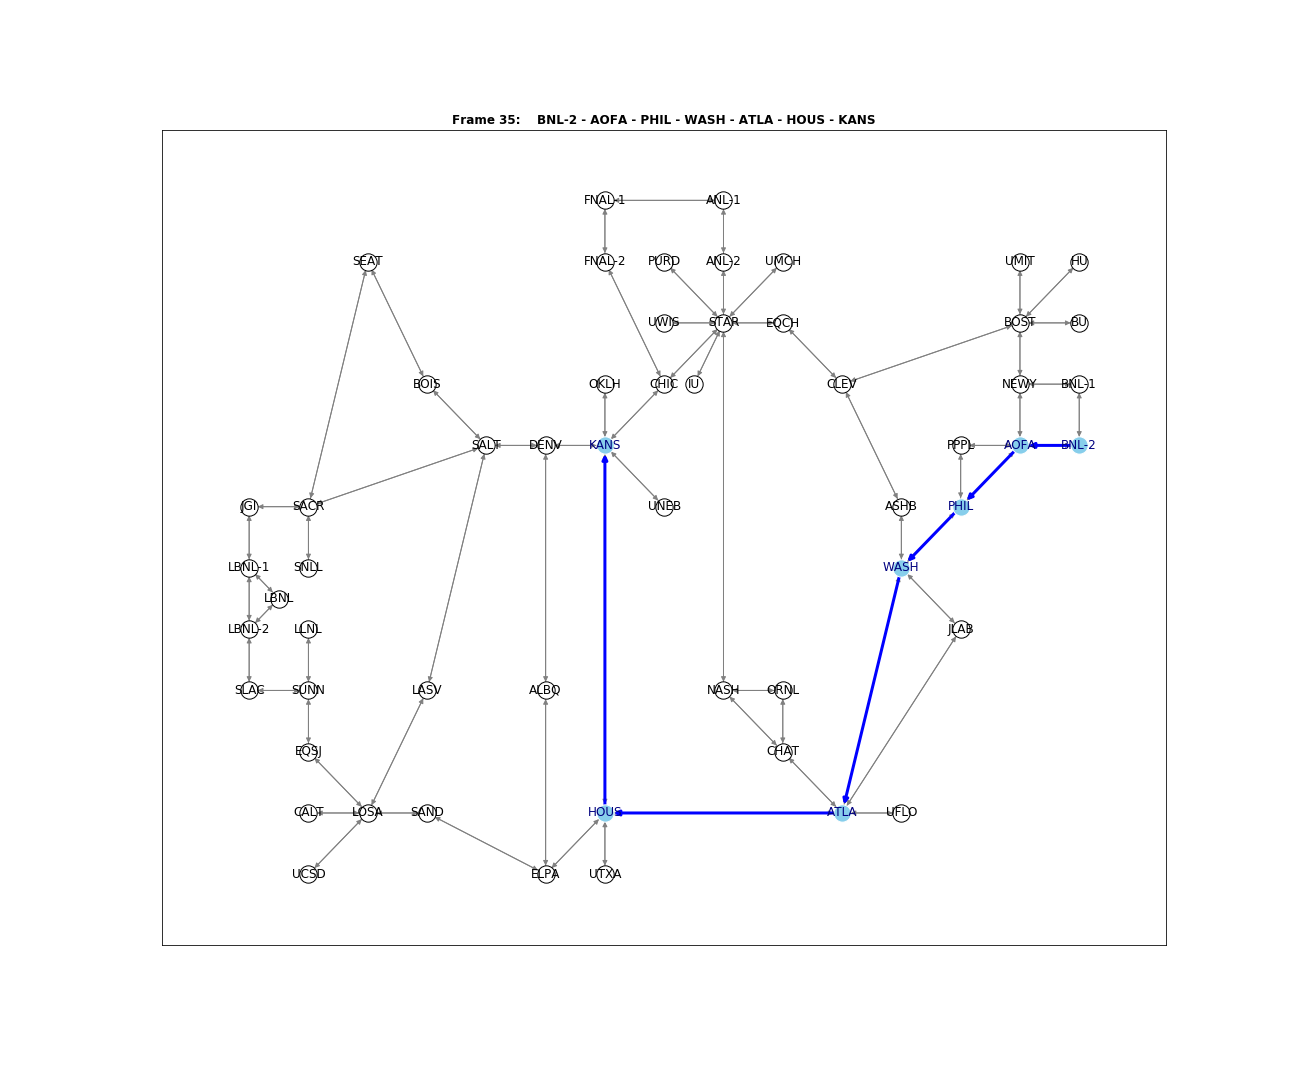
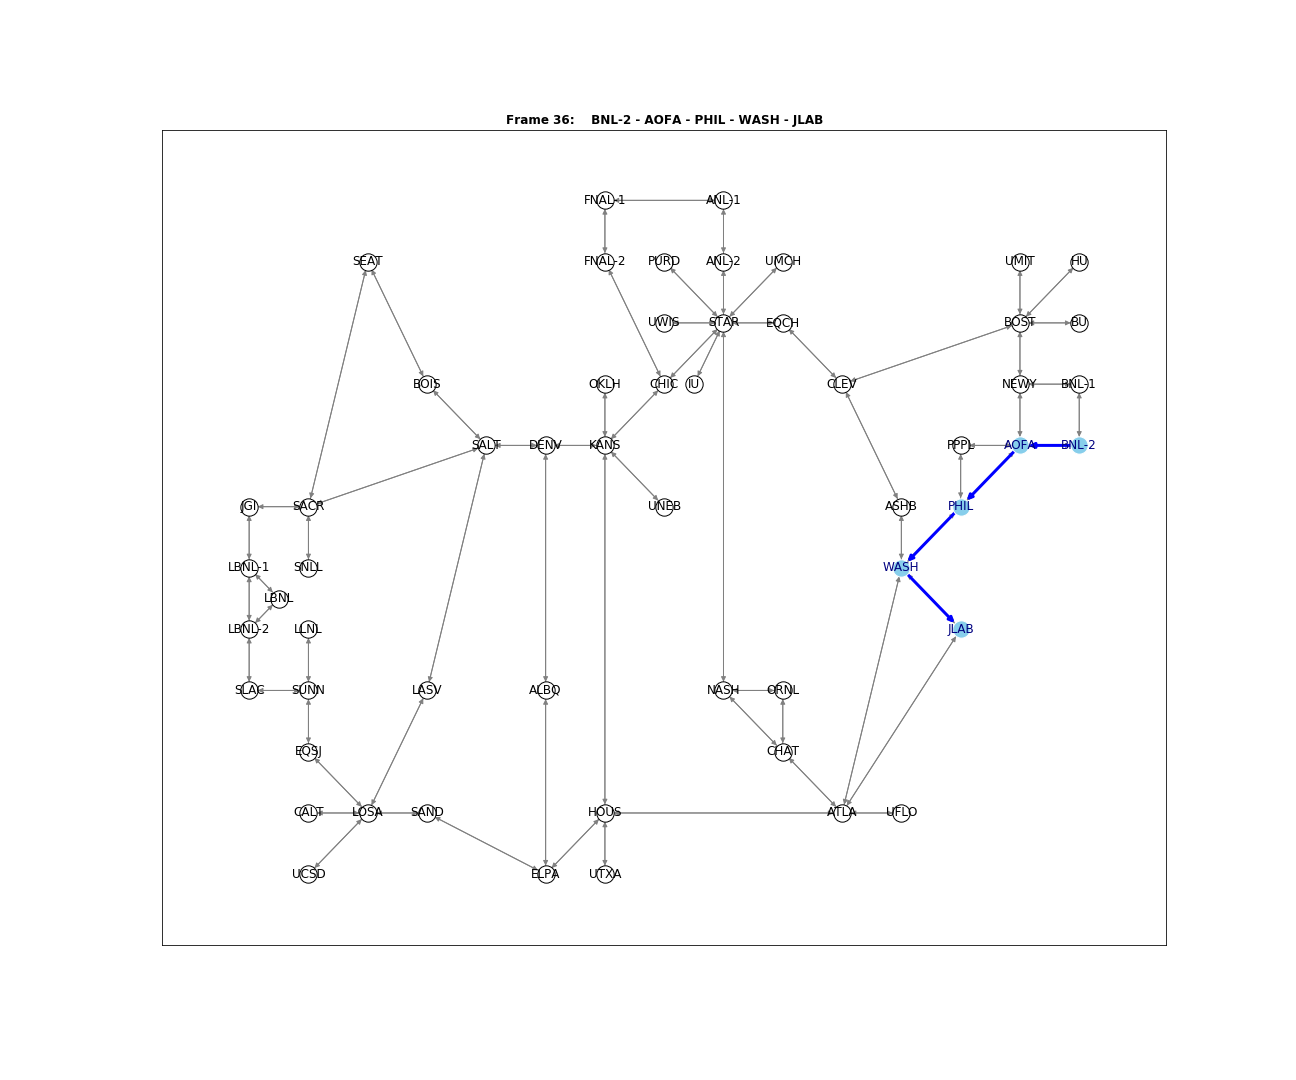
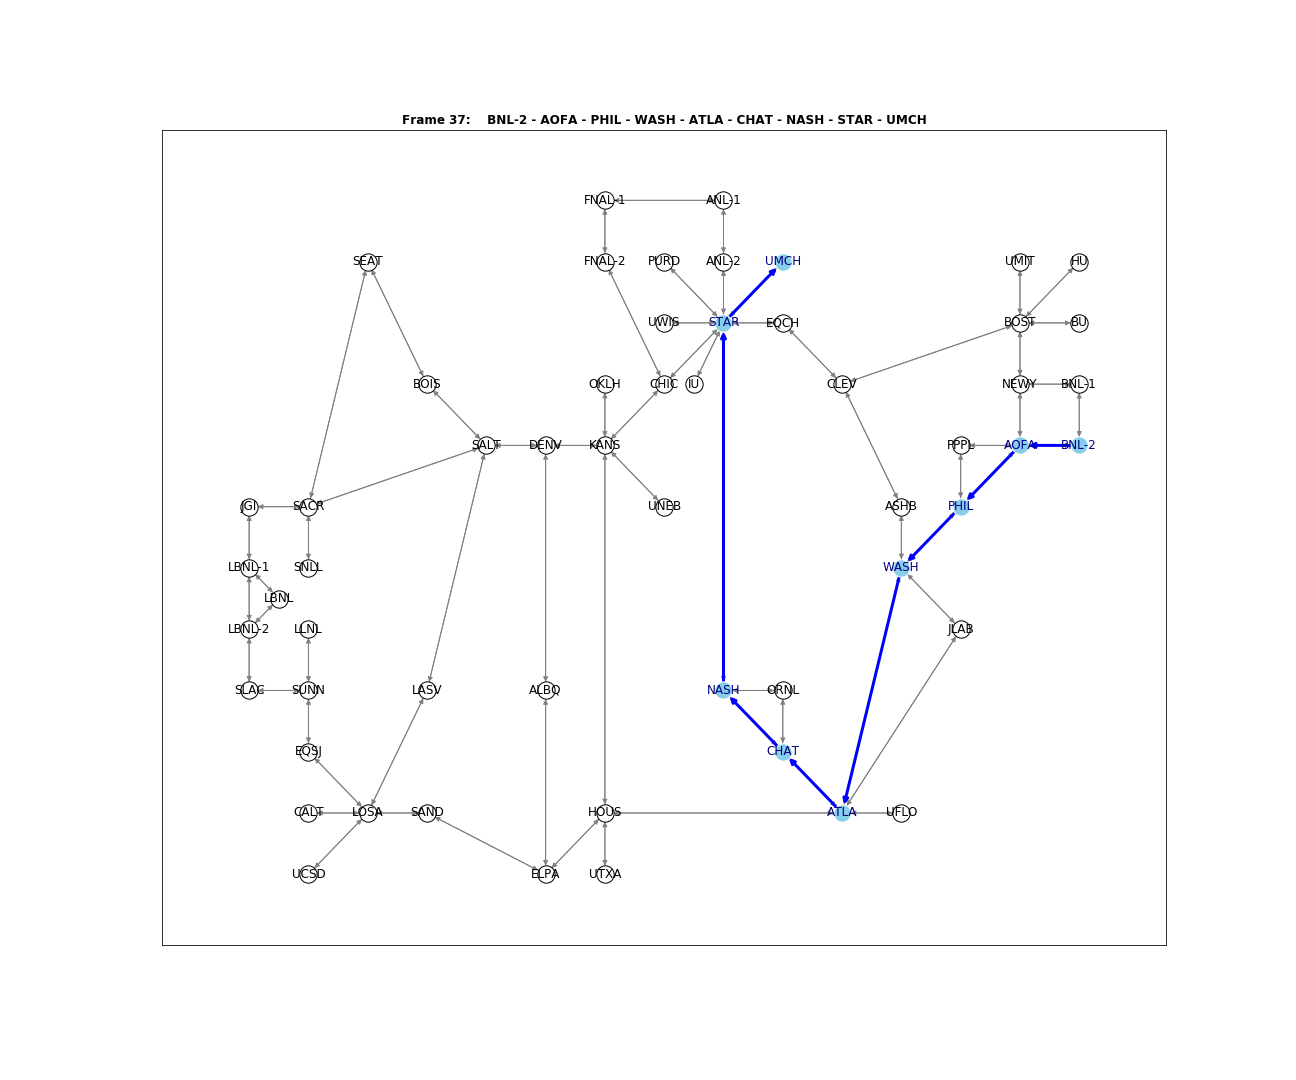
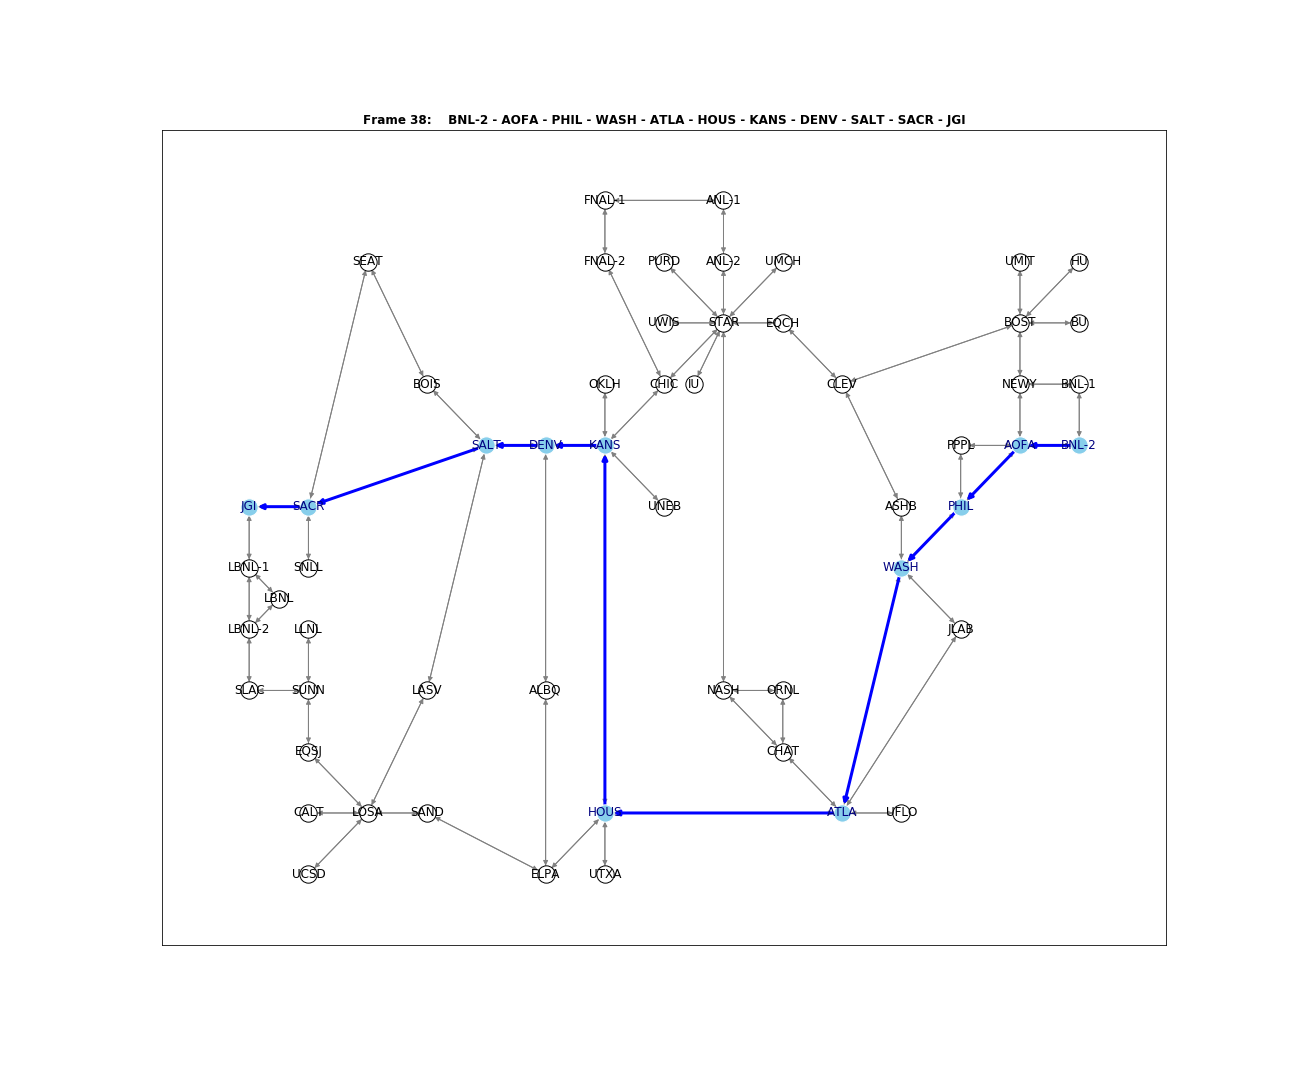
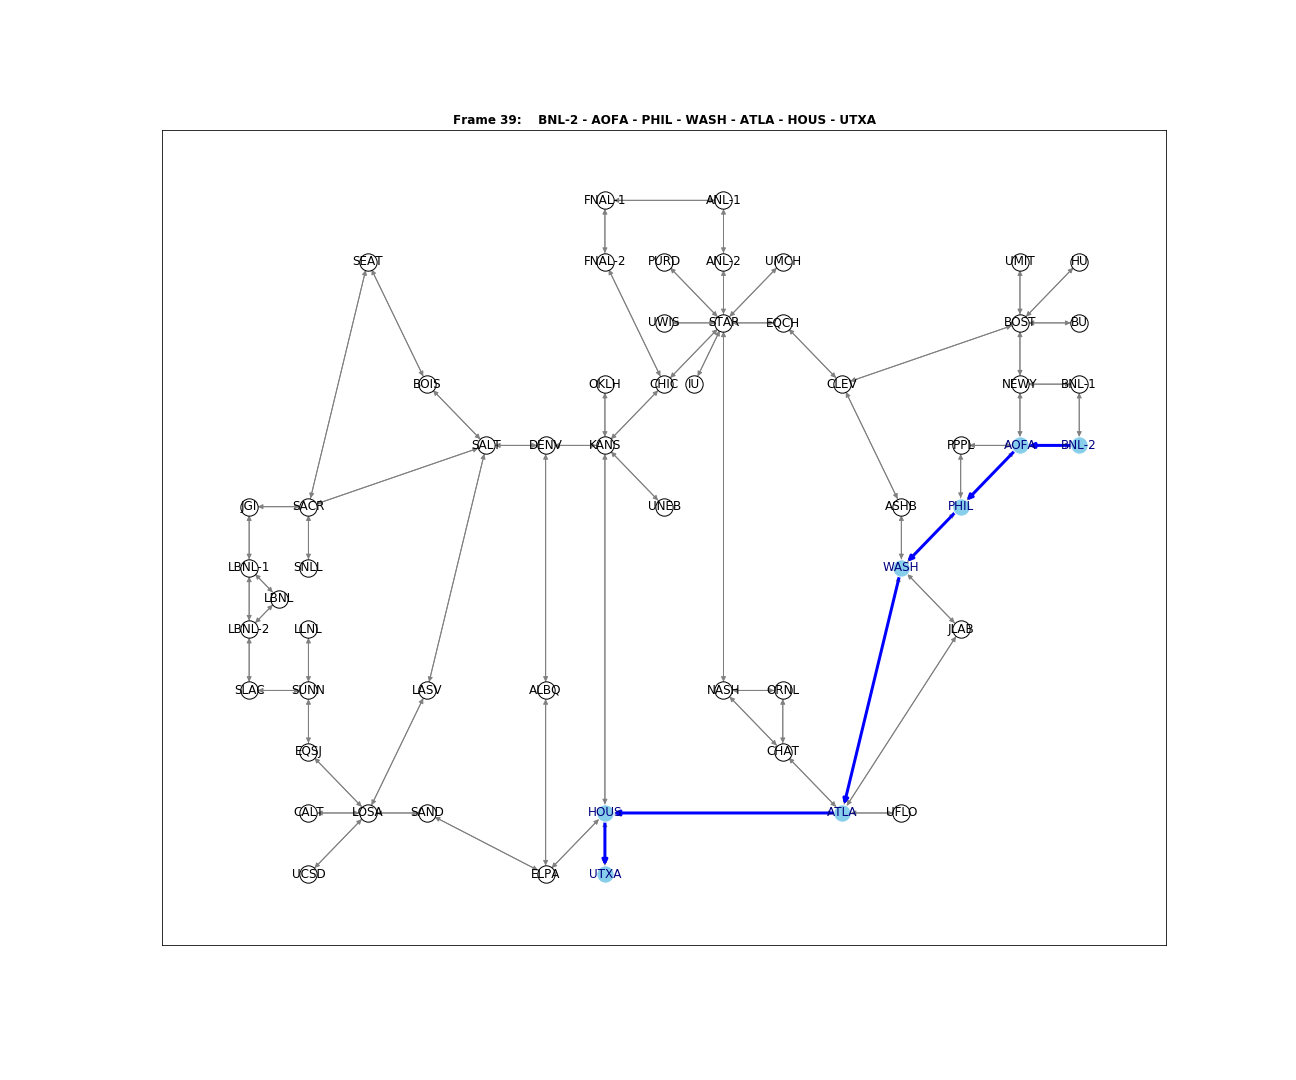
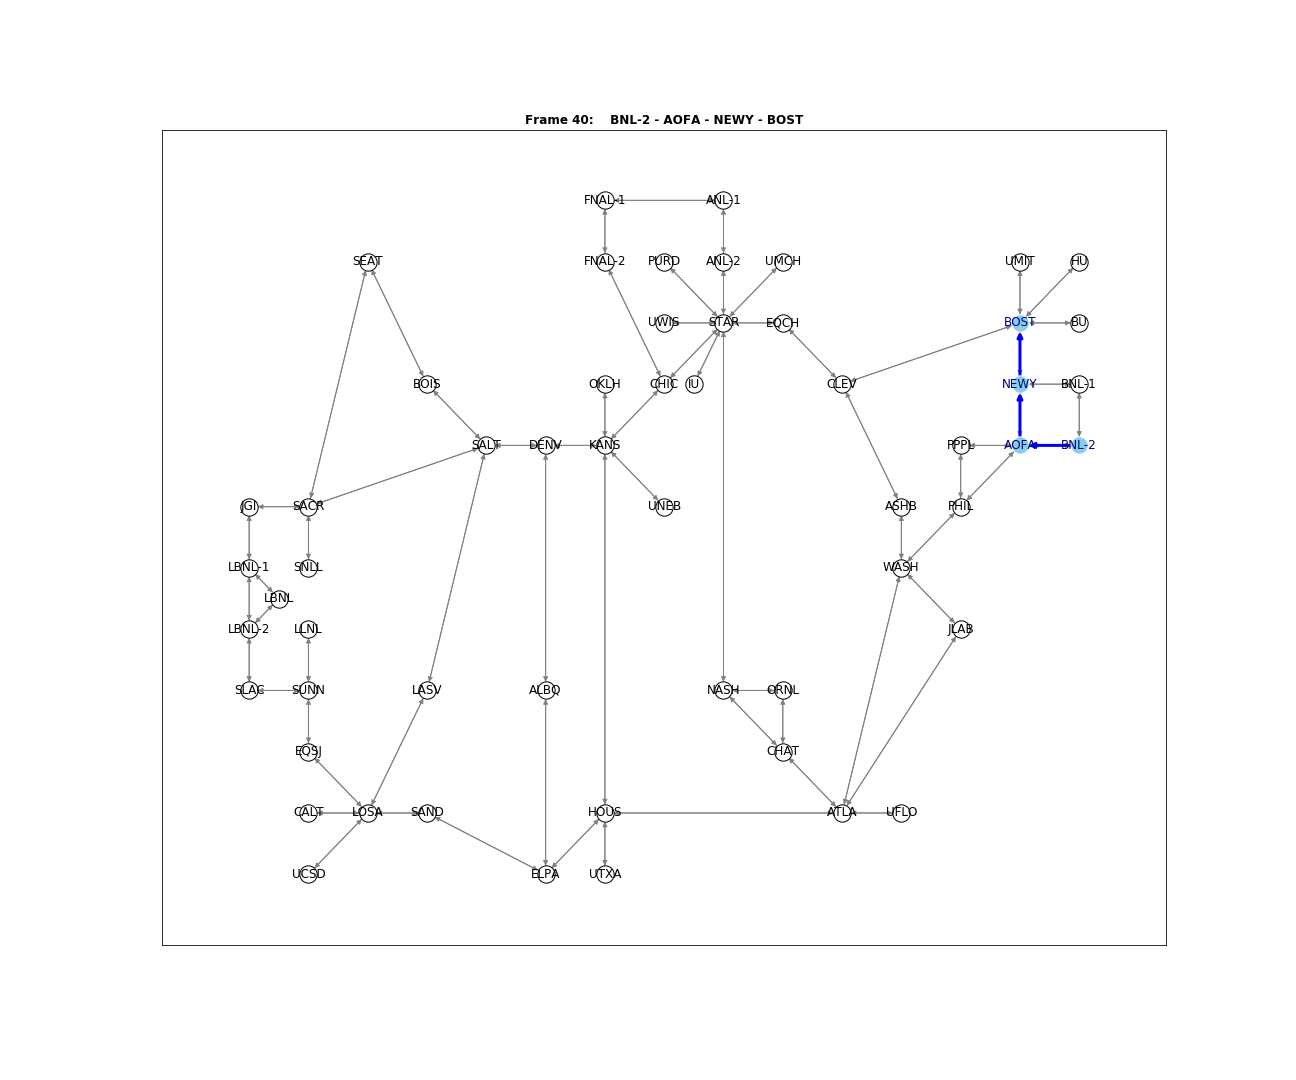
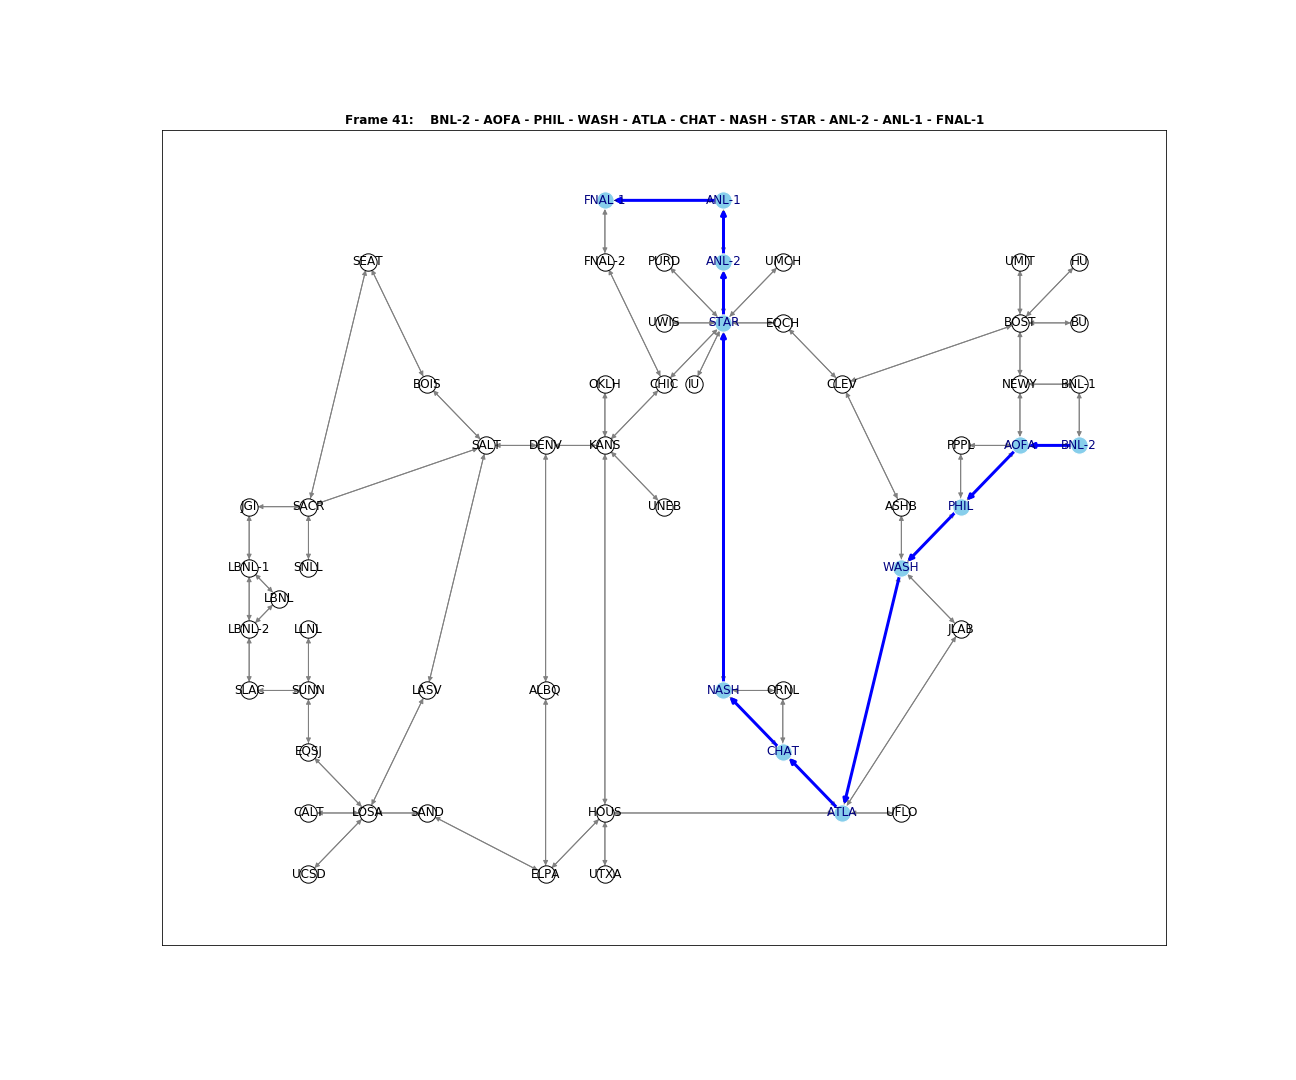
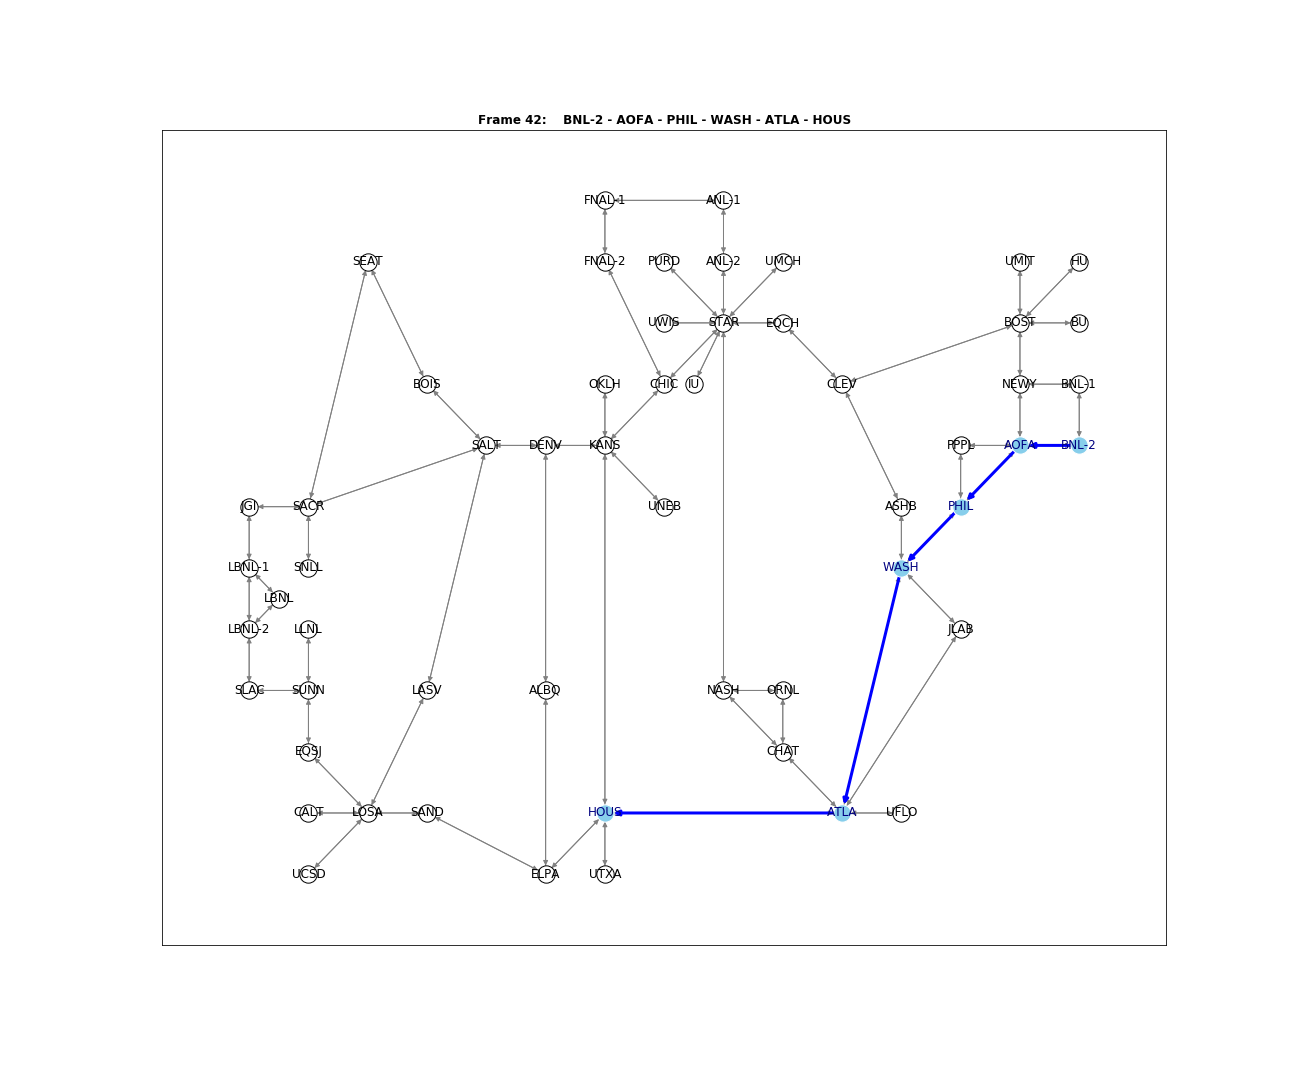
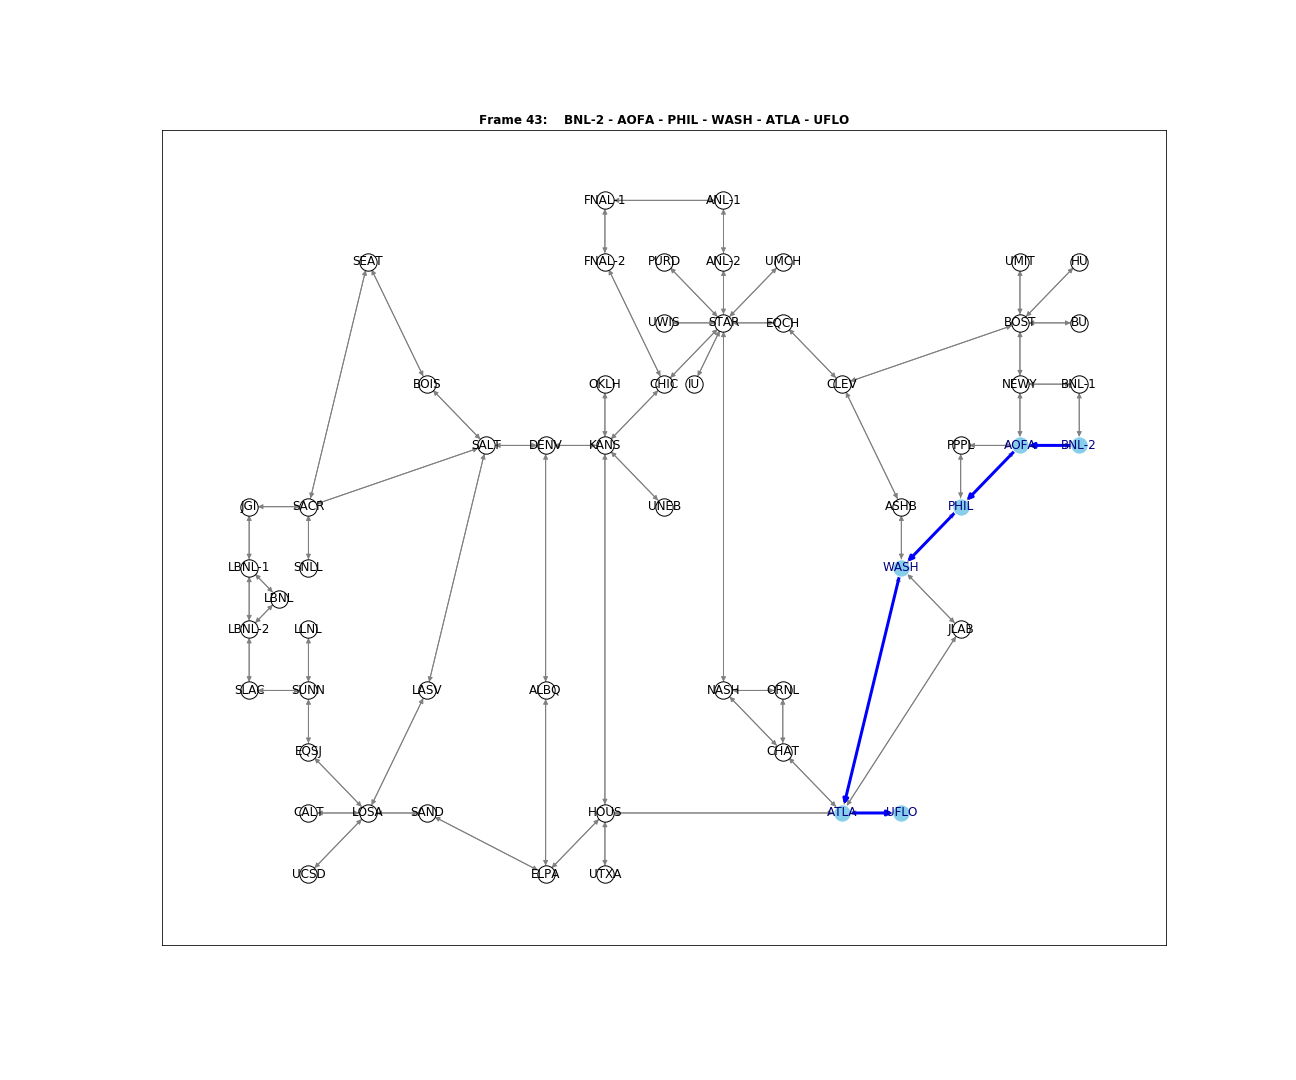
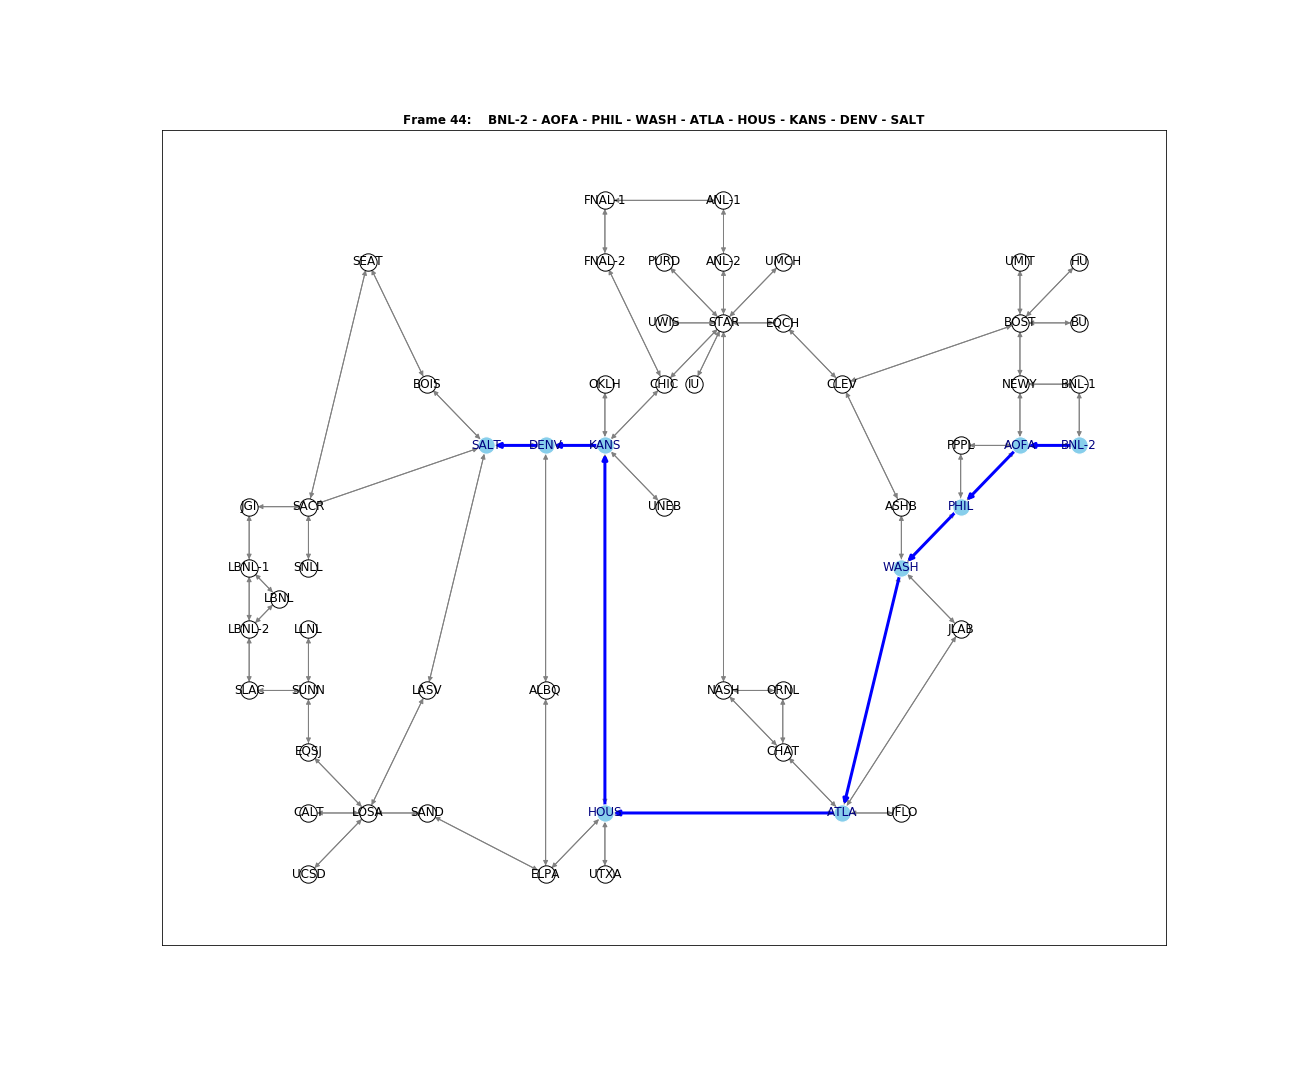
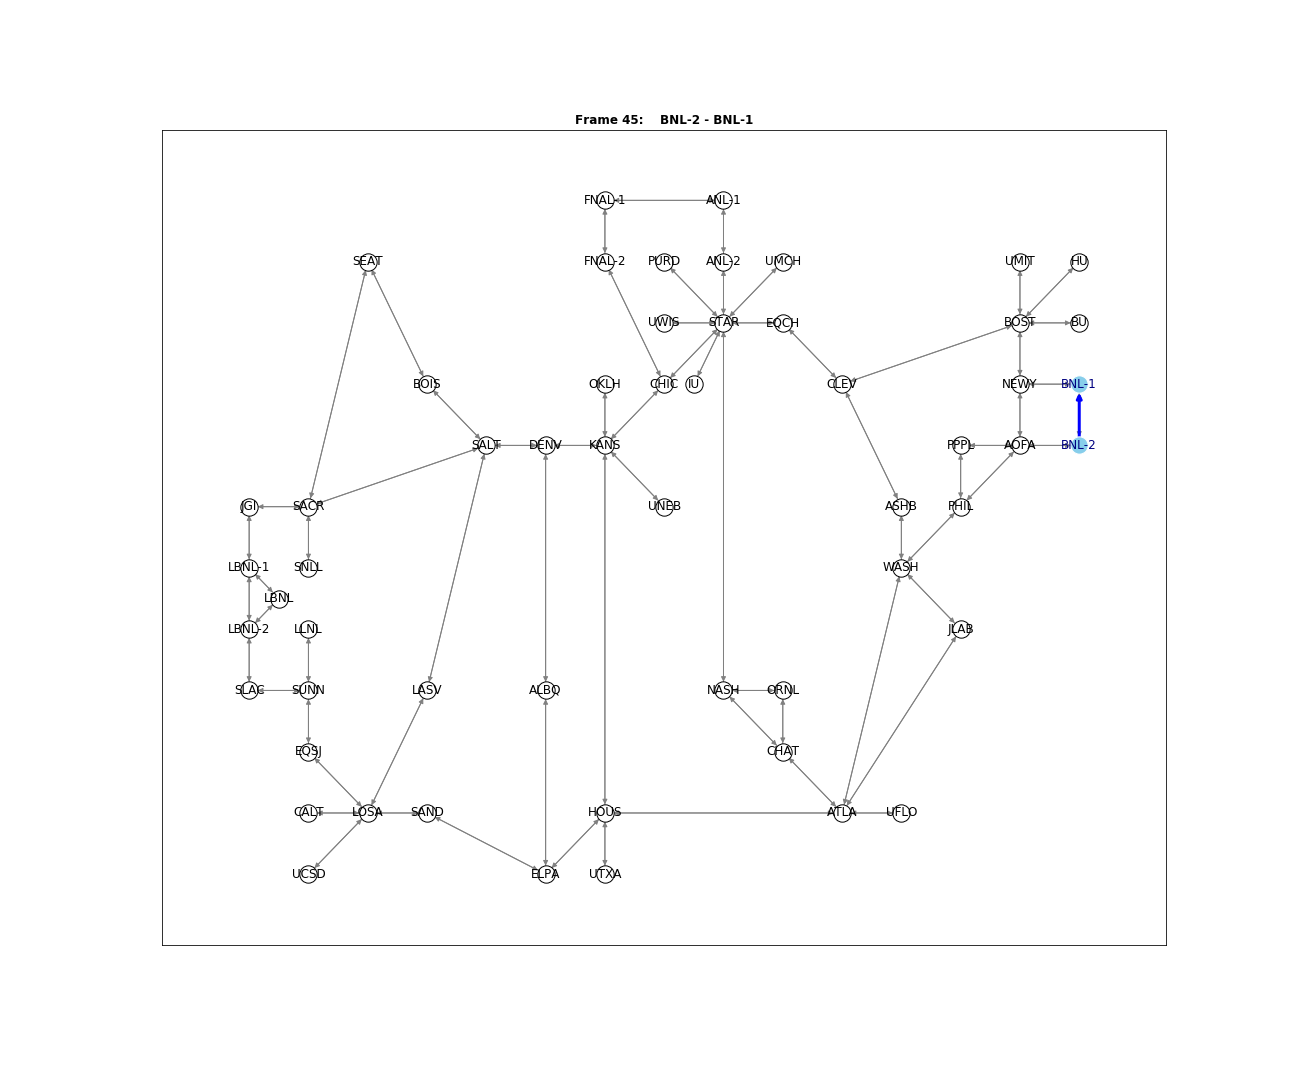
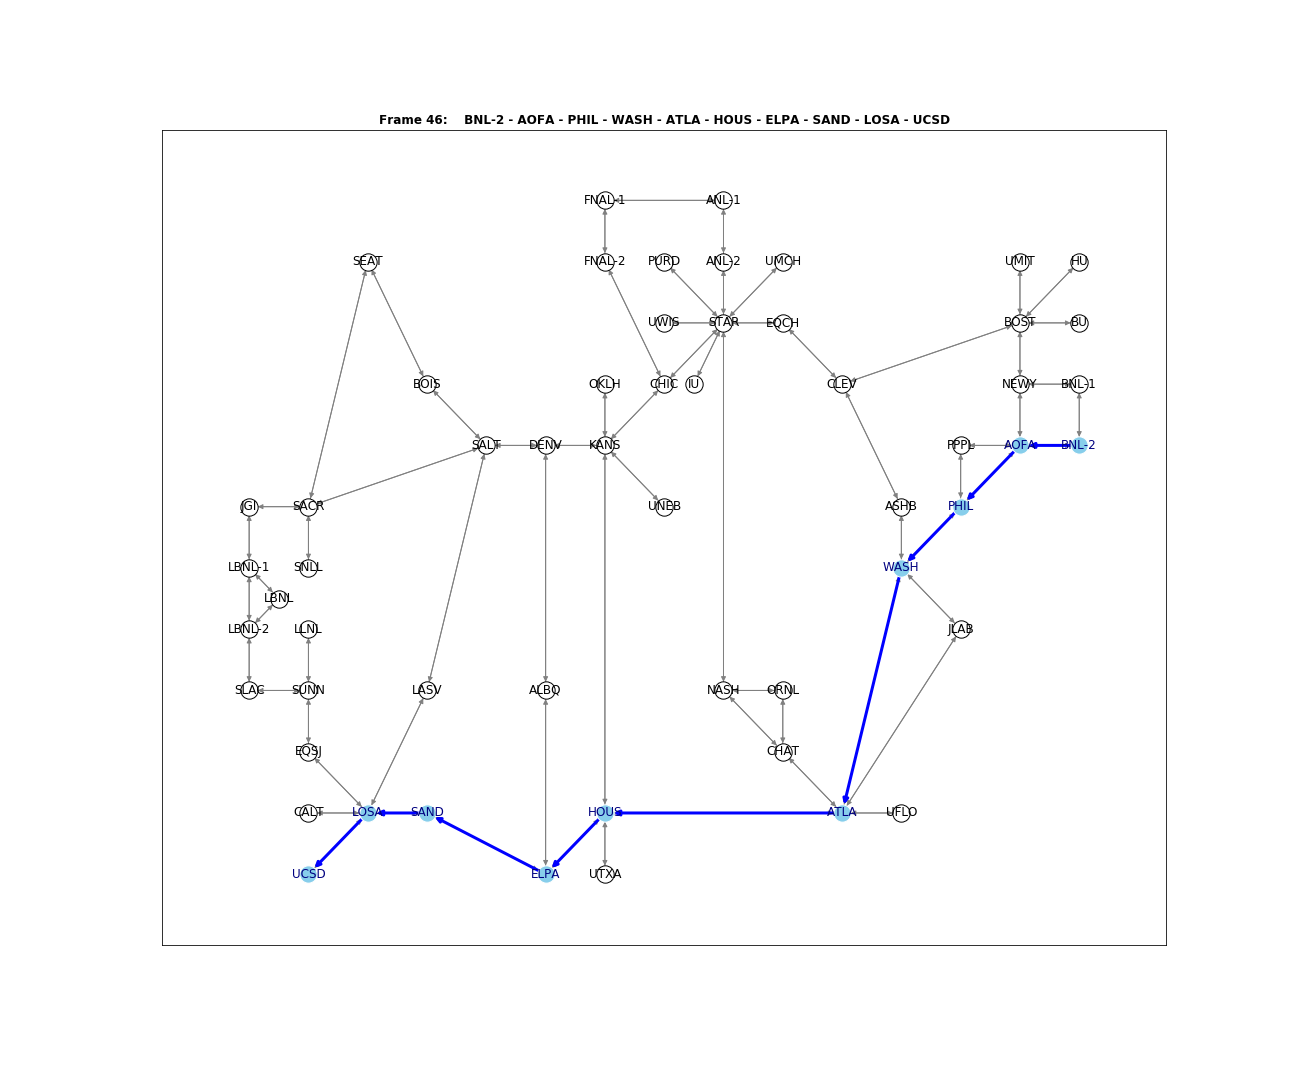
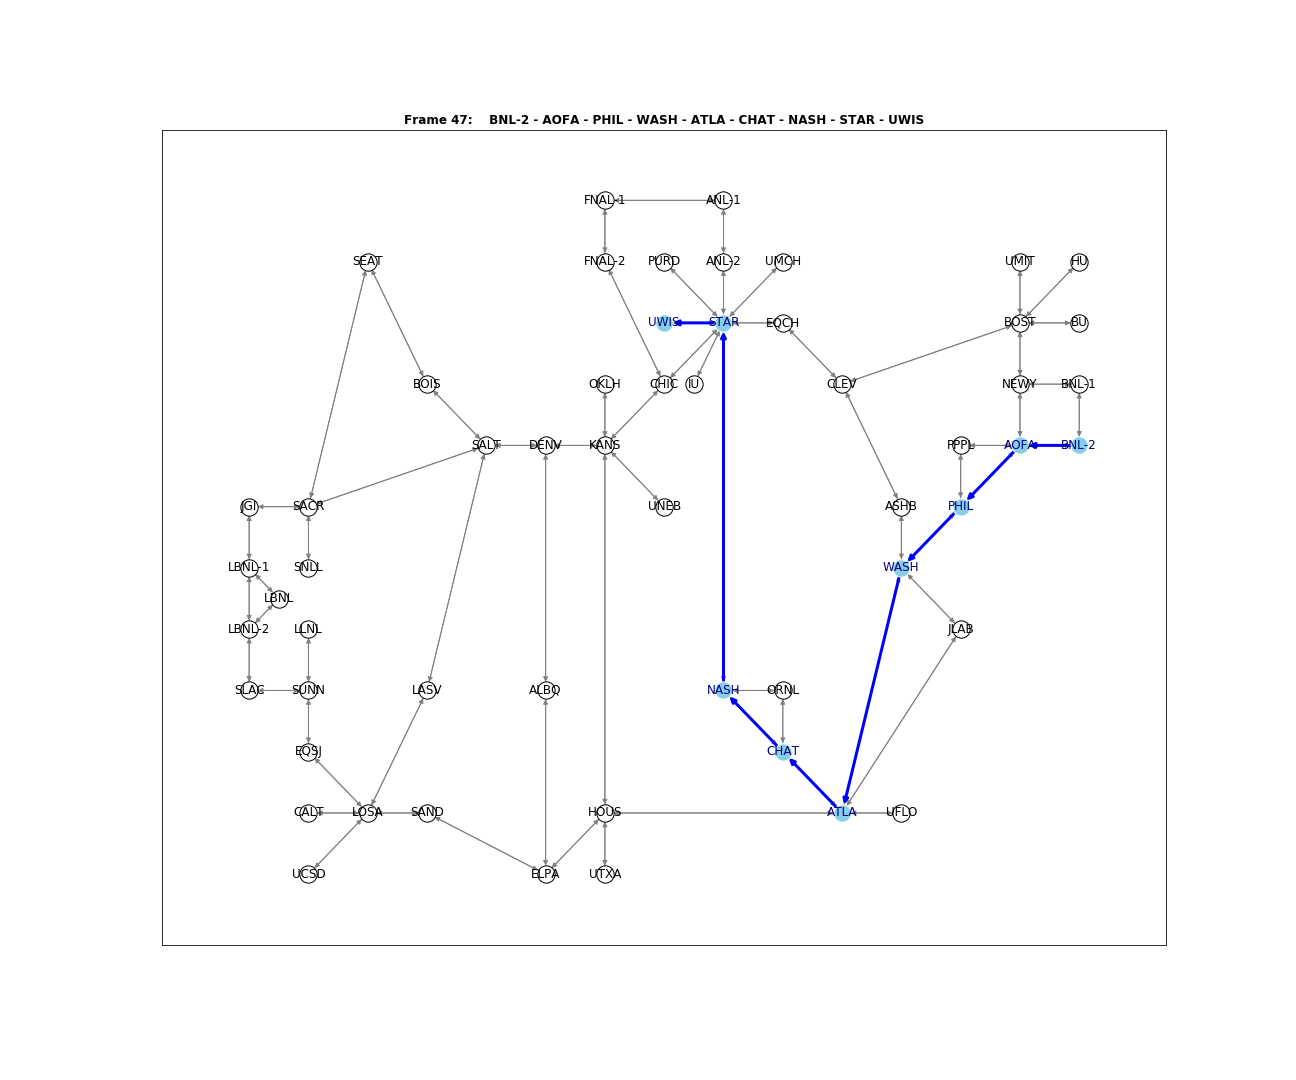
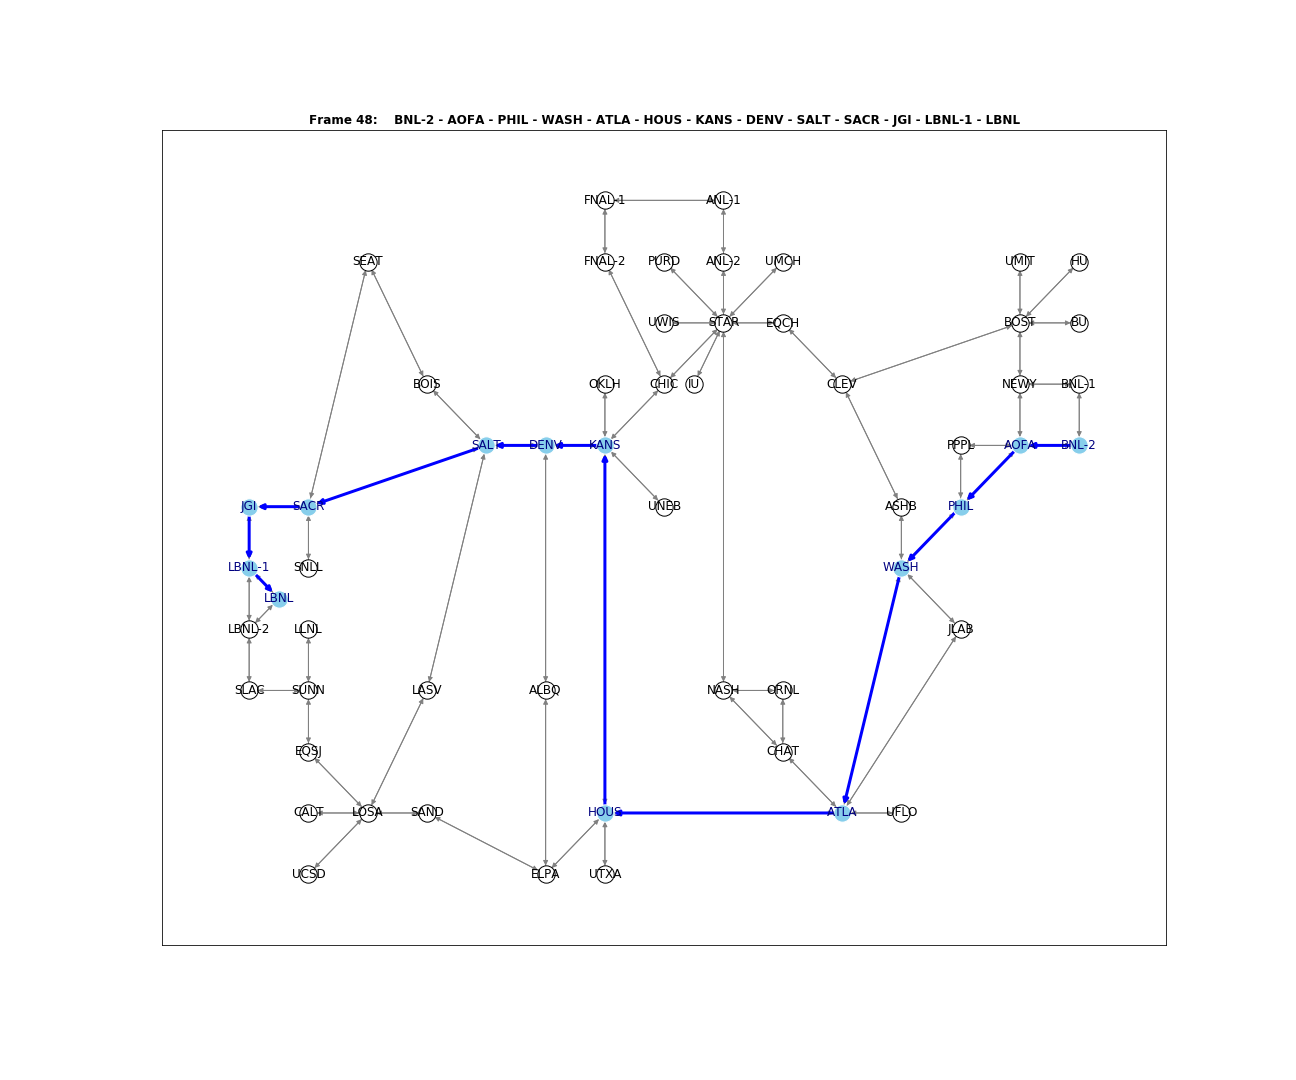
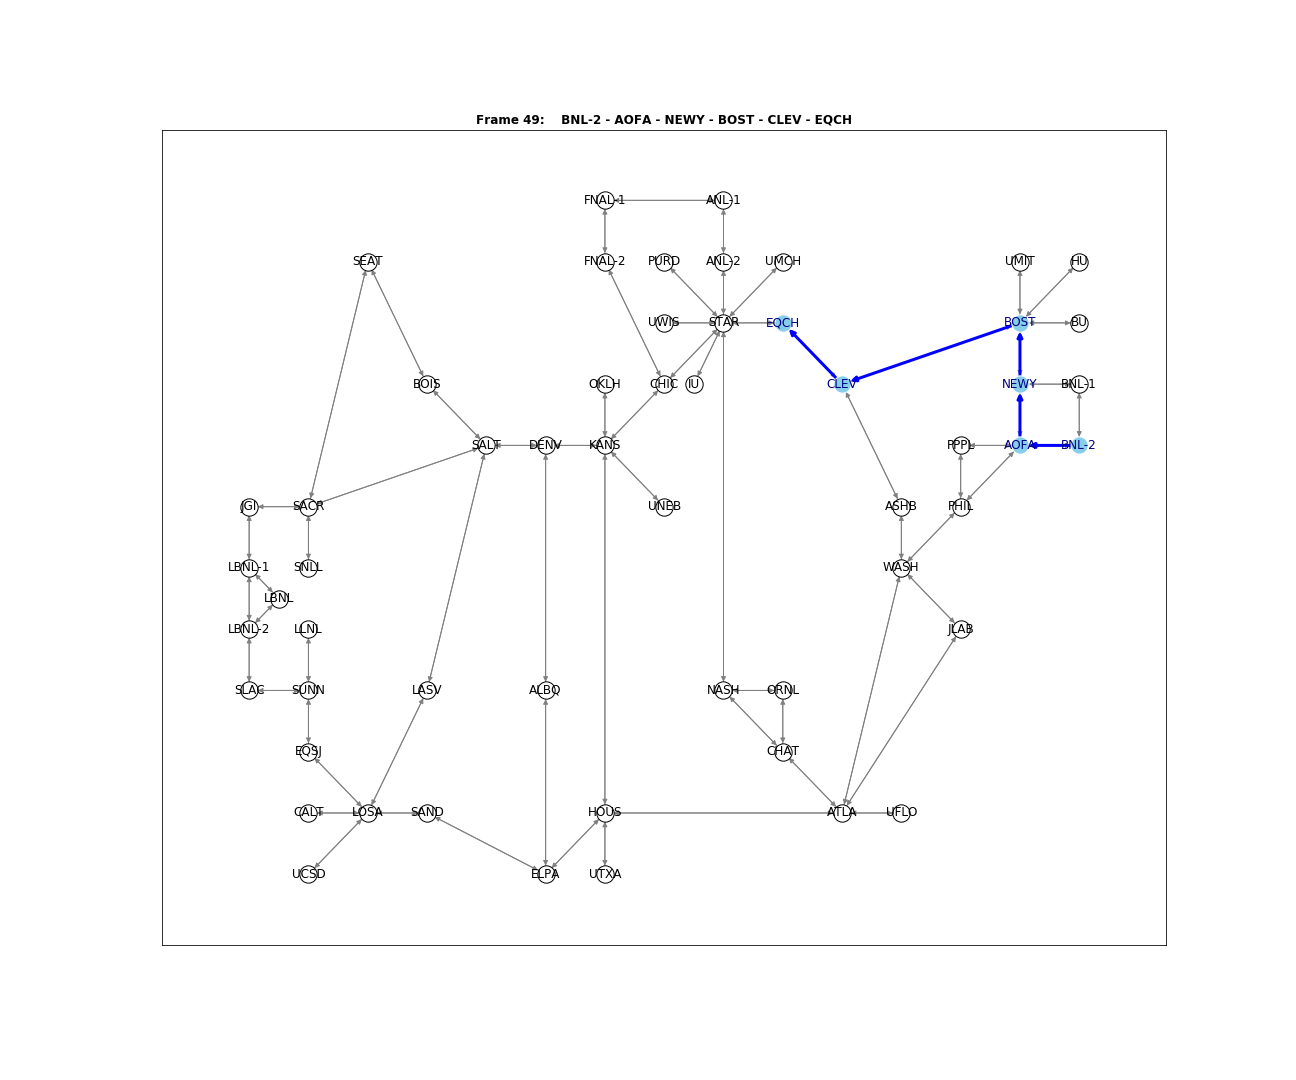
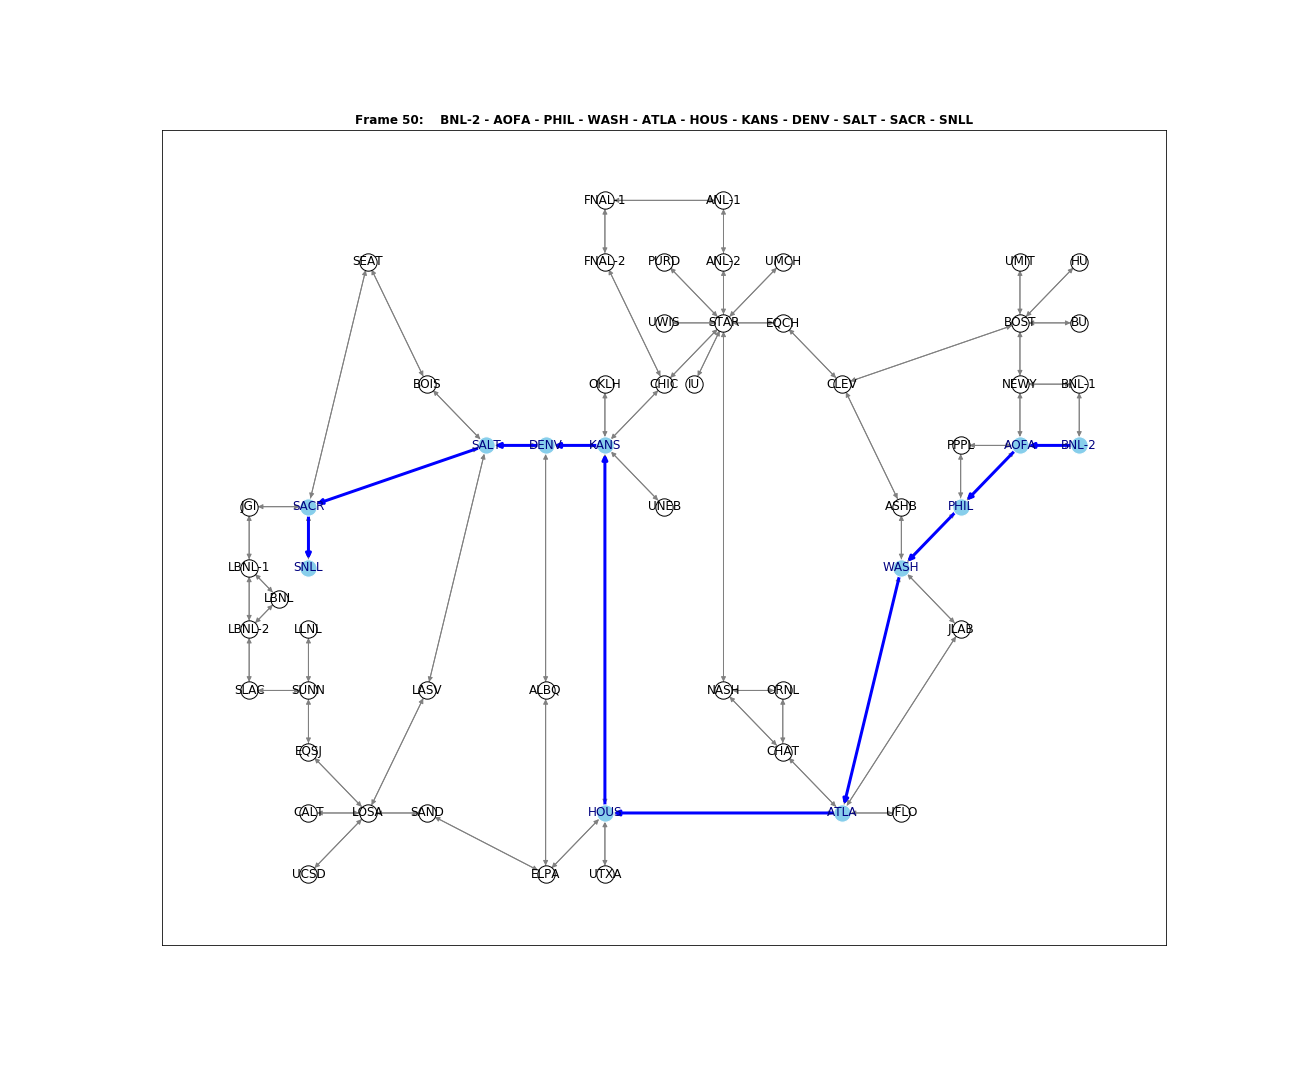
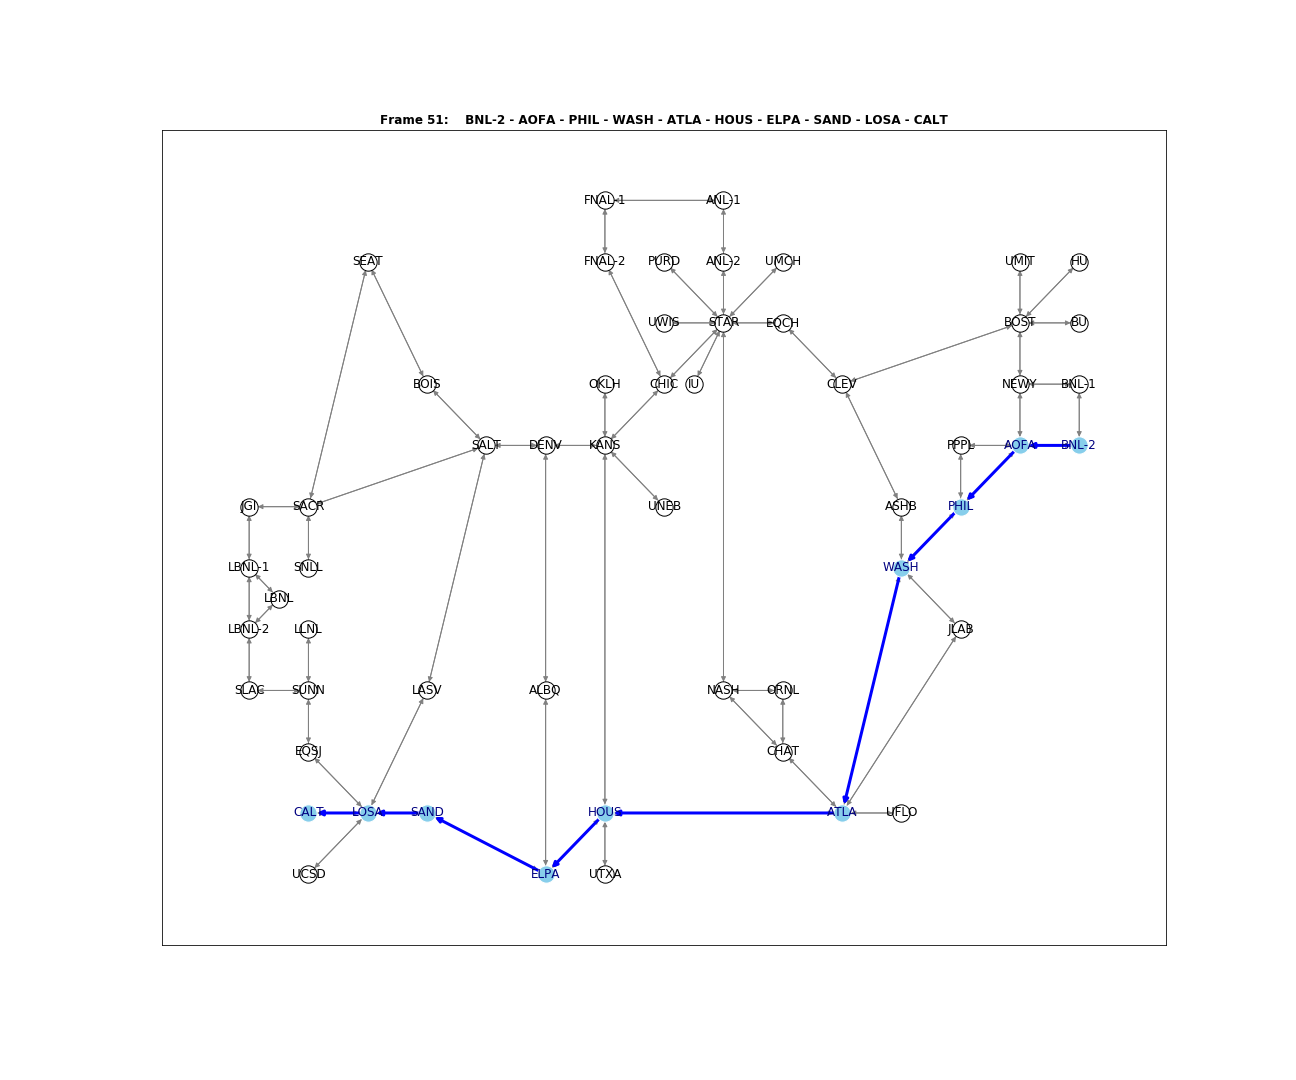
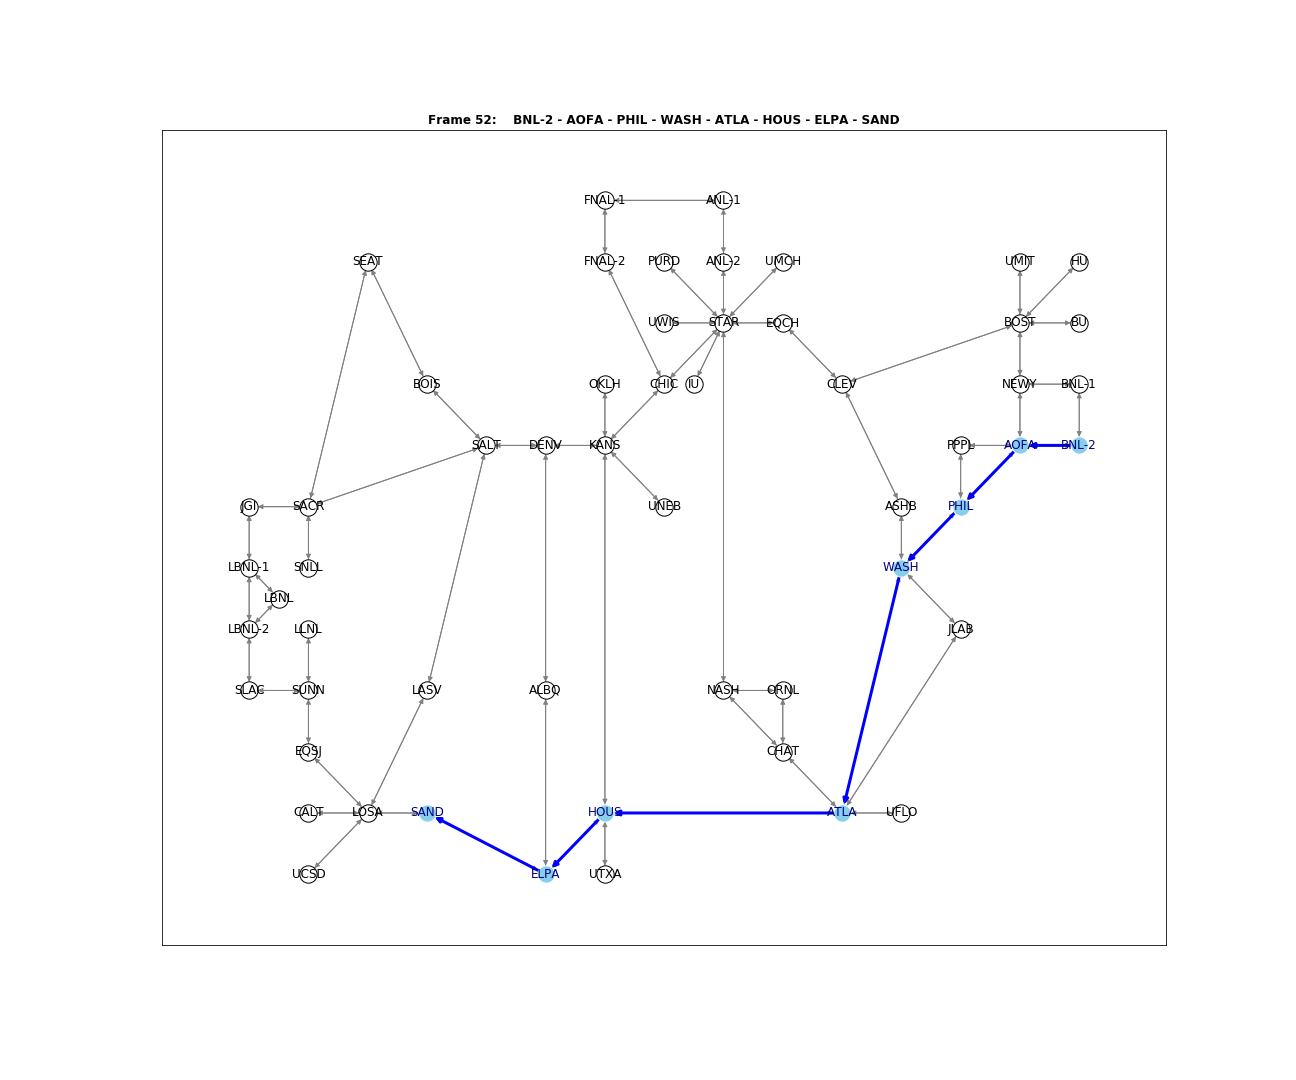
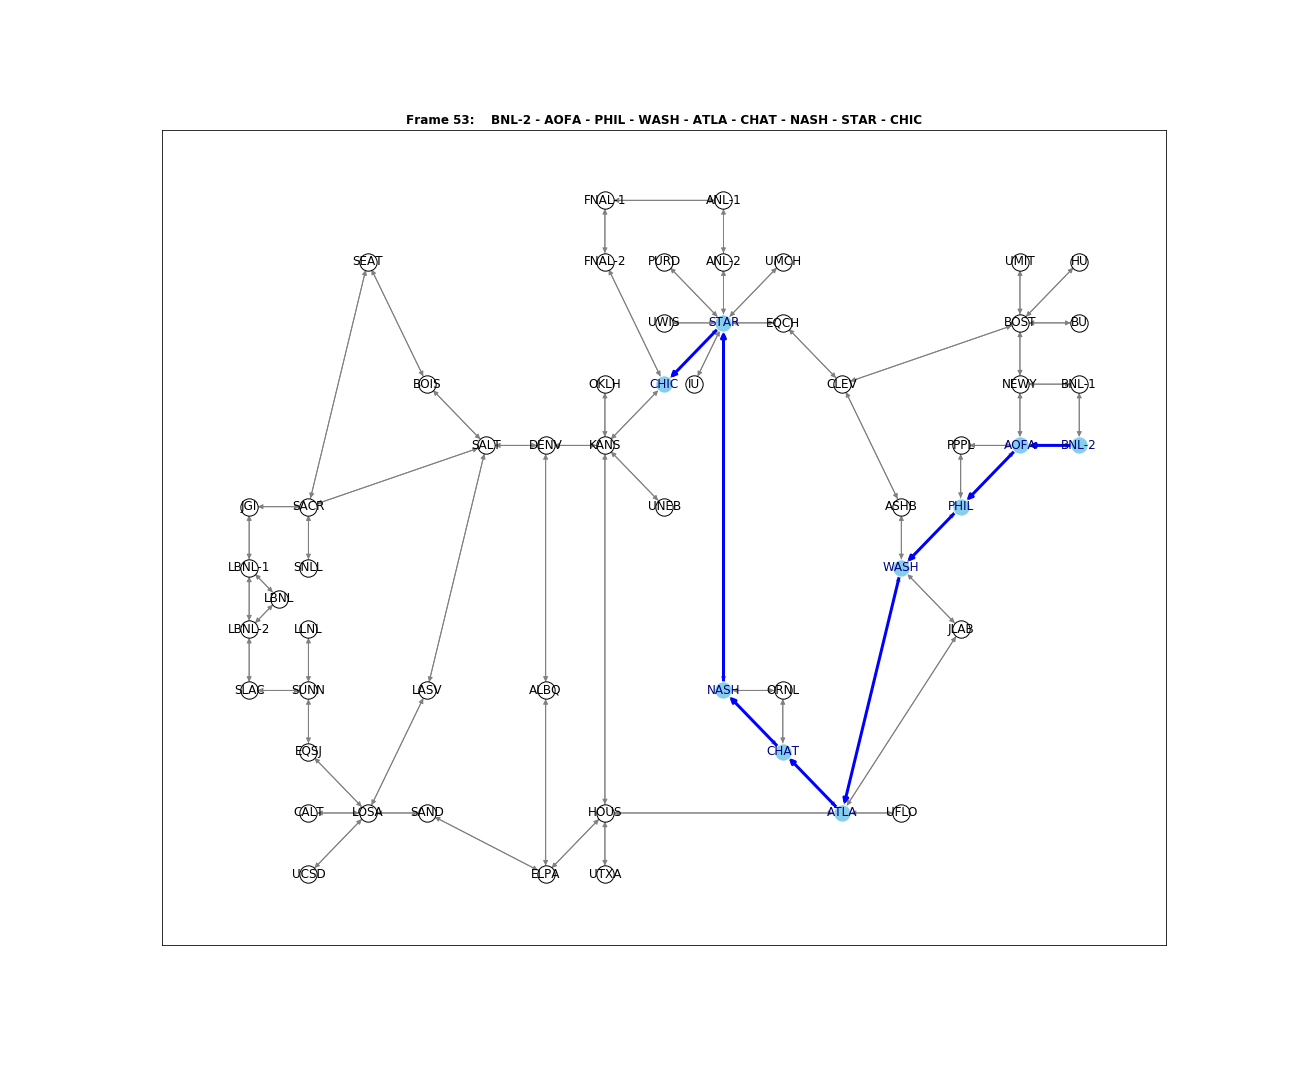
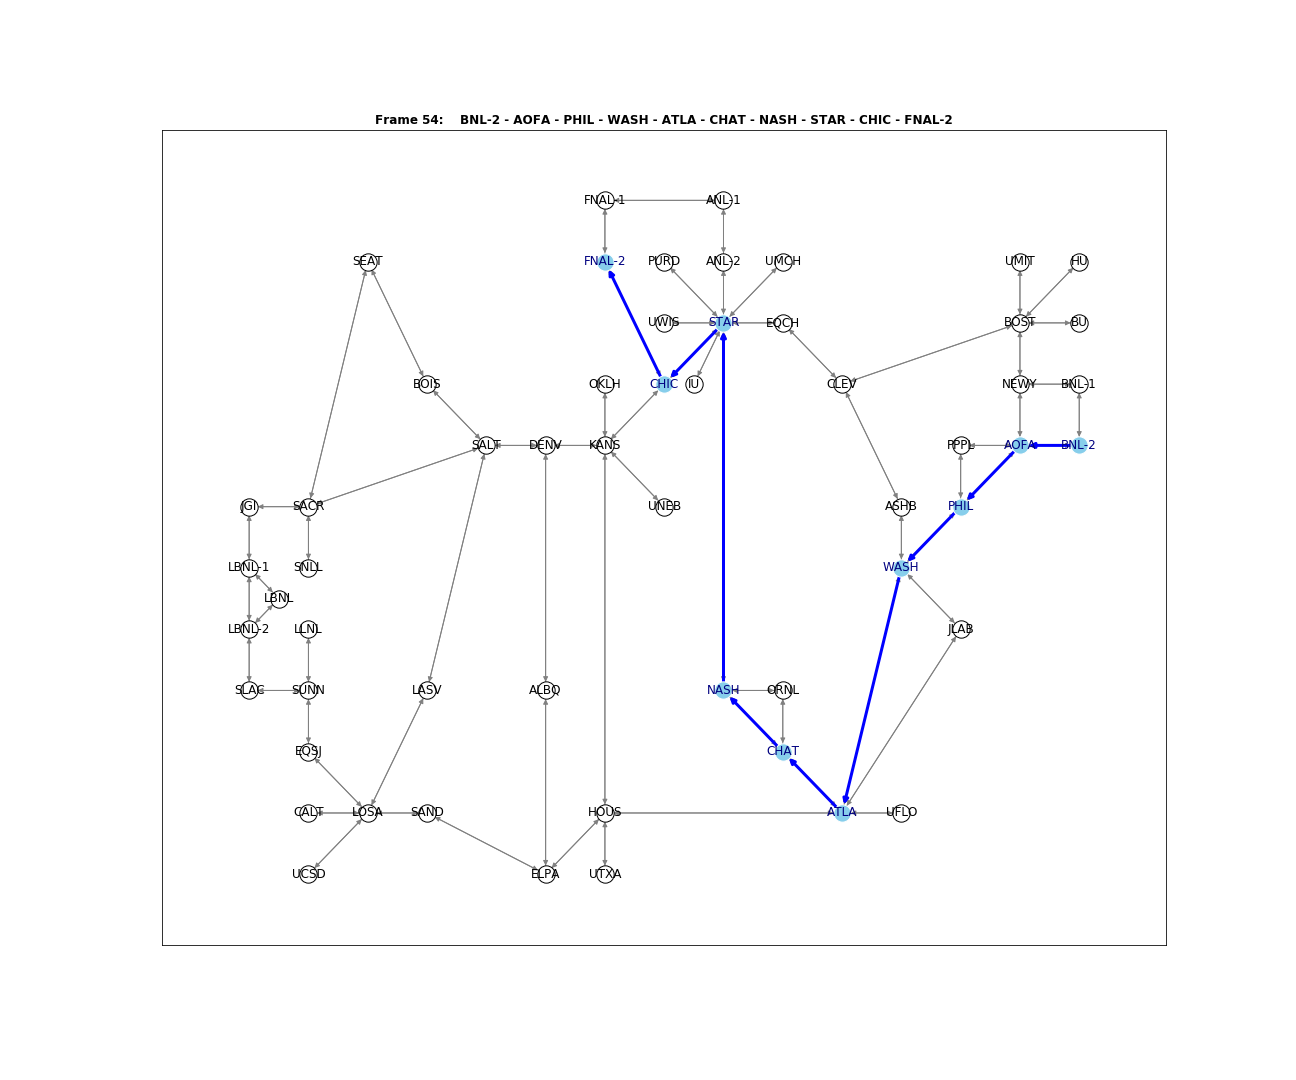
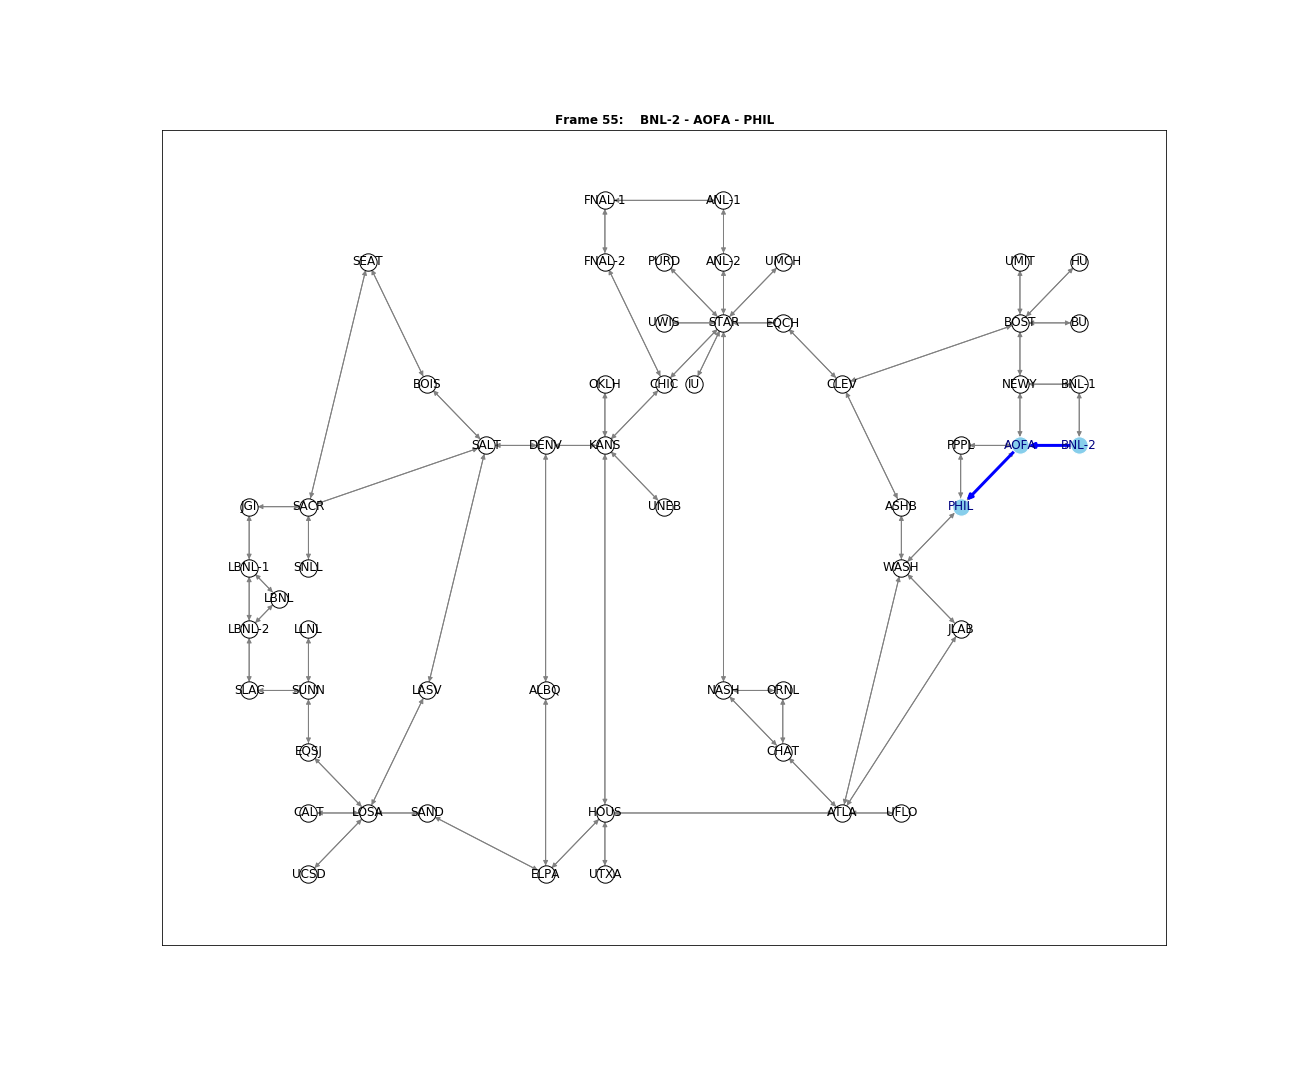

In [11]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import csv
import scipy as sp
import pandas as pd
import random

G = nx.read_graphml('network.graphml')
edges = G.edges()
link_bw = nx.get_edge_attributes(G,'capacity')
X = nx.get_node_attributes(G,'X')
Y = nx.get_node_attributes(G,'Y')
X_label = nx.get_node_attributes(G,'Xlbl')
Y_label = nx.get_node_attributes(G,'Ylbl')

def merge(d1, d2, merge):
    result = dict(d1)
    for k,v in d2.items():
        if k in result:
            result[k] = merge(result[k], v)
        else:
            result[k] = v
    return result

pos = merge(X, Y, lambda x, y:(x,y))
node_label_pos = merge(X_label, Y_label, lambda x, y:(x,y))

# Build plot
fig, ax = plt.subplots(figsize=(18,15))
dijkstra_source = 'BNL-2'
paths_from_dijkstra = nx.single_source_dijkstra_path(G,dijkstra_source,weight='impedance')
keys = list(paths_from_dijkstra.keys())
random.shuffle(keys)
it = iter(keys)

def update(num):
    ax.clear()
    
    dijkstra_dest = next(it)
    path = paths_from_dijkstra[dijkstra_dest]

    # Background nodes
    nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color="gray")
    null_nodes = nx.draw_networkx_nodes(G, pos=pos, nodelist=set(G.nodes()) - set(path), node_color="white",  ax=ax)
    nx.draw_networkx_labels(G, pos=pos, labels=dict(zip(set(G.nodes()) - set(path),set(G.nodes()) - set(path))),  font_color="black", ax=ax)
    null_nodes.set_edgecolor("black")

    # Query nodes
    query_nodes = nx.draw_networkx_nodes(G, pos=pos, nodelist=path, node_color="skyblue", ax=ax)
    query_nodes.set_edgecolor("white")
    nx.draw_networkx_labels(G, pos=pos, labels=dict(zip(path,path)),  font_color="navy", ax=ax)
    edgelist = [path[k:k+2] for k in range(len(path) - 1)]
    nx.draw_networkx_edges(G, pos=pos, edgelist=edgelist, width=3, ax=ax, edge_color="blue")

    # Scale plot ax
    ax.set_title("Frame %d:    "%(num+1) +  " - ".join(path), fontweight="bold")
    ax.set_xticks([])
    ax.set_yticks([])


animation.FuncAnimation(fig, update, frames=len(paths_from_dijkstra.keys())-1, interval=300, repeat=True)

In [12]:
G.nodes()

NodeView(('SEAT', 'BOIS', 'SACR', 'ANL-1', 'FNAL-1', 'ANL-2', 'STAR', 'BOST', 'CLEV', 'NEWY', 'FNAL-2', 'CHIC', 'KANS', 'HOUS', 'DENV', 'EQCH', 'ASHB', 'WASH', 'PHIL', 'JLAB', 'ATLA', 'NASH', 'PPPL', 'AOFA', 'SALT', 'LASV', 'ALBQ', 'BNL-1', 'BNL-2', 'SNLL', 'JGI', 'LLNL', 'SUNN', 'LOSA', 'LBNL-1', 'LBNL-2', 'ORNL', 'CHAT', 'SLAC', 'EQSJ', 'ELPA', 'SAND', 'CALT', 'UFLO', 'UMCH', 'LBNL', 'UMIT', 'IU', 'UNEB', 'BU', 'HU', 'PURD', 'OKLH', 'UTXA', 'UWIS', 'UCSD'))